In [1]:
from tools_harassment import * 
import torch 
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

path="../Datasets/CSV_Harassment/"
train =pd.read_csv(path + "train_format.csv")
val=pd.read_csv(path + "val_format.csv")
test=pd.read_csv(path + "test_format.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


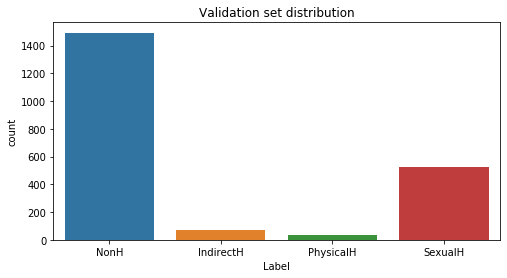

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(val['Label'], order=["NonH", "IndirectH", "PhysicalH", "SexualH"])
plt.title('Validation set distribution')
plt.show()

In [3]:
def det_samples(df, dict_class, c_weights=None): #None o diccionario de fracciones a aum.
    conteos= Counter(df)
    aumentos= dict()
    maxi= max(conteos.values())
            
    if c_weights is None:        # uniform class weights
        for tipo in conteos:
            actual= conteos[tipo]
            if actual<maxi:
                aumentos[tipo]=int(maxi-actual)
            else:
                aumentos[tipo]=0
        return aumentos   
    else:
        try:
            for clase in c_weights.keys():
                aumentos[clase]=int(c_weights[clase]*conteos[clase])
            for key in conteos.keys():
                if key not in aumentos.keys():
                    aumentos[key]=0
            return aumentos
        except:
            print ("No se ha especificado el diccionario de tasas de aumento de datos (por clase)")
    

In [4]:
def just_tag_word(sentence, tags_all, tag):  #wd en el vocab pues es la palabra que más pesa en el reemplazo
    n_sentence=[]
    indices=[]
    valid=[]
    i=0
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            i+=1
            continue
        else:
            if (tags_all[i] not in tag) or (wd not in token_2_idx.keys()):
                i+=1
                continue
            else:
                n_sentence.append(wd)
                indices.append(i)
                valid.append(tags_all[i])
            i+=1
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)

def re_generar(texto, tags_all, tag, f):
    sent, indices, tags = just_tag_word(texto, tags_all, tag)
    noise_mask = bernoulli.rvs(f, size=sent.shape)
    bool_list=list(map(bool,noise_mask))
    to_replace=sent[bool_list]
    indix=indices[bool_list]  
    tagx=tags[bool_list] 
    return to_replace , indix, tagx

In [5]:
def find_negative(target, not_sent, window=4):
    cleaned = cleaner(not_sent)[1]
    ide = cleaned.index(target)
    wind_neg=find_window(cleaned, target, ide, window=window)   
    return wind_neg
      
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [6]:
def most_similar_cosmul(space, EMB_matrix, bias, positive=None, negative=None, topn=1 ): #agregar space de vpcab
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    if negative is None:
        negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]
    
    positive = [EMB_matrix[idx] for idx in ids_pos]  #space de vocab
    ids_nega= [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
        for word in negative
    ]
    negative = [EMB_matrix[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    pos_dists = [((1 + dot(space, term))/2) for term in positive]    
    pos_dists[0]=pos_dists[0] + bias
    neg_dists = [((1 + dot(space, term))/2) for term in negative]
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used

    return best, dists[best] #retorna indices y distancias asociadas

def most_similar_cos(space, EMB_matrix, bias, positive=None, negative=None, topn=1 ): 
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    if negative is None:
        negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]
    
    positive = [EMB_matrix[idx] for idx in ids_pos]  #space de vocab
    ids_nega= [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
        for word in negative
    ]
    negative = [EMB_matrix[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    
    len_all=len(positive + negative)-1 
    pos_dists = []
    i=0
    for term in positive:
        if i==0:
            pos_dists.append(((1 + dot(space, term))/2))
        else:
            pos_dists.append(((1 + dot(space, term))/(2*len_all)))

    neg_dists = []
    i=0
    for term in negative:
        if i==0:
            neg_dists.append(((1 + dot(space, term))/2))
        else:
            neg_dists.append(((1 + dot(space, term))/(2*len_all)))
    
    
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used


    return best, dists[best] #retorna indices y distancias asociadas



In [7]:
train.head()

tweet_id                                              Tweet    Label
0         0  pics mexican school girl naked melanie safka f...  SexualH
1         1  RT shereiqns Having curly hair is a gotdamn ch...     NonH
2         2   BreakingNews 7 Unexplained Prisoners Deaths M...     NonH
3         3   girl dirty quarterback latino pokemon young h...  SexualH
4         4   miliondollameat sexting n ngirl daddy n nme l...  SexualH

In [8]:
def aumentar_clase(clase, num_ejem, tags_all, prob, topn=1, BERT=False, pond=False):
    dict_resumen=dict()
    new_sample=[]
    indx=train['Label']==clase
    print ("Consultando por la clase", clase)
    label=d_lab[clase]    
    print ("Entrega label", label)
    contador=1
    
    no_modificados=0
    modificados=0
    terms_modif=0  
    terms_supuestos=0  
    totales=0
    largos=0
    SENT_LEN=0
    #TOPE_LEN=0
    
    if num_ejem>0:
        while (len(new_sample)<num_ejem):
            muestras=train['Tweet'][indx]
            tw_ids=train['tweet_id'][indx]
            for muestra in muestras:  
                if len(new_sample)<num_ejem:
                    #pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
                    pre=np.asarray(cleaner(muestra)[1]) #fiel a texto original (return pre modificado en indxs)
                    tags_pre= [nltk.pos_tag([wd])[0][-1] for wd in pre]
                    terms, indxs, tagx = re_generar(pre, tags_pre, tags_all, prob)  #terms to replace
                    terms_supuestos+=len(terms)

                    news=[]
                    #TOPE_LEN+=tope_replace
                    SENT_LEN+=len(terms)
                    
                    if len(terms)>0:     
                        
                        for term, ind, tag in list(zip(terms, indxs, tagx)):  
                            if BERT:
                                mask_words = valid & np.asarray(d_posTg[tag])     
                            else:
                                mask_words = np.asarray(d_vocab[clase]) & np.asarray(d_posTg[tag])
                            vocab_used_pos = np.arange(len(mask_words))[mask_words]
                            space= EMB_matrix[mask_words] #espacio BERT de clase y tag solicitado
                            
                            if term!='user' and term!='hashtag' and term!='html':
                                not_clase, used_classes = sample_neg_class(clase) #definir clases a buscar
                                
                                valid_pos=[]
                                pos = find_positive(list(pre), term, ind, bias=1, window=4) #se puede cambiar la ventana! 
                                valid_pos=check_valid(pos, tags_all)

                                id_need = 999999999 #simbolo de que no encontró tweet
                                neg = []
                                while(id_need == 999999999):
                                    try:
                                        id_need = np.random.choice(dic_IdxI[not_clase][term]) #sample id
                                    except:
                                        if len(used_classes) == len(d_lab.keys()): 
                                            break #ya revisó todas las clases
                                        not_clase, used_classes = sample_neg_class(used_classes) # change class 

                                valid_neg=[]
                                if id_need != 999999999: #si encontró tweet
                                    not_sent = train["Tweet"][id_need]
                                    neg = find_negative(term, not_sent, window=4)  
                                    valid_neg=check_valid(neg, tags_all)

                                
                                """Modificar acá posible, obligatorio, positivos"""
                                if len(valid_neg)<1 or len(valid_pos)<1:
                                    continue #obligatorio ambos :)
                                    #pass para solo casos negativos pifeados <1

                                if pond:
                                    best, dists_best = most_similar_cos(space, EMB_matrix, 0.0, positive=valid_pos, negative=valid_neg)
                                else:
                                    best, dists_best = most_similar_cosmul(space, EMB_matrix, 0.0, positive=valid_pos, negative=valid_neg)#, topn=TOPN)
                                

                                todo_words = {
                                    token_2_idx[word] for word in valid_pos + valid_neg
                                    if not isinstance(word, ndarray) and word in token_2_idx
                                    }
                                result = []
                                for sim, dist_sim in list(zip(best, dists_best)):
                                    n_sim = vocab_used_pos[sim]
                                    if n_sim not in todo_words:
                                        result.append((idx_2_token[n_sim], float(dist_sim)))
                                        
                                if len(result)>0:
                                    candidatos = result[:topn] #+2
                                    print ("Original:",term ," \tReemplazo: ", candidatos)
                                else:
                                    continue

                                new = choose_replace(candidatos, ind, term)  
                                news.append(new) 
                                if tag in dict_resumen.keys():
                                    dict_resumen[tag]+=1
                                else:
                                    dict_resumen[tag]=1
                                
                        cambia=False
                        news= Sort_Tuple(news) 
                        
                        if len(news)<1:
                            no_modificados+=1
                            continue
                        else:
                            x=np.asarray(news)[:,1]
                            y=np.asarray(news)[:,0]
                            n_news=np.asarray(np.vstack((x,y))).T

                            nueva_sent=[]
                            cont_new=0
                            for i in range(len(pre)):
                                try:
                                    if int(n_news[cont_new][0])==i:
                                        nueva_sent.append(n_news[cont_new][1])                 
                                        cont_new+=1
                                    else: 
                                        nueva_sent.append(pre[i])
                                except: 
                                    nueva_sent.append(pre[i])
                       
                            totales+=cont_new

                            
                            if contador<200:
                                print ("Sentencia original:")
                                print (pre)
                                print ("Sentencia final:" , label)
                                print (nueva_sent)
                                print ("")
                                print ("")
                            
                            new_sample.append(["Gen_"+str(contador), nueva_sent, label])
                            modificados+=1
                            terms_modif+=len(news)
                            largos+=len(pre)
                            contador+=1
                               

                else:
                    count= Counter(train['Label'])   
                    for muestra, twid in list(zip(muestras,tw_ids)) :
                        pre=np.asarray(cleaner(muestra)[1])
                        new_sample.append([twid, pre, label])
                    break
                    
    else:
        count= Counter(train['Label'])
        news= train[indx].sample(count[clase]+num_ejem)
        news_tw=news['Tweet'].values
        news_id=news['tweet_id'].values
        for muestra, twid in list(zip(news_tw, news_id)):
            pre=np.asarray(cleaner(muestra)[1])  #np.asarray
            new_sample.append([twid, pre, label])

    try:
        print ("# terms modificados promedio", terms_modif/modificados ,"términos por sentencia")
        print ("Largo de sentencia promedio", largos/modificados ,"términos por sentencia")
        print ("para esta ejecución se debiesen reemplazar", SENT_LEN, " de" ,TOPE_LEN, "terminos")

    except: 
        print ("No se generan ejemplos")

    print ("new_sample shpe", np.asarray(new_sample).shape)
    return new_sample, dict_resumen

In [9]:
tokenizer_loaded = BertTokenizer.from_pretrained("bert-base-uncased")
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased",  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
token_2_idx = {value : key for (key, value) in idx_2_token.items()}

import os 
embeddings_index = {}
f = open(os.path.join("../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

In [10]:
def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [11]:
keys=["NonH", "SexualH", "IndirectH", "PhysicalH"]

dict_clases={}
for key in keys: 
    tr_k=train.loc[train["Label"]==key]
    tr_k=tr_k["Tweet"].values    
    trs_k=[]
    for tw in tr_k:
        #tokenizer_loaded.tokenize(cleaner(tw)[0]))
        cleaned = cleaner(tw)[1]
        trs_k+=cleaned
    dict_clases[key]=trs_k  

In [12]:
vocabulary={}
for key in keys: 
    temp=list(set(dict_clases[key]))
    print ("#Tweets",key,":",len(temp))
    vocabulary[key]=temp

#Tweets NonH : 12103
#Tweets SexualH : 7521
#Tweets IndirectH : 483
#Tweets PhysicalH : 644


In [13]:
dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train["Tweet"],train["Label"]))):
    pre=np.asarray(cleaner(muestra)[1])
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)

In [14]:
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in token_2_idx.keys():
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags and word in token_2_idx.keys():
            keep.append(word)
    return keep

In [15]:
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=["NonH", "IndirectH", "PhysicalH", "SexualH"]
MAX_LEN = 50

d_posTg= dict()
for tag in tags:
    d_posTg[tag]= [check_tag(k, tag) for k in idx_2_token.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token.values()]
    

In [16]:
data_2_idx=dict()

corpus=[]
not_found=[]
found=[]
pos_tag_nf=[]
pos_tag=[]
    
for vocab_clase in vocabulary.keys():
    corpus+=vocabulary[vocab_clase]

corpus=list(set(corpus))
for term in corpus:
    try:
        if term not in data_2_idx.keys():
            found.append(term)
            pos_tag.append(nltk.pos_tag([term])[0][-1])
            data_2_idx[term]=token_2_idx[term]
    except:
        not_found.append(term)
        pos_tag_nf.append(nltk.pos_tag([term])[0][-1])
        continue

In [17]:
original=len(set(corpus))
matched=len(data_2_idx.keys())
print ("Se distinguen", original, "términos en el dataset. Reconociendo a", matched, "de estos (%.2f" % (matched/original) + "%)")
print ("\nExisten", len(not_found), "términos no encontrados:")
for term in not_found[:20]:
    print ("-",term)

Se distinguen 16703 términos en el dataset. Reconociendo a 7109 de estos (0.43%)

Existen 9594 términos no encontrados:
- dysfunctional
- pfh6j6yp4o
- wemissyou
- discriminating
- fortney
- whateve
- helenrusselltog
- xxx
- bergambar
- tictoc
- oo4bobk4aa
- chattycheshire
- mrnightfoxx
- huuuuuuuge
- baffles
- lovea
- applaud
- kcuczqoxpm
- seattletimes
- pornsexteen


In [18]:
print ("Distribución en POS tag entre términos encontrados:\n",  Counter(pos_tag))
print ("\nDistribución en POS tag entre términos NO encontrados:\n",  Counter(pos_tag_nf))

Distribución en POS tag entre términos encontrados:
 Counter({'NN': 12347, 'NNS': 1686, 'JJ': 576, 'VBG': 557, 'VBN': 481, 'CD': 407, 'RB': 336, 'VBD': 77, 'VB': 58, 'IN': 54, 'JJS': 26, 'VBZ': 19, 'DT': 16, 'PRP': 15, 'MD': 10, 'PRP$': 7, 'JJR': 7, 'CC': 5, 'WRB': 4, 'RBR': 4, 'WDT': 3, 'WP': 3, 'VBP': 2, 'LS': 1, 'WP$': 1, 'TO': 1})

Distribución en POS tag entre términos NO encontrados:
 Counter({'NN': 8011, 'NNS': 669, 'CD': 378, 'JJ': 167, 'VBG': 159, 'RB': 95, 'VBN': 83, 'VB': 12, 'JJS': 10, 'VBD': 7, 'IN': 2, 'WDT': 1})


#### POS tags 

- JJ adjective 'big'
- JJR adjective, comparative 'bigger'
- JJS adjective, superlative 'biggest'

- NN noun, singular 'desk'
- NNS noun plural 'desks'
- NNP proper noun, singular 'Harrison'
- NNPS proper noun, plural 'Americans'

- RB adverb very, silently,   (no considerado) 
- RBR adverb, comparative better  (no considerado)
- RBS adverb, superlative best  (no considerado)

- VB verb, base form take    
- VBD verb, past tense took
- VBG verb, gerund/present participle taking
- VBN verb, past participle taken
- VBP verb, sing. present, non-3d take
- VBZ verb, 3rd person sing. present takes



In [19]:
EMB_matrix= model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(30522, 768)

In [20]:
def valid_token(token):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        exceptions=['[CLS]', '[SEP]', '[MASK]', '[PAD]']
        if token not in exceptions:       
            return True
        else: 
            return False
        
valid=np.asarray([valid_token(k) for k in idx_2_token.values()])


## Análisis de espacio embedding

max len: 76 [ 5  5  5 ... 34 34 76]


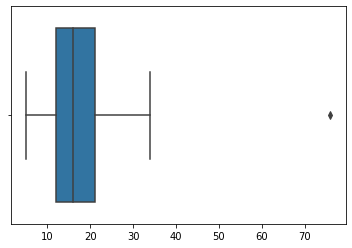

In [21]:
lens=[]
for tweet in train["Tweet"].values:
    tw=cleaner(tweet)[1]
    lens.append(len(tw))

print ("max len:", max(lens), np.sort(lens))
sns.boxplot(lens)

In [22]:
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE 

import numpy as np 
import pandas as pd
from collections import Counter 
from bert_serving.client import BertClient

bc = BertClient()  

data_bas=[]
for tweet in train["Tweet"].values:
    h=cleaner(tweet)[0]
    vector=bc.encode([h])[0]
    data_bas.append(vector)

/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=34" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


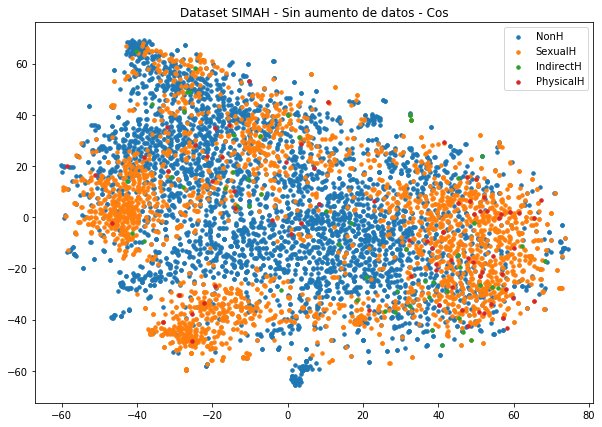

In [23]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas)    
plt.figure(figsize=(10,7))
for key in keys:
    mask = train["Label"]==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset SIMAH - Sin aumento de datos - Cos")
plt.show()

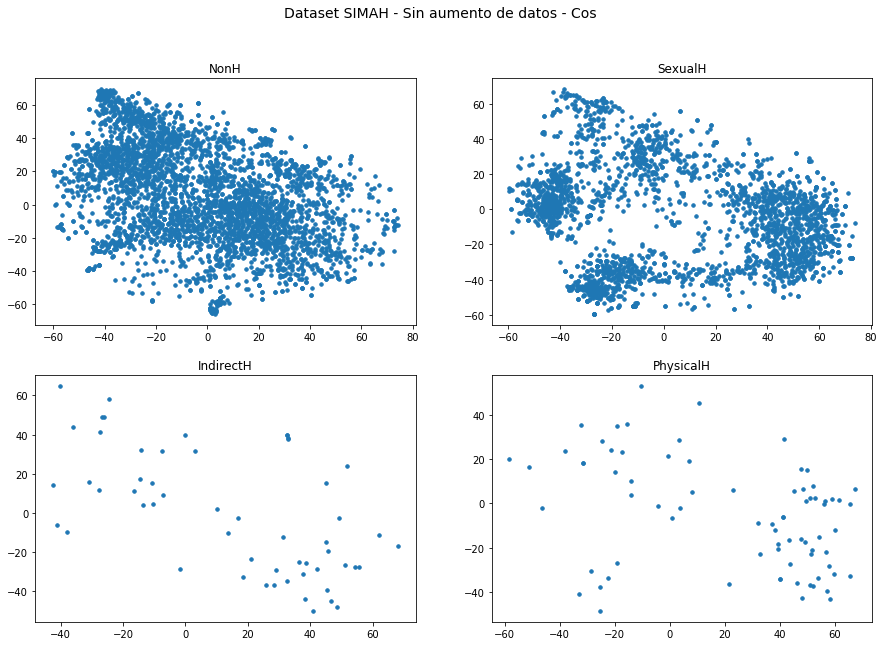

In [24]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    mask = train["Label"]==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))

fig.suptitle("Dataset SIMAH - Sin aumento de datos - Cos", fontsize=14)
plt.show()

# Generación Varias

In [25]:
prob= 0.15
topn = 1

aum_weight=det_samples(train['Label'], dict_cl)#, c_weights={"support":1, "questioning":2, "denying":2})
print ("--------------------------------------------------------")
print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
print ("--------------------------------------------------------") 
print (aum_weight)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------
{'SexualH': 1079, 'NonH': 0, 'PhysicalH': 3585, 'IndirectH': 3606}


### Sujeto a clase no ponderando target

In [26]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 1079 ejemplos para SexualH
Consultando por la clase SexualH
Entrega label 3
Original: pic  	Reemplazo:  [('college', 1.2861084938049316)]
Original: nude  	Reemplazo:  [('awkward', 0.981960654258728)]
Sentencia original:
['pic' 'mexican' 'school' 'girl' 'naked' 'melanie' 'safka' 'fake' 'nude'
 'photos' 'hardcore' 'slut' 'movies' 'alicia' 'moore' 'porn' 'star' 'toon'
 'love']
Sentencia final: 3
['college', 'mexican', 'school', 'girl', 'naked', 'melanie', 'safka', 'fake', 'awkward', 'photos', 'hardcore', 'slut', 'movies', 'alicia', 'moore', 'porn', 'star', 'toon', 'love']


Original: quarterback  	Reemplazo:  [('shitty', 0.5191460251808167)]
Sentencia original:
['girl' 'dirty' 'quarterback' 'latino' 'pokemon' 'young' 'handjob'
 'kissing' 'gangbang' 'w' 'x89' 't' 'co' 'wrm4xo00vj']
Sentencia final: 3
['girl', 'dirty', 'shitty', 'latino', 'pokemon', 'young', 'handjob', 'kissing', 'gangbang', 'w', 'x89', 't', 'co', 'wrm4xo00vj']


Original: gonna  	Reemplazo:  [('wanna', 1.028010

Original: t  	Reemplazo:  [('re', 1.090050458908081)]
Sentencia original:
['you' 're' 'bitch' 'x89' 'slut' 'better' 'too' 't' 'co' 'rti1vp1xed']
Sentencia final: 3
['you', 're', 'bitch', 'x89', 'slut', 'better', 'too', 're', 'co', 'rti1vp1xed']


Original: memory  	Reemplazo:  [('repetitive', 0.4801647365093231)]
Original: t  	Reemplazo:  [('wasn', 0.8504959344863892)]
Sentencia original:
['inmycudizone' 'people' 'short' 'memory' 'loss' 'steffy' 'slut' 'brooke'
 'hogan' 'isn' 'x89' 't' 'queen' 'of' 'x89']
Sentencia final: 3
['inmycudizone', 'people', 'short', 'repetitive', 'loss', 'steffy', 'slut', 'brooke', 'hogan', 'isn', 'x89', 'wasn', 'queen', 'of', 'x89']


Original: century  	Reemplazo:  [('year', 0.574800431728363)]
Sentencia original:
['hell' 'bitch' 'flocka' 'month' 'century' 'i' 'x89' 't' 'co' 'aangtag4lb']
Sentencia final: 3
['hell', 'bitch', 'flocka', 'month', 'year', 'i', 'x89', 't', 'co', 'aangtag4lb']


Original: rt  	Reemplazo:  [('bt', 1.1846352815628052)]
Sentencia or

Original: free  	Reemplazo:  [('bad', 0.49720171093940735)]
Sentencia original:
['rt' 'amberca10937197' 'wanna' 'meet' 'a' 'really' 'sexy' 'bitch' 'for'
 'a' 'good' 'evening' 'free' 'signup' 'porn' 'dick' 'webca']
Sentencia final: 3
['rt', 'amberca10937197', 'wanna', 'meet', 'a', 'really', 'sexy', 'bitch', 'for', 'a', 'good', 'evening', 'bad', 'signup', 'porn', 'dick', 'webca']


Original: virgin  	Reemplazo:  [('humiliation', 0.9746602177619934)]
Sentencia original:
['rt' 'romyboekman' 'people' 'like' 'to' 'virgin' 'shame' 'just' 'as'
 'much' 'as' 'they' 'do' 'slut' 'shame' 'girls' 'can' 't' 'win' 'either'
 'way']
Sentencia final: 3
['rt', 'romyboekman', 'people', 'like', 'to', 'humiliation', 'shame', 'just', 'as', 'much', 'as', 'they', 'do', 'slut', 'shame', 'girls', 'can', 't', 'win', 'either', 'way']


Original: please  	Reemplazo:  [('left', 1.2572954893112183)]
Sentencia original:
['if' 'you' 'are' 'insulted' 'by' 'me' 'calling' 'you' 'bitch' 'slut'
 'hoe' 'or' 'any' 'term' 'like

Original: rapper  	Reemplazo:  [('suck', 0.5440453886985779)]
Sentencia original:
['what' 'kinda' 'skeet' 'bitch' 'every' 'rapper' 'sucked' 'every' 'rapper'
 'dick' 't' 'co' 'av0uccxdsn']
Sentencia final: 3
['what', 'kinda', 'skeet', 'shitty', 'every', 'rapper', 'sucked', 'every', 'suck', 'dick', 't', 'co', 'av0uccxdsn']


Original: don  	Reemplazo:  [('didn', 1.9821388721466064)]
Original: t  	Reemplazo:  [('didn', 1.5681174993515015)]
Sentencia original:
['don' 't' 'slanderer' 'worthless' 'guts' 'ya' 'slut']
Sentencia final: 3
['didn', 'didn', 'slanderer', 'worthless', 'guts', 'ya', 'slut']


Original: ass  	Reemplazo:  [('app', 1.9935719966888428)]
Original: amp  	Reemplazo:  [('butt', 1.7763422727584839)]
Sentencia original:
['rt' 'elizaporn' 'wish' 'you' 'can' 'cumshot' 'on' 'her' 'ass' 'retweet'
 'amp' 'like' 'to' 'see' 'more' 'full' 'videos' 'contact' 'me']
Sentencia final: 3
['rt', 'elizaporn', 'wish', 'you', 'can', 'cumshot', 'on', 'her', 'app', 'retweet', 'butt', 'like', 'to'

Original: s  	Reemplazo:  [('insert', 0.5227243900299072)]
Sentencia original:
['seeing' 'a' 'lot' 'of' 'cool' 'account' 'names' 'today' 'that' 'are'
 'fashion' 'label' 'sex' 'toy' 'whore' 'slut' 'for' 'example' 'dior' 's'
 'butt' 'plug']
Sentencia final: 3
['seeing', 'a', 'cold', 'of', 'cool', 'account', 'names', 'today', 'that', 'are', 'fashion', 'label', 'sex', 'toy', 'whore', 'slut', 'for', 'example', 'dior', 'insert', 'butt', 'plug']


Original: don  	Reemplazo:  [('asshole', 0.3618565499782562)]
Original: get  	Reemplazo:  [('realize', 0.8052155375480652)]
Original: family  	Reemplazo:  [('group', 2.0919151306152344)]
Original: family  	Reemplazo:  [('life', 1.2811000347137451)]
Sentencia original:
['no' 'you' 'stupid' 'dumb' 'clueless' 'bitch' 'you' 'don' 't' 'get' 'to'
 'determine' 'who' 'is' 'family' 'and' 'who' 'is' 'not' 'family' 'fuck'
 'off' 'you' 'dumb' 'slut']
Sentencia final: 3
['no', 'you', 'stupid', 'dumb', 'clueless', 'bitch', 'you', 'asshole', 't', 'realize', 'to', 

Original: t  	Reemplazo:  [('wouldn', 1.2321566343307495)]
Sentencia original:
['nude' 'xxx' 'nboobs' 'underage' 'lesbian' 'pussy' 'littletits' 'fuckme'
 'tradenudes' 'girls' 'nkik' 'sexyme' 'cumwhore' 'horny' 'x89' 't' 'co'
 'v1dtaqqabq']
Sentencia final: 3
['nude', 'xxx', 'nboobs', 'underage', 'lesbian', 'pussy', 'littletits', 'fuckme', 'tradenudes', 'girls', 'nkik', 'sexyme', 'cumwhore', 'horny', 'x89', 'wouldn', 'co', 'v1dtaqqabq']


Original: i  	Reemplazo:  [('group', 1.2134766578674316)]
Sentencia original:
['cruelboythesis' 'i' 'm' 'always' 'a' 'slut' 'for' 'fluff' 'kris' 'i'
 'support' 'this']
Sentencia final: 3
['cruelboythesis', 'i', 'm', 'always', 'a', 'slut', 'for', 'fluff', 'kris', 'group', 'support', 'this']


Original: angel  	Reemplazo:  [('witch', 0.858842670917511)]
Sentencia original:
['amabellerxse' 'wanna' 'zodiac' 'sign' 'i' 'x89' 'm' 'angel' 'bitch'
 'moon' 'rising']
Sentencia final: 3
['amabellerxse', 'wanna', 'zodiac', 'sign', 'i', 'x89', 'm', 'witch', 'bitch'

Original: hd  	Reemplazo:  [('man', 1.3954730033874512)]
Sentencia original:
['rt' 'linda' 'green3' 'fucking' 'my' 'wife' 'fuck' 'my' 'ass' 'xxx'
 'forced' 'sex' 'videos' 'xnxx' 'com' 'anulingus' 'xxx' 'p' 'xxx' 'porn'
 'anulingus' 'xxx' 'porno' 'video' 'hd' 'mo']
Sentencia final: 3
['rt', 'linda', 'green3', 'fucking', 'my', 'wife', 'fuck', 'my', 'ass', 'xxx', 'forced', 'sex', 'videos', 'xnxx', 'com', 'anulingus', 'xxx', 'p', 'xxx', 'porn', 'anulingus', 'xxx', 'porno', 'video', 'man', 'mo']


Original: swear  	Reemplazo:  [('head', 1.0461461544036865)]
Original: same  	Reemplazo:  [('stupid', 0.8729110956192017)]
Sentencia original:
['i' 'swear' 'it' 's' 'always' 'the' 'same' 'bitch' 'calling' 'you' 'a'
 'slut' 'or' 'a' 'hoe' 'who' 'change' 'boyfriend' 'every' 'damn' 'week'
 'like' 'they' 're' 'underwear']
Sentencia final: 3
['i', 'head', 'it', 's', 'always', 'the', 'stupid', 'bitch', 'calling', 'you', 'a', 'slut', 'or', 'a', 'hoe', 'who', 'change', 'boyfriend', 'every', 'damn', 'week'

Original: emerald  	Reemplazo:  [('ebony', 0.49746716022491455)]
Original: new  	Reemplazo:  [('noteworthy', 0.3423502445220947)]
Original: posting  	Reemplazo:  [('being', 1.4152499437332153)]
Original: same  	Reemplazo:  [('appalled', 0.4685411751270294)]
Original: shirt  	Reemplazo:  [('pinto', 0.4424325227737427)]
Original: clip  	Reemplazo:  [('sell', 3.0529353618621826)]
Original: yours  	Reemplazo:  [('times', 1.7946763038635254)]
Original: anna  	Reemplazo:  [('seem', 0.6434832215309143)]
Original: kendrick  	Reemplazo:  [('cedric', 0.775320291519165)]
Original: cute  	Reemplazo:  [('teenager', 1.679195761680603)]
Original: girl  	Reemplazo:  [('boy', 0.8499346375465393)]
Original: i  	Reemplazo:  [('right', 2.0671467781066895)]
Original: guys  	Reemplazo:  [('desires', 0.9035587310791016)]
Original: pic  	Reemplazo:  [('wore', 2.0098843574523926)]
Original: cute  	Reemplazo:  [('isn', 1.854696273803711)]
Original: hell  	Reemplazo:  [('devil', 2.214926242828369)]
Original: t  

Original: is  	Reemplazo:  [('has', 1.7787550687789917)]
Original: had  	Reemplazo:  [('was', 1.1732059717178345)]
Original: fuck  	Reemplazo:  [('asshole', 0.9634162187576294)]
Original: oh  	Reemplazo:  [('ah', 0.7775347232818604)]
Original: lesbian  	Reemplazo:  [('general', 1.1533222198486328)]
Original: office  	Reemplazo:  [('pornography', 1.7668429613113403)]
Original: i  	Reemplazo:  [('mine', 0.46113091707229614)]
Original: israel  	Reemplazo:  [('filthy', 1.0354783535003662)]
Original: school  	Reemplazo:  [('brunette', 0.796955943107605)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: have  	Reemplazo:  [('know', 0.5208259224891663)]
Original: is  	Reemplazo:  [('has', 3.321446180343628)]
Original: being  	Reemplazo:  [('having', 0.7526690363883972)]
Original: everybody  	Reemplazo:  [('everyone', 2.1825153827667236)]
Original: amp  	Reemplazo:  [('part', 5.573480129241943)]
Original: front  	Reemplazo:  [('dad', 2.2066266536712646)]
Original: reminds  	Re

Original: is  	Reemplazo:  [('has', 1.236079216003418)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: cam  	Reemplazo:  [('fuck', 0.874028742313385)]
Original: ass  	Reemplazo:  [('asshole', 0.3544153571128845)]
Original: taste  	Reemplazo:  [('time', 1.1953016519546509)]
Original: is  	Reemplazo:  [('has', 0.6477417349815369)]
Original: put  	Reemplazo:  [('set', 1.259106159210205)]
Original: date  	Reemplazo:  [('time', 0.7510178685188293)]
Original: y  	Reemplazo:  [('girl', 0.48333534598350525)]
Original: be  	Reemplazo:  [('go', 2.0227408409118652)]
Original: shame  	Reemplazo:  [('disgrace', 1.4099222421646118)]
Original: response  	Reemplazo:  [('reaction', 1.3423367738723755)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: thing  	Reemplazo:  [('goofy', 0.7053694128990173)]
Original: sexual  	Reemplazo:  [('noteworthy', 0.19285985827445984)]
Original: wants  	Reemplazo:  [('has', 0.7185956239700317)]
Original: shame  	Reemplazo:  [('disgra

Original: bitch  	Reemplazo:  [('asshole', 0.6352174878120422)]
Original: girls  	Reemplazo:  [('kids', 1.048306941986084)]
Original: bitch  	Reemplazo:  [('asshole', 0.8853586912155151)]
Original: favorite  	Reemplazo:  [('wanna', 1.2549412250518799)]
Original: anxiety  	Reemplazo:  [('asshole', 0.7617771029472351)]
Original: babe  	Reemplazo:  [('asshole', 0.5019197463989258)]
Original: fist  	Reemplazo:  [('goddamn', 0.7330672740936279)]
Original: rt  	Reemplazo:  [('absolute', 1.2012892961502075)]
Original: pop  	Reemplazo:  [('rock', 1.2908518314361572)]
Original: rt  	Reemplazo:  [('ic', 1.0787793397903442)]
Original: wearing  	Reemplazo:  [('walking', 1.1514512300491333)]
Original: boyfriend  	Reemplazo:  [('taught', 1.3026788234710693)]
Original: gym  	Reemplazo:  [('dubbed', 0.8241667151451111)]
Original: mate  	Reemplazo:  [('partner', 1.232957124710083)]
Original: gone  	Reemplazo:  [('devastated', 0.7280715107917786)]
Original: people  	Reemplazo:  [('men', 0.74804377555847

Original: bitch  	Reemplazo:  [('didn', 0.46751558780670166)]
Original: co  	Reemplazo:  [('needy', 0.2916508913040161)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: sad  	Reemplazo:  [('wore', 2.084609270095825)]
Original: t  	Reemplazo:  [('girl', 0.31356731057167053)]
Original: want  	Reemplazo:  [('wore', 0.7281944155693054)]
Original: t  	Reemplazo:  [('kylie', 2.1171774864196777)]
Original: bitch  	Reemplazo:  [('telephone', 1.4100037813186646)]
Original: has  	Reemplazo:  [('believes', 0.8079096078872681)]
Original: im  	Reemplazo:  [('camera', 1.121992826461792)]
Original: weekend  	Reemplazo:  [('werewolf', 1.6623802185058594)]
Original: i  	Reemplazo:  [('ma', 0.6943573355674744)]
Original: touch  	Reemplazo:  [('public', 1.2878303527832031)]
Original: everybody  	Reemplazo:  [('everyone', 1.43329918384552)]
Original: diet  	Reemplazo:  [('everyone', 0.9328348636627197)]
Original: swallow  	Reemplazo:  [('filthy', 0.3122034966945648)]
Original: mouth  	Re

Original: asia  	Reemplazo:  [('pornography', 2.3695874214172363)]
Original: t  	Reemplazo:  [('gt', 1.216773509979248)]
Original: stars  	Reemplazo:  [('days', 0.4738585650920868)]
Original: hours  	Reemplazo:  [('months', 2.62929630279541)]
Original: co  	Reemplazo:  [('dino', 0.48868677020072937)]
Original: free  	Reemplazo:  [('real', 0.4273820221424103)]
Original: come  	Reemplazo:  [('go', 1.2450021505355835)]
Original: waiting  	Reemplazo:  [('embracing', 0.20477987825870514)]
Original: sex  	Reemplazo:  [('jogging', 0.19982744753360748)]
Original: gt  	Reemplazo:  [('cleavage', 0.803721010684967)]
Original: is  	Reemplazo:  [('has', 1.3719441890716553)]
Original: email  	Reemplazo:  [('ipad', 0.7902839183807373)]
Original: amp  	Reemplazo:  [('feminism', 0.600954532623291)]
Original: t  	Reemplazo:  [('hindi', 0.5645867586135864)]
Original: english  	Reemplazo:  [('problematic', 0.30300745368003845)]
Original: co  	Reemplazo:  [('anarchy', 0.34562185406684875)]
Original: tried 

Original: hour  	Reemplazo:  [('day', 2.2208213806152344)]
Original: meeting  	Reemplazo:  [('met', 1.2636775970458984)]
Original: night  	Reemplazo:  [('day', 0.34059178829193115)]
Original: fucking  	Reemplazo:  [('freaking', 0.6447323560714722)]
Original: black  	Reemplazo:  [('sarcastic', 0.5899726152420044)]
Original: sweet  	Reemplazo:  [('picture', 0.8566685914993286)]
Original: student  	Reemplazo:  [('school', 1.4444849491119385)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: free  	Reemplazo:  [('large', 0.8399015069007874)]
Original: lesbian  	Reemplazo:  [('bisexual', 0.7549347877502441)]
Original: teens  	Reemplazo:  [('seventies', 0.2804347574710846)]
Original: fuck  	Reemplazo:  [('childish', 0.41666993498802185)]
Original: whore  	Reemplazo:  [('prostitute', 1.2128103971481323)]
Original: girl  	Reemplazo:  [('prostitute', 0.7505000233650208)]
Original: add  	Reemplazo:  [('happen', 2.9560954570770264)]
Original: anal  	Reemplazo:  [('huge', 0.636825

Original: meet  	Reemplazo:  [('met', 0.8358984589576721)]
Original: ass  	Reemplazo:  [('butt', 1.1429797410964966)]
Original: girl  	Reemplazo:  [('prostitute', 0.5209501385688782)]
Original: verify  	Reemplazo:  [('boy', 0.9463335275650024)]
Original: albums  	Reemplazo:  [('positions', 0.5866825580596924)]
Original: i  	Reemplazo:  [('thirsty', 0.7800629734992981)]
Original: whore  	Reemplazo:  [('shitty', 0.42700788378715515)]
Original: im  	Reemplazo:  [('nope', 1.3895998001098633)]
Original: sure  	Reemplazo:  [('dom', 0.774911642074585)]
Original: fuck  	Reemplazo:  [('filthy', 1.6105773448944092)]
Original: ass  	Reemplazo:  [('asshole', 0.526209831237793)]
Original: naughty  	Reemplazo:  [('playful', 0.8661672472953796)]
Original: manage  	Reemplazo:  [('bastard', 1.111975908279419)]
Original: bitch  	Reemplazo:  [('saw', 1.2529971599578857)]
Original: said  	Reemplazo:  [('had', 0.3353141248226166)]
Original: y  	Reemplazo:  [('ow', 0.5983927249908447)]
Original: girl  	Reem

Original: i  	Reemplazo:  [('bit', 0.4400673508644104)]
Original: days  	Reemplazo:  [('weeks', 1.5173606872558594)]
Original: bitch  	Reemplazo:  [('foo', 0.5001587271690369)]
Original: ass  	Reemplazo:  [('asshole', 0.7238407731056213)]
Original: bitch  	Reemplazo:  [('butt', 0.8273493051528931)]
Original: i  	Reemplazo:  [('boy', 0.5046823620796204)]
Original: co  	Reemplazo:  [('asshole', 0.5169435143470764)]
Original: do  	Reemplazo:  [('remove', 0.46535760164260864)]
Original: boys  	Reemplazo:  [('girls', 0.8599901795387268)]
Original: selling  	Reemplazo:  [('kidding', 2.5300633907318115)]
Original: pictures  	Reemplazo:  [('photos', 1.2732503414154053)]
Original: several  	Reemplazo:  [('noteworthy', 0.38643816113471985)]
Original: i  	Reemplazo:  [('left', 1.9556246995925903)]
Original: got  	Reemplazo:  [('had', 1.3575453758239746)]
Original: i  	Reemplazo:  [('girl', 0.5339833498001099)]
Original: pleasure  	Reemplazo:  [('joy', 1.1773507595062256)]
Original: amp  	Reemplaz

Original: bitch  	Reemplazo:  [('bastard', 1.577332615852356)]
Original: number  	Reemplazo:  [('saw', 0.801814079284668)]
Original: today  	Reemplazo:  [('tonight', 0.5797885656356812)]
Original: furry  	Reemplazo:  [('tonight', 1.0855216979980469)]
Original: called  	Reemplazo:  [('labelled', 0.35639646649360657)]
Original: little  	Reemplazo:  [('small', 0.5111498236656189)]
Original: light  	Reemplazo:  [('somebody', 0.3409327268600464)]
Original: cause  	Reemplazo:  [('someone', 0.311836302280426)]
Original: fuck  	Reemplazo:  [('hadn', 3.8475863933563232)]
Original: yo  	Reemplazo:  [('online', 1.2808040380477905)]
Original: internet  	Reemplazo:  [('sound', 1.2092809677124023)]
Original: technology  	Reemplazo:  [('night', 1.2876285314559937)]
Original: trying  	Reemplazo:  [('plunging', 0.3249421715736389)]
Original: heroes  	Reemplazo:  [('calls', 1.5157612562179565)]
Original: amp  	Reemplazo:  [('iv', 1.9269376993179321)]
Original: catholic  	Reemplazo:  [('christian', 1.869

Original: bitch  	Reemplazo:  [('become', 0.7153862714767456)]
Original: dick  	Reemplazo:  [('suck', 0.8021358251571655)]
Original: true  	Reemplazo:  [('real', 0.7716941237449646)]
Original: expert  	Reemplazo:  [('competent', 0.7749862670898438)]
Original: i  	Reemplazo:  [('man', 0.5235857367515564)]
Original: black  	Reemplazo:  [('white', 1.31175696849823)]
Original: number  	Reemplazo:  [('amount', 0.39390990138053894)]
Original: bitch  	Reemplazo:  [('asshole', 1.5948514938354492)]
Original: think  	Reemplazo:  [('decide', 0.8238168358802795)]
Original: t  	Reemplazo:  [('ma', 1.3615864515304565)]
Original: click  	Reemplazo:  [('creamy', 0.8996637463569641)]
Original: are  	Reemplazo:  [('am', 0.4384008049964905)]
Original: y  	Reemplazo:  [('fe', 0.703395664691925)]
Original: jack  	Reemplazo:  [('kill', 0.7579582929611206)]
Original: i  	Reemplazo:  [('bring', 0.7204498648643494)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: talked  	Reemplazo:  [('strip

Original: person  	Reemplazo:  [('call', 0.8950885534286499)]
Original: brunette  	Reemplazo:  [('blonde', 0.7975439429283142)]
# terms modificados promedio 1.7757182576459685 términos por sentencia
Largo de sentencia promedio 17.860982391102873 términos por sentencia
No se generan ejemplos
new_sample shpe (3661, 3)
Resumen de modificaciones: {'NN': 1326, 'VB': 67, 'VBP': 16, 'VBG': 85, 'JJ': 193, 'NNS': 120, 'VBD': 21, 'VBZ': 48, 'VBN': 36, 'JJS': 3, 'JJR': 1}
Este proceso tomó 14.657362222671509 seg


Generando 0 ejemplos para NonH
Consultando por la clase NonH
Entrega label 0
No se generan ejemplos
new_sample shpe (3661, 3)
Resumen de modificaciones: {}
Este proceso tomó 0.43811821937561035 seg


Generando 3585 ejemplos para PhysicalH
Consultando por la clase PhysicalH
Entrega label 2
Original: s  	Reemplazo:  [('re', 0.7521873116493225)]
Sentencia original:
['rt' 'debbied74799118' 'steved4848' 'how' 'dare' 'she' 'honest' 'people'
 'and' 'children' 'were' 'killed' 'in' 'manchester' 

Original: pic  	Reemplazo:  [('told', 0.47206759452819824)]
Original: kill  	Reemplazo:  [('destroy', 1.3133991956710815)]
Original: self  	Reemplazo:  [('life', 0.6738638877868652)]
Sentencia original:
['ok' 'so' 'what' 'you' 'shouldn' 't' 'do' 'is' 'comment' 'on' 'jordyn'
 's' 'pic' 'telling' 'her' 'to' 'kill' 'her' 'self' 'and' 'slut' 'shame'
 'her' 'that' 's' 'just' 'messy']
Sentencia final: 2
['ok', 'so', 'what', 'you', 'shouldn', 't', 'do', 'is', 'comment', 'on', 'jordyn', 's', 'told', 'telling', 'her', 'to', 'destroy', 'her', 'life', 'and', 'slut', 'shame', 'her', 'that', 's', 'just', 'messy']


Original: rt  	Reemplazo:  [('time', 3.514395236968994)]
Original: murderer  	Reemplazo:  [('didn', 1.8304606676101685)]
Sentencia original:
['rt' 'talbertswan' 'the' 'mother' 'of' 'jazminebarnes' 'her' 'number'
 'yr' 'old' 'daughter' 'who' 'was' 'shot' 'amp' 'killed' 'by' 'a' 'white'
 'supremacist' 'the' 'murderer' 'pulled' 'up' 'i']
Sentencia final: 2
['time', 'talbertswan', 'the', 'mo

Original: has  	Reemplazo:  [('is', 0.7291868329048157)]
Original: deal  	Reemplazo:  [('hasn', 0.7011682987213135)]
Sentencia original:
['trying' 'to' 'defend' 'this' 'piece' 'of' 'shit' 'father' 'and'
 'husband' 'for' 'rape' 'a' 'child' 'she' 'has' 'to' 'deal' 'with' 'all'
 'ages' 'calling' 'he']
Sentencia final: 2
['trying', 'to', 'defend', 'this', 'piece', 'of', 'shit', 'father', 'and', 'husband', 'for', 'rape', 'a', 'child', 'she', 'is', 'to', 'hasn', 'with', 'all', 'ages', 'calling', 'he']


Original: nails  	Reemplazo:  [('guys', 1.1124285459518433)]
Sentencia original:
['how' 'do' 'you' 'do' 'anything' 'with' 'those' 'long' 'nails' 'okay'
 'it' 's' 'not' 'that' 'difficult' 'amp' 'stop' 'being' 'overdramatic'
 'with' 'your' 'stubby' 'nails' 'self']
Sentencia final: 2
['how', 'do', 'you', 'do', 'anything', 'with', 'those', 'long', 'guys', 'okay', 'it', 's', 'not', 'that', 'difficult', 'amp', 'stop', 'being', 'overdramatic', 'with', 'your', 'stubby', 'nails', 'self']


Original: s

Original: sex  	Reemplazo:  [('shit', 1.1952215433120728)]
Sentencia original:
['rt' 'sherayeee' 'fuck' 'sex' 'can' 'we' 'go' 'beat' 'up' 'your' 'ex'
 'ion' 'like' 'the' 'way' 'she' 'treated' 'you']
Sentencia final: 2
['rt', 'sherayeee', 'porn', 'shit', 'can', 'we', 'go', 'beat', 'up', 'your', 'ex', 'ion', 'like', 'the', 'way', 'she', 'treated', 'you']


Original: indian  	Reemplazo:  [('lesbian', 0.5191156268119812)]
Original: pussy  	Reemplazo:  [('muslim', 0.6930209994316101)]
Original: co  	Reemplazo:  [('re', 1.115541696548462)]
Sentencia original:
['deepthroat' 'cumshot' 'perfect' 'boobs' 'jewish' 'indian' 'pussy'
 'naked' 'lesbian' 'japanese' 'beaut' 'x89' 't' 'co' 'gfwxstn2fk']
Sentencia final: 2
['deepthroat', 'cumshot', 'perfect', 'boobs', 'jewish', 'lesbian', 'muslim', 'naked', 'lesbian', 'japanese', 'beaut', 'x89', 't', 're', 'gfwxstn2fk']


Original: manchester  	Reemplazo:  [('kill', 1.431397557258606)]
Sentencia original:
['rt' 'debbied74799118' 'steved4848' 'how' 'dare'

Original: ok  	Reemplazo:  [('okay', 3.191810369491577)]
Original: shouldn  	Reemplazo:  [('didn', 1.196096658706665)]
Original: is  	Reemplazo:  [('has', 0.4957520663738251)]
Sentencia original:
['ok' 'so' 'what' 'you' 'shouldn' 't' 'do' 'is' 'comment' 'on' 'jordyn'
 's' 'pic' 'telling' 'her' 'to' 'kill' 'her' 'self' 'and' 'slut' 'shame'
 'her' 'that' 's' 'just' 'messy']
Sentencia final: 2
['okay', 'so', 'what', 'you', 'didn', 't', 'do', 'has', 'comment', 'on', 'jordyn', 's', 'pic', 'telling', 'her', 'to', 'kill', 'her', 'self', 'and', 'slut', 'shame', 'her', 'that', 's', 'just', 'messy']


Original: number  	Reemplazo:  [('past', 1.1258758306503296)]
Sentencia original:
['rt' 'talbertswan' 'the' 'mother' 'of' 'jazminebarnes' 'her' 'number'
 'yr' 'old' 'daughter' 'who' 'was' 'shot' 'amp' 'killed' 'by' 'a' 'white'
 'supremacist' 'the' 'murderer' 'pulled' 'up' 'i']
Sentencia final: 2
['rt', 'talbertswan', 'the', 'mother', 'of', 'jazminebarnes', 'her', 'past', 'yr', 'old', 'daughter', 'w

Original: try  	Reemplazo:  [('nah', 0.7737909555435181)]
Original: shame  	Reemplazo:  [('murderer', 0.8307987451553345)]
Sentencia original:
['rt' 'charlynch' 'bella' 'what' 'i' 'don' 't' 'get' 'is' 'how' 'y' 'all'
 'try' 'to' 'drag' 'becky' 'for' 'body' 'shame' 'charlotte' 'when' 'she'
 'didn' 't' 'but' 'laugh' 'at' 'a' 'fan' 'that']
Sentencia final: 2
['rt', 'charlynch', 'ma', 'what', 'i', 'don', 't', 'be', 'is', 'how', 'y', 'all', 'nah', 'to', 'drag', 'becky', 'for', 'body', 'murderer', 'charlotte', 'when', 'she', 'didn', 't', 'but', 'laugh', 'at', 'a', 'fan', 'that']


Original: child  	Reemplazo:  [('baby', 2.4035911560058594)]
Sentencia original:
['trying' 'to' 'defend' 'this' 'piece' 'of' 'shit' 'father' 'and'
 'husband' 'for' 'rape' 'a' 'child' 'she' 'has' 'to' 'deal' 'with' 'all'
 'ages' 'calling' 'he']
Sentencia final: 2
['trying', 'to', 'defend', 'this', 'piece', 'of', 'shit', 'father', 'and', 'husband', 'for', 'rape', 'a', 'baby', 'she', 'has', 'to', 'deal', 'with', 'all'

Original: calling  	Reemplazo:  [('talking', 1.1759241819381714)]
Original: addicted  	Reemplazo:  [('called', 1.2962629795074463)]
Sentencia original:
['bbadicali' 'sarcasticfem23' 'msvanillarose' 'facebook' 'habitually'
 'harass' 'calling' 'addicted' 'druggy' 'hooker' 'for' 'x89']
Sentencia final: 2
['bbadicali', 'sarcasticfem23', 'msvanillarose', 'facebook', 'habitually', 'harass', 'talking', 'called', 'druggy', 'hooker', 'for', 'x89']


Original: servant  	Reemplazo:  [('chopped', 0.3577980399131775)]
Original: m  	Reemplazo:  [('minor', 0.7485855221748352)]
Sentencia original:
['the' 'woman' 'brutally' 'tortured' 'minor' 'servant' 'starved' 'major'
 'ammara' 'm' 'x89' 't' 'co' 'yj96d2xgrp']
Sentencia final: 2
['the', 'woman', 'brutally', 'tortured', 'minor', 'chopped', 'starved', 'major', 'ammara', 'minor', 'x89', 't', 'co', 'yj96d2xgrp']


Original: get  	Reemplazo:  [('be', 0.31953009963035583)]
Original: laugh  	Reemplazo:  [('nothing', 1.1931191682815552)]
Sentencia original:


Original: shame  	Reemplazo:  [('didn', 0.8949196338653564)]
Sentencia original:
['repeat' 'after' 'me' 'no' 'any' 'girl' 'of' 'any' 'cast' 'community'
 'or' 'country' 'deserve' 'rape' 'threats' 'or' 'slut' 'shame' 'doesn' 't'
 'matter']
Sentencia final: 2
['repeat', 'after', 'me', 'no', 'any', 'girl', 'of', 'any', 'cast', 'community', 'or', 'country', 'deserve', 'rape', 'threats', 'or', 'slut', 'didn', 'doesn', 't', 'matter']


Original: thing  	Reemplazo:  [('stuff', 1.173008918762207)]
Sentencia original:
['this' 'nigga' 'said' 'the' 'wildest' 'thing' 'thatt' 'ever' 'happened'
 'to' 'him' 'in' 'the' 'bedroom' 'was' 'his' 'girl' 'ask' 'for' 'him' 'to'
 'kall' 'her' 'a']
Sentencia final: 2
['this', 'nigga', 'said', 'the', 'wildest', 'stuff', 'thatt', 'ever', 'happened', 'to', 'him', 'in', 'the', 'bedroom', 'was', 'his', 'girl', 'ask', 'for', 'him', 'to', 'kall', 'her', 'a']


Original: discussing  	Reemplazo:  [('choking', 0.7741981744766235)]
Original: state  	Reemplazo:  [('jewish',

Original: herself  	Reemplazo:  [('destroy', 0.8072553873062134)]
Original: find  	Reemplazo:  [('have', 0.6982098817825317)]
Sentencia original:
['idk' 'which' 'fugly' 'slut' 'told' 'shay' 'to' 'kill' 'herself' 'but'
 'if' 'i' 'ever' 'find' 'out' 'istg' 'you' 'll' 'wanna' 'prayyyy']
Sentencia final: 2
['idk', 'which', 'fugly', 'slut', 'told', 'shay', 'to', 'kill', 'destroy', 'but', 'if', 'i', 'ever', 'have', 'out', 'istg', 'you', 'll', 'wanna', 'prayyyy']


Original: number  	Reemplazo:  [('day', 1.2041348218917847)]
Sentencia original:
['if' 'a' 'girl' 'hasn' 't' 'responded' 'to' 'your' 'number' 'snapchats'
 'in' 'number' 'hours' 'you' 're' 'legally' 'obliged' 'to' 'call' 'her'
 'a' 'fat' 'slut']
Sentencia final: 2
['if', 'a', 'girl', 'hasn', 't', 'responded', 'to', 'your', 'number', 'snapchats', 'in', 'day', 'hours', 'you', 're', 'legally', 'obliged', 'to', 'call', 'her', 'a', 'fat', 'slut']


Original: same  	Reemplazo:  [('open', 0.7243261933326721)]
Sentencia original:
['sherates

Original: free  	Reemplazo:  [('young', 0.7384451627731323)]
Original: porn  	Reemplazo:  [('school', 0.46986621618270874)]
Original: guys  	Reemplazo:  [('girls', 1.6221965551376343)]
Original: abs  	Reemplazo:  [('girls', 0.5270363092422485)]
Original: se  	Reemplazo:  [('body', 0.4579819142818451)]
Original: innocent  	Reemplazo:  [('whore', 0.6089456677436829)]
Original: girl  	Reemplazo:  [('juicy', 0.40235763788223267)]
Original: little  	Reemplazo:  [('big', 2.0971736907958984)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: herself  	Reemplazo:  [('destroy', 1.3369485139846802)]
Original: had  	Reemplazo:  [('got', 0.7674158811569214)]
Original: pussy  	Reemplazo:  [('fuck', 1.2576406002044678)]
Original: boy  	Reemplazo:  [('girl', 0.9039703607559204)]
Original: laugh  	Reemplazo:  [('agree', 0.7827087640762329)]
Original: fan  	Reemplazo:  [('state', 1.1079604625701904)]
Original: shit  	Reemplazo:  [('crap', 0.5246221423149109)]
Original: deal  	Reempl

Original: i  	Reemplazo:  [('community', 1.1370278596878052)]
Original: i  	Reemplazo:  [('tell', 0.6997241973876953)]
Original: got  	Reemplazo:  [('raped', 0.6813996434211731)]
Original: tomorrow  	Reemplazo:  [('homework', 1.3793020248413086)]
Original: cool  	Reemplazo:  [('time', 2.082089900970459)]
Original: date  	Reemplazo:  [('father', 0.7745252251625061)]
Original: lying  	Reemplazo:  [('choking', 0.2585374116897583)]
Original: t  	Reemplazo:  [('time', 2.086322069168091)]
Original: gets  	Reemplazo:  [('wants', 0.49836450815200806)]
Original: fl  	Reemplazo:  [('time', 0.5124332308769226)]
Original: young  	Reemplazo:  [('little', 1.2648847103118896)]
Original: daddy  	Reemplazo:  [('child', 0.7930484414100647)]
Original: virgin  	Reemplazo:  [('porn', 0.6673285365104675)]
Original: adult  	Reemplazo:  [('messy', 0.47436878085136414)]
Original: co  	Reemplazo:  [('re', 0.6831108331680298)]
Original: other  	Reemplazo:  [('good', 0.42768895626068115)]
Original: don  	Reemplaz

Original: happened  	Reemplazo:  [('raped', 3.037978172302246)]
Original: discussing  	Reemplazo:  [('choking', 0.7741981744766235)]
Original: state  	Reemplazo:  [('jewish', 0.4354075491428375)]
Original: i  	Reemplazo:  [('didn', 0.303611159324646)]
Original: katie  	Reemplazo:  [('homework', 0.7069327235221863)]
Original: juicy  	Reemplazo:  [('destroy', 0.8114821314811707)]
Original: sex  	Reemplazo:  [('past', 5.318999290466309)]
Original: rt  	Reemplazo:  [('terrorism', 1.239637851715088)]
Original: campaign  	Reemplazo:  [('homework', 0.8941322565078735)]
Original: i  	Reemplazo:  [('ma', 0.4440080523490906)]
Original: am  	Reemplazo:  [('are', 1.993537425994873)]
Original: telling  	Reemplazo:  [('saying', 0.6344576478004456)]
Original: honest  	Reemplazo:  [('anybody', 0.8406677842140198)]
Original: killed  	Reemplazo:  [('tortured', 0.5730926990509033)]
Original: world  	Reemplazo:  [('body', 1.217573642730713)]
Original: devil  	Reemplazo:  [('state', 1.4477828741073608)]
Or

Original: wrong  	Reemplazo:  [('stupid', 0.5705685615539551)]
Original: co  	Reemplazo:  [('non', 1.1069225072860718)]
Original: good  	Reemplazo:  [('big', 0.42511120438575745)]
Original: daddy  	Reemplazo:  [('child', 2.483610153198242)]
Original: virgin  	Reemplazo:  [('porn', 0.6673285365104675)]
Original: choking  	Reemplazo:  [('disgusting', 0.817118763923645)]
Original: adult  	Reemplazo:  [('muslim', 0.7474759817123413)]
Original: other  	Reemplazo:  [('old', 1.1551377773284912)]
Original: kill  	Reemplazo:  [('destroy', 0.6868782043457031)]
Original: i  	Reemplazo:  [('ma', 0.477350652217865)]
Original: daughters  	Reemplazo:  [('children', 1.437496542930603)]
Original: sucks  	Reemplazo:  [('people', 0.6905653476715088)]
Original: life  	Reemplazo:  [('time', 1.2021385431289673)]
Original: kills  	Reemplazo:  [('videos', 1.4983164072036743)]
Original: rt  	Reemplazo:  [('anwar', 0.6955395340919495)]
Original: lad  	Reemplazo:  [('smack', 1.179883599281311)]
Original: girl  	

Original: t  	Reemplazo:  [('didn', 0.2918705642223358)]
Original: know  	Reemplazo:  [('do', 0.5257602334022522)]
Original: minor  	Reemplazo:  [('beaten', 0.9522574543952942)]
Original: starved  	Reemplazo:  [('addicted', 0.7951537370681763)]
Original: m  	Reemplazo:  [('minor', 0.7616998553276062)]
Original: open  	Reemplazo:  [('horrible', 0.3367759585380554)]
Original: don  	Reemplazo:  [('hu', 0.4227238595485687)]
Original: body  	Reemplazo:  [('gonna', 1.1547164916992188)]
Original: laugh  	Reemplazo:  [('name', 1.9766815900802612)]
Original: x  	Reemplazo:  [('throat', 1.7381685972213745)]
Original: girls  	Reemplazo:  [('daughters', 0.5306279063224792)]
Original: jax  	Reemplazo:  [('bitch', 0.7840616106987)]
Original: fuck  	Reemplazo:  [('deserve', 0.8989760279655457)]
Original: james  	Reemplazo:  [('sons', 2.1715891361236572)]
Original: don  	Reemplazo:  [('state', 0.7255926728248596)]
Original: love  	Reemplazo:  [('rt', 0.529297947883606)]
Original: girl  	Reemplazo:  [(

Original: devil  	Reemplazo:  [('look', 1.269430160522461)]
Original: free  	Reemplazo:  [('young', 1.1971136331558228)]
Original: porn  	Reemplazo:  [('useless', 0.2686861753463745)]
Original: wanna  	Reemplazo:  [('gonna', 2.4107625484466553)]
Original: fuck  	Reemplazo:  [('time', 1.8167071342468262)]
Original: y  	Reemplazo:  [('yo', 0.4504109025001526)]
Original: are  	Reemplazo:  [('am', 0.4725692868232727)]
Original: girl  	Reemplazo:  [('call', 2.0812666416168213)]
Original: bella  	Reemplazo:  [('kendrick', 0.7628602981567383)]
Original: t  	Reemplazo:  [('look', 0.2647727429866791)]
Original: father  	Reemplazo:  [('mother', 0.5902845859527588)]
Original: nails  	Reemplazo:  [('bruises', 0.7140795588493347)]
Original: call  	Reemplazo:  [('case', 1.8278183937072754)]
Original: sl  	Reemplazo:  [('messy', 0.6311250329017639)]
Original: bet  	Reemplazo:  [('anwar', 0.49005529284477234)]
Original: i  	Reemplazo:  [('call', 0.25297921895980835)]
Original: is  	Reemplazo:  [('has'

Original: ur  	Reemplazo:  [('nah', 0.8161135315895081)]
Original: mouth  	Reemplazo:  [('chopped', 0.5533403158187866)]
Original: girl  	Reemplazo:  [('woman', 0.5502499341964722)]
Original: co  	Reemplazo:  [('re', 0.6831108331680298)]
Original: i  	Reemplazo:  [('day', 1.8961656093597412)]
Original: guy  	Reemplazo:  [('person', 0.7177026867866516)]
Original: line  	Reemplazo:  [('state', 1.1001629829406738)]
Original: number  	Reemplazo:  [('way', 1.399557113647461)]
Original: have  	Reemplazo:  [('know', 0.4457499384880066)]
Original: i  	Reemplazo:  [('pic', 0.4610442817211151)]
Original: makes  	Reemplazo:  [('has', 2.404935836791992)]
Original: gay  	Reemplazo:  [('girl', 0.8018034100532532)]
Original: starts  	Reemplazo:  [('things', 0.4037701189517975)]
Original: shit  	Reemplazo:  [('crap', 0.4061409831047058)]
Original: thing  	Reemplazo:  [('crap', 0.6362415552139282)]
Original: co  	Reemplazo:  [('re', 0.7181537747383118)]
Original: please  	Reemplazo:  [('time', 5.881644

Original: has  	Reemplazo:  [('is', 0.7654200792312622)]
Original: nails  	Reemplazo:  [('guys', 1.1124285459518433)]
Original: stop  	Reemplazo:  [('ok', 0.4429153800010681)]
Original: disgusting  	Reemplazo:  [('devastating', 1.2981923818588257)]
Original: stern  	Reemplazo:  [('grave', 1.0842595100402832)]
Original: strict  	Reemplazo:  [('tight', 0.8322290778160095)]
Original: i  	Reemplazo:  [('wish', 1.160672664642334)]
Original: i  	Reemplazo:  [('today', 1.8616420030593872)]
Original: having  	Reemplazo:  [('talking', 0.6498146653175354)]
Original: red  	Reemplazo:  [('black', 1.1418648958206177)]
Original: personal  	Reemplazo:  [('young', 1.8119127750396729)]
Original: nobody  	Reemplazo:  [('everybody', 0.3252030313014984)]
Original: most  	Reemplazo:  [('least', 0.7334283590316772)]
Original: be  	Reemplazo:  [('see', 1.2102162837982178)]
Original: face  	Reemplazo:  [('person', 0.2955554127693176)]
Original: thing  	Reemplazo:  [('way', 3.0376296043395996)]
Original: bedro

Original: girl  	Reemplazo:  [('woman', 0.8785957098007202)]
Original: starved  	Reemplazo:  [('addicted', 0.7951537370681763)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: responded  	Reemplazo:  [('slapped', 0.9754206538200378)]
Original: number  	Reemplazo:  [('name', 1.1648993492126465)]
Original: call  	Reemplazo:  [('ask', 0.7884722352027893)]
Original: have  	Reemplazo:  [('be', 0.7889379858970642)]
Original: type  	Reemplazo:  [('girl', 0.7862215638160706)]
Original: girl  	Reemplazo:  [('boy', 1.4594110250473022)]
Original: ava  	Reemplazo:  [('look', 0.4377754330635071)]
Original: oh  	Reemplazo:  [('nah', 0.4610756039619446)]
Original: ok  	Reemplazo:  [('okay', 1.3821014165878296)]
Original: today  	Reemplazo:  [('gonna', 3.0445759296417236)]
Original: starts  	Reemplazo:  [('things', 0.39713582396507263)]
Original: t  	Reemplazo:  [('chopped', 0.5156189203262329)]
Original: co  	Reemplazo:  [('chopped', 0.4773605465888977)]
Original: kill  	Reempla

Original: do  	Reemplazo:  [('have', 0.832611083984375)]
Original: idea  	Reemplazo:  [('gonna', 1.481404185295105)]
Original: woman  	Reemplazo:  [('girl', 0.5779426693916321)]
Original: disgusting  	Reemplazo:  [('choking', 0.8432144522666931)]
Original: bet  	Reemplazo:  [('anwar', 0.7077293395996094)]
Original: looking  	Reemplazo:  [('gaping', 0.8897833228111267)]
Original: life  	Reemplazo:  [('ain', 0.7108719944953918)]
Original: nobody  	Reemplazo:  [('everybody', 0.5645810961723328)]
Original: likes  	Reemplazo:  [('deserves', 0.7928422689437866)]
Original: ll  	Reemplazo:  [('sl', 0.4442165195941925)]
Original: everybody  	Reemplazo:  [('nobody', 0.8703596591949463)]
Original: threats  	Reemplazo:  [('deserves', 1.8189893960952759)]
Original: t  	Reemplazo:  [('didn', 0.4918018877506256)]
Original: be  	Reemplazo:  [('have', 0.7747460007667542)]
Original: rt  	Reemplazo:  [('chopped', 0.7444428205490112)]
Original: katie  	Reemplazo:  [('homework', 0.7069327235221863)]
Origin

Original: t  	Reemplazo:  [('re', 0.8221790790557861)]
Original: girls  	Reemplazo:  [('women', 1.3522956371307373)]
Original: t  	Reemplazo:  [('nobody', 1.5220094919204712)]
Original: ok  	Reemplazo:  [('okay', 1.298278570175171)]
Original: t  	Reemplazo:  [('time', 1.2007300853729248)]
Original: s  	Reemplazo:  [('told', 0.4751949906349182)]
Original: shame  	Reemplazo:  [('pitch', 1.9571813344955444)]
Original: shit  	Reemplazo:  [('crap', 0.893123984336853)]
Original: bitch  	Reemplazo:  [('gonna', 2.3296775817871094)]
Original: fuck  	Reemplazo:  [('past', 2.965573787689209)]
Original: death  	Reemplazo:  [('murderer', 0.4377151131629944)]
Original: deserves  	Reemplazo:  [('rubs', 0.8264827132225037)]
Original: sex  	Reemplazo:  [('fuck', 1.9429845809936523)]
Original: virgin  	Reemplazo:  [('innocent', 0.7355318665504456)]
Original: hear  	Reemplazo:  [('fuck', 0.48582398891448975)]
Original: re  	Reemplazo:  [('dumb', 0.9174845814704895)]
Original: things  	Reemplazo:  [('peop

Original: meant  	Reemplazo:  [('way', 1.8864548206329346)]
Original: repeat  	Reemplazo:  [('face', 1.1047040224075317)]
Original: said  	Reemplazo:  [('responded', 1.199454665184021)]
Original: girl  	Reemplazo:  [('boy', 0.7953957319259644)]
Original: discussing  	Reemplazo:  [('choking', 0.6312872767448425)]
Original: terrorism  	Reemplazo:  [('hussain', 0.79464191198349)]
Original: islamic  	Reemplazo:  [('aesthetic', 0.7341782450675964)]
Original: white  	Reemplazo:  [('black', 0.8708142042160034)]
Original: men  	Reemplazo:  [('people', 1.1025198698043823)]
Original: agree  	Reemplazo:  [('guess', 3.9220573902130127)]
Original: racist  	Reemplazo:  [('muslim', 1.286401391029358)]
Original: huge  	Reemplazo:  [('major', 1.7733744382858276)]
Original: stuff  	Reemplazo:  [('shit', 1.2313392162322998)]
Original: campaign  	Reemplazo:  [('cast', 1.8921555280685425)]
Original: cock  	Reemplazo:  [('dumb', 1.1958271265029907)]
Original: fucking  	Reemplazo:  [('telling', 1.09087562561

Original: deserves  	Reemplazo:  [('needs', 0.8236837387084961)]
Original: raped  	Reemplazo:  [('slapped', 0.9277077317237854)]
Original: threatened  	Reemplazo:  [('fucked', 0.5898494124412537)]
Original: ass  	Reemplazo:  [('fuck', 0.38560929894447327)]
Original: fucked  	Reemplazo:  [('tortured', 0.7983094453811646)]
Original: virgin  	Reemplazo:  [('line', 2.108529806137085)]
Original: nude  	Reemplazo:  [('homework', 1.1832386255264282)]
Original: is  	Reemplazo:  [('gets', 0.8163443803787231)]
Original: chopped  	Reemplazo:  [('gonna', 1.9713908433914185)]
Original: throat  	Reemplazo:  [('messy', 0.5566592216491699)]
Original: i  	Reemplazo:  [('se', 0.784620463848114)]
Original: o  	Reemplazo:  [('co', 0.6591268181800842)]
Original: oh  	Reemplazo:  [('co', 0.2949237525463104)]
Original: wanting  	Reemplazo:  [('disgusting', 0.884387731552124)]
Original: used  	Reemplazo:  [('called', 1.1581617593765259)]
Original: being  	Reemplazo:  [('having', 0.7570875883102417)]
Original:

Original: flying  	Reemplazo:  [('wanting', 1.1261876821517944)]
Original: fuck  	Reemplazo:  [('shit', 1.3413206338882446)]
Original: agree  	Reemplazo:  [('homework', 1.713332176208496)]
Original: time  	Reemplazo:  [('day', 1.1823562383651733)]
Original: juicy  	Reemplazo:  [('destroy', 0.8114821314811707)]
Original: i  	Reemplazo:  [('destroy', 0.4676295220851898)]
Original: fat  	Reemplazo:  [('pic', 0.8079996109008789)]
Original: people  	Reemplazo:  [('sons', 0.5643488168716431)]
Original: indian  	Reemplazo:  [('islamic', 0.9179593324661255)]
Original: says  	Reemplazo:  [('is', 1.222273349761963)]
Original: d  	Reemplazo:  [('ll', 1.3199257850646973)]
Original: co  	Reemplazo:  [('time', 3.1095070838928223)]
Original: signing  	Reemplazo:  [('want', 0.5826416015625)]
Original: prepare  	Reemplazo:  [('destroy', 0.755132257938385)]
Original: addicted  	Reemplazo:  [('called', 1.2962629795074463)]
Original: hot  	Reemplazo:  [('old', 2.0396907329559326)]
Original: british  	Reem

Original: daddy  	Reemplazo:  [('pussy', 0.5937907695770264)]
Original: picture  	Reemplazo:  [('suicide', 0.5027345418930054)]
Original: family  	Reemplazo:  [('muslim', 0.5457344055175781)]
Original: divine  	Reemplazo:  [('hussain', 0.7222117185592651)]
Original: day  	Reemplazo:  [('time', 0.44683659076690674)]
Original: virgin  	Reemplazo:  [('porn', 0.6673285365104675)]
Original: t  	Reemplazo:  [('messy', 0.5511670112609863)]
Original: i  	Reemplazo:  [('told', 1.0842595100402832)]
Original: stupid  	Reemplazo:  [('old', 1.1564682722091675)]
Original: go  	Reemplazo:  [('get', 0.7770292162895203)]
Original: kill  	Reemplazo:  [('time', 2.276951789855957)]
Original: i  	Reemplazo:  [('thing', 0.26779675483703613)]
Original: chopped  	Reemplazo:  [('mouth', 1.4119199514389038)]
Original: d  	Reemplazo:  [('ll', 1.1490942239761353)]
Original: guess  	Reemplazo:  [('ma', 0.4670513868331909)]
Original: be  	Reemplazo:  [('get', 0.7842951416969299)]
Original: stripped  	Reemplazo:  [(

Original: agree  	Reemplazo:  [('guess', 3.9220573902130127)]
Original: juicy  	Reemplazo:  [('destroy', 0.8114821314811707)]
Original: teen  	Reemplazo:  [('fuck', 0.7660244703292847)]
Original: telling  	Reemplazo:  [('being', 0.7058897614479065)]
Original: husband  	Reemplazo:  [('father', 0.7605898976325989)]
Original: sex  	Reemplazo:  [('shit', 0.8168930411338806)]
Original: treated  	Reemplazo:  [('used', 0.6842548847198486)]
Original: naked  	Reemplazo:  [('islamic', 0.3525191843509674)]
Original: people  	Reemplazo:  [('women', 0.5720783472061157)]
Original: killed  	Reemplazo:  [('tortured', 0.5211238861083984)]
Original: says  	Reemplazo:  [('makes', 2.3667290210723877)]
Original: i  	Reemplazo:  [('se', 0.6797370910644531)]
Original: devil  	Reemplazo:  [('life', 0.6915885210037231)]
Original: prepare  	Reemplazo:  [('destroy', 0.755132257938385)]
Original: co  	Reemplazo:  [('whore', 1.1591618061065674)]
Original: woman  	Reemplazo:  [('girl', 1.465013861656189)]
Original:

Original: kill  	Reemplazo:  [('life', 0.7347937226295471)]
Original: daughters  	Reemplazo:  [('children', 3.449789047241211)]
Original: time  	Reemplazo:  [('day', 0.7085357308387756)]
Original: life  	Reemplazo:  [('body', 3.329716444015503)]
Original: kills  	Reemplazo:  [('videos', 1.4983164072036743)]
Original: devil  	Reemplazo:  [('look', 0.8174188733100891)]
Original: t  	Reemplazo:  [('ll', 1.8545981645584106)]
Original: woman  	Reemplazo:  [('girl', 2.215635299682617)]
Original: se  	Reemplazo:  [('love', 0.4438273310661316)]
Original: kendrick  	Reemplazo:  [('hussain', 0.7567675113677979)]
Original: innocent  	Reemplazo:  [('juicy', 0.8989357948303223)]
Original: girl  	Reemplazo:  [('juicy', 0.4046788811683655)]
Original: s  	Reemplazo:  [('boy', 1.3972649574279785)]
Original: told  	Reemplazo:  [('tell', 2.33937931060791)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: i  	Reemplazo:  [('case', 1.0913782119750977)]
Original: had  	Reemplazo:  [('ra

Original: s  	Reemplazo:  [('re', 0.4231020510196686)]
Original: fair  	Reemplazo:  [('honest', 1.132835865020752)]
Original: world  	Reemplazo:  [('anwar', 0.3108506500720978)]
Original: good  	Reemplazo:  [('difficult', 0.28873947262763977)]
Original: give  	Reemplazo:  [('have', 3.020430088043213)]
Original: tortured  	Reemplazo:  [('starved', 0.7497354745864868)]
Original: starved  	Reemplazo:  [('addicted', 0.7951537370681763)]
Original: m  	Reemplazo:  [('minor', 0.7600005865097046)]
Original: behave  	Reemplazo:  [('murderer', 0.4515627324581146)]
Original: daddy  	Reemplazo:  [('strict', 0.8894191980361938)]
Original: i  	Reemplazo:  [('didn', 0.42192694544792175)]
Original: don  	Reemplazo:  [('hu', 0.2700592279434204)]
Original: body  	Reemplazo:  [('behave', 0.46511322259902954)]
Original: didn  	Reemplazo:  [('doesn', 1.529036283493042)]
Original: being  	Reemplazo:  [('saying', 2.041933059692383)]
Original: bullshit  	Reemplazo:  [('shit', 0.8398654460906982)]
Original: sh

Original: devil  	Reemplazo:  [('look', 0.8174188733100891)]
Original: looking  	Reemplazo:  [('gaping', 0.717805802822113)]
Original: talking  	Reemplazo:  [('being', 0.9585497379302979)]
Original: porn  	Reemplazo:  [('hussain', 0.28809016942977905)]
Original: hot  	Reemplazo:  [('major', 0.6818930506706238)]
Original: woman  	Reemplazo:  [('whore', 1.005847454071045)]
Original: porn  	Reemplazo:  [('love', 2.0236470699310303)]
Original: innocent  	Reemplazo:  [('boy', 1.4338358640670776)]
Original: told  	Reemplazo:  [('tell', 0.7925383448600769)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: picture  	Reemplazo:  [('racist', 0.5299514532089233)]
Original: fat  	Reemplazo:  [('cute', 1.1067769527435303)]
Original: violent  	Reemplazo:  [('racist', 1.257339358329773)]
Original: pussy  	Reemplazo:  [('suicidal', 1.2725856304168701)]
Original: hu  	Reemplazo:  [('gonna', 2.0017776489257812)]
Original: girl  	Reemplazo:  [('boy', 0.8857880234718323)]
Original: i 

Original: being  	Reemplazo:  [('having', 1.175499677658081)]
Original: chopped  	Reemplazo:  [('head', 0.8036264777183533)]
Original: shame  	Reemplazo:  [('drag', 1.0804566144943237)]
Original: fuck  	Reemplazo:  [('yeah', 1.999957799911499)]
Original: james  	Reemplazo:  [('sons', 2.1715891361236572)]
Original: love  	Reemplazo:  [('se', 0.26163291931152344)]
Original: gag  	Reemplazo:  [('name', 0.7378911972045898)]
Original: starved  	Reemplazo:  [('addicted', 0.7951537370681763)]
Original: told  	Reemplazo:  [('hasn', 2.1764116287231445)]
Original: feeling  	Reemplazo:  [('having', 0.9190502166748047)]
Original: girl  	Reemplazo:  [('boy', 0.893265962600708)]
Original: let  	Reemplazo:  [('kitten', 0.3994162380695343)]
Original: add  	Reemplazo:  [('give', 0.4275101125240326)]
Original: horrible  	Reemplazo:  [('other', 0.7102583050727844)]
Original: bitch  	Reemplazo:  [('whore', 1.1807527542114258)]
Original: oh  	Reemplazo:  [('look', 0.7205105423927307)]
Original: i  	Reempla

Original: have  	Reemplazo:  [('get', 1.1750659942626953)]
Original: was  	Reemplazo:  [('were', 0.49886858463287354)]
Original: porn  	Reemplazo:  [('spawn', 0.5117449760437012)]
Original: hot  	Reemplazo:  [('black', 0.4601311683654785)]
Original: bed  	Reemplazo:  [('bedroom', 1.2082313299179077)]
Original: told  	Reemplazo:  [('tell', 1.5058729648590088)]
Original: be  	Reemplazo:  [('have', 1.2823394536972046)]
Original: shit  	Reemplazo:  [('mother', 0.8599244952201843)]
Original: husband  	Reemplazo:  [('mother', 0.6594650745391846)]
Original: rape  	Reemplazo:  [('daughter', 0.9697394967079163)]
Original: self  	Reemplazo:  [('gonna', 1.2189784049987793)]
Original: strict  	Reemplazo:  [('tight', 0.8322290778160095)]
Original: i  	Reemplazo:  [('line', 1.259305715560913)]
Original: m  	Reemplazo:  [('name', 1.14047110080719)]
Original: likes  	Reemplazo:  [('rubs', 0.3383948504924774)]
Original: fat  	Reemplazo:  [('whore', 0.9760175943374634)]
Original: rt  	Reemplazo:  [('amo

Original: twitter  	Reemplazo:  [('re', 0.44311344623565674)]
Original: getting  	Reemplazo:  [('having', 0.8081689476966858)]
Original: dream  	Reemplazo:  [('chop', 0.35292890667915344)]
Original: t  	Reemplazo:  [('didn', 0.4515191912651062)]
Original: m  	Reemplazo:  [('minor', 0.7616998553276062)]
Original: hasn  	Reemplazo:  [('boy', 0.5074868202209473)]
Original: number  	Reemplazo:  [('amount', 0.8118780851364136)]
Original: hours  	Reemplazo:  [('minutes', 0.7707055807113647)]
Original: i  	Reemplazo:  [('head', 2.1587982177734375)]
Original: feeling  	Reemplazo:  [('having', 0.9190502166748047)]
Original: girl  	Reemplazo:  [('boy', 0.8409547805786133)]
Original: add  	Reemplazo:  [('give', 0.28267186880111694)]
Original: i  	Reemplazo:  [('wanna', 0.8198003172874451)]
Original: face  	Reemplazo:  [('head', 1.2529213428497314)]
Original: m  	Reemplazo:  [('re', 1.1076900959014893)]
Original: know  	Reemplazo:  [('see', 0.7720810174942017)]
Original: t  	Reemplazo:  [('didn', 

Original: shame  	Reemplazo:  [('smash', 0.7896469235420227)]
Original: didn  	Reemplazo:  [('doesn', 0.8721593618392944)]
Original: child  	Reemplazo:  [('nude', 0.4994259178638458)]
Original: glasgow  	Reemplazo:  [('look', 1.1144461631774902)]
Original: woman  	Reemplazo:  [('girl', 0.9471555948257446)]
Original: powerful  	Reemplazo:  [('difficult', 0.2948657274246216)]
Original: chop  	Reemplazo:  [('chopped', 1.2675718069076538)]
Original: girls  	Reemplazo:  [('women', 3.4040279388427734)]
Original: red  	Reemplazo:  [('black', 0.7362724542617798)]
Original: call  	Reemplazo:  [('ask', 0.7128866910934448)]
Original: personal  	Reemplazo:  [('jealous', 1.3252925872802734)]
Original: crap  	Reemplazo:  [('shit', 2.3074049949645996)]
Original: case  	Reemplazo:  [('call', 0.6803617477416992)]
Original: rape  	Reemplazo:  [('terrorism', 0.6318909525871277)]
Original: ask  	Reemplazo:  [('time', 1.9120680093765259)]
Original: flying  	Reemplazo:  [('fucking', 0.5077033042907715)]
Ori

Original: t  	Reemplazo:  [('chopped', 0.454891562461853)]
Original: i  	Reemplazo:  [('destroy', 0.5415428280830383)]
Original: kill  	Reemplazo:  [('se', 0.7300894260406494)]
Original: pic  	Reemplazo:  [('tell', 1.5091784000396729)]
Original: shame  	Reemplazo:  [('past', 3.042306661605835)]
Original: old  	Reemplazo:  [('young', 0.7018329501152039)]
Original: i  	Reemplazo:  [('put', 1.0974266529083252)]
Original: go  	Reemplazo:  [('be', 0.5305113196372986)]
Original: bitch  	Reemplazo:  [('gonna', 5.478654861450195)]
Original: co  	Reemplazo:  [('re', 1.1334819793701172)]
Original: minor  	Reemplazo:  [('rape', 1.156816840171814)]
Original: choking  	Reemplazo:  [('disgusting', 0.817118763923645)]
Original: amount  	Reemplazo:  [('chopped', 0.3896138072013855)]
Original: re  	Reemplazo:  [('dumb', 0.844083309173584)]
Original: stupid  	Reemplazo:  [('free', 1.9101152420043945)]
Original: whore  	Reemplazo:  [('bedroom', 3.5212793350219727)]
Original: kill  	Reemplazo:  [('destroy

Original: most  	Reemplazo:  [('least', 0.32813745737075806)]
Original: was  	Reemplazo:  [('were', 0.7699838876724243)]
Original: ask  	Reemplazo:  [('woman', 0.8560993075370789)]
Original: discussing  	Reemplazo:  [('choking', 0.7741981744766235)]
Original: women  	Reemplazo:  [('girls', 1.4455593824386597)]
Original: kill  	Reemplazo:  [('destroy', 0.7904444336891174)]
Original: muslim  	Reemplazo:  [('anwar', 0.3274933993816376)]
Original: t  	Reemplazo:  [('didn', 0.49338841438293457)]
Original: fuck  	Reemplazo:  [('devil', 1.1661370992660522)]
Original: katie  	Reemplazo:  [('homework', 0.5920335054397583)]
Original: build  	Reemplazo:  [('hall', 1.9887667894363403)]
Original: wall  	Reemplazo:  [('hasn', 0.8140941262245178)]
Original: cock  	Reemplazo:  [('porn', 0.520584762096405)]
Original: been  	Reemplazo:  [('punched', 1.8530510663986206)]
Original: fat  	Reemplazo:  [('chopped', 0.5863552689552307)]
Original: nap  	Reemplazo:  [('crap', 1.4237124919891357)]
Original: son 

Original: have  	Reemplazo:  [('do', 2.2200329303741455)]
Original: teen  	Reemplazo:  [('homework', 0.9288225769996643)]
Original: i  	Reemplazo:  [('ma', 0.4317547082901001)]
Original: go  	Reemplazo:  [('get', 1.1561388969421387)]
Original: chopped  	Reemplazo:  [('mouth', 2.271155834197998)]
Original: i  	Reemplazo:  [('wanna', 1.222038984298706)]
Original: m  	Reemplazo:  [('wanna', 0.8322662115097046)]
Original: o  	Reemplazo:  [('life', 0.7111098766326904)]
Original: oh  	Reemplazo:  [('co', 0.29101747274398804)]
Original: daughters  	Reemplazo:  [('children', 1.437496542930603)]
Original: used  	Reemplazo:  [('treated', 0.7229310870170593)]
Original: sucks  	Reemplazo:  [('people', 0.6242413520812988)]
Original: psycho  	Reemplazo:  [('wanna', 1.5272144079208374)]
Original: didn  	Reemplazo:  [('doesn', 2.3507914543151855)]
Original: free  	Reemplazo:  [('lesbian', 1.3470473289489746)]
Original: time  	Reemplazo:  [('juicy', 0.4663306474685669)]
Original: movies  	Reemplazo:  [

Original: know  	Reemplazo:  [('remember', 0.8402007222175598)]
Original: co  	Reemplazo:  [('re', 1.115541696548462)]
Original: daddy  	Reemplazo:  [('child', 2.437969446182251)]
Original: baby  	Reemplazo:  [('cute', 0.81636643409729)]
Original: try  	Reemplazo:  [('rt', 0.46387991309165955)]
Original: body  	Reemplazo:  [('behave', 0.46511322259902954)]
Original: laugh  	Reemplazo:  [('name', 1.9766815900802612)]
Original: fan  	Reemplazo:  [('se', 0.6776140928268433)]
Original: chopped  	Reemplazo:  [('chop', 0.8102044463157654)]
Original: least  	Reemplazo:  [('most', 0.36155369877815247)]
Original: jax  	Reemplazo:  [('bitch', 0.7840616106987)]
Original: fuck  	Reemplazo:  [('homework', 0.7537092566490173)]
Original: love  	Reemplazo:  [('rt', 0.3257042467594147)]
Original: kitten  	Reemplazo:  [('add', 1.7993838787078857)]
Original: tied  	Reemplazo:  [('fucked', 0.5350984334945679)]
Original: ur  	Reemplazo:  [('anna', 0.49609118700027466)]
Original: is  	Reemplazo:  [('has', 0

Original: snap  	Reemplazo:  [('glimpse', 1.4714096784591675)]
Original: didn  	Reemplazo:  [('doesn', 3.8418073654174805)]
Original: porn  	Reemplazo:  [('hussain', 0.28809016942977905)]
Original: girl  	Reemplazo:  [('guy', 0.6755160689353943)]
Original: guys  	Reemplazo:  [('girls', 0.7399376630783081)]
Original: anna  	Reemplazo:  [('prepare', 1.4023423194885254)]
Original: girl  	Reemplazo:  [('whore', 0.3703829348087311)]
Original: dirty  	Reemplazo:  [('bit', 1.9112865924835205)]
Original: i  	Reemplazo:  [('case', 1.1211140155792236)]
Original: find  	Reemplazo:  [('have', 1.2593812942504883)]
Original: ll  	Reemplazo:  [('gonna', 1.0031499862670898)]
Original: rt  	Reemplazo:  [('pic', 0.536540687084198)]
Original: fat  	Reemplazo:  [('drag', 0.8183398842811584)]
Original: are  	Reemplazo:  [('am', 0.6586066484451294)]
Original: slapped  	Reemplazo:  [('did', 1.8318296670913696)]
Original: i  	Reemplazo:  [('hussain', 0.29770588874816895)]
Original: get  	Reemplazo:  [('be', 0

Original: girl  	Reemplazo:  [('call', 0.841092050075531)]
Original: co  	Reemplazo:  [('re', 0.6831108331680298)]
Original: ma  	Reemplazo:  [('pic', 0.7772388458251953)]
Original: t  	Reemplazo:  [('nobody', 0.598015308380127)]
Original: kill  	Reemplazo:  [('se', 0.44648027420043945)]
Original: do  	Reemplazo:  [('be', 0.46463197469711304)]
Original: self  	Reemplazo:  [('face', 1.2028552293777466)]
Original: daughter  	Reemplazo:  [('mother', 1.3835889101028442)]
Original: shot  	Reemplazo:  [('pic', 0.6805722713470459)]
Original: murderer  	Reemplazo:  [('didn', 1.8304606676101685)]
Original: know  	Reemplazo:  [('do', 0.7527533173561096)]
Original: dumb  	Reemplazo:  [('gonna', 2.490023374557495)]
Original: rt  	Reemplazo:  [('ma', 0.7136430144309998)]
Original: do  	Reemplazo:  [('see', 4.536933898925781)]
Original: fuck  	Reemplazo:  [('shit', 1.9606070518493652)]
Original: rt  	Reemplazo:  [('mad', 1.1444551944732666)]
Original: daddy  	Reemplazo:  [('pussy', 0.753377735614776

Original: i  	Reemplazo:  [('destroy', 0.2842535078525543)]
Original: kill  	Reemplazo:  [('time', 1.2694841623306274)]
Original: fake  	Reemplazo:  [('time', 1.2399786710739136)]
Original: bitch  	Reemplazo:  [('ass', 3.0945587158203125)]
Original: cares  	Reemplazo:  [('hopkins', 0.6629640460014343)]
Original: crap  	Reemplazo:  [('shit', 2.3074049949645996)]
Original: mad  	Reemplazo:  [('shit', 0.872960090637207)]
Original: kill  	Reemplazo:  [('destroy', 1.3188179731369019)]
Original: cast  	Reemplazo:  [('chopped', 0.6839118003845215)]
Original: s  	Reemplazo:  [('boy', 0.7915583252906799)]
Original: name  	Reemplazo:  [('world', 1.1586153507232666)]
Original: most  	Reemplazo:  [('least', 0.21992181241512299)]
Original: has  	Reemplazo:  [('is', 0.834469199180603)]
Original: face  	Reemplazo:  [('crotch', 0.26156115531921387)]
Original: discussing  	Reemplazo:  [('fucking', 1.221639633178711)]
Original: terrorism  	Reemplazo:  [('hussain', 0.79464191198349)]
Original: t  	Reempl

Original: punched  	Reemplazo:  [('tortured', 0.7152503132820129)]
Original: girls  	Reemplazo:  [('women', 3.3610100746154785)]
Original: i  	Reemplazo:  [('pic', 0.8855675458908081)]
Original: kill  	Reemplazo:  [('se', 0.5106209516525269)]
Original: telling  	Reemplazo:  [('being', 0.723154604434967)]
Original: messy  	Reemplazo:  [('time', 1.2950518131256104)]
Original: killed  	Reemplazo:  [('saved', 0.8139052987098694)]
Original: i  	Reemplazo:  [('ma', 1.0924307107925415)]
Original: amp  	Reemplazo:  [('gonna', 2.8141562938690186)]
Original: lying  	Reemplazo:  [('choking', 0.3690612316131592)]
Original: family  	Reemplazo:  [('rape', 0.5555105209350586)]
Original: porn  	Reemplazo:  [('please', 1.834169626235962)]
Original: go  	Reemplazo:  [('see', 1.246686339378357)]
Original: kill  	Reemplazo:  [('destroy', 0.47865328192710876)]
Original: i  	Reemplazo:  [('ma', 0.1695520579814911)]
Original: guess  	Reemplazo:  [('ma', 0.1915767788887024)]
Original: be  	Reemplazo:  [('get'

Original: terrorism  	Reemplazo:  [('hussain', 0.79464191198349)]
Original: non  	Reemplazo:  [('terrorism', 1.0424500703811646)]
Original: muslim  	Reemplazo:  [('jewish', 0.7846527099609375)]
Original: katie  	Reemplazo:  [('homework', 0.5920335054397583)]
Original: time  	Reemplazo:  [('day', 1.1823562383651733)]
Original: wall  	Reemplazo:  [('hall', 1.2722467184066772)]
Original: husband  	Reemplazo:  [('call', 1.3338617086410522)]
Original: ion  	Reemplazo:  [('non', 1.1741797924041748)]
Original: treated  	Reemplazo:  [('used', 1.8886252641677856)]
Original: pussy  	Reemplazo:  [('muslim', 0.6385454535484314)]
Original: japanese  	Reemplazo:  [('british', 0.4957658052444458)]
Original: dare  	Reemplazo:  [('gonna', 0.8428174257278442)]
Original: manchester  	Reemplazo:  [('kill', 1.431397557258606)]
Original: s  	Reemplazo:  [('word', 1.1503281593322754)]
Original: fair  	Reemplazo:  [('time', 1.9307323694229126)]
Original: i  	Reemplazo:  [('head', 1.9580683708190918)]
Original

Original: i  	Reemplazo:  [('ma', 0.5203605890274048)]
Original: single  	Reemplazo:  [('stupid', 1.3532626628875732)]
Original: cock  	Reemplazo:  [('father', 1.9143893718719482)]
Original: wrong  	Reemplazo:  [('horrible', 0.45600131154060364)]
Original: t  	Reemplazo:  [('time', 2.1287224292755127)]
Original: family  	Reemplazo:  [('suicidal', 0.5372406840324402)]
Original: sex  	Reemplazo:  [('fuck', 0.44495460391044617)]
Original: have  	Reemplazo:  [('do', 1.29446542263031)]
Original: stupid  	Reemplazo:  [('old', 0.42410317063331604)]
Original: oh  	Reemplazo:  [('nah', 0.1852860450744629)]
Original: guess  	Reemplazo:  [('ma', 0.30038246512413025)]
Original: y  	Reemplazo:  [('crotch', 0.5958285927772522)]
Original: sucks  	Reemplazo:  [('rubs', 0.7754223942756653)]
Original: life  	Reemplazo:  [('time', 3.533498764038086)]
Original: rt  	Reemplazo:  [('murderer', 0.8119718432426453)]
Original: woman  	Reemplazo:  [('whore', 0.6105232238769531)]
Original: having  	Reemplazo:  [

Original: son  	Reemplazo:  [('daughter', 0.7838407754898071)]
Original: husband  	Reemplazo:  [('call', 1.3338617086410522)]
Original: harris  	Reemplazo:  [('twitter', 0.8561351299285889)]
Original: beat  	Reemplazo:  [('life', 0.7243036031723022)]
Original: indian  	Reemplazo:  [('lesbian', 0.37493327260017395)]
Original: were  	Reemplazo:  [('was', 1.2742241621017456)]
Original: fair  	Reemplazo:  [('faithful', 0.6665846705436707)]
Original: t  	Reemplazo:  [('didn', 0.8086559176445007)]
Original: calling  	Reemplazo:  [('talking', 1.1759241819381714)]
Original: open  	Reemplazo:  [('horrible', 0.19022788107395172)]
Original: i  	Reemplazo:  [('didn', 0.47012606263160706)]
Original: is  	Reemplazo:  [('gets', 0.36225682497024536)]
Original: try  	Reemplazo:  [('nah', 0.49397915601730347)]
Original: drag  	Reemplazo:  [('behave', 0.8515180349349976)]
Original: body  	Reemplazo:  [('murderer', 0.5893127918243408)]
Original: co  	Reemplazo:  [('facebook', 0.5225799679756165)]
Original

Original: is  	Reemplazo:  [('has', 1.2113887071609497)]
Original: time  	Reemplazo:  [('cool', 0.6934661865234375)]
Original: woman  	Reemplazo:  [('whore', 0.611345112323761)]
Original: cute  	Reemplazo:  [('boy', 2.3063926696777344)]
Original: s  	Reemplazo:  [('boy', 2.1817660331726074)]
Original: kill  	Reemplazo:  [('destroy', 0.9794957637786865)]
Original: disease  	Reemplazo:  [('type', 1.1691977977752686)]
Original: dog  	Reemplazo:  [('boy', 1.222517490386963)]
Original: rt  	Reemplazo:  [('yo', 0.7307584881782532)]
Original: calling  	Reemplazo:  [('talking', 0.4437391757965088)]
Original: try  	Reemplazo:  [('stop', 0.7497345209121704)]
Original: didn  	Reemplazo:  [('doesn', 0.8721593618392944)]
Original: defend  	Reemplazo:  [('try', 1.4058799743652344)]
Original: has  	Reemplazo:  [('is', 1.139352798461914)]
Original: glasgow  	Reemplazo:  [('look', 1.1144461631774902)]
Original: s  	Reemplazo:  [('word', 1.168173909187317)]
Original: sl  	Reemplazo:  [('messy', 0.631125

Original: way  	Reemplazo:  [('hussain', 0.69344562292099)]
Original: pussy  	Reemplazo:  [('muslim', 0.6385454535484314)]
Original: co  	Reemplazo:  [('re', 1.1291121244430542)]
Original: t  	Reemplazo:  [('love', 1.108038067817688)]
Original: addicted  	Reemplazo:  [('called', 1.2962629795074463)]
Original: hooker  	Reemplazo:  [('whore', 1.3072701692581177)]
Original: british  	Reemplazo:  [('japanese', 2.332357406616211)]
Original: drag  	Reemplazo:  [('jax', 1.1402782201766968)]
Original: laugh  	Reemplazo:  [('th', 0.6886565089225769)]
Original: whole  	Reemplazo:  [('horrible', 0.3849293887615204)]
Original: james  	Reemplazo:  [('videos', 1.286960482597351)]
Original: shame  	Reemplazo:  [('drag', 1.3070451021194458)]
Original: james  	Reemplazo:  [('men', 1.9204736948013306)]
Original: love  	Reemplazo:  [('rt', 0.4633997082710266)]
Original: ass  	Reemplazo:  [('whore', 0.4511655867099762)]
Original: u  	Reemplazo:  [('ur', 0.7123770117759705)]
Original: t  	Reemplazo:  [('re

Original: porn  	Reemplazo:  [('spawn', 0.45544540882110596)]
Original: hot  	Reemplazo:  [('lesbian', 1.24788236618042)]
Original: woman  	Reemplazo:  [('girl', 0.5544717311859131)]
Original: porn  	Reemplazo:  [('doesn', 3.5068869590759277)]
Original: cute  	Reemplazo:  [('boy', 0.937771737575531)]
Original: s  	Reemplazo:  [('boy', 0.8133836388587952)]
Original: told  	Reemplazo:  [('tell', 1.4390183687210083)]
Original: ll  	Reemplazo:  [('gonna', 2.9417316913604736)]
Original: violent  	Reemplazo:  [('racist', 1.257339358329773)]
Original: gonna  	Reemplazo:  [('wanna', 1.0409867763519287)]
Original: i  	Reemplazo:  [('didn', 0.4931308329105377)]
Original: defend  	Reemplazo:  [('try', 1.6150482892990112)]
Original: piece  	Reemplazo:  [('juicy', 0.8275992274284363)]
Original: re  	Reemplazo:  [('chopped', 0.4364393949508667)]
Original: stern  	Reemplazo:  [('grave', 1.0842595100402832)]
Original: i  	Reemplazo:  [('time', 0.6867851614952087)]
Original: needs  	Reemplazo:  [('peop

Original: minor  	Reemplazo:  [('beaten', 0.9522574543952942)]
Original: m  	Reemplazo:  [('minor', 0.7600005865097046)]
Original: herself  	Reemplazo:  [('death', 1.833205223083496)]
Original: ll  	Reemplazo:  [('gonna', 1.0031499862670898)]
Original: hasn  	Reemplazo:  [('doesn', 0.8829081058502197)]
Original: s  	Reemplazo:  [('ll', 1.1365432739257812)]
Original: same  	Reemplazo:  [('old', 0.6971526145935059)]
Original: s  	Reemplazo:  [('ll', 1.244451642036438)]
Original: shouldn  	Reemplazo:  [('hasn', 0.3338555097579956)]
Original: ava  	Reemplazo:  [('crotch', 0.29645928740501404)]
Original: bitch  	Reemplazo:  [('whore', 0.8770787119865417)]
Original: oh  	Reemplazo:  [('look', 0.680533766746521)]
Original: suicide  	Reemplazo:  [('suicidal', 0.5018845200538635)]
Original: girl  	Reemplazo:  [('boy', 1.38921058177948)]
Original: shit  	Reemplazo:  [('crap', 0.3769093453884125)]
Original: ain  	Reemplazo:  [('nobody', 0.8655900359153748)]
Original: s  	Reemplazo:  [('love', 1.9

Original: disgusting  	Reemplazo:  [('telling', 1.7627313137054443)]
Original: needs  	Reemplazo:  [('knew', 3.184410572052002)]
Original: head  	Reemplazo:  [('face', 2.2394187450408936)]
Original: red  	Reemplazo:  [('black', 1.1418648958206177)]
Original: call  	Reemplazo:  [('ll', 2.1795761585235596)]
Original: nobody  	Reemplazo:  [('everybody', 0.3252030313014984)]
Original: rt  	Reemplazo:  [('amount', 0.8263386487960815)]
Original: get  	Reemplazo:  [('find', 0.49781423807144165)]
Original: threats  	Reemplazo:  [('kills', 0.7343382239341736)]
Original: kill  	Reemplazo:  [('destroy', 1.2171847820281982)]
Original: girl  	Reemplazo:  [('woman', 2.140655994415283)]
Original: community  	Reemplazo:  [('state', 1.454525113105774)]
Original: ass  	Reemplazo:  [('mouth', 2.338336706161499)]
Original: butter  	Reemplazo:  [('mouth', 0.49830493330955505)]
Original: state  	Reemplazo:  [('jewish', 0.4354075491428375)]
Original: don  	Reemplazo:  [('didn', 0.280148446559906)]
Original: 

Original: s  	Reemplazo:  [('love', 1.870909333229065)]
Original: t  	Reemplazo:  [('didn', 0.7826663255691528)]
Original: past  	Reemplazo:  [('ex', 1.1529372930526733)]
Original: punch  	Reemplazo:  [('smash', 0.7171461582183838)]
Original: i  	Reemplazo:  [('crotch', 0.3203717768192291)]
Original: makes  	Reemplazo:  [('has', 0.8885269165039062)]
Original: ok  	Reemplazo:  [('okay', 1.1996763944625854)]
Original: hall  	Reemplazo:  [('day', 1.3190289735794067)]
Original: today  	Reemplazo:  [('tomorrow', 0.4601984918117523)]
Original: shit  	Reemplazo:  [('crap', 0.4331751763820648)]
Original: bitch  	Reemplazo:  [('woman', 0.7354724407196045)]
Original: wanna  	Reemplazo:  [('didn', 1.0872502326965332)]
Original: ain  	Reemplazo:  [('nobody', 0.5632525682449341)]
Original: kill  	Reemplazo:  [('death', 0.7501571774482727)]
Original: do  	Reemplazo:  [('be', 0.2960921823978424)]
Original: white  	Reemplazo:  [('red', 2.144582986831665)]
Original: love  	Reemplazo:  [('wanna', 2.0881

Original: needs  	Reemplazo:  [('deserves', 1.1580712795257568)]
Original: i  	Reemplazo:  [('past', 1.8306975364685059)]
Original: having  	Reemplazo:  [('getting', 0.7623395323753357)]
Original: fat  	Reemplazo:  [('whore', 0.5785620212554932)]
Original: everybody  	Reemplazo:  [('anybody', 0.6460949778556824)]
Original: death  	Reemplazo:  [('anybody', 0.3546254634857178)]
Original: person  	Reemplazo:  [('woman', 1.2538059949874878)]
Original: kill  	Reemplazo:  [('destroy', 2.09145450592041)]
Original: repeat  	Reemplazo:  [('face', 1.1047040224075317)]
Original: said  	Reemplazo:  [('responded', 3.5283923149108887)]
Original: was  	Reemplazo:  [('were', 0.737553060054779)]
Original: women  	Reemplazo:  [('men', 1.6549209356307983)]
Original: non  	Reemplazo:  [('jewish', 0.7800702452659607)]
Original: islamic  	Reemplazo:  [('aesthetic', 0.7341782450675964)]
Original: state  	Reemplazo:  [('world', 0.45142391324043274)]
Original: i  	Reemplazo:  [('didn', 0.5980794429779053)]
Ori

Original: amp  	Reemplazo:  [('leftist', 0.3464491665363312)]
Original: change  	Reemplazo:  [('leftist', 0.22303926944732666)]
Sentencia original:
['shessoken' 'rushing' 'morning' 'slipped' 'amp' 'amp' 'change' 'pocket'
 'bitch' 'x89' 'damn' 'sonic' 'good' 'x89']
Sentencia final: 1
['shessoken', 'rushing', 'morning', 'slipped', 'leftist', 'amp', 'leftist', 'pocket', 'bitch', 'x89', 'damn', 'sonic', 'good', 'x89']


Original: women  	Reemplazo:  [('girls', 0.5044329166412354)]
Original: t  	Reemplazo:  [('faulty', 0.46200233697891235)]
Sentencia original:
['rextestarossa' 'she' 'x89' 's' 'reversing' 'shame' 'because' 'women'
 'ha' 'x89' 't' 'co' 'djbhkeyeif']
Sentencia final: 1
['rextestarossa', 'she', 'x89', 's', 'reversing', 'shame', 'because', 'girls', 'ha', 'x89', 'faulty', 'co', 'djbhkeyeif']


Original: don  	Reemplazo:  [('didn', 0.8895663022994995)]
Original: speak  	Reemplazo:  [('think', 0.7115721702575684)]
Original: t  	Reemplazo:  [('rt', 0.7233086824417114)]
Sentencia ori

Original: go  	Reemplazo:  [('be', 0.4238269329071045)]
Sentencia original:
['bakubrows' 'freakedbydubulg' 'saraot5' 'how' 'can' 'u' 'go' 'from'
 'wonder' 'girls' 'and' 'miss' 'a' 'to' 'twice' 'and' 'these' 'ladies'
 'lmfao' 'i' 'can' 't']
Sentencia final: 1
['bakubrows', 'freakedbydubulg', 'saraot5', 'how', 'can', 'u', 'be', 'from', 'wonder', 'girls', 'and', 'miss', 'a', 'to', 'twice', 'and', 'these', 'ladies', 'lmfao', 'i', 'can', 't']


Original: t  	Reemplazo:  [('lot', 1.902390480041504)]
Original: ready  	Reemplazo:  [('humble', 0.6610649228096008)]
Sentencia original:
['number' 't' 'you' 'should' 'do' 'to' 'him' 'all' 'by' 'now' 'you' 'will'
 'need' 'to' 'make' 'him' 'a' 'few' 'times' 'until' 'she' 'is' 'ready'
 'and' 'he' 'just' 'lets' 'h']
Sentencia final: 1
['number', 'lot', 'you', 'should', 'do', 'to', 'him', 'all', 'by', 'now', 'you', 'will', 'need', 'to', 'make', 'him', 'a', 'few', 'times', 'until', 'she', 'is', 'humble', 'and', 'he', 'just', 'lets', 'h']


Original: good 

Original: went  	Reemplazo:  [('came', 0.4767092168331146)]
Original: mcdonald  	Reemplazo:  [('club', 3.3448262214660645)]
Original: s  	Reemplazo:  [('easton', 0.7227582335472107)]
Sentencia original:
['rt' 'sahluwal' 'this' 'bigoted' 'white' 'man' 'went' 'on' 'a' 'racist'
 'misogynistic' 'amp' 'xenophobic' 'rant' 'at' 'a' 'mcdonald' 's' 'in'
 'brixton' 'england' 'this' 'bigot' 'proud']
Sentencia final: 1
['rt', 'sahluwal', 'this', 'bigoted', 'white', 'work', 'came', 'on', 'a', 'racist', 'misogynistic', 'amp', 'xenophobic', 'rant', 'at', 'a', 'club', 'easton', 'in', 'brixton', 'england', 'this', 'bigot', 'proud']


Original: i  	Reemplazo:  [('ve', 0.6976282000541687)]
Original: girls  	Reemplazo:  [('women', 0.4494287669658661)]
Original: ve  	Reemplazo:  [('girl', 0.49017298221588135)]
Original: been  	Reemplazo:  [('starved', 0.26264989376068115)]
Sentencia original:
['i' 'm' 'so' 'excited' 'my' 'school' 'is' 'having' 'a' 'prom' 'dress'
 'code' 'meeting' 'this' 'week' 'for' 'just'

Sentencia final: 1
['rt', 'maxipenalty', 'when', 'will', 'the', 'phenomenon', 'of', 'white', 'females', 'with', 'no', 'personality', 'who', 'can', 't', 'do', 'literally', 'anything', 'without', 'wine', 'just', 'cheating', 'asleep']


Original: s  	Reemplazo:  [('work', 1.826013445854187)]
Original: girl  	Reemplazo:  [('woman', 0.8612418174743652)]
Sentencia original:
['miachechik' 'that' 's' 'a' 'well' 'trained' 'girl']
Sentencia final: 1
['miachechik', 'that', 'work', 'a', 'well', 'trained', 'woman']


Original: i  	Reemplazo:  [('time', 0.4333406686782837)]
Sentencia original:
['ava' 'has' 'the' 'sniffles' 'and' 'a' 'cough' 'amp' 'she' 's' 'just'
 'wants' 'to' 'be' 'cuddled' 'i' 'm' 'sad' 'she' 's' 'feeling' 'blah'
 'but' 'i' 'love' 'being' 'her' 'comfort']
Sentencia final: 1
['ava', 'has', 'the', 'sniffles', 'and', 'a', 'cough', 'amp', 'she', 's', 'just', 'wants', 'to', 'be', 'cuddled', 'i', 'm', 'sad', 'she', 's', 'feeling', 'blah', 'but', 'time', 'love', 'being', 'her', 'comfort'

Original: lie  	Reemplazo:  [('part', 2.0687921047210693)]
Sentencia original:
['it' 'never' 'happened' 'miss' 'padgett' 'you' 'amp' 'your' 'family'
 'are' 'liar' 'but' 'mrs' 'norma' 'padgett' 'is' 'sticking' 'to' 'her'
 'lie']
Sentencia final: 1
['it', 'never', 'happened', 'miss', 'padgett', 'you', 'amp', 'your', 'family', 'are', 'liar', 'but', 'mrs', 'norma', 'padgett', 'is', 'sticking', 'to', 'her', 'part']


Original: real  	Reemplazo:  [('much', 1.0503456592559814)]
Original: shit  	Reemplazo:  [('work', 1.2547059059143066)]
Original: is  	Reemplazo:  [('has', 0.80423903465271)]
Sentencia original:
['what' 'a' 'real' 'piece' 'of' 'shit' 'realtristan13' 'is' 'i' 'mean'
 'we' 'already' 'new' 'he' 'was' 'after' 'cheating' 'on' 'his' 'pregnant'
 'girlfriend']
Sentencia final: 1
['what', 'a', 'much', 'piece', 'of', 'work', 'realtristan13', 'has', 'i', 'mean', 'we', 'already', 'new', 'he', 'was', 'after', 'cheating', 'on', 'his', 'pregnant', 'girlfriend']


Original: t  	Reemplazo:  [('

Original: tortured  	Reemplazo:  [('apologized', 0.7171993255615234)]
Sentencia original:
['drsaqlainsh' 'bitch' 'brutally' 'tortured' 'minor' 'servant' 'starved'
 'major' 'ammara' 'media' 'is' 'x89']
Sentencia final: 1
['drsaqlainsh', 'rapper', 'brutally', 'apologized', 'minor', 'servant', 'starved', 'major', 'ammara', 'media', 'is', 'x89']


Original: phrase  	Reemplazo:  [('school', 1.1263070106506348)]
Sentencia original:
['as' 'a' 'girl' 'named' 'jane' 'in' 'the' 'late' '70s' 'my' 'fam' 'had'
 'a' 'lot' 'of' 'nickname' 'for' 'me' 'that' 'all' 'stemmed' 'from' 'the'
 'snl' 'phrase' 'j']
Sentencia final: 1
['as', 'a', 'girl', 'named', 'jane', 'in', 'the', 'late', '70s', 'my', 'fam', 'had', 'a', 'lot', 'of', 'nickname', 'for', 'me', 'that', 'all', 'stemmed', 'from', 'the', 'snl', 'school', 'j']


Original: unacceptable  	Reemplazo:  [('problematic', 0.535001277923584)]
Sentencia original:
['stop' 'slut' 'shame' 'women' 'when' 'bad' 'behavior' 'on' 'a' 'mans'
 'part' 'is' 'unacceptabl

Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Sentencia original:
['ava' 'has' 'the' 'sniffles' 'and' 'a' 'cough' 'amp' 'she' 's' 'just'
 'wants' 'to' 'be' 'cuddled' 'i' 'm' 'sad' 'she' 's' 'feeling' 'blah'
 'but' 'i' 'love' 'being' 'her' 'comfort']
Sentencia final: 1
['ve', 'has', 'the', 'sniffles', 'and', 'a', 'cough', 'amp', 'she', 's', 'just', 'wants', 'to', 'be', 'cuddled', 'i', 'm', 'sad', 'she', 's', 'feeling', 'feel', 'but', 'i', 'love', 'being', 'her', 'comfort']


Original: fucking  	Reemplazo:  [('smashing', 0.5504439473152161)]
Original: doesn  	Reemplazo:  [('didn', 0.5186330080032349)]
Sentencia original:
['ugh' 'i' 'fucking' 'hate' 'ava' 'doesn' 't' 'she' 'see' 'that' 'cheryl'
 'drives' 'easton' 'crazy']
Sentencia final: 1
['ugh', 'i', 'smashing', 'hate', 'ava', 'didn', 't', 'she', 'see', 'that', 'cheryl', 'drives', 'easton', 'crazy']


Original: minor  	Reemplazo:  [('leftist', 0.6851468086242676)]
Sentencia original:
['drsaqlainsh' 'bitch' 'brutally' 'to

['rt', 'maxipenalty', 'when', 'will', 'the', 'phenomenon', 'of', 'white', 'women', 'with', 'no', 'personality', 'who', 'can', 't', 'go', 'literally', 'anything', 'without', 'embarrassment', 'just', 'fucking', 'die']


Original: dj  	Reemplazo:  [('wonder', 3.007145643234253)]
Sentencia original:
['dj' 'niner' 'fundamentals345' 'she' 'shouldn' 't' 'even' 'be' 'where'
 'she' 'is' 'that' 's' 'fucking' 'dumb' 'as' 'hell' 'she' 'has' 'got' 'to'
 'grow' 'up']
Sentencia final: 1
['wonder', 'niner', 'fundamentals345', 'she', 'shouldn', 't', 'even', 'be', 'where', 'she', 'is', 'that', 's', 'fucking', 'dumb', 'as', 'hell', 'she', 'has', 'got', 'to', 'grow', 'up']


Original: has  	Reemplazo:  [('is', 1.2546308040618896)]
Original: cough  	Reemplazo:  [('work', 3.1292030811309814)]
Original: feeling  	Reemplazo:  [('being', 0.6491409540176392)]
Original: i  	Reemplazo:  [('vs', 1.2138323783874512)]
Original: being  	Reemplazo:  [('having', 0.45109134912490845)]
Sentencia original:
['ava' 'has' 't

Original: disappointed  	Reemplazo:  [('unacceptable', 0.7585150599479675)]
Original: n  	Reemplazo:  [('ll', 1.2219961881637573)]
Original: t  	Reemplazo:  [('ve', 0.6699545383453369)]
Original: girl  	Reemplazo:  [('girlfriend', 0.8700665235519409)]
Original: online  	Reemplazo:  [('twitter', 1.4020493030548096)]
Original: thinks  	Reemplazo:  [('girlfriends', 0.6593054533004761)]
Original: ll  	Reemplazo:  [('understand', 0.7259385585784912)]
Original: know  	Reemplazo:  [('believe', 2.2025668621063232)]
Original: call  	Reemplazo:  [('change', 0.6829814910888672)]
Original: women  	Reemplazo:  [('people', 0.7770662903785706)]
Original: such  	Reemplazo:  [('few', 3.0738439559936523)]
Original: trained  	Reemplazo:  [('tortured', 0.7238094806671143)]
Original: matter  	Reemplazo:  [('part', 2.0601744651794434)]
Original: ve  	Reemplazo:  [('leftist', 0.5016313791275024)]
Original: thing  	Reemplazo:  [('ve', 0.47032004594802856)]
Original: morning  	Reemplazo:  [('chopped', 0.590896

Original: mrs  	Reemplazo:  [('doesn', 1.2738828659057617)]
Original: lie  	Reemplazo:  [('part', 3.4199185371398926)]
Original: mean  	Reemplazo:  [('isis', 0.3947978913784027)]
Original: new  	Reemplazo:  [('other', 1.2801357507705688)]
Original: girlfriend  	Reemplazo:  [('wife', 1.2242690324783325)]
Original: say  	Reemplazo:  [('know', 1.1341906785964966)]
Original: were  	Reemplazo:  [('stemmed', 0.30201759934425354)]
Original: human  	Reemplazo:  [('girl', 0.529816746711731)]
Original: y  	Reemplazo:  [('feminism', 0.5177509188652039)]
Original: black  	Reemplazo:  [('white', 2.2457275390625)]
Original: yo  	Reemplazo:  [('understand', 0.7403145432472229)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: rt  	Reemplazo:  [('woman', 0.8582327365875244)]
Original: trained  	Reemplazo:  [('tortured', 0.45177367329597473)]
Original: i  	Reemplazo:  [('male', 0.6428923606872559)]
Original: ending  	Reemplazo:  [('being', 0.4366686940193176)]
Original: co  	Reemplazo:

Original: major  	Reemplazo:  [('black', 0.6907670497894287)]
Original: is  	Reemplazo:  [('has', 0.7910892963409424)]
Original: jane  	Reemplazo:  [('feminism', 0.715083658695221)]
Original: j  	Reemplazo:  [('phenomenon', 1.1505041122436523)]
Original: unacceptable  	Reemplazo:  [('problematic', 0.535001277923584)]
Original: disappointed  	Reemplazo:  [('unacceptable', 0.7585150599479675)]
Original: apologized  	Reemplazo:  [('starved', 0.8049188852310181)]
Original: n  	Reemplazo:  [('wa', 1.2185683250427246)]
Original: co  	Reemplazo:  [('part', 1.066564917564392)]
Original: girl  	Reemplazo:  [('woman', 1.207975149154663)]
Original: nude  	Reemplazo:  [('hall', 1.8038349151611328)]
Original: ve  	Reemplazo:  [('leftist', 0.5139387249946594)]
Original: didn  	Reemplazo:  [('feminism', 0.355061411857605)]
Original: t  	Reemplazo:  [('mrs', 3.5853259563446045)]
Original: change  	Reemplazo:  [('leftist', 0.34930670261383057)]
Original: t  	Reemplazo:  [('start', 1.7991746664047241)]


Original: good  	Reemplazo:  [('problematic', 0.775987446308136)]
Original: t  	Reemplazo:  [('lil', 1.315656065940857)]
Original: individual  	Reemplazo:  [('other', 1.2228672504425049)]
Original: t  	Reemplazo:  [('rt', 0.7378755211830139)]
Original: grown  	Reemplazo:  [('grow', 0.6144046783447266)]
Original: gaming  	Reemplazo:  [('smashing', 0.6145198345184326)]
Original: gamer  	Reemplazo:  [('feminism', 0.9768085479736328)]
Original: white  	Reemplazo:  [('black', 0.5378601551055908)]
Original: mcdonald  	Reemplazo:  [('club', 3.3448262214660645)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: chopped  	Reemplazo:  [('man', 0.8039999604225159)]
Original: excited  	Reemplazo:  [('asked', 1.1053338050842285)]
Original: school  	Reemplazo:  [('work', 0.4615370035171509)]
Original: is  	Reemplazo:  [('has', 0.6203938722610474)]
Original: meeting  	Reemplazo:  [('cheryl', 0.5175557136535645)]
Original: girls  	Reemplazo:  [('boys', 1.2091047763824463)]
Origi

Original: doing  	Reemplazo:  [('cheating', 0.7733955383300781)]
Original: i  	Reemplazo:  [('didn', 0.43806833028793335)]
Original: shame  	Reemplazo:  [('thing', 0.7064982652664185)]
Original: have  	Reemplazo:  [('get', 1.0258458852767944)]
Original: w  	Reemplazo:  [('ms', 0.7124722003936768)]
Original: given  	Reemplazo:  [('named', 3.0811212062835693)]
Original: look  	Reemplazo:  [('feel', 3.2161264419555664)]
Original: lucky  	Reemplazo:  [('gorgeous', 1.383762001991272)]
Original: fun  	Reemplazo:  [('lot', 0.7119623422622681)]
Original: asleep  	Reemplazo:  [('pregnant', 0.7298357486724854)]
Original: ask  	Reemplazo:  [('call', 3.2270898818969727)]
Original: ask  	Reemplazo:  [('school', 0.7632868885993958)]
Original: i  	Reemplazo:  [('want', 1.2727793455123901)]
Original: freedom  	Reemplazo:  [('woman', 0.8772994875907898)]
Original: understand  	Reemplazo:  [('girl', 1.3460885286331177)]
Original: shame  	Reemplazo:  [('girl', 0.5395470261573792)]
Original: girls  	Reemp

Original: dumb  	Reemplazo:  [('crazy', 0.42778313159942627)]
Original: cough  	Reemplazo:  [('work', 3.1292030811309814)]
Original: s  	Reemplazo:  [('doesn', 0.7958361506462097)]
Original: i  	Reemplazo:  [('ve', 0.427611380815506)]
Original: fucking  	Reemplazo:  [('having', 0.9975838661193848)]
Original: named  	Reemplazo:  [('excited', 0.4394616484642029)]
Original: j  	Reemplazo:  [('time', 1.1954901218414307)]
Original: is  	Reemplazo:  [('has', 1.295310616493225)]
Original: bitch  	Reemplazo:  [('girl', 1.163788080215454)]
Original: t  	Reemplazo:  [('ll', 1.7846423387527466)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: ana  	Reemplazo:  [('think', 1.8525171279907227)]
Original: part  	Reemplazo:  [('proud', 0.7022972702980042)]
Original: women  	Reemplazo:  [('people', 1.2551796436309814)]
Original: girl  	Reemplazo:  [('woman', 1.2950408458709717)]
Original: right  	Reemplazo:  [('leftist', 0.5106804966926575)]
Original: s  	Reemplazo:  [('embarrassment'

Original: was  	Reemplazo:  [('were', 1.4143227338790894)]
Original: date  	Reemplazo:  [('time', 1.2534738779067993)]
Original: start  	Reemplazo:  [('embarrassment', 0.9818781018257141)]
Original: fucking  	Reemplazo:  [('messing', 0.5185150504112244)]
Original: t  	Reemplazo:  [('man', 0.2862541973590851)]
Original: stop  	Reemplazo:  [('feminism', 0.7760612368583679)]
Original: know  	Reemplazo:  [('believe', 0.4293834865093231)]
Original: look  	Reemplazo:  [('work', 1.9236072301864624)]
Original: moving  	Reemplazo:  [('rushing', 0.805708646774292)]
Original: texted  	Reemplazo:  [('apologized', 1.0986137390136719)]
Original: asked  	Reemplazo:  [('named', 1.0419851541519165)]
Original: weird  	Reemplazo:  [('right', 1.1787863969802856)]
Original: amp  	Reemplazo:  [('work', 0.7361530661582947)]
Original: ending  	Reemplazo:  [('smashing', 0.3323118984699249)]
Original: sitting  	Reemplazo:  [('being', 1.2944355010986328)]
Original: i  	Reemplazo:  [('right', 1.8325992822647095)]

Original: s  	Reemplazo:  [('family', 1.8696402311325073)]
Original: trained  	Reemplazo:  [('tortured', 0.7448292374610901)]
Original: wife  	Reemplazo:  [('woman', 2.0413379669189453)]
Original: wine  	Reemplazo:  [('love', 1.0968080759048462)]
Original: shouldn  	Reemplazo:  [('doesn', 2.456002950668335)]
Original: is  	Reemplazo:  [('has', 2.0222280025482178)]
Original: i  	Reemplazo:  [('man', 0.2619546055793762)]
Original: being  	Reemplazo:  [('having', 0.7820559144020081)]
Original: comfort  	Reemplazo:  [('part', 3.0136308670043945)]
Original: fucking  	Reemplazo:  [('smashing', 0.4414975643157959)]
Original: t  	Reemplazo:  [('didn', 0.32276129722595215)]
Original: starved  	Reemplazo:  [('tortured', 0.7936474680900574)]
Original: lot  	Reemplazo:  [('didn', 0.7254894375801086)]
Original: is  	Reemplazo:  [('gets', 0.5125073790550232)]
Original: disappointed  	Reemplazo:  [('unacceptable', 0.7585150599479675)]
Original: n  	Reemplazo:  [('ll', 1.2138632535934448)]
Original: a

Original: amp  	Reemplazo:  [('right', 1.0878530740737915)]
Original: time  	Reemplazo:  [('faulty', 0.47499629855155945)]
Original: m  	Reemplazo:  [('lil', 0.7400695085525513)]
Original: is  	Reemplazo:  [('has', 0.6203938722610474)]
Original: having  	Reemplazo:  [('being', 0.5776912569999695)]
Original: prom  	Reemplazo:  [('leftist', 0.7548732757568359)]
Original: week  	Reemplazo:  [('weekend', 1.3360564708709717)]
Original: been  	Reemplazo:  [('starved', 0.4043301045894623)]
Original: missing  	Reemplazo:  [('enjoying', 0.8843737840652466)]
Original: da  	Reemplazo:  [('miss', 1.2839125394821167)]
Original: girl  	Reemplazo:  [('girlfriend', 1.0136823654174805)]
Original: sticking  	Reemplazo:  [('messing', 0.7778181433677673)]
Original: is  	Reemplazo:  [('has', 0.2943061292171478)]
Original: date  	Reemplazo:  [('time', 0.7206254005432129)]
Original: pussy  	Reemplazo:  [('understand', 0.8794509768486023)]
Original: doing  	Reemplazo:  [('cheating', 0.4759140610694885)]
Origi

Original: work  	Reemplazo:  [('time', 0.80792236328125)]
Original: hall  	Reemplazo:  [('leftist', 0.4641818404197693)]
Original: came  	Reemplazo:  [('was', 0.77579265832901)]
Original: thing  	Reemplazo:  [('shouldn', 2.253337860107422)]
Original: i  	Reemplazo:  [('woman', 0.6865992546081543)]
Original: don  	Reemplazo:  [('feminism', 0.7229949831962585)]
Original: t  	Reemplazo:  [('didn', 0.5733335614204407)]
Original: t  	Reemplazo:  [('time', 1.9814343452453613)]
Original: h  	Reemplazo:  [('gamer', 1.0834513902664185)]
Original: die  	Reemplazo:  [('damn', 0.732463002204895)]
Original: girl  	Reemplazo:  [('woman', 0.8090516328811646)]
Original: amp  	Reemplazo:  [('cheryl', 0.8740308284759521)]
Original: s  	Reemplazo:  [('want', 0.7444543242454529)]
Original: hate  	Reemplazo:  [('leftist', 0.4290541708469391)]
Original: see  	Reemplazo:  [('do', 0.4416016936302185)]
Original: j  	Reemplazo:  [('code', 1.0884407758712769)]
Original: bad  	Reemplazo:  [('problematic', 0.46414

Original: bitch  	Reemplazo:  [('woman', 0.7086268663406372)]
Original: t  	Reemplazo:  [('man', 0.6978542804718018)]
Original: women  	Reemplazo:  [('girls', 0.86767578125)]
Original: t  	Reemplazo:  [('part', 1.1727657318115234)]
Original: t  	Reemplazo:  [('rt', 0.47002550959587097)]
Original: co  	Reemplazo:  [('rt', 0.47003576159477234)]
Original: anna  	Reemplazo:  [('servant', 0.5692316889762878)]
Original: competitor  	Reemplazo:  [('faulty', 0.7873607277870178)]
Original: da  	Reemplazo:  [('miss', 1.9354289770126343)]
Original: chinese  	Reemplazo:  [('problematic', 0.6054422855377197)]
Original: miss  	Reemplazo:  [('mrs', 0.7215665578842163)]
Original: were  	Reemplazo:  [('was', 0.4690753221511841)]
Original: fucking  	Reemplazo:  [('smashing', 0.575050413608551)]
Original: boys  	Reemplazo:  [('guys', 2.4528768062591553)]
Original: girlfriends  	Reemplazo:  [('times', 1.856692910194397)]
Original: yo  	Reemplazo:  [('understand', 0.7546311020851135)]
Original: t  	Reempla

Original: personality  	Reemplazo:  [('bathroom', 1.2864933013916016)]
Original: anything  	Reemplazo:  [('leftist', 0.46030688285827637)]
Original: s  	Reemplazo:  [('damn', 0.6933109760284424)]
Original: ava  	Reemplazo:  [('ve', 0.7544692158699036)]
Original: cough  	Reemplazo:  [('work', 3.1292030811309814)]
Original: i  	Reemplazo:  [('man', 0.46333739161491394)]
Original: s  	Reemplazo:  [('leftist', 0.34021270275115967)]
Original: i  	Reemplazo:  [('damn', 1.2977665662765503)]
Original: t  	Reemplazo:  [('didn', 0.5673447847366333)]
Original: drives  	Reemplazo:  [('mosques', 0.8975449800491333)]
Original: crazy  	Reemplazo:  [('asleep', 1.0097028017044067)]
Original: bitch  	Reemplazo:  [('rapper', 0.8740009665489197)]
Original: tortured  	Reemplazo:  [('texted', 0.9039614200592041)]
Original: nickname  	Reemplazo:  [('number', 1.1606199741363525)]
Original: stop  	Reemplazo:  [('start', 1.1925663948059082)]
Original: problematic  	Reemplazo:  [('new', 0.46623677015304565)]
Ori

Original: girl  	Reemplazo:  [('woman', 1.2641260623931885)]
Original: anna  	Reemplazo:  [('servant', 0.8389701843261719)]
Original: i  	Reemplazo:  [('man', 0.7397661805152893)]
Original: online  	Reemplazo:  [('enjoy', 0.8324363827705383)]
Original: rt  	Reemplazo:  [('mrs', 1.2154850959777832)]
Original: amp  	Reemplazo:  [('feminist', 1.2265807390213013)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: black  	Reemplazo:  [('white', 0.837334930896759)]
Original: ve  	Reemplazo:  [('girl', 0.35022515058517456)]
Original: bitch  	Reemplazo:  [('rapper', 1.1240651607513428)]
Original: get  	Reemplazo:  [('identify', 0.7843957543373108)]
Original: gorgeous  	Reemplazo:  [('disappointed', 0.8309263586997986)]
Original: girl  	Reemplazo:  [('woman', 0.9149731397628784)]
Original: miss  	Reemplazo:  [('mrs', 1.8539952039718628)]
Original: liar  	Reemplazo:  [('faulty', 0.772515594959259)]
Original: is  	Reemplazo:  [('gets', 0.7940626740455627)]
Original: stickin

Original: braid  	Reemplazo:  [('cheryl', 2.1009130477905273)]
Original: pussy  	Reemplazo:  [('cough', 0.8557397127151489)]
Original: doing  	Reemplazo:  [('enjoying', 1.4214273691177368)]
Original: don  	Reemplazo:  [('didn', 0.42678317427635193)]
Original: y  	Reemplazo:  [('male', 0.6843858957290649)]
Original: know  	Reemplazo:  [('believe', 1.3037456274032593)]
Original: slave  	Reemplazo:  [('hairy', 0.323632150888443)]
Original: girl  	Reemplazo:  [('faulty', 0.3168543577194214)]
Original: fun  	Reemplazo:  [('sonic', 0.7142239212989807)]
Original: taking  	Reemplazo:  [('having', 1.194901943206787)]
Original: feel  	Reemplazo:  [('think', 1.2441751956939697)]
Original: work  	Reemplazo:  [('man', 0.8316651582717896)]
Original: i  	Reemplazo:  [('time', 1.8352861404418945)]
Original: shame  	Reemplazo:  [('girl', 0.9835364818572998)]
Original: friends  	Reemplazo:  [('people', 1.2962836027145386)]
Original: t  	Reemplazo:  [('cheryl', 0.925719678401947)]
Original: go  	Reemplaz

Original: good  	Reemplazo:  [('bad', 2.1582396030426025)]
Original: white  	Reemplazo:  [('gorgeous', 0.8290071487426758)]
Original: dumb  	Reemplazo:  [('faulty', 0.49971961975097656)]
Original: girl  	Reemplazo:  [('training', 1.3071024417877197)]
Original: ava  	Reemplazo:  [('ve', 1.1742092370986938)]
Original: hate  	Reemplazo:  [('damn', 0.5833727717399597)]
Original: drives  	Reemplazo:  [('mosques', 0.8975449800491333)]
Original: easton  	Reemplazo:  [('faulty', 0.76368647813797)]
Original: bitch  	Reemplazo:  [('feminism', 0.7496739029884338)]
Original: jane  	Reemplazo:  [('feminism', 0.715083658695221)]
Original: had  	Reemplazo:  [('was', 2.4478890895843506)]
Original: women  	Reemplazo:  [('girls', 0.49081242084503174)]
Original: behavior  	Reemplazo:  [('asleep', 1.1686040163040161)]
Original: girl  	Reemplazo:  [('woman', 0.8638200759887695)]
Original: thing  	Reemplazo:  [('woman', 0.9169088006019592)]
Original: n  	Reemplazo:  [('wa', 0.883636474609375)]
Original: n  

Original: mistress  	Reemplazo:  [('girlfriend', 0.5540944933891296)]
Original: anna  	Reemplazo:  [('servant', 0.42023128271102905)]
Original: i  	Reemplazo:  [('man', 0.7155084609985352)]
Original: makes  	Reemplazo:  [('wants', 1.740421175956726)]
Original: embarrassment  	Reemplazo:  [('gamer', 0.7179962992668152)]
Original: went  	Reemplazo:  [('came', 0.4905051589012146)]
Original: black  	Reemplazo:  [('problematic', 0.8025413751602173)]
Original: chopped  	Reemplazo:  [('change', 0.7763477563858032)]
Original: excited  	Reemplazo:  [('texted', 0.7748624086380005)]
Original: prom  	Reemplazo:  [('leftist', 0.7548732757568359)]
Original: get  	Reemplazo:  [('have', 0.2885265052318573)]
Original: is  	Reemplazo:  [('has', 1.231362223625183)]
Original: is  	Reemplazo:  [('has', 0.2888636887073517)]
Original: i  	Reemplazo:  [('right', 0.6622363924980164)]
Original: t  	Reemplazo:  [('cheryl', 0.7870818376541138)]
Original: damn  	Reemplazo:  [('pussy', 0.6206624507904053)]
Original

Original: forget  	Reemplazo:  [('faulty', 0.4987882971763611)]
Original: go  	Reemplazo:  [('identify', 0.6480859518051147)]
Original: t  	Reemplazo:  [('ll', 1.79693603515625)]
Original: trained  	Reemplazo:  [('tortured', 0.6842754483222961)]
Original: hairy  	Reemplazo:  [('didn', 1.9205459356307983)]
Original: don  	Reemplazo:  [('feminism', 0.43107742071151733)]
Original: feminist  	Reemplazo:  [('didn', 0.9176531434059143)]
Original: rt  	Reemplazo:  [('family', 1.0580248832702637)]
Original: die  	Reemplazo:  [('asleep', 2.4129555225372314)]
Original: shouldn  	Reemplazo:  [('doesn', 1.2241721153259277)]
Original: s  	Reemplazo:  [('ve', 1.1172302961349487)]
Original: has  	Reemplazo:  [('is', 1.3151001930236816)]
Original: cough  	Reemplazo:  [('work', 3.1292030811309814)]
Original: s  	Reemplazo:  [('want', 0.7564967274665833)]
Original: i  	Reemplazo:  [('school', 0.4130050539970398)]
Original: i  	Reemplazo:  [('damn', 0.8368015289306641)]
Original: drives  	Reemplazo:  [('

Original: named  	Reemplazo:  [('asked', 0.6618950366973877)]
Original: jane  	Reemplazo:  [('feminism', 0.715083658695221)]
Original: had  	Reemplazo:  [('was', 2.4478890895843506)]
Original: stop  	Reemplazo:  [('start', 1.9372098445892334)]
Original: is  	Reemplazo:  [('gets', 1.3860092163085938)]
Original: n  	Reemplazo:  [('man', 1.471217155456543)]
Original: n  	Reemplazo:  [('rt', 0.5015375018119812)]
Original: lil  	Reemplazo:  [('twitter', 0.8333712816238403)]
Original: butt  	Reemplazo:  [('rapper', 0.7154949903488159)]
Original: is  	Reemplazo:  [('has', 0.4800219237804413)]
Original: finds  	Reemplazo:  [('times', 2.8943746089935303)]
Original: feels  	Reemplazo:  [('thinks', 1.7074973583221436)]
Original: girl  	Reemplazo:  [('woman', 0.8841556310653687)]
Original: women  	Reemplazo:  [('females', 0.4775598645210266)]
Original: pocket  	Reemplazo:  [('braid', 0.4436422884464264)]
Original: t  	Reemplazo:  [('didn', 1.8173781633377075)]
Original: s  	Reemplazo:  [('embarras

Original: i  	Reemplazo:  [('morning', 0.6287779211997986)]
Original: ask  	Reemplazo:  [('call', 3.29109263420105)]
Original: s  	Reemplazo:  [('leftist', 0.3000461161136627)]
Original: girl  	Reemplazo:  [('right', 3.3013641834259033)]
Original: freedom  	Reemplazo:  [('woman', 0.8163356184959412)]
Original: shame  	Reemplazo:  [('girl', 0.8400177955627441)]
Original: other  	Reemplazo:  [('few', 1.9285551309585571)]
Original: having  	Reemplazo:  [('smashing', 0.30155301094055176)]
Original: friends  	Reemplazo:  [('women', 1.2347362041473389)]
Original: shame  	Reemplazo:  [('faulty', 0.5780055522918701)]
Original: weekend  	Reemplazo:  [('week', 2.1233859062194824)]
Original: number  	Reemplazo:  [('time', 3.7105765342712402)]
Original: girls  	Reemplazo:  [('boys', 1.4585647583007812)]
Original: married  	Reemplazo:  [('uploaded', 1.2978925704956055)]
Original: forget  	Reemplazo:  [('wife', 0.6476473808288574)]
Original: years  	Reemplazo:  [('thinks', 0.7598499655723572)]
Origi

Original: shouldn  	Reemplazo:  [('didn', 1.3013442754745483)]
Original: be  	Reemplazo:  [('go', 1.2676538228988647)]
Original: ava  	Reemplazo:  [('doesn', 2.156954526901245)]
Original: s  	Reemplazo:  [('want', 1.2134757041931152)]
Original: sad  	Reemplazo:  [('ve', 0.4619752764701843)]
Original: cheryl  	Reemplazo:  [('feminism', 0.77187180519104)]
Original: drives  	Reemplazo:  [('mosques', 0.8975449800491333)]
Original: servant  	Reemplazo:  [('leftist', 0.4009138345718384)]
Original: major  	Reemplazo:  [('other', 0.6884323358535767)]
Original: media  	Reemplazo:  [('people', 1.2802633047103882)]
Original: lot  	Reemplazo:  [('didn', 1.2017829418182373)]
Original: mans  	Reemplazo:  [('people', 0.6143806576728821)]
Original: logic  	Reemplazo:  [('faulty', 0.7541089057922363)]
Original: is  	Reemplazo:  [('gets', 1.3860092163085938)]
Original: m  	Reemplazo:  [('judgement', 0.7374072074890137)]
Original: disappointed  	Reemplazo:  [('unacceptable', 0.7585150599479675)]
Original

Original: individual  	Reemplazo:  [('other', 1.2228672504425049)]
Original: l  	Reemplazo:  [('woman', 2.2250478267669678)]
Original: m  	Reemplazo:  [('feminism', 0.7669861316680908)]
Original: ve  	Reemplazo:  [('girl', 0.5167493224143982)]
Original: club  	Reemplazo:  [('ha', 0.7058864235877991)]
Original: trained  	Reemplazo:  [('tortured', 0.5558952689170837)]
Original: mrs  	Reemplazo:  [('cheryl', 0.8826632499694824)]
Original: is  	Reemplazo:  [('gets', 0.5047891736030579)]
Original: piece  	Reemplazo:  [('damn', 0.4479159414768219)]
Original: say  	Reemplazo:  [('do', 1.170470952987671)]
Original: girls  	Reemplazo:  [('boys', 0.9787068367004395)]
Original: braid  	Reemplazo:  [('cheryl', 2.1009130477905273)]
Original: moving  	Reemplazo:  [('being', 0.6944023966789246)]
Original: fun  	Reemplazo:  [('shit', 1.2020961046218872)]
Original: t  	Reemplazo:  [('ha', 0.7126834988594055)]
Original: co  	Reemplazo:  [('part', 1.8828580379486084)]
Original: texted  	Reemplazo:  [('ap

Original: having  	Reemplazo:  [('enjoying', 0.768403947353363)]
Original: u  	Reemplazo:  [('co', 1.1582447290420532)]
Original: i  	Reemplazo:  [('woman', 0.46706265211105347)]
Original: s  	Reemplazo:  [('ll', 1.8254095315933228)]
Original: girl  	Reemplazo:  [('girlfriend', 0.8572011590003967)]
Original: h  	Reemplazo:  [('ms', 0.7537299990653992)]
Original: eggs  	Reemplazo:  [('people', 1.6075013875961304)]
Original: is  	Reemplazo:  [('has', 2.292417526245117)]
Original: trained  	Reemplazo:  [('tortured', 0.7226467132568359)]
Original: amp  	Reemplazo:  [('faulty', 0.5019236207008362)]
Original: being  	Reemplazo:  [('having', 0.48207908868789673)]
Original: see  	Reemplazo:  [('do', 0.4416016936302185)]
Original: cheryl  	Reemplazo:  [('feminism', 0.77187180519104)]
Original: bitch  	Reemplazo:  [('rapper', 0.7707188129425049)]
Original: unacceptable  	Reemplazo:  [('problematic', 0.535001277923584)]
Original: number  	Reemplazo:  [('work', 1.5001784563064575)]
Original: girl 

Original: t  	Reemplazo:  [('wa', 0.7876331210136414)]
Original: t  	Reemplazo:  [('shouldn', 2.7322614192962646)]
Original: feminism  	Reemplazo:  [('didn', 2.643317222595215)]
Original: t  	Reemplazo:  [('rt', 0.8062050938606262)]
Original: n  	Reemplazo:  [('rt', 0.449882447719574)]
Original: anna  	Reemplazo:  [('servant', 0.8389701843261719)]
Original: love  	Reemplazo:  [('enjoy', 1.5099966526031494)]
Original: enjoying  	Reemplazo:  [('cheating', 0.7939887046813965)]
Original: gamer  	Reemplazo:  [('feminism', 0.5389418601989746)]
Original: l  	Reemplazo:  [('woman', 2.267763137817383)]
Original: rt  	Reemplazo:  [('mrs', 1.2154850959777832)]
Original: black  	Reemplazo:  [('white', 1.3535300493240356)]
Original: is  	Reemplazo:  [('has', 1.5168911218643188)]
Original: having  	Reemplazo:  [('smashing', 0.2779020667076111)]
Original: twitter  	Reemplazo:  [('embarrassment', 0.5425282716751099)]
Original: gorgeous  	Reemplazo:  [('uploaded', 0.572430431842804)]
Original: mrs  	Re

Original: male  	Reemplazo:  [('love', 0.7049217224121094)]
Original: katie  	Reemplazo:  [('school', 1.0776550769805908)]
Original: is  	Reemplazo:  [('gets', 0.47127047181129456)]
Original: forget  	Reemplazo:  [('asleep', 0.8390146493911743)]
Original: u  	Reemplazo:  [('time', 3.6027119159698486)]
Original: girl  	Reemplazo:  [('woman', 1.3634634017944336)]
Original: don  	Reemplazo:  [('doesn', 1.1521140336990356)]
Original: need  	Reemplazo:  [('want', 1.3017876148223877)]
Original: mrs  	Reemplazo:  [('miss', 1.8730326890945435)]
Original: vs  	Reemplazo:  [('fine', 0.7348249554634094)]
Original: personality  	Reemplazo:  [('time', 1.8131163120269775)]
Original: wine  	Reemplazo:  [('feminism', 0.907853901386261)]
Original: shouldn  	Reemplazo:  [('doesn', 2.456002950668335)]
Original: trained  	Reemplazo:  [('tortured', 0.7238094806671143)]
Original: has  	Reemplazo:  [('is', 1.3151001930236816)]
Original: amp  	Reemplazo:  [('ll', 1.4738727807998657)]
Original: comfort  	Reemp

Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: r  	Reemplazo:  [('understand', 0.45247212052345276)]
Original: t  	Reemplazo:  [('rt', 0.48487091064453125)]
Original: n  	Reemplazo:  [('rt', 0.449882447719574)]
Original: co  	Reemplazo:  [('rt', 0.47003576159477234)]
Original: community  	Reemplazo:  [('feminism', 0.712526261806488)]
Original: m  	Reemplazo:  [('faulty', 0.4810776710510254)]
Original: been  	Reemplazo:  [('given', 0.3803093433380127)]
Original: miss  	Reemplazo:  [('mrs', 1.3555233478546143)]
Original: start  	Reemplazo:  [('girl', 1.3433921337127686)]
Original: y  	Reemplazo:  [('stop', 0.45887452363967896)]
Original: start  	Reemplazo:  [('embarrassment', 0.770638108253479)]
Original: t  	Reemplazo:  [('cheryl', 1.2167208194732666)]
Original: look  	Reemplazo:  [('ve', 0.2809959053993225)]
Original: anything  	Reemplazo:  [('shit', 0.6917195916175842)]
Original: stop  	Reemplazo:  [('want', 0.7615926265716553)]
Original: messing  	Reemplazo:  [('en

Original: girls  	Reemplazo:  [('women', 0.5129548907279968)]
Original: t  	Reemplazo:  [('faulty', 0.5453357696533203)]
Original: forget  	Reemplazo:  [('wife', 0.7945894598960876)]
Original: years  	Reemplazo:  [('times', 1.760917067527771)]
Original: wonder  	Reemplazo:  [('faulty', 0.4538457691669464)]
Original: s  	Reemplazo:  [('part', 1.047682523727417)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: make  	Reemplazo:  [('have', 1.401931881904602)]
Original: resource  	Reemplazo:  [('want', 0.45518115162849426)]
Original: dj  	Reemplazo:  [('time', 3.064321517944336)]
Original: has  	Reemplazo:  [('gets', 0.9358301758766174)]
Original: ava  	Reemplazo:  [('ve', 1.1500074863433838)]
Original: has  	Reemplazo:  [('wants', 1.2469404935836792)]
Original: servant  	Reemplazo:  [('slave', 0.7798968553543091)]
Original: stop  	Reemplazo:  [('embarrassment', 1.2265777587890625)]
Original: women  	Reemplazo:  [('girls', 0.49081242084503174)]
Original: behavior  	Reempl

Original: proud  	Reemplazo:  [('didn', 3.088408946990967)]
Original: excited  	Reemplazo:  [('trained', 0.42446208000183105)]
Original: week  	Reemplazo:  [('weekend', 0.8234806060791016)]
Original: i  	Reemplazo:  [('girl', 0.32488998770713806)]
Original: trained  	Reemplazo:  [('tortured', 0.5720387101173401)]
Original: mrs  	Reemplazo:  [('feminist', 0.9884699583053589)]
Original: mean  	Reemplazo:  [('time', 1.5005419254302979)]
Original: y  	Reemplazo:  [('time', 1.2701557874679565)]
Original: laugh  	Reemplazo:  [('cough', 0.9144571423530579)]
Original: enjoy  	Reemplazo:  [('cough', 0.907868504524231)]
Original: doing  	Reemplazo:  [('enjoying', 2.113982677459717)]
Original: right  	Reemplazo:  [('damn', 0.5494466423988342)]
Original: daddy  	Reemplazo:  [('shit', 0.5899301171302795)]
Original: rt  	Reemplazo:  [('think', 0.7264373898506165)]
Original: boys  	Reemplazo:  [('girls', 0.8163965344429016)]
Original: r  	Reemplazo:  [('mrs', 0.8147405385971069)]
Original: women  	Re

Original: feel  	Reemplazo:  [('look', 0.7109615206718445)]
Original: fine  	Reemplazo:  [('man', 1.4141894578933716)]
Original: co  	Reemplazo:  [('man', 1.181028962135315)]
Original: girls  	Reemplazo:  [('boys', 2.1298608779907227)]
Original: having  	Reemplazo:  [('smashing', 0.4690779745578766)]
Original: girls  	Reemplazo:  [('ladies', 0.9191604852676392)]
Original: miss  	Reemplazo:  [('girl', 1.4835357666015625)]
Original: i  	Reemplazo:  [('woman', 0.7206854224205017)]
Original: hairy  	Reemplazo:  [('didn', 3.425382137298584)]
Original: feminist  	Reemplazo:  [('didn', 0.9380327463150024)]
Original: mrs  	Reemplazo:  [('miss', 1.8730326890945435)]
Original: eggs  	Reemplazo:  [('aren', 1.7154316902160645)]
Original: guys  	Reemplazo:  [('aren', 0.778038740158081)]
Original: good  	Reemplazo:  [('bad', 0.7428741455078125)]
Original: dumb  	Reemplazo:  [('faulty', 0.34256884455680847)]
Original: trained  	Reemplazo:  [('tortured', 0.7238094806671143)]
Original: m  	Reemplazo:  

Original: dude  	Reemplazo:  [('phrase', 1.2957028150558472)]
Original: matter  	Reemplazo:  [('need', 1.8890353441238403)]
Original: t  	Reemplazo:  [('ve', 0.6699545383453369)]
Original: pregnant  	Reemplazo:  [('relate', 0.9600151777267456)]
Original: damn  	Reemplazo:  [('faulty', 0.3886617124080658)]
Original: t  	Reemplazo:  [('didn', 0.9668685793876648)]
Original: boots  	Reemplazo:  [('girls', 0.5565585494041443)]
Original: girl  	Reemplazo:  [('woman', 2.1438515186309814)]
Original: anna  	Reemplazo:  [('servant', 0.42023128271102905)]
Original: makes  	Reemplazo:  [('wants', 1.740421175956726)]
Original: white  	Reemplazo:  [('black', 1.4364222288131714)]
Original: s  	Reemplazo:  [('ve', 1.143981695175171)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: dress  	Reemplazo:  [('judgement', 0.4649953842163086)]
Original: i  	Reemplazo:  [('girl', 0.8210638761520386)]
Original: missing  	Reemplazo:  [('having', 0.45293354988098145)]
Original: girls  	Re

Original: was  	Reemplazo:  [('stemmed', 1.3388081789016724)]
Original: doing  	Reemplazo:  [('enjoying', 1.260369062423706)]
Original: daddy  	Reemplazo:  [('shit', 0.6356626749038696)]
Original: anything  	Reemplazo:  [('shit', 0.7671195268630981)]
Original: girlfriends  	Reemplazo:  [('friends', 1.1953989267349243)]
Original: w  	Reemplazo:  [('co', 1.0789161920547485)]
Original: black  	Reemplazo:  [('white', 2.2856826782226562)]
Original: reason  	Reemplazo:  [('time', 0.7042456269264221)]
Original: amp  	Reemplazo:  [('feminism', 0.6515792608261108)]
Original: is  	Reemplazo:  [('has', 1.628595232963562)]
Original: fun  	Reemplazo:  [('anything', 1.8569949865341187)]
Original: texted  	Reemplazo:  [('apologized', 1.0986137390136719)]
Original: ok  	Reemplazo:  [('crazy', 1.313681960105896)]
Original: culture  	Reemplazo:  [('time', 1.8495160341262817)]
Original: s  	Reemplazo:  [('ll', 1.395278811454773)]
Original: think  	Reemplazo:  [('ve', 1.205885410308838)]
Original: bathroo

Original: m  	Reemplazo:  [('dumb', 0.7609864473342896)]
Original: s  	Reemplazo:  [('feel', 0.5424085259437561)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Original: doesn  	Reemplazo:  [('didn', 0.8681020736694336)]
Original: nickname  	Reemplazo:  [('faulty', 0.7413762807846069)]
Original: number  	Reemplazo:  [('historic', 1.3941394090652466)]
Original: old  	Reemplazo:  [('new', 0.7557631731033325)]
Original: t  	Reemplazo:  [('didn', 2.3523881435394287)]
Original: guy  	Reemplazo:  [('dude', 1.204590916633606)]
Original: assault  	Reemplazo:  [('asleep', 2.170135259628296)]
Original: butt  	Reemplazo:  [('work', 0.7358554005622864)]
Original: girl  	Reemplazo:  [('katie', 1.4860405921936035)]
Original: amp  	Reemplazo:  [('leftist', 0.24247238039970398)]
Original: women  	Reemplazo:  [('girls', 0.8270336985588074)]
Original: co  	Reemplazo:  [('work', 1.0984067916870117)]
Original: don  	Reemplazo:  [('didn', 0.7877156138420105)]
Original: r  	Reemplazo:  [('fau

Original: family  	Reemplazo:  [('faulty', 0.3491957485675812)]
Original: liar  	Reemplazo:  [('faulty', 0.772515594959259)]
Original: sticking  	Reemplazo:  [('messing', 0.7778181433677673)]
Original: is  	Reemplazo:  [('has', 0.27164849638938904)]
Original: start  	Reemplazo:  [('time', 1.1305556297302246)]
Original: rapper  	Reemplazo:  [('leftist', 0.8429966568946838)]
Original: pakistani  	Reemplazo:  [('feminism', 0.5806974172592163)]
Original: look  	Reemplazo:  [('didn', 0.828665554523468)]
Original: stop  	Reemplazo:  [('want', 1.235373616218567)]
Original: boys  	Reemplazo:  [('girls', 0.8853215575218201)]
Original: girlfriends  	Reemplazo:  [('friends', 1.1953989267349243)]
Original: black  	Reemplazo:  [('white', 2.210916519165039)]
Original: women  	Reemplazo:  [('girls', 0.8383678793907166)]
Original: moving  	Reemplazo:  [('rushing', 0.805708646774292)]
Original: usa  	Reemplazo:  [('work', 1.3239935636520386)]
Original: lucky  	Reemplazo:  [('gorgeous', 1.38376200199127

Original: go  	Reemplazo:  [('identify', 0.6918423175811768)]
Original: t  	Reemplazo:  [('time', 1.3518208265304565)]
Original: trained  	Reemplazo:  [('tortured', 0.7238094806671143)]
Original: don  	Reemplazo:  [('feminism', 0.43107742071151733)]
Original: t  	Reemplazo:  [('didn', 0.8913626670837402)]
Original: ready  	Reemplazo:  [('other', 1.0561589002609253)]
Original: h  	Reemplazo:  [('asleep', 1.8858405351638794)]
Original: vs  	Reemplazo:  [('fine', 0.7348249554634094)]
Original: wine  	Reemplazo:  [('embarrassment', 0.5384575128555298)]
Original: die  	Reemplazo:  [('work', 1.1517670154571533)]
Original: dumb  	Reemplazo:  [('crazy', 0.42778313159942627)]
Original: girl  	Reemplazo:  [('woman', 1.2985682487487793)]
Original: amp  	Reemplazo:  [('time', 1.9302927255630493)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Original: t  	Reemplazo:  [('didn', 0.32276129722595215)]
Original: easton  	Reemplazo:  [('faulty', 0.76368647813797)]
Original: starved  	Ree

Original: get  	Reemplazo:  [('identify', 0.7843957543373108)]
Original: trained  	Reemplazo:  [('tortured', 0.5558952689170837)]
Original: was  	Reemplazo:  [('stemmed', 0.4751467704772949)]
Original: girlfriend  	Reemplazo:  [('wife', 1.6479963064193726)]
Original: t  	Reemplazo:  [('time', 2.269993782043457)]
Original: don  	Reemplazo:  [('man', 0.4499664306640625)]
Original: r  	Reemplazo:  [('mrs', 0.7959742546081543)]
Original: women  	Reemplazo:  [('people', 2.0080928802490234)]
Original: isis  	Reemplazo:  [('twitter', 1.0789291858673096)]
Original: having  	Reemplazo:  [('being', 0.3422779440879822)]
Original: fun  	Reemplazo:  [('anything', 1.8134431838989258)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: asked  	Reemplazo:  [('named', 1.8419060707092285)]
Original: i  	Reemplazo:  [('morning', 1.0700405836105347)]
Original: want  	Reemplazo:  [('need', 2.1755573749542236)]
Original: u  	Reemplazo:  [('time', 1.1102674007415771)]
Original: i  	Reemplazo: 

Original: relate  	Reemplazo:  [('leftist', 0.37864363193511963)]
Original: girls  	Reemplazo:  [('girlfriends', 0.7558781504631042)]
Original: different  	Reemplazo:  [('problematic', 0.5749820470809937)]
Original: number  	Reemplazo:  [('week', 1.5847158432006836)]
Original: u  	Reemplazo:  [('die', 1.9326856136322021)]
Original: few  	Reemplazo:  [('other', 1.235959768295288)]
Original: lets  	Reemplazo:  [('girlfriends', 0.721987783908844)]
Original: eggs  	Reemplazo:  [('aren', 1.7154316902160645)]
Original: guys  	Reemplazo:  [('aren', 0.778038740158081)]
Original: rt  	Reemplazo:  [('mrs', 1.1496188640594482)]
Original: wine  	Reemplazo:  [('feminism', 0.907853901386261)]
Original: dj  	Reemplazo:  [('wonder', 3.007145643234253)]
Original: shouldn  	Reemplazo:  [('doesn', 1.3245880603790283)]
Original: is  	Reemplazo:  [('has', 1.270707130432129)]
Original: wants  	Reemplazo:  [('is', 0.8804511427879333)]
Original: being  	Reemplazo:  [('having', 0.7386775016784668)]
Original: f

Original: t  	Reemplazo:  [('doesn', 0.6198518872261047)]
Original: pregnant  	Reemplazo:  [('confirm', 0.8290399312973022)]
Original: morning  	Reemplazo:  [('leftist', 0.3796789050102234)]
Original: amp  	Reemplazo:  [('leftist', 0.5571675300598145)]
Original: s  	Reemplazo:  [('school', 1.0861155986785889)]
Original: don  	Reemplazo:  [('doesn', 1.6231294870376587)]
Original: woman  	Reemplazo:  [('man', 0.7892919182777405)]
Original: t  	Reemplazo:  [('rt', 0.6772170662879944)]
Original: co  	Reemplazo:  [('ha', 0.7093115448951721)]
Original: co  	Reemplazo:  [('man', 0.7447910904884338)]
Original: girl  	Reemplazo:  [('guy', 2.199415445327759)]
Original: makes  	Reemplazo:  [('is', 1.8657022714614868)]
Original: embarrassment  	Reemplazo:  [('gamer', 0.7179962992668152)]
Original: dress  	Reemplazo:  [('conversation', 0.4758404493331909)]
Original: go  	Reemplazo:  [('be', 0.817592978477478)]
Original: club  	Reemplazo:  [('work', 0.7357733249664307)]
Original: girl  	Reemplazo:  

Original: s  	Reemplazo:  [('faulty', 0.45532292127609253)]
Original: fine  	Reemplazo:  [('man', 0.7465187907218933)]
Original: freedom  	Reemplazo:  [('woman', 0.8772994875907898)]
Original: talking  	Reemplazo:  [('doing', 0.7137693166732788)]
Original: shit  	Reemplazo:  [('bitch', 0.7480920553207397)]
Original: having  	Reemplazo:  [('enjoying', 0.768403947353363)]
Original: relate  	Reemplazo:  [('girl', 0.8480231165885925)]
Original: different  	Reemplazo:  [('new', 0.7888265252113342)]
Original: married  	Reemplazo:  [('lucky', 0.9925981163978577)]
Original: wonder  	Reemplazo:  [('girl', 0.8508421182632446)]
Original: t  	Reemplazo:  [('ll', 1.1957982778549194)]
Original: guys  	Reemplazo:  [('aren', 0.778038740158081)]
Original: s  	Reemplazo:  [('faulty', 0.33736878633499146)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Original: hate  	Reemplazo:  [('don', 0.29868602752685547)]
Original: see  	Reemplazo:  [('identify', 0.5137749314308167)]
Original: torture

Original: butt  	Reemplazo:  [('rapper', 0.7154949903488159)]
Original: is  	Reemplazo:  [('gets', 0.732993483543396)]
Original: humble  	Reemplazo:  [('lucky', 1.917680025100708)]
Original: call  	Reemplazo:  [('woman', 0.8583905696868896)]
Original: women  	Reemplazo:  [('people', 0.7770662903785706)]
Original: shame  	Reemplazo:  [('doesn', 0.5326756834983826)]
Original: pregnant  	Reemplazo:  [('mean', 2.996809244155884)]
Original: morning  	Reemplazo:  [('feminism', 0.9394720792770386)]
Original: bitch  	Reemplazo:  [('leftist', 0.5167545676231384)]
Original: t  	Reemplazo:  [('mrs', 2.224484443664551)]
Original: t  	Reemplazo:  [('ve', 0.7552082538604736)]
Original: t  	Reemplazo:  [('rt', 0.7633135318756104)]
Original: mistress  	Reemplazo:  [('girlfriend', 0.8079023957252502)]
Original: amp  	Reemplazo:  [('feminism', 0.8357375264167786)]
Original: competitor  	Reemplazo:  [('faulty', 0.7873607277870178)]
Original: is  	Reemplazo:  [('has', 1.4919593334197998)]
Original: dress 

In [27]:
Counter(train["Label"])

Counter({'SexualH': 2582, 'NonH': 3661, 'PhysicalH': 76, 'IndirectH': 55})

In [28]:
data_bas_c=[]
macro_augmented=np.asarray(macro_augmented)
#macro_augmented=np.load('../Datasets/CSV_Harassment/balance_clase_noPon.npy', allow_pickle=True)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_c.append(vector)

/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=34" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


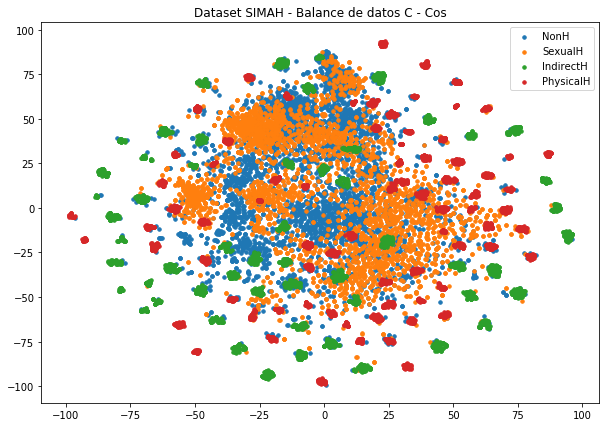

In [30]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_c)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset SIMAH - Balance de datos C - Cos")
plt.show()

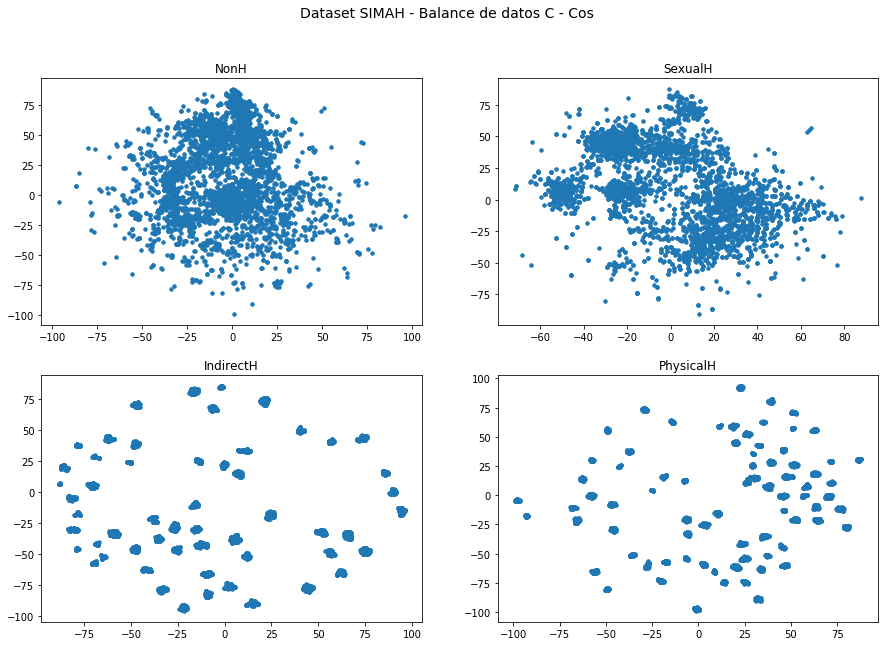

In [31]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))

fig.suptitle("Dataset SIMAH - Balance de datos C - Cos", fontsize=14)
plt.show()

In [32]:
#macro_augmented = np.asarray(macro_augmented, dtype=object)
np.random.shuffle(macro_augmented)
np.save('../Datasets/CSV_Harassment/balance_clase_noPon.npy', macro_augmented)
    

### Sujeto a Clase ponderando target

In [33]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, pond=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 1079 ejemplos para SexualH
Consultando por la clase SexualH
Entrega label 3
Original: star  	Reemplazo:  [('sun', 0.7664803266525269)]
Sentencia original:
['pic' 'mexican' 'school' 'girl' 'naked' 'melanie' 'safka' 'fake' 'nude'
 'photos' 'hardcore' 'slut' 'movies' 'alicia' 'moore' 'porn' 'star' 'toon'
 'love']
Sentencia final: 3
['pic', 'mexican', 'school', 'girl', 'naked', 'melanie', 'safka', 'fake', 'nude', 'photos', 'hardcore', 'slut', 'movies', 'alicia', 'moore', 'porn', 'sun', 'toon', 'love']


Original: w  	Reemplazo:  [('wc', 0.5544506907463074)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Sentencia original:
['girl' 'dirty' 'quarterback' 'latino' 'pokemon' 'young' 'handjob'
 'kissing' 'gangbang' 'w' 'x89' 't' 'co' 'wrm4xo00vj']
Sentencia final: 3
['girl', 'dirty', 'quarterback', 'latino', 'pokemon', 'young', 'handjob', 'kissing', 'gangbang', 'wc', 'x89', 't', 'ko', 'wrm4xo00vj']


Original: n  	Reemplazo:  [('mommy', 0.8239121437072754)]
Sentencia origin

Original: think  	Reemplazo:  [('didn', 0.5361945033073425)]
Original: didn  	Reemplazo:  [('hadn', 1.3816092014312744)]
Sentencia original:
['arianagrande' 'girl' 'as' 'long' 'as' 'you' 'don' 't' 'think' 'he' 's'
 'a' 'good' 'person' 'or' 'sumn' 'just' 'bc' 'he' 'didn' 't' 'slut'
 'shame' 'u' 'to' 'ur' 'face' 'we' 'chillin']
Sentencia final: 3
['arianagrande', 'girl', 'as', 'long', 'as', 'you', 'don', 't', 'didn', 'he', 's', 'a', 'good', 'person', 'or', 'sumn', 'just', 'bc', 'he', 'hadn', 't', 'slut', 'shame', 'u', 'to', 'ur', 'face', 'we', 'chillin']


Original: go  	Reemplazo:  [('get', 3.271831512451172)]
Original: n  	Reemplazo:  [('learnt', 0.5187590718269348)]
Sentencia original:
['ari' 'the' 'perfect' 'example' 'of' 'a' 'slut' 'you' 'hoes' 'go' 'to'
 'a' 'new' 'dino' 'in' 'a' 'matter' 'of' 'months' 'n' 'still' 'try' 'to'
 'fw' 'yo' 'ex' 'on' 'top' 'o']
Sentencia final: 3
['ari', 'the', 'perfect', 'example', 'of', 'a', 'slut', 'you', 'hoes', 'get', 'to', 'a', 'new', 'dino', 'in'

Original: babe  	Reemplazo:  [('tattoo', 1.3042138814926147)]
Sentencia original:
['miamischievious' 'paulpromotes' 'natuky85' 'adultmodelpromo' 'tattooed'
 'babe' 'fancentrotribe' 'camangelsxxx' 'rtslave' 'number' 'such' 'a'
 'naughty' 'girl']
Sentencia final: 3
['miamischievious', 'paulpromotes', 'natuky85', 'adultmodelpromo', 'tattooed', 'tattoo', 'fancentrotribe', 'camangelsxxx', 'rtslave', 'number', 'such', 'a', 'naughty', 'girl']


Original: rt  	Reemplazo:  [('star', 1.162878394126892)]
Sentencia original:
['rt' 'cfootgoddessx' 'your' 'balls' 'wouldnt' 'manage' 'under' 'my'
 'huge' 'feet' 'pure' 'toture' 'to' 'you' 'little' 'cum' 'slut' 'foot'
 'slave' 'bitch' 'humiliation' 'hum']
Sentencia final: 3
['star', 'cfootgoddessx', 'your', 'balls', 'wouldnt', 'manage', 'under', 'my', 'huge', 'feet', 'pure', 'toture', 'to', 'you', 'little', 'cum', 'slut', 'foot', 'slave', 'bitch', 'humiliation', 'hum']


Original: rt  	Reemplazo:  [('gonna', 0.9882068634033203)]
Original: meet  	Reempla

Original: is  	Reemplazo:  [('has', 0.2915353775024414)]
Sentencia original:
['rt' 'iamwytunes' 'niggas' 'think' 'a' 'girl' 'with' 'a' 'baby' 'is' 'a'
 'slut' 'but' 'your' 'mom' 'who' 'is' 'a' 'single' 'mother' 'is' 'the'
 'strongest' 'woman' 'alive']
Sentencia final: 3
['rt', 'iamwytunes', 'niggas', 'think', 'a', 'girl', 'with', 'a', 'baby', 'has', 'a', 'slut', 'but', 'your', 'mom', 'who', 'is', 'a', 'single', 'mother', 'has', 'the', 'strongest', 'woman', 'alive']


Original: i  	Reemplazo:  [('set', 2.0667567253112793)]
Original: swear  	Reemplazo:  [('day', 5.477004528045654)]
Original: amp  	Reemplazo:  [('bill', 1.9126965999603271)]
Sentencia original:
['and' 'i' 'got' 'what' 'a' 'fucking' 'son' 'bitch' 'but' 'mfs' 'swear'
 'ima' 'slut' 'amp' 'what' 'not']
Sentencia final: 3
['and', 'set', 'got', 'what', 'a', 'fucking', 'son', 'bitch', 'but', 'mfs', 'day', 'ima', 'slut', 'bill', 'what', 'not']


Original: t  	Reemplazo:  [('home', 2.204911708831787)]
Sentencia original:
['japanese

Original: pussy  	Reemplazo:  [('porn', 0.6866657137870789)]
Sentencia original:
['first' 'movies' 'pussy' 'pussy' 'latina' 'upskirt' 'drunk' 'cumshot'
 'japanese' 'squ' 'x89' 't' 'co' 'd6sq7e4wln']
Sentencia final: 3
['first', 'movies', 'pussy', 'porn', 'latina', 'upskirt', 'drunk', 'cumshot', 'japanese', 'squ', 'x89', 't', 'co', 'd6sq7e4wln']


Original: lot  	Reemplazo:  [('saw', 0.7653757333755493)]
Original: cool  	Reemplazo:  [('name', 0.5393632650375366)]
Original: names  	Reemplazo:  [('shillings', 1.537702202796936)]
Original: s  	Reemplazo:  [('insert', 0.32604706287384033)]
Sentencia original:
['seeing' 'a' 'lot' 'of' 'cool' 'account' 'names' 'today' 'that' 'are'
 'fashion' 'label' 'sex' 'toy' 'whore' 'slut' 'for' 'example' 'dior' 's'
 'butt' 'plug']
Sentencia final: 3
['seeing', 'a', 'saw', 'of', 'name', 'account', 'shillings', 'today', 'that', 'are', 'fashion', 'label', 'sex', 'toy', 'whore', 'slut', 'for', 'example', 'dior', 'insert', 'butt', 'plug']


Original: bitch  	R

Original: look  	Reemplazo:  [('sound', 0.4349404573440552)]
Original: resource  	Reemplazo:  [('pumped', 0.5708631277084351)]
Sentencia original:
['hughriminton' 'billshortenmp' 'bill' 'is' 'going' 'to' 'behave' 'like'
 'dutto' 's' 'lil' 'slut' 'let' 's' 'look' 'at' 'carbon' 'cost' 'amp'
 'resource' 'of']
Sentencia final: 3
['hughriminton', 'billshortenmp', 'bill', 'is', 'going', 'to', 'behave', 'like', 'dutto', 's', 'lil', 'slut', 'let', 's', 'sound', 'at', 'carbon', 'cost', 'amp', 'pumped', 'of']


Original: t  	Reemplazo:  [('gt', 0.776326596736908)]
Original: call  	Reemplazo:  [('didn', 1.1849640607833862)]
Sentencia original:
['goldenjorgeyy' 'shut' 'up' 'bitch' 'don' 't' 'call' 'me' 'out' 'like'
 'that']
Sentencia final: 3
['goldenjorgeyy', 'shut', 'up', 'bitch', 'don', 'gt', 'didn', 'me', 'out', 'like', 'that']


Original: naked  	Reemplazo:  [('noteworthy', 0.43207648396492004)]
Original: girls  	Reemplazo:  [('women', 0.6084690690040588)]
Sentencia original:
['sex' 'dating' 

Original: u  	Reemplazo:  [('put', 2.0539512634277344)]
Sentencia original:
['amber' 'rose' 'black' 'china' 'big' 'hoe' 'moves' 'up' 'with' 'slut'
 'walks' 'etc' 'stay' 'single' 'fellas' 'if' 'u' 'got' 'a' 'girl' 'or'
 'wife' 'that' 'lik']
Sentencia final: 3
['amber', 'faded', 'black', 'china', 'big', 'hoe', 'moves', 'up', 'with', 'slut', 'walks', 'walk', 'stay', 'unmarried', 'fellas', 'if', 'put', 'got', 'a', 'girl', 'or', 'wife', 'that', 'lik']


Original: tried  	Reemplazo:  [('humiliated', 0.5189516544342041)]
Original: wasn  	Reemplazo:  [('isn', 0.887786328792572)]
Sentencia original:
['blaineb' 'bitch' 'tried' 'those' 'coaches' 'wasn' 'x89' 't' 't' 'co'
 'g8konl6vm1']
Sentencia final: 3
['blaineb', 'bitch', 'humiliated', 'those', 'coaches', 'isn', 'x89', 't', 't', 'co', 'g8konl6vm1']


Original: gun  	Reemplazo:  [('gangster', 0.3469994366168976)]
Sentencia original:
['no' 'words' 'on' 'the' 'national' 'crisis' 'that' 'is' 'gun' 'violence'
 'number' 'number' 'deaths' 'a' 'year' 

Original: think  	Reemplazo:  [('favourite', 1.0918368101119995)]
Original: parts  	Reemplazo:  [('thinks', 0.2686944305896759)]
Original: being  	Reemplazo:  [('causing', 0.9766693115234375)]
Original: bitch  	Reemplazo:  [('whore', 1.0137864351272583)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Sentencia original:
['think' 'favorite' 'parts' 'being' 'woken' 'aggressively' 'x89' 'ang'
 'bitch' 'toilet' 'x89' 'x9d' 'x89' 't' 'co' 'lbsyqigohl']
Sentencia final: 3
['favourite', 'favorite', 'thinks', 'causing', 'woken', 'aggressively', 'x89', 'ang', 'whore', 'toilet', 'x89', 'x9d', 'x89', 't', 'ko', 'lbsyqigohl']


Original: cam  	Reemplazo:  [('man', 3.0659408569335938)]
Sentencia original:
['ava' 'lauren' 'barbie' 'dana' 'dearmond' 'humiliation' 'interracial'
 'creampie' 'jogging' 'stranger' 'urinal' 'cam' 'facesitting' 'tittyfuck']
Sentencia final: 3
['ava', 'lauren', 'barbie', 'dana', 'dearmond', 'humiliation', 'interracial', 'creampie', 'jogging', 'stranger', 'urinal', '

Original: wanna  	Reemplazo:  [('gonna', 2.13603138923645)]
Original: m  	Reemplazo:  [('asshole', 0.4042069613933563)]
Original: e  	Reemplazo:  [('man', 0.5677237510681152)]
Original: im  	Reemplazo:  [('online', 0.5641435980796814)]
Original: e  	Reemplazo:  [('se', 0.7930540442466736)]
Original: fucking  	Reemplazo:  [('freaking', 2.249906063079834)]
Original: bitch  	Reemplazo:  [('butt', 0.7031117677688599)]
Original: don  	Reemplazo:  [('asshole', 0.7860761284828186)]
Original: t  	Reemplazo:  [('woman', 0.7111997604370117)]
Original: makes  	Reemplazo:  [('gets', 0.5629600882530212)]
Original: bop  	Reemplazo:  [('asshole', 0.5844067931175232)]
Original: stan  	Reemplazo:  [('rap', 1.1231271028518677)]
Original: is  	Reemplazo:  [('has', 0.48672154545783997)]
Original: amp  	Reemplazo:  [('perceive', 0.7119333744049072)]
Original: looks  	Reemplazo:  [('thinks', 0.7608361840248108)]
Original: be  	Reemplazo:  [('consider', 0.5235744118690491)]
Original: kill  	Reemplazo:  [('de

Original: times  	Reemplazo:  [('years', 0.5172815322875977)]
Original: makeup  	Reemplazo:  [('brought', 1.1495517492294312)]
Original: goddess  	Reemplazo:  [('broke', 1.2329586744308472)]
Original: gag  	Reemplazo:  [('nt', 0.7761481404304504)]
Original: need  	Reemplazo:  [('want', 1.2859432697296143)]
Original: bangs  	Reemplazo:  [('inches', 1.5632212162017822)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: feet  	Reemplazo:  [('hands', 2.9501988887786865)]
Original: s  	Reemplazo:  [('brunette', 0.4268397092819214)]
Original: fucking  	Reemplazo:  [('freaking', 0.8796676397323608)]
Original: whore  	Reemplazo:  [('asshole', 0.4070088565349579)]
Original: bored  	Reemplazo:  [('disgusted', 0.6447434425354004)]
Original: i  	Reemplazo:  [('ik', 0.4808875322341919)]
Original: does  	Reemplazo:  [('goes', 1.4378342628479004)]
Original: mother  	Reemplazo:  [('thought', 0.19964876770973206)]
Original: co  	Reemplazo:  [('re', 1.1741759777069092)]
Original: sham  	

Original: go  	Reemplazo:  [('come', 0.48682454228401184)]
Original: i  	Reemplazo:  [('passion', 0.4179179072380066)]
Original: bitch  	Reemplazo:  [('http', 2.247745990753174)]
Original: be  	Reemplazo:  [('go', 0.724363386631012)]
Original: platforms  	Reemplazo:  [('ten', 1.1772410869598389)]
Original: m  	Reemplazo:  [('try', 0.4785287380218506)]
Original: co  	Reemplazo:  [('femme', 0.5279068946838379)]
Original: dumb  	Reemplazo:  [('kylie', 2.2747552394866943)]
Original: s  	Reemplazo:  [('niece', 0.3794448971748352)]
Original: be  	Reemplazo:  [('expose', 0.1913020759820938)]
Original: total  	Reemplazo:  [('full', 2.2981138229370117)]
Original: man  	Reemplazo:  [('woman', 0.515140175819397)]
Original: porn  	Reemplazo:  [('thong', 0.3030494749546051)]
Original: hot  	Reemplazo:  [('hilarious', 0.3320012390613556)]
Original: porn  	Reemplazo:  [('thong', 0.4038102328777313)]
Original: number  	Reemplazo:  [('peng', 0.25828638672828674)]
Original: passing  	Reemplazo:  [('peg'

Original: is  	Reemplazo:  [('has', 2.0319290161132812)]
Original: i  	Reemplazo:  [('sc', 1.1082699298858643)]
Original: bitch  	Reemplazo:  [('man', 0.7330995202064514)]
Original: hear  	Reemplazo:  [('time', 2.0240113735198975)]
Original: m  	Reemplazo:  [('ma', 0.8019103407859802)]
Original: i  	Reemplazo:  [('saw', 1.2393572330474854)]
Original: is  	Reemplazo:  [('goes', 2.0926761627197266)]
Original: world  	Reemplazo:  [('life', 3.341430902481079)]
Original: i  	Reemplazo:  [('sandy', 0.515640139579773)]
Original: mom  	Reemplazo:  [('dad', 0.9693723320960999)]
Original: mercy  	Reemplazo:  [('job', 0.7730109691619873)]
Original: shame  	Reemplazo:  [('kylie', 2.1212782859802246)]
Original: asian  	Reemplazo:  [('hilarious', 0.7446586489677429)]
Original: porn  	Reemplazo:  [('pornography', 0.4918157160282135)]
Original: cam  	Reemplazo:  [('girl', 0.9430035948753357)]
Original: okay  	Reemplazo:  [('gonna', 4.380697727203369)]
Original: anyone  	Reemplazo:  [('anybody', 0.3909

Original: black  	Reemplazo:  [('white', 1.3623273372650146)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: girls  	Reemplazo:  [('boys', 1.6214709281921387)]
Original: room  	Reemplazo:  [('pornography', 0.5327889919281006)]
Original: naked  	Reemplazo:  [('sensual', 0.48737192153930664)]
Original: killer  	Reemplazo:  [('cartoon', 1.2499041557312012)]
Original: is  	Reemplazo:  [('seems', 2.091684341430664)]
Original: being  	Reemplazo:  [('watching', 0.9357519745826721)]
Original: does  	Reemplazo:  [('has', 0.37962213158607483)]
Original: girls  	Reemplazo:  [('boys', 0.8316898345947266)]
Original: be  	Reemplazo:  [('have', 0.517020046710968)]
Original: gorgeous  	Reemplazo:  [('new', 0.7436981201171875)]
Original: fuck  	Reemplazo:  [('cock', 0.42384758591651917)]
Original: indian  	Reemplazo:  [('american', 0.709618866443634)]
Original: hours  	Reemplazo:  [('days', 1.2973204851150513)]
Original: whore  	Reemplazo:  [('dumb', 0.8551626205444336)]
Original: bi

Original: rose  	Reemplazo:  [('raped', 0.4505075216293335)]
Original: whore  	Reemplazo:  [('penetration', 1.1216987371444702)]
Original: adult  	Reemplazo:  [('woman', 1.6947448253631592)]
Original: girl  	Reemplazo:  [('prostitute', 0.6897006630897522)]
Original: add  	Reemplazo:  [('happen', 2.9560954570770264)]
Original: tits  	Reemplazo:  [('pods', 0.35558459162712097)]
Original: anal  	Reemplazo:  [('huge', 0.6368253827095032)]
Original: spread  	Reemplazo:  [('fat', 0.3764136731624603)]
Original: girls  	Reemplazo:  [('shows', 0.9677662253379822)]
Original: tits  	Reemplazo:  [('shows', 0.6237443089485168)]
Original: love  	Reemplazo:  [('want', 1.39380943775177)]
Original: pl  	Reemplazo:  [('yeah', 0.47595030069351196)]
Original: same  	Reemplazo:  [('forgive', 1.2127685546875)]
Original: everyone  	Reemplazo:  [('everybody', 0.3895546793937683)]
Original: bc  	Reemplazo:  [('hc', 0.5183794498443604)]
Original: i  	Reemplazo:  [('dino', 0.711899995803833)]
Original: high  	Re

Original: daily  	Reemplazo:  [('open', 0.7039045095443726)]
Original: note  	Reemplazo:  [('boy', 0.5176405906677246)]
Original: wish  	Reemplazo:  [('hmm', 1.1145141124725342)]
Original: baby  	Reemplazo:  [('boy', 0.5953342318534851)]
Original: college  	Reemplazo:  [('callie', 0.8183183073997498)]
Original: mom  	Reemplazo:  [('shitty', 0.36200493574142456)]
Original: n  	Reemplazo:  [('wife', 0.4614989161491394)]
Original: messy  	Reemplazo:  [('shitty', 0.5163723826408386)]
Original: m  	Reemplazo:  [('competent', 0.30951011180877686)]
Original: idol  	Reemplazo:  [('re', 1.9189467430114746)]
Original: cum  	Reemplazo:  [('insane', 0.6230445504188538)]
Original: number  	Reemplazo:  [('song', 0.78221595287323)]
Original: m  	Reemplazo:  [('ma', 1.2417943477630615)]
Original: s  	Reemplazo:  [('kitty', 1.2818641662597656)]
Original: does  	Reemplazo:  [('believes', 0.4609999358654022)]
Original: dog  	Reemplazo:  [('brunette', 0.5073498487472534)]
Original: talking  	Reemplazo:  [

Original: u  	Reemplazo:  [('didn', 0.5451598763465881)]
Original: follow  	Reemplazo:  [('do', 0.7213341593742371)]
Original: i  	Reemplazo:  [('ic', 0.4853881895542145)]
Original: union  	Reemplazo:  [('claim', 0.8464040756225586)]
Original: i  	Reemplazo:  [('ma', 1.1053359508514404)]
Original: go  	Reemplazo:  [('come', 0.5607785582542419)]
Original: standards  	Reemplazo:  [('rules', 0.7142122983932495)]
Original: i  	Reemplazo:  [('re', 0.7765405178070068)]
Original: i  	Reemplazo:  [('mine', 0.7899224162101746)]
Original: women  	Reemplazo:  [('prostitutes', 0.524376630783081)]
Original: active  	Reemplazo:  [('homosexual', 0.6341457366943359)]
Original: m  	Reemplazo:  [('someone', 0.4766569137573242)]
Original: baby  	Reemplazo:  [('woman', 1.0380399227142334)]
Original: doll  	Reemplazo:  [('boy', 1.594001054763794)]
Original: bitch  	Reemplazo:  [('asshole', 0.5224134922027588)]
Original: looking  	Reemplazo:  [('going', 1.9425849914550781)]
Original: t  	Reemplazo:  [('re',

Original: come  	Reemplazo:  [('go', 0.45138123631477356)]
Original: verify  	Reemplazo:  [('jogging', 0.814235508441925)]
Original: write  	Reemplazo:  [('slept', 1.2148562669754028)]
Original: guy  	Reemplazo:  [('girl', 0.4871884286403656)]
Original: new  	Reemplazo:  [('sexual', 0.5541946887969971)]
Original: porn  	Reemplazo:  [('pornography', 2.163621187210083)]
Original: assume  	Reemplazo:  [('realize', 0.7710630893707275)]
Original: ready  	Reemplazo:  [('acceptable', 0.5143926739692688)]
Original: proposal  	Reemplazo:  [('accept', 2.4273531436920166)]
Original: i  	Reemplazo:  [('told', 0.7421091198921204)]
Original: shame  	Reemplazo:  [('enemy', 1.5319379568099976)]
Original: pussy  	Reemplazo:  [('asshole', 0.7268479466438293)]
Original: pussy  	Reemplazo:  [('fuck', 1.4366505146026611)]
Original: is  	Reemplazo:  [('has', 1.3045897483825684)]
Original: girls  	Reemplazo:  [('people', 1.2214237451553345)]
Original: rt  	Reemplazo:  [('didn', 0.8011438250541687)]
Original:

Original: porn  	Reemplazo:  [('brother', 0.8067203164100647)]
Original: m  	Reemplazo:  [('work', 1.9941869974136353)]
Original: music  	Reemplazo:  [('work', 1.9786919355392456)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: bitch  	Reemplazo:  [('whore', 0.9572808146476746)]
Original: t  	Reemplazo:  [('re', 0.48242753744125366)]
Original: shows  	Reemplazo:  [('people', 0.7326719760894775)]
Original: bitch  	Reemplazo:  [('rb', 0.8255239725112915)]
Original: pink  	Reemplazo:  [('lipstick', 0.9647616147994995)]
Original: mad  	Reemplazo:  [('gangster', 0.511257529258728)]
Original: call  	Reemplazo:  [('caller', 1.2561440467834473)]
Original: bitch  	Reemplazo:  [('kylie', 2.30055832862854)]
Original: were  	Reemplazo:  [('was', 2.3677961826324463)]
Original: tonight  	Reemplazo:  [('today', 0.8142932057380676)]
Original: black  	Reemplazo:  [('large', 0.7103317975997925)]
Original: girls  	Reemplazo:  [('boys', 0.5842940211296082)]
Original: wrong  	Reemplazo: 

Original: i  	Reemplazo:  [('woman', 0.4682219922542572)]
Original: ma  	Reemplazo:  [('pic', 0.7772388458251953)]
Sentencia original:
['bitch' 'i' 'ma' 'kill' 'you' 'you' 'don' 't' 'wanna' 'fuck' 'with' 'me'
 'girls' 'neither' 'you' 'ain' 't' 'nothing' 'but' 'a' 'slut' 'to' 'me'
 'bitch' 'i' 'ma' 'kill' 'you']
Sentencia final: 2
['bitch', 'woman', 'pic', 'kill', 'you', 'you', 'don', 't', 'wanna', 'fuck', 'with', 'me', 'girls', 'neither', 'you', 'ain', 't', 'nothing', 'but', 'a', 'slut', 'to', 'me', 'bitch', 'i', 'ma', 'kill', 'you']


Original: rt  	Reemplazo:  [('nap', 1.2217199802398682)]
Original: number  	Reemplazo:  [('name', 1.0808322429656982)]
Original: murderer  	Reemplazo:  [('didn', 1.8304606676101685)]
Sentencia original:
['rt' 'talbertswan' 'the' 'mother' 'of' 'jazminebarnes' 'her' 'number'
 'yr' 'old' 'daughter' 'who' 'was' 'shot' 'amp' 'killed' 'by' 'a' 'white'
 'supremacist' 'the' 'murderer' 'pulled' 'up' 'i']
Sentencia final: 2
['nap', 'talbertswan', 'the', 'mother', 

Original: death  	Reemplazo:  [('anybody', 0.5136901140213013)]
Original: threats  	Reemplazo:  [('starts', 0.43479660153388977)]
Original: crap  	Reemplazo:  [('shit', 2.3074049949645996)]
Sentencia original:
['briannawu' 'everybody' 'gets' 'death' 'threats' 'are' 'you' 'still'
 'bitch' 'about' 'that' 'no' 'one' 'cares' 'most' 'of' 'that' 'crap' 'you'
 'mad']
Sentencia final: 2
['briannawu', 'everybody', 'gets', 'anybody', 'starts', 'are', 'you', 'still', 'bitch', 'about', 'that', 'no', 'one', 'cares', 'most', 'of', 'that', 'shit', 'you', 'mad']


Original: girl  	Reemplazo:  [('boy', 1.439417839050293)]
Original: doesn  	Reemplazo:  [('hasn', 0.6204389333724976)]
Original: t  	Reemplazo:  [('hasn', 0.36311161518096924)]
Sentencia original:
['repeat' 'after' 'me' 'no' 'any' 'girl' 'of' 'any' 'cast' 'community'
 'or' 'country' 'deserve' 'rape' 'threats' 'or' 'slut' 'shame' 'doesn' 't'
 'matter']
Sentencia final: 2
['repeat', 'after', 'me', 'no', 'any', 'boy', 'of', 'any', 'cast', 'comm

Original: jax  	Reemplazo:  [('bitch', 0.7840616106987)]
Sentencia original:
['never' 'getting' 'james' 'constantly' 'fat' 'shame' 'and' 'slut' 'shame'
 'girls' 'at' 'least' 'jax' 'just' 'fuck' 'over' 'his' 'partners' 'james']
Sentencia final: 2
['never', 'getting', 'james', 'constantly', 'fat', 'shame', 'and', 'slut', 'shame', 'girls', 'at', 'least', 'bitch', 'just', 'fuck', 'over', 'his', 'partners', 'james']


Original: love  	Reemplazo:  [('rt', 0.529297947883606)]
Sentencia original:
['rt' 'kthfuckz' 'don' 't' 'u' 'love' 'when' 'u' 're' 'like' 'this'
 'kitten' 'all' 'tied' 'up' 'amp' 'useless' 'ur' 'pretty' 'mouth' 'gag'
 'and' 'ur' 'ass' 'covered' 'in' 'bruises' 'u' 'look']
Sentencia final: 2
['rt', 'kthfuckz', 'don', 't', 'u', 'rt', 'when', 'u', 're', 'like', 'this', 'kitten', 'all', 'tied', 'up', 'amp', 'useless', 'ur', 'pretty', 'mouth', 'gag', 'and', 'ur', 'ass', 'covered', 'in', 'bruises', 'u', 'look']


Original: t  	Reemplazo:  [('didn', 0.5489107966423035)]
Original: numb

Original: y  	Reemplazo:  [('anwar', 0.5495322942733765)]
Sentencia original:
['really' 'wanting' 'smack' 'y' 'x89' 'all' 'daughters' 'disrespectful'
 'sons']
Sentencia final: 2
['really', 'wanting', 'smack', 'anwar', 'x89', 'all', 'daughters', 'disrespectful', 'sons']


Original: used  	Reemplazo:  [('called', 1.1581617593765259)]
Original: stripped  	Reemplazo:  [('pulled', 1.0086467266082764)]
Sentencia original:
['unjust' 'is' 'that' 'the' 'word' 'she' 'used' 'unjust' 'you' 'muslim'
 'cunt' 'you' 'deserve' 'to' 'be' 'stripped' 'of' 'your' 'life' 'but'
 'they' 'just']
Sentencia final: 2
['unjust', 'is', 'that', 'the', 'word', 'she', 'called', 'unjust', 'you', 'muslim', 'cunt', 'you', 'deserve', 'to', 'be', 'pulled', 'of', 'your', 'life', 'but', 'they', 'just']


Original: kills  	Reemplazo:  [('videos', 1.4983164072036743)]
Sentencia original:
['rt' 'evilbart24' 'being' 'ugly' 'sucks' 'because' 'you' 'can' 'have'
 'the' 'time' 'of' 'your' 'life' 'and' 'then' 'you' 'see' 'a' 'glimpse

Original: t  	Reemplazo:  [('didn', 0.30171337723731995)]
Original: fuck  	Reemplazo:  [('shit', 2.0216007232666016)]
Sentencia original:
['rt' 'evafreya' 'i' 'don' 't' 'give' 'a' 'flying' 'fuck' 'if' 'you'
 'agree' 'with' 'katie' 'hopkins' 'this' 'one' 'time' 'she' 's' 'a'
 'racist' 'classist' 'homophobic' 'piece' 'of' 'shi']
Sentencia final: 2
['rt', 'evafreya', 'i', 'don', 'didn', 'give', 'a', 'flying', 'shit', 'if', 'you', 'agree', 'with', 'katie', 'hopkins', 'this', 'one', 'time', 'she', 's', 'a', 'racist', 'classist', 'homophobic', 'piece', 'of', 'shi']


Original: sex  	Reemplazo:  [('time', 1.9244896173477173)]
Sentencia original:
['rt' 'vanessamercer17' 'omg' 'here' 'boobs' 'are' 'huge' 'and' 'so'
 'juicy' 'smash' 'here' 'nsfw' 'cumslut' 'sex' 'cumtribute']
Sentencia final: 2
['rt', 'vanessamercer17', 'omg', 'here', 'boobs', 'are', 'huge', 'and', 'so', 'juicy', 'smash', 'here', 'nsfw', 'cumslut', 'time', 'cumtribute']


Original: make  	Reemplazo:  [('do', 0.7236101031303406)]

Original: comment  	Reemplazo:  [('look', 0.4492206573486328)]
Sentencia original:
['ok' 'so' 'what' 'you' 'shouldn' 't' 'do' 'is' 'comment' 'on' 'jordyn'
 's' 'pic' 'telling' 'her' 'to' 'kill' 'her' 'self' 'and' 'slut' 'shame'
 'her' 'that' 's' 'just' 'messy']
Sentencia final: 2
['ok', 'so', 'what', 'you', 'shouldn', 't', 'do', 'is', 'look', 'on', 'jordyn', 's', 'pic', 'telling', 'her', 'to', 'kill', 'her', 'self', 'and', 'slut', 'shame', 'her', 'that', 's', 'just', 'messy']


Original: daughter  	Reemplazo:  [('son', 0.5231149196624756)]
Original: was  	Reemplazo:  [('were', 0.4526771903038025)]
Sentencia original:
['rt' 'talbertswan' 'the' 'mother' 'of' 'jazminebarnes' 'her' 'number'
 'yr' 'old' 'daughter' 'who' 'was' 'shot' 'amp' 'killed' 'by' 'a' 'white'
 'supremacist' 'the' 'murderer' 'pulled' 'up' 'i']
Sentencia final: 2
['rt', 'talbertswan', 'the', 'mother', 'of', 'jazminebarnes', 'her', 'number', 'yr', 'old', 'son', 'who', 'were', 'shot', 'amp', 'killed', 'by', 'a', 'white', '

Original: stop  	Reemplazo:  [('chopped', 0.3390563428401947)]
Sentencia original:
['how' 'do' 'you' 'do' 'anything' 'with' 'those' 'long' 'nails' 'okay'
 'it' 's' 'not' 'that' 'difficult' 'amp' 'stop' 'being' 'overdramatic'
 'with' 'your' 'stubby' 'nails' 'self']
Sentencia final: 2
['how', 'do', 'you', 'do', 'anything', 'with', 'those', 'long', 'nails', 'okay', 'it', 's', 'not', 'that', 'difficult', 'amp', 'chopped', 'being', 'overdramatic', 'with', 'your', 'stubby', 'nails', 'self']


Original: re  	Reemplazo:  [('racist', 0.44567349553108215)]
Sentencia original:
['alexanderlocke' 'no' 'idea' 'in' 'glasgow' 'if' 'you' 'call' 'a' 'woman'
 'a' 'cow' 'you' 're' 'basically' 'saying' 'she' 's' 'a' 'dirty'
 'disgusting' 'sl']
Sentencia final: 2
['alexanderlocke', 'no', 'idea', 'in', 'glasgow', 'if', 'you', 'call', 'a', 'woman', 'a', 'cow', 'you', 'racist', 'basically', 'saying', 'she', 's', 'a', 'dirty', 'disgusting', 'sl']


Original: is  	Reemplazo:  [('has', 0.7121105790138245)]
Senten

Original: servant  	Reemplazo:  [('chopped', 0.3577980399131775)]
Original: m  	Reemplazo:  [('minor', 0.7280696630477905)]
Original: t  	Reemplazo:  [('rt', 0.48724597692489624)]
Sentencia original:
['the' 'woman' 'brutally' 'tortured' 'minor' 'servant' 'starved' 'major'
 'ammara' 'm' 'x89' 't' 'co' 'yj96d2xgrp']
Sentencia final: 2
['the', 'girl', 'brutally', 'tortured', 'minor', 'chopped', 'starved', 'major', 'ammara', 'minor', 'x89', 'rt', 'co', 'yj96d2xgrp']


Original: baby  	Reemplazo:  [('juicy', 0.341073602437973)]
Original: little  	Reemplazo:  [('big', 0.7039305567741394)]
Sentencia original:
['p0rnsfw' 'daddy' 'behave' 'baby' 'daddy' 'tight' 'open' 'yeah' 'little'
 'x89']
Sentencia final: 2
['p0rnsfw', 'daddy', 'behave', 'juicy', 'daddy', 'tight', 'open', 'yeah', 'big', 'x89']


Original: co  	Reemplazo:  [('facebook', 0.5225799679756165)]
Sentencia original:
['x' 'wildestdreams' 'really' 'being' 'sassy' 'twitter' 't' 'co'
 'btblszxbw0']
Sentencia final: 2
['x', 'wildestdrea

Original: bitch  	Reemplazo:  [('whore', 1.263903021812439)]
Original: cool  	Reemplazo:  [('ok', 0.7077970504760742)]
Sentencia original:
['rt' 'quinnceylon' 'i' 'm' 'not' 'about' 'to' 'do' 'this' 'on' 'amp'
 'off' 'shit' 'with' 'niggas' 'or' 'bitch' 'either' 'we' 'fuck' 'with'
 'eachother' 'or' 'we' 'don' 't' 'we' 'cool' 'or' 'we' 'no']
Sentencia final: 2
['rt', 'quinnceylon', 'i', 'm', 'not', 'about', 'to', 'do', 'this', 'on', 'amp', 'off', 'shit', 'with', 'niggas', 'or', 'whore', 'either', 'we', 'fuck', 'with', 'eachother', 'or', 'we', 'don', 't', 'we', 'ok', 'or', 'we', 'no']


Original: single  	Reemplazo:  [('aesthetic', 0.7073837518692017)]
Sentencia original:
['love' 'you' 'bby' 'like' 'and' 'rt' 'for' 'more' 'horny' 'single'
 'girls' 'amateur' 'bbc' 'booty' 'cock' 'cumslut' 'daddy' 'date' 'dati']
Sentencia final: 2
['love', 'you', 'bby', 'like', 'and', 'rt', 'for', 'more', 'horny', 'aesthetic', 'girls', 'amateur', 'bbc', 'booty', 'cock', 'cumslut', 'daddy', 'date', 'dati']




Original: call  	Reemplazo:  [('girl', 2.2977395057678223)]
Original: saying  	Reemplazo:  [('being', 0.7116125226020813)]
Sentencia original:
['alexanderlocke' 'no' 'idea' 'in' 'glasgow' 'if' 'you' 'call' 'a' 'woman'
 'a' 'cow' 'you' 're' 'basically' 'saying' 'she' 's' 'a' 'dirty'
 'disgusting' 'sl']
Sentencia final: 2
['alexanderlocke', 'no', 'idea', 'in', 'glasgow', 'if', 'you', 'girl', 'a', 'woman', 'a', 'cow', 'you', 're', 'basically', 'being', 'she', 's', 'a', 'dirty', 'disgusting', 'sl']


Original: chop  	Reemplazo:  [('body', 1.2521854639053345)]
Original: bitch  	Reemplazo:  [('katie', 2.2086074352264404)]
Original: horrible  	Reemplazo:  [('stupid', 0.5108197927474976)]
Original: looking  	Reemplazo:  [('talking', 1.1793973445892334)]
Sentencia original:
['pagga88' 'she' 'needs' 'her' 'fuckin' 'head' 'chop' 'off' 'the' 'cheeky'
 'bitch' 'horrible' 'postbox' 'looking' 'slut']
Sentencia final: 2
['pagga88', 'she', 'needs', 'her', 'fuckin', 'head', 'body', 'off', 'the', 'cheeky

Original: honest  	Reemplazo:  [('anybody', 0.8406677842140198)]
Original: killed  	Reemplazo:  [('tortured', 0.36363106966018677)]
Original: fair  	Reemplazo:  [('time', 1.9307323694229126)]
Original: don  	Reemplazo:  [('juicy', 0.3217408061027527)]
Original: co  	Reemplazo:  [('re', 0.6831108331680298)]
Original: british  	Reemplazo:  [('japanese', 0.722998321056366)]
Original: give  	Reemplazo:  [('make', 1.1754722595214844)]
Original: little  	Reemplazo:  [('big', 0.7506253719329834)]
Original: being  	Reemplazo:  [('having', 2.0575900077819824)]
Original: t  	Reemplazo:  [('self', 0.706399142742157)]
Original: don  	Reemplazo:  [('ur', 0.478629469871521)]
Original: t  	Reemplazo:  [('didn', 0.7253208160400391)]
Original: kitten  	Reemplazo:  [('have', 1.6791713237762451)]
Original: bruises  	Reemplazo:  [('rubs', 0.32078778743743896)]
Original: minor  	Reemplazo:  [('beaten', 0.9522574543952942)]
Original: m  	Reemplazo:  [('minor', 1.327215552330017)]
Original: t  	Reemplazo:  [

Original: anybody  	Reemplazo:  [('gonna', 3.0379979610443115)]
Original: destroy  	Reemplazo:  [('wanna', 0.3709878623485565)]
Original: calling  	Reemplazo:  [('saying', 0.7075571417808533)]
Original: try  	Reemplazo:  [('hasn', 1.4141179323196411)]
Original: drag  	Reemplazo:  [('prepare', 0.8016159534454346)]
Original: t  	Reemplazo:  [('nothing', 1.0898892879486084)]
Original: trying  	Reemplazo:  [('gaping', 1.1938886642456055)]
Original: piece  	Reemplazo:  [('juicy', 0.8275992274284363)]
Original: husband  	Reemplazo:  [('mother', 0.7059123516082764)]
Original: rape  	Reemplazo:  [('daughter', 0.9697394967079163)]
Original: has  	Reemplazo:  [('is', 0.6953145265579224)]
Original: self  	Reemplazo:  [('face', 3.030153512954712)]
Original: dirty  	Reemplazo:  [('messy', 0.5270165801048279)]
Original: stern  	Reemplazo:  [('grave', 1.0842595100402832)]
Original: looking  	Reemplazo:  [('being', 2.011270523071289)]
Original: grade  	Reemplazo:  [('type', 1.6760073900222778)]
Origin

Original: hot  	Reemplazo:  [('japanese', 0.7763875126838684)]
Original: servant  	Reemplazo:  [('anwar', 0.7372271418571472)]
Original: m  	Reemplazo:  [('minor', 0.7906122803688049)]
Original: daddy  	Reemplazo:  [('wanna', 1.5991836786270142)]
Original: baby  	Reemplazo:  [('pussy', 0.7189946174621582)]
Original: yeah  	Reemplazo:  [('messy', 0.2747376263141632)]
Original: try  	Reemplazo:  [('stop', 1.2230921983718872)]
Original: co  	Reemplazo:  [('facebook', 0.45972466468811035)]
Original: dream  	Reemplazo:  [('crap', 0.39700764417648315)]
Original: t  	Reemplazo:  [('time', 0.4184352457523346)]
Original: u  	Reemplazo:  [('re', 0.4306619465351105)]
Original: u  	Reemplazo:  [('time', 1.2842693328857422)]
Original: amp  	Reemplazo:  [('chopped', 0.45866796374320984)]
Original: ur  	Reemplazo:  [('dumb', 1.4093319177627563)]
Original: gag  	Reemplazo:  [('name', 0.7378911972045898)]
Original: ur  	Reemplazo:  [('whore', 0.6070740222930908)]
Original: is  	Reemplazo:  [('has', 0.2

Original: kill  	Reemplazo:  [('destroy', 0.8224565982818604)]
Original: o  	Reemplazo:  [('look', 0.6899599432945251)]
Original: oh  	Reemplazo:  [('nah', 0.1708158552646637)]
Original: daughters  	Reemplazo:  [('children', 1.437496542930603)]
Original: deserve  	Reemplazo:  [('shouldn', 2.1699917316436768)]
Original: sucks  	Reemplazo:  [('people', 0.6905653476715088)]
Original: was  	Reemplazo:  [('slapped', 0.4651786983013153)]
Original: t  	Reemplazo:  [('doesn', 1.1763906478881836)]
Original: abs  	Reemplazo:  [('girls', 0.5270363092422485)]
Original: told  	Reemplazo:  [('tell', 1.2446224689483643)]
Original: i  	Reemplazo:  [('time', 0.6609132885932922)]
Original: amp  	Reemplazo:  [('porn', 0.488818883895874)]
Original: let  	Reemplazo:  [('kitten', 1.8517264127731323)]
Original: i  	Reemplazo:  [('re', 0.4582739472389221)]
Original: don  	Reemplazo:  [('didn', 0.4493619501590729)]
Original: t  	Reemplazo:  [('look', 0.26294365525245667)]
Original: drag  	Reemplazo:  [('behave

Original: facebook  	Reemplazo:  [('doesn', 1.8742659091949463)]
Original: dream  	Reemplazo:  [('wish', 1.3054848909378052)]
Original: starved  	Reemplazo:  [('addicted', 0.7951537370681763)]
Original: baby  	Reemplazo:  [('juicy', 0.3285024166107178)]
Original: open  	Reemplazo:  [('horrible', 0.33920052647590637)]
Original: yeah  	Reemplazo:  [('juicy', 0.29966965317726135)]
Original: drag  	Reemplazo:  [('prepare', 0.8016159534454346)]
Original: body  	Reemplazo:  [('chopped', 0.5312862396240234)]
Original: twitter  	Reemplazo:  [('facebook', 0.29212579131126404)]
Original: chopped  	Reemplazo:  [('way', 0.7202823162078857)]
Original: james  	Reemplazo:  [('bases', 0.7215741872787476)]
Original: james  	Reemplazo:  [('men', 1.9204736948013306)]
Original: u  	Reemplazo:  [('porn', 0.7157272696495056)]
Original: amp  	Reemplazo:  [('chopped', 0.7484747171401978)]
Original: bruises  	Reemplazo:  [('rubs', 0.32078778743743896)]
Original: rt  	Reemplazo:  [('campaign', 1.084617733955383

Original: have  	Reemplazo:  [('see', 1.174074411392212)]
Original: fl  	Reemplazo:  [('time', 0.5124332308769226)]
Original: legal  	Reemplazo:  [('horrible', 0.5066976547241211)]
Original: amount  	Reemplazo:  [('muslim', 0.5881300568580627)]
Original: other  	Reemplazo:  [('old', 1.1999423503875732)]
Original: i  	Reemplazo:  [('thing', 0.18033148348331451)]
Original: don  	Reemplazo:  [('thing', 0.4556150436401367)]
Original: gonna  	Reemplazo:  [('destroy', 0.5112082958221436)]
Original: fucking  	Reemplazo:  [('looking', 1.8605929613113403)]
Original: life  	Reemplazo:  [('time', 2.24162220954895)]
Original: being  	Reemplazo:  [('lying', 1.4278171062469482)]
Original: is  	Reemplazo:  [('has', 0.7165576815605164)]
Original: was  	Reemplazo:  [('were', 0.8339986205101013)]
Original: time  	Reemplazo:  [('cool', 0.6934661865234375)]
Original: movies  	Reemplazo:  [('girls', 2.298409938812256)]
Original: girl  	Reemplazo:  [('guy', 0.9948616623878479)]
Original: guys  	Reemplazo:  

Original: indian  	Reemplazo:  [('islamic', 0.552628755569458)]
Original: japanese  	Reemplazo:  [('horrible', 2.2088449001312256)]
Original: t  	Reemplazo:  [('time', 1.2320655584335327)]
Original: co  	Reemplazo:  [('re', 1.0989848375320435)]
Original: were  	Reemplazo:  [('was', 1.2279009819030762)]
Original: manchester  	Reemplazo:  [('kill', 1.2243455648422241)]
Original: d  	Reemplazo:  [('ll', 1.2844830751419067)]
Original: t  	Reemplazo:  [('love', 0.41482222080230713)]
Original: hot  	Reemplazo:  [('japanese', 0.7724561095237732)]
Original: dream  	Reemplazo:  [('wish', 2.001802682876587)]
Original: co  	Reemplazo:  [('non', 1.1069225072860718)]
Original: behave  	Reemplazo:  [('murderer', 0.4515627324581146)]
Original: open  	Reemplazo:  [('huge', 0.2974992096424103)]
Original: james  	Reemplazo:  [('men', 1.1233657598495483)]
Original: fuck  	Reemplazo:  [('bitch', 0.8862033486366272)]
Original: u  	Reemplazo:  [('time', 2.2137656211853027)]
Original: useless  	Reemplazo:  [

Original: kill  	Reemplazo:  [('wanna', 0.6431134939193726)]
Original: self  	Reemplazo:  [('co', 0.7408632040023804)]
Original: used  	Reemplazo:  [('recommended', 1.2058229446411133)]
Original: deserve  	Reemplazo:  [('glimpse', 1.178985595703125)]
Original: rt  	Reemplazo:  [('manchester', 0.709531307220459)]
Original: being  	Reemplazo:  [('disgusting', 0.5611501336097717)]
Original: psycho  	Reemplazo:  [('gonna', 0.9648327827453613)]
Original: teen  	Reemplazo:  [('rape', 1.264484167098999)]
Original: movies  	Reemplazo:  [('videos', 1.30707848072052)]
Original: having  	Reemplazo:  [('wanting', 0.8468931317329407)]
Original: kendrick  	Reemplazo:  [('hussain', 0.7567675113677979)]
Original: fat  	Reemplazo:  [('drag', 1.2996941804885864)]
Original: dog  	Reemplazo:  [('anything', 1.3492038249969482)]
Original: destroy  	Reemplazo:  [('kill', 0.7904430031776428)]
Original: amp  	Reemplazo:  [('crotch', 0.5470403432846069)]
Original: kitten  	Reemplazo:  [('have', 2.86291599273681

Original: lesbian  	Reemplazo:  [('jealous', 0.5404260754585266)]
Original: children  	Reemplazo:  [('women', 0.9311410188674927)]
Original: manchester  	Reemplazo:  [('glasgow', 0.8125008344650269)]
Original: fair  	Reemplazo:  [('time', 1.9307323694229126)]
Original: i  	Reemplazo:  [('time', 1.9061118364334106)]
Original: wants  	Reemplazo:  [('says', 1.1323130130767822)]
Original: t  	Reemplazo:  [('didn', 0.46604248881340027)]
Original: hot  	Reemplazo:  [('other', 2.218665599822998)]
Original: minor  	Reemplazo:  [('hooker', 0.6749178767204285)]
Original: co  	Reemplazo:  [('re', 1.077183723449707)]
Original: t  	Reemplazo:  [('doesn', 0.8307209014892578)]
Original: fat  	Reemplazo:  [('violent', 1.1717829704284668)]
Original: shame  	Reemplazo:  [('nude', 1.321554183959961)]
Original: least  	Reemplazo:  [('most', 0.35143032670021057)]
Original: don  	Reemplazo:  [('hussain', 0.3168877363204956)]
Original: amp  	Reemplazo:  [('suicidal', 1.2407983541488647)]
Original: useless  	

Original: sucks  	Reemplazo:  [('people', 0.6242413520812988)]
Original: kills  	Reemplazo:  [('videos', 1.4983164072036743)]
Original: lad  	Reemplazo:  [('boy', 1.9261680841445923)]
Original: didn  	Reemplazo:  [('doesn', 2.3507914543151855)]
Original: porn  	Reemplazo:  [('terrorism', 0.957963228225708)]
Original: movies  	Reemplazo:  [('girls', 1.0320628881454468)]
Original: guys  	Reemplazo:  [('girls', 1.0321762561798096)]
Original: anna  	Reemplazo:  [('suicidal', 0.8389564156532288)]
Original: fat  	Reemplazo:  [('cute', 0.7129054665565491)]
Original: are  	Reemplazo:  [('am', 0.7038437724113464)]
Original: kitten  	Reemplazo:  [('add', 1.0628094673156738)]
Original: bella  	Reemplazo:  [('anna', 1.225307822227478)]
Original: y  	Reemplazo:  [('stop', 1.1463465690612793)]
Original: drag  	Reemplazo:  [('jax', 1.1402782201766968)]
Original: sl  	Reemplazo:  [('messy', 0.6087452173233032)]
Original: number  	Reemplazo:  [('line', 1.247729778289795)]
Original: i  	Reemplazo:  [('d

Original: s  	Reemplazo:  [('ll', 2.0362625122070312)]
Original: horrible  	Reemplazo:  [('huge', 1.1578006744384766)]
Original: wish  	Reemplazo:  [('tell', 1.1435292959213257)]
Original: nah  	Reemplazo:  [('whore', 0.8530645966529846)]
Original: fat  	Reemplazo:  [('nude', 0.79091477394104)]
Original: punched  	Reemplazo:  [('fucked', 0.7657698392868042)]
Original: shit  	Reemplazo:  [('crap', 0.6380317807197571)]
Original: co  	Reemplazo:  [('re', 0.7201935648918152)]
Original: wanna  	Reemplazo:  [('didn', 0.34376612305641174)]
Original: girls  	Reemplazo:  [('men', 1.979390263557434)]
Original: t  	Reemplazo:  [('nobody', 0.598015308380127)]
Original: nothing  	Reemplazo:  [('nobody', 0.8553915023803711)]
Original: i  	Reemplazo:  [('woman', 0.48249098658561707)]
Original: shame  	Reemplazo:  [('past', 3.136809825897217)]
Original: re  	Reemplazo:  [('prepare', 0.4596959054470062)]
Original: tomorrow  	Reemplazo:  [('homework', 0.7313173413276672)]
Original: amp  	Reemplazo:  [('

Original: grade  	Reemplazo:  [('doesn', 1.9666560888290405)]
Original: grade  	Reemplazo:  [('doesn', 1.9496225118637085)]
Original: bitch  	Reemplazo:  [('whore', 0.7200542092323303)]
Original: rt  	Reemplazo:  [('amount', 0.7563472390174866)]
Original: ll  	Reemplazo:  [('destroy', 0.6553685665130615)]
Original: death  	Reemplazo:  [('anybody', 0.3546254634857178)]
Original: threats  	Reemplazo:  [('kills', 0.7343382239341736)]
Original: meant  	Reemplazo:  [('time', 1.0681493282318115)]
Original: cast  	Reemplazo:  [('family', 2.0210044384002686)]
Original: threats  	Reemplazo:  [('deserves', 1.457698941230774)]
Original: shame  	Reemplazo:  [('didn', 1.0722942352294922)]
Original: has  	Reemplazo:  [('is', 2.0928239822387695)]
Original: happened  	Reemplazo:  [('appeared', 1.2284905910491943)]
Original: women  	Reemplazo:  [('girls', 1.3794139623641968)]
Original: muslim  	Reemplazo:  [('jewish', 0.7846527099609375)]
Original: fuck  	Reemplazo:  [('shit', 2.09499192237854)]
Origin

Original: ava  	Reemplazo:  [('crotch', 0.29645928740501404)]
Original: i  	Reemplazo:  [('head', 0.7643743753433228)]
Original: is  	Reemplazo:  [('has', 1.296539068222046)]
Original: i  	Reemplazo:  [('way', 1.1176636219024658)]
Original: makes  	Reemplazo:  [('has', 1.418573021888733)]
Original: hall  	Reemplazo:  [('day', 1.1579616069793701)]
Original: loses  	Reemplazo:  [('sucks', 0.8524461984634399)]
Original: ain  	Reemplazo:  [('nobody', 0.5632525682449341)]
Original: nothing  	Reemplazo:  [('nobody', 0.5165464282035828)]
Original: kill  	Reemplazo:  [('se', 0.7300894260406494)]
Original: i  	Reemplazo:  [('didn', 1.1545214653015137)]
Original: i  	Reemplazo:  [('doesn', 3.5389742851257324)]
Original: know  	Reemplazo:  [('be', 0.4650452435016632)]
Original: ready  	Reemplazo:  [('stupid', 0.4489465653896332)]
Original: go  	Reemplazo:  [('be', 0.48318228125572205)]
Original: t  	Reemplazo:  [('didn', 0.47988951206207275)]
Original: love  	Reemplazo:  [('call', 1.8736783266067

Original: piece  	Reemplazo:  [('deserve', 2.2799925804138184)]
Original: wall  	Reemplazo:  [('hall', 0.7857289910316467)]
Original: i  	Reemplazo:  [('ask', 0.7013473510742188)]
Original: beat  	Reemplazo:  [('line', 0.689042866230011)]
Original: pussy  	Reemplazo:  [('muslim', 1.0556833744049072)]
Original: co  	Reemplazo:  [('past', 1.903212308883667)]
Original: people  	Reemplazo:  [('women', 0.5720783472061157)]
Original: says  	Reemplazo:  [('is', 0.7265923619270325)]
Original: d  	Reemplazo:  [('ll', 0.7841821908950806)]
Original: signing  	Reemplazo:  [('anwar', 0.7160879969596863)]
Original: good  	Reemplazo:  [('young', 0.44648435711860657)]
Original: british  	Reemplazo:  [('japanese', 1.3053009510040283)]
Original: m  	Reemplazo:  [('minor', 0.7451764941215515)]
Original: little  	Reemplazo:  [('big', 0.6992133855819702)]
Original: body  	Reemplazo:  [('murderer', 0.8983451128005981)]
Original: getting  	Reemplazo:  [('having', 1.239863634109497)]
Original: girls  	Reempla

Original: eve  	Reemplazo:  [('time', 1.2886346578598022)]
Original: psycho  	Reemplazo:  [('look', 1.4383186101913452)]
Original: looking  	Reemplazo:  [('gaping', 0.3563425540924072)]
Original: didn  	Reemplazo:  [('doesn', 2.329641819000244)]
Original: t  	Reemplazo:  [('doesn', 2.0878379344940186)]
Original: woman  	Reemplazo:  [('girl', 0.8115625977516174)]
Original: se  	Reemplazo:  [('minor', 1.1339422464370728)]
Original: told  	Reemplazo:  [('tell', 1.4697239398956299)]
Original: ll  	Reemplazo:  [('gonna', 1.0031499862670898)]
Original: pussy  	Reemplazo:  [('fuck', 1.2576406002044678)]
Original: girl  	Reemplazo:  [('boy', 0.8857880234718323)]
Original: i  	Reemplazo:  [('se', 0.28761816024780273)]
Original: get  	Reemplazo:  [('be', 0.7554981708526611)]
Original: try  	Reemplazo:  [('laugh', 0.8578536510467529)]
Original: t  	Reemplazo:  [('cute', 0.680236279964447)]
Original: laugh  	Reemplazo:  [('cute', 0.697905421257019)]
Original: fan  	Reemplazo:  [('amateur', 1.94842

Original: useless  	Reemplazo:  [('suicidal', 0.9248512983322144)]
Original: ur  	Reemplazo:  [('anwar', 0.3905104994773865)]
Original: ur  	Reemplazo:  [('hasn', 1.3697363138198853)]
Original: tortured  	Reemplazo:  [('fucked', 0.7983099818229675)]
Original: find  	Reemplazo:  [('have', 0.7070131897926331)]
Original: ll  	Reemplazo:  [('gonna', 1.0031499862670898)]
Original: responded  	Reemplazo:  [('slapped', 0.9754206538200378)]
Original: hours  	Reemplazo:  [('minutes', 0.528526246547699)]
Original: used  	Reemplazo:  [('tied', 1.1525030136108398)]
Original: shame  	Reemplazo:  [('homework', 1.3517498970031738)]
Original: punch  	Reemplazo:  [('wish', 2.006568431854248)]
Original: bitch  	Reemplazo:  [('whore', 0.8957234025001526)]
Original: is  	Reemplazo:  [('has', 0.724348247051239)]
Original: oh  	Reemplazo:  [('look', 0.6955299377441406)]
Original: get  	Reemplazo:  [('have', 1.127947449684143)]
Original: is  	Reemplazo:  [('has', 1.3913429975509644)]
Original: makes  	Reempl

Original: pussy  	Reemplazo:  [('suicidal', 0.5704671740531921)]
Original: slapped  	Reemplazo:  [('raped', 2.3929262161254883)]
Original: bella  	Reemplazo:  [('anna', 1.225307822227478)]
Original: try  	Reemplazo:  [('time', 1.217586636543274)]
Original: drag  	Reemplazo:  [('behave', 0.8515180349349976)]
Original: body  	Reemplazo:  [('murderer', 0.6958096027374268)]
Original: shame  	Reemplazo:  [('head', 0.6422589421272278)]
Original: didn  	Reemplazo:  [('don', 2.0789389610290527)]
Original: do  	Reemplazo:  [('have', 0.8218939900398254)]
Original: anything  	Reemplazo:  [('nothing', 1.287829875946045)]
Original: s  	Reemplazo:  [('ok', 0.786808967590332)]
Original: being  	Reemplazo:  [('having', 1.0960139036178589)]
Original: disgusting  	Reemplazo:  [('discussing', 1.4485830068588257)]
Original: powerful  	Reemplazo:  [('jealous', 0.7555619478225708)]
Original: i  	Reemplazo:  [('useless', 0.7031798362731934)]
Original: chop  	Reemplazo:  [('body', 1.2521854639053345)]
Origina

Original: i  	Reemplazo:  [('tell', 1.2343835830688477)]
Original: t  	Reemplazo:  [('didn', 0.3771857023239136)]
Original: co  	Reemplazo:  [('re', 1.126405119895935)]
Original: please  	Reemplazo:  [('number', 2.892460584640503)]
Original: bitch  	Reemplazo:  [('pic', 0.7821129560470581)]
Original: i  	Reemplazo:  [('destroy', 0.3658994138240814)]
Original: ma  	Reemplazo:  [('pic', 0.7772388458251953)]
Original: shouldn  	Reemplazo:  [('didn', 1.9985301494598389)]
Original: is  	Reemplazo:  [('has', 0.7816904783248901)]
Original: m  	Reemplazo:  [('ll', 1.0572147369384766)]
Original: amp  	Reemplazo:  [('crap', 2.61295747756958)]
Original: shit  	Reemplazo:  [('crap', 1.3538455963134766)]
Original: bitch  	Reemplazo:  [('girl', 1.1715126037597656)]
Original: rt  	Reemplazo:  [('case', 1.1163686513900757)]
Original: bbc  	Reemplazo:  [('girl', 0.5752338767051697)]
Original: date  	Reemplazo:  [('father', 2.048905611038208)]
Original: family  	Reemplazo:  [('beat', 0.9474095702171326)

Original: is  	Reemplazo:  [('wants', 0.29696938395500183)]
Original: get  	Reemplazo:  [('find', 0.47288933396339417)]
Original: girls  	Reemplazo:  [('men', 3.1956212520599365)]
Original: cares  	Reemplazo:  [('knew', 1.75706946849823)]
Original: be  	Reemplazo:  [('get', 0.7241060733795166)]
Original: community  	Reemplazo:  [('family', 0.5001227259635925)]
Original: doesn  	Reemplazo:  [('hasn', 0.60129314661026)]
Original: s  	Reemplazo:  [('woman', 0.5052894949913025)]
Original: men  	Reemplazo:  [('women', 1.4264100790023804)]
Original: sex  	Reemplazo:  [('blood', 1.1267750263214111)]
Original: failed  	Reemplazo:  [('had', 2.6937265396118164)]
Original: teen  	Reemplazo:  [('fuck', 0.7660244703292847)]
Original: internet  	Reemplazo:  [('destroy', 1.362239122390747)]
Original: husband  	Reemplazo:  [('father', 0.7605898976325989)]
Original: calling  	Reemplazo:  [('disgusting', 0.5373120903968811)]
Original: go  	Reemplazo:  [('get', 1.1840811967849731)]
Original: lesbian  	Re

Original: committed  	Reemplazo:  [('threatened', 1.1670937538146973)]
Original: suicide  	Reemplazo:  [('death', 1.1644874811172485)]
Original: t  	Reemplazo:  [('re', 0.7380868196487427)]
Original: t  	Reemplazo:  [('gonna', 0.6885949373245239)]
Original: wanna  	Reemplazo:  [('didn', 0.6834031939506531)]
Original: fuck  	Reemplazo:  [('gonna', 1.1878057718276978)]
Original: kill  	Reemplazo:  [('se', 0.5106209516525269)]
Original: is  	Reemplazo:  [('has', 0.8031275868415833)]
Original: comment  	Reemplazo:  [('agree', 0.4534878432750702)]
Original: pic  	Reemplazo:  [('tell', 1.279675006866455)]
Original: telling  	Reemplazo:  [('devastating', 0.4639189839363098)]
Original: do  	Reemplazo:  [('be', 0.7663939595222473)]
Original: school  	Reemplazo:  [('homework', 0.507005512714386)]
Original: do  	Reemplazo:  [('have', 3.5005838871002197)]
Original: cool  	Reemplazo:  [('time', 1.8716166019439697)]
Original: put  	Reemplazo:  [('pic', 0.4684346616268158)]
Original: picture  	Reempl

Original: make  	Reemplazo:  [('do', 1.2656636238098145)]
Original: build  	Reemplazo:  [('hall', 1.2240883111953735)]
Original: videos  	Reemplazo:  [('movies', 1.267523169517517)]
Original: knew  	Reemplazo:  [('kills', 0.6418021321296692)]
Original: took  	Reemplazo:  [('slapped', 0.8437293171882629)]
Original: f  	Reemplazo:  [('doesn', 3.118680953979492)]
Original: ion  	Reemplazo:  [('useless', 0.6904715299606323)]
Original: dare  	Reemplazo:  [('gonna', 0.8428174257278442)]
Original: were  	Reemplazo:  [('was', 1.443001627922058)]
Original: manchester  	Reemplazo:  [('kill', 2.508524179458618)]
Original: wants  	Reemplazo:  [('seems', 1.3484644889831543)]
Original: woman  	Reemplazo:  [('girl', 1.4448460340499878)]
Original: tortured  	Reemplazo:  [('starved', 0.7497354745864868)]
Original: servant  	Reemplazo:  [('chopped', 0.3577980399131775)]
Original: major  	Reemplazo:  [('big', 0.7339653372764587)]
Original: daddy  	Reemplazo:  [('child', 2.437969446182251)]
Original: litt

Original: have  	Reemplazo:  [('do', 1.910333275794983)]
Original: i  	Reemplazo:  [('tell', 0.6843572854995728)]
Original: re  	Reemplazo:  [('dumb', 1.186064600944519)]
Original: kill  	Reemplazo:  [('destroy', 1.267565131187439)]
Original: other  	Reemplazo:  [('young', 0.7599142789840698)]
Original: i  	Reemplazo:  [('didn', 0.2948874533176422)]
Original: don  	Reemplazo:  [('stuff', 0.29000550508499146)]
Original: chopped  	Reemplazo:  [('mouth', 2.638049364089966)]
Original: m  	Reemplazo:  [('destroy', 0.5000714659690857)]
Original: fucking  	Reemplazo:  [('trying', 1.7415153980255127)]
Original: muslim  	Reemplazo:  [('herself', 5.6015119552612305)]
Original: deserve  	Reemplazo:  [('shouldn', 2.1699917316436768)]
Original: be  	Reemplazo:  [('add', 0.7292835116386414)]
Original: have  	Reemplazo:  [('do', 3.338892698287964)]
Original: see  	Reemplazo:  [('find', 1.7412198781967163)]
Original: psycho  	Reemplazo:  [('look', 1.3275628089904785)]
Original: lad  	Reemplazo:  [('sm

Original: shame  	Reemplazo:  [('homework', 1.3684961795806885)]
Original: girls  	Reemplazo:  [('guys', 0.8415055274963379)]
Original: jax  	Reemplazo:  [('bitch', 0.7840616106987)]
Original: james  	Reemplazo:  [('men', 1.9204736948013306)]
Original: t  	Reemplazo:  [('re', 0.4361681044101715)]
Original: love  	Reemplazo:  [('rt', 0.529297947883606)]
Original: u  	Reemplazo:  [('ur', 0.46551525592803955)]
Original: look  	Reemplazo:  [('behave', 0.5376789569854736)]
Original: servant  	Reemplazo:  [('anwar', 0.7372271418571472)]
Original: m  	Reemplazo:  [('minor', 0.7377346754074097)]
Original: told  	Reemplazo:  [('hasn', 0.853173017501831)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: fat  	Reemplazo:  [('everything', 1.7886168956756592)]
Original: s  	Reemplazo:  [('day', 1.0859863758087158)]
Original: did  	Reemplazo:  [('was', 1.3085989952087402)]
Original: let  	Reemplazo:  [('make', 2.058929920196533)]
Original: wish  	Reemplazo:  [('want', 0.74249005

Original: self  	Reemplazo:  [('nah', 0.5136617422103882)]
Original: i  	Reemplazo:  [('nah', 0.2564692795276642)]
Original: i  	Reemplazo:  [('ma', 0.29834356904029846)]
Original: muslim  	Reemplazo:  [('day', 1.8909629583358765)]
Original: be  	Reemplazo:  [('kitten', 0.4644938111305237)]
Original: time  	Reemplazo:  [('state', 1.1600624322891235)]
Original: kills  	Reemplazo:  [('videos', 1.4983164072036743)]
Original: girl  	Reemplazo:  [('guy', 1.7988531589508057)]
Original: cute  	Reemplazo:  [('virgin', 0.8784680366516113)]
Original: rt  	Reemplazo:  [('charlotte', 1.1282477378845215)]
Original: ll  	Reemplazo:  [('gonna', 1.789268136024475)]
Original: had  	Reemplazo:  [('got', 0.7427594661712646)]
Original: be  	Reemplazo:  [('get', 0.7013638019561768)]
Original: don  	Reemplazo:  [('didn', 1.2180213928222656)]
Original: is  	Reemplazo:  [('gets', 0.31010451912879944)]
Original: body  	Reemplazo:  [('behave', 0.46511322259902954)]
Original: shame  	Reemplazo:  [('crotch', 0.46

Original: dream  	Reemplazo:  [('crap', 0.9697166085243225)]
Original: shit  	Reemplazo:  [('crap', 2.074397563934326)]
Original: shame  	Reemplazo:  [('racist', 0.7359790802001953)]
Original: love  	Reemplazo:  [('rt', 0.2891367971897125)]
Original: kitten  	Reemplazo:  [('have', 1.6791713237762451)]
Original: ass  	Reemplazo:  [('head', 1.1502336263656616)]
Original: jealous  	Reemplazo:  [('black', 1.8598488569259644)]
Original: bitch  	Reemplazo:  [('girl', 1.224158763885498)]
Original: minor  	Reemplazo:  [('innocent', 0.7770302295684814)]
Original: find  	Reemplazo:  [('see', 1.2162754535675049)]
Original: hours  	Reemplazo:  [('minutes', 0.45017850399017334)]
Original: re  	Reemplazo:  [('self', 1.2161587476730347)]
Original: i  	Reemplazo:  [('want', 1.1859248876571655)]
Original: type  	Reemplazo:  [('person', 1.208595633506775)]
Original: number  	Reemplazo:  [('way', 0.8016857504844666)]
Original: face  	Reemplazo:  [('head', 1.163010597229004)]
Original: fat  	Reemplazo:  [

Original: girl  	Reemplazo:  [('juicy', 0.4046788811683655)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: had  	Reemplazo:  [('raped', 0.4681529402732849)]
Original: violent  	Reemplazo:  [('racist', 1.257339358329773)]
Original: don  	Reemplazo:  [('didn', 0.6804923415184021)]
Original: t  	Reemplazo:  [('head', 0.26199647784233093)]
Original: y  	Reemplazo:  [('stop', 0.43393179774284363)]
Original: drag  	Reemplazo:  [('behave', 0.8515180349349976)]
Original: husband  	Reemplazo:  [('gonna', 2.719937801361084)]
Original: child  	Reemplazo:  [('baby', 1.1698205471038818)]
Original: stop  	Reemplazo:  [('useless', 0.29692745208740234)]
Original: being  	Reemplazo:  [('getting', 0.7560763359069824)]
Original: re  	Reemplazo:  [('gonna', 1.4300256967544556)]
Original: stern  	Reemplazo:  [('grave', 1.0842595100402832)]
Original: looking  	Reemplazo:  [('gaping', 0.8897833228111267)]
Original: having  	Reemplazo:  [('wanting', 0.4856548011302948)]
Original: nobod

Original: t  	Reemplazo:  [('look', 0.2647727429866791)]
Original: is  	Reemplazo:  [('gets', 0.3762899935245514)]
Original: try  	Reemplazo:  [('laugh', 0.4795679450035095)]
Original: drag  	Reemplazo:  [('prepare', 0.8016159534454346)]
Original: didn  	Reemplazo:  [('doesn', 1.6227381229400635)]
Original: laugh  	Reemplazo:  [('bedroom', 1.2177423238754272)]
Original: co  	Reemplazo:  [('facebook', 0.5225799679756165)]
Original: bitch  	Reemplazo:  [('whore', 1.7051405906677246)]
Original: bullshit  	Reemplazo:  [('shit', 1.0388875007629395)]
Original: whole  	Reemplazo:  [('horrible', 0.7036146521568298)]
Original: shit  	Reemplazo:  [('crap', 0.9046773910522461)]
Original: getting  	Reemplazo:  [('being', 0.7266973853111267)]
Original: james  	Reemplazo:  [('videos', 1.286960482597351)]
Original: shame  	Reemplazo:  [('homework', 1.4927356243133545)]
Original: love  	Reemplazo:  [('rt', 0.4633997082710266)]
Original: girl  	Reemplazo:  [('time', 1.9690712690353394)]
Original: tortu

Original: destroy  	Reemplazo:  [('wanna', 0.9785560369491577)]
Original: let  	Reemplazo:  [('kitten', 1.4488788843154907)]
Original: bella  	Reemplazo:  [('anwar', 0.5110189914703369)]
Original: get  	Reemplazo:  [('be', 0.8019857406616211)]
Original: try  	Reemplazo:  [('nah', 0.49397915601730347)]
Original: didn  	Reemplazo:  [('doesn', 2.3507914543151855)]
Original: rape  	Reemplazo:  [('daughter', 1.5929871797561646)]
Original: child  	Reemplazo:  [('daughter', 0.5108638405799866)]
Original: deal  	Reemplazo:  [('hasn', 0.7011682987213135)]
Original: anything  	Reemplazo:  [('nothing', 1.3935730457305908)]
Original: disgusting  	Reemplazo:  [('choking', 1.5203956365585327)]
Original: strict  	Reemplazo:  [('chopped', 0.5201123356819153)]
Original: strap  	Reemplazo:  [('way', 5.216646671295166)]
Original: needs  	Reemplazo:  [('likes', 1.0893338918685913)]
Original: head  	Reemplazo:  [('body', 0.7245771288871765)]
Original: i  	Reemplazo:  [('state', 1.967317819595337)]
Original

Original: want  	Reemplazo:  [('twist', 0.4453789293766022)]
Original: wish  	Reemplazo:  [('wanna', 1.6496878862380981)]
Original: suicidal  	Reemplazo:  [('suicide', 0.8128105401992798)]
Original: few  	Reemplazo:  [('lesbian', 1.345047950744629)]
Original: don  	Reemplazo:  [('didn', 0.5369277596473694)]
Original: kill  	Reemplazo:  [('se', 0.45614030957221985)]
Original: t  	Reemplazo:  [('don', 0.27385079860687256)]
Original: amp  	Reemplazo:  [('kill', 1.3448110818862915)]
Original: white  	Reemplazo:  [('black', 2.022287130355835)]
Original: tomorrow  	Reemplazo:  [('today', 0.47661492228507996)]
Original: rt  	Reemplazo:  [('co', 0.7138231992721558)]
Original: don  	Reemplazo:  [('doesn', 2.505390167236328)]
Original: amateur  	Reemplazo:  [('girl', 0.7137963771820068)]
Original: bbc  	Reemplazo:  [('chopped', 0.35576048493385315)]
Original: put  	Reemplazo:  [('dirty', 0.4647879898548126)]
Original: grave  	Reemplazo:  [('deserve', 1.373231053352356)]
Original: ava  	Reemplazo

Original: tell  	Reemplazo:  [('told', 1.4210269451141357)]
Original: fat  	Reemplazo:  [('gonna', 2.4477803707122803)]
Original: number  	Reemplazo:  [('line', 0.6774263381958008)]
Original: i  	Reemplazo:  [('death', 0.7910333275794983)]
Original: fake  	Reemplazo:  [('messy', 0.5238929390907288)]
Original: everybody  	Reemplazo:  [('anybody', 0.6460949778556824)]
Original: case  	Reemplazo:  [('hear', 1.9826240539550781)]
Original: doesn  	Reemplazo:  [('didn', 0.9064950942993164)]
Original: s  	Reemplazo:  [('woman', 0.308900386095047)]
Original: name  	Reemplazo:  [('head', 0.7055845260620117)]
Original: ass  	Reemplazo:  [('head', 0.5085530877113342)]
Original: butter  	Reemplazo:  [('mouth', 0.49830493330955505)]
Original: muslim  	Reemplazo:  [('anwar', 0.3274933993816376)]
Original: flying  	Reemplazo:  [('wanting', 1.1261876821517944)]
Original: agree  	Reemplazo:  [('homework', 0.961375892162323)]
Original: katie  	Reemplazo:  [('homework', 0.8577122688293457)]
Original: kil

Original: co  	Reemplazo:  [('chopped', 0.4773605465888977)]
Original: ain  	Reemplazo:  [('nobody', 0.5632525682449341)]
Original: mother  	Reemplazo:  [('father', 6.270077705383301)]
Original: old  	Reemplazo:  [('young', 0.7018329501152039)]
Original: murderer  	Reemplazo:  [('didn', 1.8304606676101685)]
Original: pulled  	Reemplazo:  [('was', 1.2985656261444092)]
Original: i  	Reemplazo:  [('tell', 1.1793338060379028)]
Original: know  	Reemplazo:  [('be', 1.1738765239715576)]
Original: go  	Reemplazo:  [('be', 0.8036370873451233)]
Original: amp  	Reemplazo:  [('fuck', 1.9413280487060547)]
Original: picture  	Reemplazo:  [('time', 1.1062601804733276)]
Original: lying  	Reemplazo:  [('choking', 0.3426969051361084)]
Original: family  	Reemplazo:  [('chopped', 0.44057291746139526)]
Original: family  	Reemplazo:  [('community', 1.414782166481018)]
Original: ava  	Reemplazo:  [('agree', 0.7888899445533752)]
Original: things  	Reemplazo:  [('people', 0.32756680250167847)]
Original: choppe

Original: has  	Reemplazo:  [('is', 0.715843677520752)]
Original: failed  	Reemplazo:  [('had', 2.6937265396118164)]
Original: calling  	Reemplazo:  [('choking', 0.7426026463508606)]
Original: go  	Reemplazo:  [('be', 1.221419334411621)]
Original: treated  	Reemplazo:  [('addicted', 1.1769938468933105)]
Original: jewish  	Reemplazo:  [('muslim', 1.4204964637756348)]
Original: pussy  	Reemplazo:  [('muslim', 0.6385454535484314)]
Original: honest  	Reemplazo:  [('anwar', 0.7413498759269714)]
Original: killed  	Reemplazo:  [('been', 0.7030420899391174)]
Original: prepare  	Reemplazo:  [('destroy', 0.755132257938385)]
Original: good  	Reemplazo:  [('ready', 0.44059479236602783)]
Original: don  	Reemplazo:  [('hear', 0.555656373500824)]
Original: know  	Reemplazo:  [('remember', 0.44332921504974365)]
Original: british  	Reemplazo:  [('japanese', 1.216016173362732)]
Original: wet  	Reemplazo:  [('state', 1.1760348081588745)]
Original: major  	Reemplazo:  [('young', 0.46951091289520264)]
Orig

Original: family  	Reemplazo:  [('chopped', 0.4038337469100952)]
Original: threatened  	Reemplazo:  [('fucked', 0.5898494124412537)]
Original: fl  	Reemplazo:  [('lad', 0.29982972145080566)]
Original: co  	Reemplazo:  [('re', 1.1673524379730225)]
Original: is  	Reemplazo:  [('has', 0.5116755366325378)]
Original: chopped  	Reemplazo:  [('chop', 1.4795225858688354)]
Original: word  	Reemplazo:  [('self', 1.1153665781021118)]
Original: used  	Reemplazo:  [('called', 0.7026999592781067)]
Original: time  	Reemplazo:  [('state', 1.1600624322891235)]
Original: psycho  	Reemplazo:  [('wanna', 1.5272144079208374)]
Original: guys  	Reemplazo:  [('sucks', 0.7184399962425232)]
Original: rt  	Reemplazo:  [('past', 1.8565813302993774)]
Original: told  	Reemplazo:  [('tell', 0.797674298286438)]
Original: y  	Reemplazo:  [('time', 1.1594470739364624)]
Original: let  	Reemplazo:  [('kitten', 0.4714927077293396)]
Original: get  	Reemplazo:  [('be', 0.3363529145717621)]
Original: body  	Reemplazo:  [('se

Original: m  	Reemplazo:  [('minor', 0.7616998553276062)]
Original: co  	Reemplazo:  [('re', 0.6831108331680298)]
Original: baby  	Reemplazo:  [('father', 0.8949087262153625)]
Original: daddy  	Reemplazo:  [('anwar', 0.3440228998661041)]
Original: little  	Reemplazo:  [('big', 0.7869433760643005)]
Original: is  	Reemplazo:  [('has', 1.3980759382247925)]
Original: drag  	Reemplazo:  [('behave', 0.8515180349349976)]
Original: body  	Reemplazo:  [('murderer', 0.49037793278694153)]
Original: twitter  	Reemplazo:  [('facebook', 0.29039904475212097)]
Original: much  	Reemplazo:  [('little', 1.1195331811904907)]
Original: t  	Reemplazo:  [('hooker', 0.27754467725753784)]
Original: servant  	Reemplazo:  [('anwar', 0.7372271418571472)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: herself  	Reemplazo:  [('destroy', 0.758299708366394)]
Original: t  	Reemplazo:  [('hussain', 0.36394771933555603)]
Original: number  	Reemplazo:  [('day', 1.1440906524658203)]
Original: guy  	

Original: other  	Reemplazo:  [('old', 0.7227671146392822)]
Original: things  	Reemplazo:  [('people', 0.3220701813697815)]
Original: o  	Reemplazo:  [('co', 0.45540952682495117)]
Original: oh  	Reemplazo:  [('co', 0.2949237525463104)]
Original: guess  	Reemplazo:  [('ma', 0.3049200177192688)]
Original: daughters  	Reemplazo:  [('children', 1.4153993129730225)]
Original: is  	Reemplazo:  [('has', 3.5082008838653564)]
Original: muslim  	Reemplazo:  [('herself', 5.6015119552612305)]
Original: deserve  	Reemplazo:  [('want', 1.2492884397506714)]
Original: stripped  	Reemplazo:  [('pulled', 1.0086467266082764)]
Original: rt  	Reemplazo:  [('anwar', 0.7638317346572876)]
Original: is  	Reemplazo:  [('has', 2.224696636199951)]
Original: hot  	Reemplazo:  [('black', 0.7392970323562622)]
Original: woman  	Reemplazo:  [('girl', 0.8248515129089355)]
Original: movies  	Reemplazo:  [('girls', 0.6274546980857849)]
Original: girl  	Reemplazo:  [('guy', 1.0652413368225098)]
Original: sex  	Reemplazo: 

Original: lesbian  	Reemplazo:  [('aesthetic', 0.5013160109519958)]
Original: japanese  	Reemplazo:  [('british', 0.7221881747245789)]
Original: killed  	Reemplazo:  [('addicted', 0.47015297412872314)]
Original: devil  	Reemplazo:  [('state', 1.4477828741073608)]
Original: prepare  	Reemplazo:  [('destroy', 0.755132257938385)]
Original: t  	Reemplazo:  [('guess', 0.7118603587150574)]
Original: hooker  	Reemplazo:  [('suicidal', 0.7601955533027649)]
Original: servant  	Reemplazo:  [('anwar', 0.7372271418571472)]
Original: t  	Reemplazo:  [('ma', 0.76922607421875)]
Original: behave  	Reemplazo:  [('murderer', 0.4515627324581146)]
Original: tight  	Reemplazo:  [('pussy', 0.5389235019683838)]
Original: get  	Reemplazo:  [('be', 0.5698573589324951)]
Original: t  	Reemplazo:  [('doesn', 0.8262835144996643)]
Original: bitch  	Reemplazo:  [('fuck', 0.9125680327415466)]
Original: girls  	Reemplazo:  [('women', 0.943679928779602)]
Original: jax  	Reemplazo:  [('deserve', 1.2666599750518799)]
Ori

Original: deserves  	Reemplazo:  [('rubs', 0.5641291737556458)]
Original: co  	Reemplazo:  [('re', 0.6831108331680298)]
Original: family  	Reemplazo:  [('beat', 0.8654292225837708)]
Original: ava  	Reemplazo:  [('hear', 0.7245752811431885)]
Original: gets  	Reemplazo:  [('wants', 0.7684881687164307)]
Original: day  	Reemplazo:  [('life', 0.8083704113960266)]
Original: t  	Reemplazo:  [('messy', 0.4989694356918335)]
Original: other  	Reemplazo:  [('old', 0.7227671146392822)]
Original: whore  	Reemplazo:  [('destroy', 2.2721900939941406)]
Original: s  	Reemplazo:  [('ma', 0.4499390125274658)]
Original: is  	Reemplazo:  [('has', 1.2693248987197876)]
Original: muslim  	Reemplazo:  [('herself', 5.6015119552612305)]
Original: stripped  	Reemplazo:  [('pulled', 1.0086467266082764)]
Original: is  	Reemplazo:  [('has', 0.7230226993560791)]
Original: looking  	Reemplazo:  [('gaping', 0.4554439187049866)]
Original: teen  	Reemplazo:  [('smash', 0.6745818853378296)]
Original: rt  	Reemplazo:  [('a

Original: says  	Reemplazo:  [('wants', 0.759681224822998)]
Original: i  	Reemplazo:  [('time', 2.245534896850586)]
Original: black  	Reemplazo:  [('aesthetic', 0.7204267978668213)]
Original: co  	Reemplazo:  [('re', 0.6831108331680298)]
Original: don  	Reemplazo:  [('dirty', 0.5100013017654419)]
Original: facebook  	Reemplazo:  [('doesn', 1.8742659091949463)]
Original: tortured  	Reemplazo:  [('covered', 1.029551386833191)]
Original: minor  	Reemplazo:  [('beaten', 0.9522574543952942)]
Original: daddy  	Reemplazo:  [('strict', 0.8894191980361938)]
Original: open  	Reemplazo:  [('horrible', 0.27998632192611694)]
Original: get  	Reemplazo:  [('do', 0.8330872058868408)]
Original: y  	Reemplazo:  [('nah', 0.43384185433387756)]
Original: getting  	Reemplazo:  [('disgusting', 0.4680500030517578)]
Original: whole  	Reemplazo:  [('horrible', 0.41053497791290283)]
Original: shame  	Reemplazo:  [('way', 3.284287214279175)]
Original: jax  	Reemplazo:  [('bitch', 0.7840616106987)]
Original: u  	R

Original: is  	Reemplazo:  [('has', 2.0730321407318115)]
Original: free  	Reemplazo:  [('open', 0.682741641998291)]
Original: porn  	Reemplazo:  [('spawn', 0.27299535274505615)]
Original: hot  	Reemplazo:  [('powerful', 0.4220418632030487)]
Original: girl  	Reemplazo:  [('guy', 0.9542868733406067)]
Original: anybody  	Reemplazo:  [('anything', 0.7482850551605225)]
Original: i  	Reemplazo:  [('juicy', 0.3384046256542206)]
Original: amp  	Reemplazo:  [('gonna', 0.9467166662216187)]
Original: kitten  	Reemplazo:  [('add', 1.0628094673156738)]
Original: try  	Reemplazo:  [('laugh', 0.4795679450035095)]
Original: nails  	Reemplazo:  [('minutes', 3.276679754257202)]
Original: stop  	Reemplazo:  [('privilege', 0.4718911647796631)]
Original: idea  	Reemplazo:  [('motto', 1.2704288959503174)]
Original: s  	Reemplazo:  [('racist', 0.7507327795028687)]
Original: dirty  	Reemplazo:  [('useless', 0.46604031324386597)]
Original: bet  	Reemplazo:  [('anwar', 0.2962668836116791)]
Original: head  	Reem

Original: t  	Reemplazo:  [('time', 0.8759380578994751)]
Original: kitten  	Reemplazo:  [('have', 1.6791713237762451)]
Original: amp  	Reemplazo:  [('chopped', 0.9247431755065918)]
Original: mouth  	Reemplazo:  [('head', 0.7897352576255798)]
Original: gag  	Reemplazo:  [('name', 0.7378911972045898)]
Original: jealous  	Reemplazo:  [('young', 0.7232653498649597)]
Original: starved  	Reemplazo:  [('addicted', 0.7951537370681763)]
Original: hasn  	Reemplazo:  [('shouldn', 0.9301226139068604)]
Original: number  	Reemplazo:  [('name', 1.1648993492126465)]
Original: have  	Reemplazo:  [('be', 1.0743420124053955)]
Original: girl  	Reemplazo:  [('boy', 3.9220669269561768)]
Original: did  	Reemplazo:  [('was', 0.7533257007598877)]
Original: ways  	Reemplazo:  [('deserves', 1.4551316499710083)]
Original: fat  	Reemplazo:  [('cute', 0.8880941867828369)]
Original: shame  	Reemplazo:  [('racist', 0.6966497302055359)]
Original: ok  	Reemplazo:  [('okay', 1.3821014165878296)]
Original: punched  	Reem

Original: humble  	Reemplazo:  [('lucky', 1.917680025100708)]
Sentencia original:
['peril' 'in' 'pink' 'mattmcneilshow' 'part' 'of' 'the' 'conversation'
 'dude' 'actually' 'humble' 'bragging' 'that' 'he' 'can' 'call' 'women'
 'slut']
Sentencia final: 1
['peril', 'in', 'pink', 'mattmcneilshow', 'part', 'of', 'the', 'conversation', 'dude', 'actually', 'lucky', 'bragging', 'that', 'he', 'can', 'call', 'women', 'slut']


Original: girl  	Reemplazo:  [('woman', 1.362036943435669)]
Sentencia original:
['kenziemadisonxx' 'such' 'a' 'well' 'trained' 'girl']
Sentencia final: 1
['kenziemadisonxx', 'such', 'a', 'well', 'trained', 'woman']


Original: ve  	Reemplazo:  [('leftist', 0.5542387366294861)]
Sentencia original:
['matter' 'they' 'x89' 've' 'right' 'shame' 'girl']
Sentencia final: 1
['matter', 'they', 'x89', 'leftist', 'right', 'shame', 'girl']


Original: co  	Reemplazo:  [('leftist', 0.4758136570453644)]
Sentencia original:
['can' 't' 'anymore' 'sassy' 'bitch' 't' 'co' 'dpmnseotrp']
Sent


Original: s  	Reemplazo:  [('ve', 0.6964902281761169)]
Sentencia original:
['i' 'feel' 'like' 'a' 'slut' 'but' 'i' 'think' 'it' 's' 'fine' 'some'
 'girl' 'in' 'the' 'bathroom']
Sentencia final: 1
['i', 'feel', 'like', 'a', 'slut', 'but', 'i', 'think', 'it', 've', 'fine', 'some', 'girl', 'in', 'the', 'bathroom']


Original: shit  	Reemplazo:  [('thing', 3.0758023262023926)]
Original: came  	Reemplazo:  [('was', 0.77579265832901)]
Sentencia original:
['the' 'people' 'that' 'work' 'in' 'the' 'dining' 'hall' 'are' 'all'
 'sitting' 'here' 'talking' 'shit' 'about' 'this' 'girl' 'that' 'came'
 'in' 'first' 'thing']
Sentencia final: 1
['the', 'people', 'that', 'work', 'in', 'the', 'dining', 'hall', 'are', 'all', 'sitting', 'here', 'talking', 'thing', 'about', 'this', 'girl', 'that', 'was', 'in', 'first', 'thing']


Original: girls  	Reemplazo:  [('boys', 0.5475152730941772)]
Sentencia original:
['i' 'will' 'never' 'understand' 'how' 'girls' 'can' 'slut' 'shame'
 'other' 'girls' 'for' 'having'

Original: ha  	Reemplazo:  [('man', 1.3519169092178345)]
Original: t  	Reemplazo:  [('faulty', 0.46200233697891235)]
Sentencia original:
['rextestarossa' 'she' 'x89' 's' 'reversing' 'shame' 'because' 'women'
 'ha' 'x89' 't' 'co' 'djbhkeyeif']
Sentencia final: 1
['rextestarossa', 'she', 'x89', 's', 'reversing', 'shame', 'because', 'women', 'man', 'x89', 'faulty', 'co', 'djbhkeyeif']


Original: believe  	Reemplazo:  [('identify', 0.3142032325267792)]
Sentencia original:
['don' 'x89' 't' 'about' 'feminism' 'don' 'x89' 't' 'speak' 'about' 'your'
 'woman' 'believe' 'individual' 'r' 'x89' 't' 'co' 'no2rqxmdcj']
Sentencia final: 1
['don', 'x89', 't', 'about', 'feminism', 'don', 'x89', 't', 'speak', 'about', 'your', 'woman', 'identify', 'individual', 'r', 'x89', 't', 'co', 'no2rqxmdcj']


Original: t  	Reemplazo:  [('rt', 0.7423164248466492)]
Original: grown  	Reemplazo:  [('grow', 0.6520976424217224)]
Original: girl  	Reemplazo:  [('woman', 2.202953338623047)]
Sentencia original:
['conejita'

Original: don  	Reemplazo:  [('feminism', 0.43107742071151733)]
Sentencia original:
['just' 'inn7' 'kaitmarieox' 'slut' 'armpits' 'hairy' 'surely' 'don' 't'
 'feminist' 'so' 'x89' 't' 'co' 'cayz13cu3e']
Sentencia final: 1
['just', 'inn7', 'kaitmarieox', 'slut', 'armpits', 'hairy', 'surely', 'feminism', 't', 'feminist', 'so', 'x89', 't', 'co', 'cayz13cu3e']


Original: t  	Reemplazo:  [('time', 1.1717802286148071)]
Original: times  	Reemplazo:  [('people', 1.880981683731079)]
Sentencia original:
['number' 't' 'you' 'should' 'do' 'to' 'him' 'all' 'by' 'now' 'you' 'will'
 'need' 'to' 'make' 'him' 'a' 'few' 'times' 'until' 'she' 'is' 'ready'
 'and' 'he' 'just' 'lets' 'h']
Sentencia final: 1
['number', 'time', 'you', 'should', 'do', 'to', 'him', 'all', 'by', 'now', 'you', 'will', 'need', 'to', 'make', 'him', 'a', 'few', 'people', 'until', 'she', 'is', 'ready', 'and', 'he', 'just', 'lets', 'h']


Original: shouldn  	Reemplazo:  [('didn', 1.3013442754745483)]
Original: is  	Reemplazo:  [('has

Original: went  	Reemplazo:  [('came', 1.3631126880645752)]
Original: racist  	Reemplazo:  [('doesn', 2.0006015300750732)]
Original: mcdonald  	Reemplazo:  [('club', 3.3448262214660645)]
Sentencia original:
['rt' 'sahluwal' 'this' 'bigoted' 'white' 'man' 'went' 'on' 'a' 'racist'
 'misogynistic' 'amp' 'xenophobic' 'rant' 'at' 'a' 'mcdonald' 's' 'in'
 'brixton' 'england' 'this' 'bigot' 'proud']
Sentencia final: 1
['rt', 'sahluwal', 'this', 'bigoted', 'white', 'man', 'came', 'on', 'a', 'doesn', 'misogynistic', 'amp', 'xenophobic', 'rant', 'at', 'a', 'club', 's', 'in', 'brixton', 'england', 'this', 'bigot', 'proud']


Original: ah  	Reemplazo:  [('speak', 0.7302277088165283)]
Sentencia original:
['faliqfahmie' 'can' 't' 'imagine' 'the' 'judgement' 'chinese' 'girls'
 'get' 'then' 'go' 'club' 'ah' 'horrr' 'confirm' 'slut']
Sentencia final: 1
['faliqfahmie', 'can', 't', 'imagine', 'the', 'judgement', 'chinese', 'girls', 'get', 'then', 'go', 'club', 'speak', 'horrr', 'confirm', 'slut']


Origi

Original: be  	Reemplazo:  [('do', 0.7396612167358398)]
Original: fucking  	Reemplazo:  [('smashing', 0.6336939334869385)]
Sentencia original:
['dj' 'niner' 'fundamentals345' 'she' 'shouldn' 't' 'even' 'be' 'where'
 'she' 'is' 'that' 's' 'fucking' 'dumb' 'as' 'hell' 'she' 'has' 'got' 'to'
 'grow' 'up']
Sentencia final: 1
['dj', 'niner', 'fundamentals345', 'she', 'shouldn', 't', 'even', 'do', 'where', 'she', 'is', 'that', 's', 'smashing', 'dumb', 'as', 'hell', 'she', 'has', 'got', 'to', 'grow', 'up']


Original: has  	Reemplazo:  [('is', 1.3893357515335083)]
Original: amp  	Reemplazo:  [('faulty', 0.5019236207008362)]
Original: i  	Reemplazo:  [('time', 0.4250345826148987)]
Original: sad  	Reemplazo:  [('faulty', 0.45574045181274414)]
Original: feeling  	Reemplazo:  [('being', 0.6986842155456543)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Original: being  	Reemplazo:  [('having', 0.7203174829483032)]
Sentencia original:
['ava' 'has' 'the' 'sniffles' 'and' 'a' 'cough' 

Sentencia final: 1
['mrs', 'hcm', 'tradpoaster1000', 'also', 'though', 'if', 'aren', 'are', 'the', 'resource', 'guys', 'are', 'after', 'vs', 'a', 'good', 'and', 'virtuous', 'wife', 'who', 'will']


Original: has  	Reemplazo:  [('is', 0.7724056839942932)]
Original: wants  	Reemplazo:  [('is', 0.9663960933685303)]
Original: m  	Reemplazo:  [('faulty', 0.46954697370529175)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Sentencia original:
['ava' 'has' 'the' 'sniffles' 'and' 'a' 'cough' 'amp' 'she' 's' 'just'
 'wants' 'to' 'be' 'cuddled' 'i' 'm' 'sad' 'she' 's' 'feeling' 'blah'
 'but' 'i' 'love' 'being' 'her' 'comfort']
Sentencia final: 1
['ava', 'is', 'the', 'sniffles', 'and', 'a', 'cough', 'amp', 'she', 's', 'just', 'is', 'to', 'be', 'cuddled', 'i', 'faulty', 'sad', 'she', 's', 'feeling', 'feel', 'but', 'i', 'love', 'being', 'her', 'comfort']


Original: hate  	Reemplazo:  [('leftist', 0.3334178030490875)]
Original: cheryl  	Reemplazo:  [('feminism', 0.77187180519104)]
Ori

Original: shame  	Reemplazo:  [('woman', 1.3319687843322754)]
Original: women  	Reemplazo:  [('girls', 0.49081242084503174)]
Sentencia original:
['stop' 'slut' 'shame' 'women' 'when' 'bad' 'behavior' 'on' 'a' 'mans'
 'part' 'is' 'unacceptable' 'the' 'logic' 'is' 'so' 'faulty' 'a' 'number'
 'yr' 'old' 'girl']
Sentencia final: 1
['stop', 'slut', 'woman', 'girls', 'when', 'bad', 'behavior', 'on', 'a', 'mans', 'part', 'is', 'unacceptable', 'the', 'logic', 'is', 'so', 'faulty', 'a', 'number', 'yr', 'old', 'girl']


Original: pink  	Reemplazo:  [('work', 0.6776031851768494)]
Original: humble  	Reemplazo:  [('lucky', 1.917680025100708)]
Sentencia original:
['peril' 'in' 'pink' 'mattmcneilshow' 'part' 'of' 'the' 'conversation'
 'dude' 'actually' 'humble' 'bragging' 'that' 'he' 'can' 'call' 'women'
 'slut']
Sentencia final: 1
['peril', 'in', 'work', 'mattmcneilshow', 'part', 'of', 'the', 'conversation', 'dude', 'actually', 'lucky', 'bragging', 'that', 'he', 'can', 'call', 'women', 'slut']


Ori

Original: talking  	Reemplazo:  [('being', 1.9879894256591797)]
Original: girls  	Reemplazo:  [('girlfriends', 0.38639599084854126)]
Original: married  	Reemplazo:  [('uploaded', 0.5541396737098694)]
Original: forget  	Reemplazo:  [('wife', 0.7945894598960876)]
Original: trained  	Reemplazo:  [('tortured', 0.7238094806671143)]
Original: girl  	Reemplazo:  [('man', 1.325114369392395)]
Original: don  	Reemplazo:  [('leftist', 0.8159037828445435)]
Original: t  	Reemplazo:  [('didn', 0.8713271617889404)]
Original: number  	Reemplazo:  [('dj', 1.1439824104309082)]
Original: resource  	Reemplazo:  [('want', 0.45518115162849426)]
Original: white  	Reemplazo:  [('black', 0.9446764588356018)]
Original: t  	Reemplazo:  [('stop', 1.155784249305725)]
Original: dj  	Reemplazo:  [('time', 3.064321517944336)]
Original: ava  	Reemplazo:  [('ve', 1.0972803831100464)]
Original: i  	Reemplazo:  [('hate', 0.263933390378952)]
Original: cheryl  	Reemplazo:  [('feminism', 0.77187180519104)]
Original: lot  	R

Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: t  	Reemplazo:  [('shit', 1.2360377311706543)]
Original: s  	Reemplazo:  [('school', 1.0861155986785889)]
Original: don  	Reemplazo:  [('didn', 2.0971004962921143)]
Original: slave  	Reemplazo:  [('servant', 0.7798976302146912)]
Original: gaming  	Reemplazo:  [('smashing', 0.6145198345184326)]
Original: white  	Reemplazo:  [('black', 0.8136076331138611)]
Original: mcdonald  	Reemplazo:  [('club', 3.3448262214660645)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: chopped  	Reemplazo:  [('work', 1.3430187702178955)]
Original: code  	Reemplazo:  [('bathroom', 0.7967663407325745)]
Original: week  	Reemplazo:  [('weekend', 1.4555977582931519)]
Original: da  	Reemplazo:  [('miss', 1.2839125394821167)]
Original: trained  	Reemplazo:  [('tortured', 0.5558952689170837)]
Original: happened  	Reemplazo:  [('stemmed', 0.7527504563331604)]
Original: norma  	Reemplazo:  [('faulty', 0.7790467143058777)]
Origi

Original: doing  	Reemplazo:  [('taking', 0.46035993099212646)]
Original: don  	Reemplazo:  [('didn', 0.7681891918182373)]
Original: t  	Reemplazo:  [('didn', 0.3031930923461914)]
Original: got  	Reemplazo:  [('had', 1.0903849601745605)]
Original: r  	Reemplazo:  [('mrs', 1.3404556512832642)]
Original: women  	Reemplazo:  [('people', 1.2783904075622559)]
Original: given  	Reemplazo:  [('been', 1.7941700220108032)]
Original: girl  	Reemplazo:  [('faulty', 0.2017369568347931)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: i  	Reemplazo:  [('man', 1.7488068342208862)]
Original: ok  	Reemplazo:  [('crazy', 0.757885754108429)]
Original: rt  	Reemplazo:  [('woman', 0.9033722877502441)]
Original: taking  	Reemplazo:  [('being', 0.6930316090583801)]
Original: s  	Reemplazo:  [('wa', 0.4005778729915619)]
Original: girl  	Reemplazo:  [('woman', 1.3613866567611694)]
Original: came  	Reemplazo:  [('went', 1.3305962085723877)]
Original: katie  	Reemplazo:  [('school', 1.07765507

Original: old  	Reemplazo:  [('new', 0.8107997179031372)]
Original: n  	Reemplazo:  [('rt', 0.489483118057251)]
Original: accused  	Reemplazo:  [('owned', 1.1760205030441284)]
Original: thinks  	Reemplazo:  [('mosques', 0.6268409490585327)]
Original: butt  	Reemplazo:  [('work', 0.7358554005622864)]
Original: part  	Reemplazo:  [('right', 1.8806194067001343)]
Original: leftist  	Reemplazo:  [('feminist', 1.1278375387191772)]
Original: pocket  	Reemplazo:  [('braid', 0.4436422884464264)]
Original: bitch  	Reemplazo:  [('ve', 0.7398599982261658)]
Original: owned  	Reemplazo:  [('starved', 0.9466028809547424)]
Original: love  	Reemplazo:  [('enjoy', 1.5099966526031494)]
Original: l  	Reemplazo:  [('woman', 2.267763137817383)]
Original: is  	Reemplazo:  [('has', 0.6203938722610474)]
Original: missing  	Reemplazo:  [('having', 0.5000262260437012)]
Original: bitch  	Reemplazo:  [('embarrassment', 0.8102071285247803)]
Original: club  	Reemplazo:  [('hall', 1.2030761241912842)]
Original: happe

Original: excited  	Reemplazo:  [('starved', 0.7497576475143433)]
Original: school  	Reemplazo:  [('work', 0.8664818406105042)]
Original: having  	Reemplazo:  [('being', 0.8835088610649109)]
Original: week  	Reemplazo:  [('weekend', 1.2610105276107788)]
Original: bitch  	Reemplazo:  [('rapper', 1.7993370294570923)]
Original: go  	Reemplazo:  [('be', 0.30728960037231445)]
Original: girl  	Reemplazo:  [('woman', 0.8511490821838379)]
Original: i  	Reemplazo:  [('man', 0.6361347436904907)]
Original: new  	Reemplazo:  [('much', 1.8524190187454224)]
Original: start  	Reemplazo:  [('leftist', 0.9158846735954285)]
Original: smashing  	Reemplazo:  [('ending', 0.7424031496047974)]
Original: date  	Reemplazo:  [('fact', 1.8630660772323608)]
Original: start  	Reemplazo:  [('embarrassment', 1.322554349899292)]
Original: few  	Reemplazo:  [('uploaded', 1.449454426765442)]
Original: girls  	Reemplazo:  [('females', 0.37112000584602356)]
Original: human  	Reemplazo:  [('girl', 0.5163734555244446)]
Ori

Original: been  	Reemplazo:  [('committed', 0.6519912481307983)]
Original: i  	Reemplazo:  [('look', 0.6918779611587524)]
Original: feel  	Reemplazo:  [('look', 0.7176161408424377)]
Original: bathroom  	Reemplazo:  [('mean', 4.711136817932129)]
Original: culture  	Reemplazo:  [('cheryl', 0.7054567337036133)]
Original: having  	Reemplazo:  [('enjoying', 0.768403947353363)]
Original: male  	Reemplazo:  [('human', 0.7651525139808655)]
Original: weekend  	Reemplazo:  [('week', 1.338816523551941)]
Original: katie  	Reemplazo:  [('school', 1.0776550769805908)]
Original: u  	Reemplazo:  [('usa', 1.9891971349716187)]
Original: ready  	Reemplazo:  [('other', 1.0561589002609253)]
Original: mrs  	Reemplazo:  [('doesn', 1.8385664224624634)]
Original: white  	Reemplazo:  [('gorgeous', 0.8673776984214783)]
Original: t  	Reemplazo:  [('ll', 3.4421586990356445)]
Original: fucking  	Reemplazo:  [('cheating', 0.7910829782485962)]
Original: be  	Reemplazo:  [('have', 1.3242919445037842)]
Original: i  	Re

Original: amp  	Reemplazo:  [('leftist', 0.4510278105735779)]
Original: individual  	Reemplazo:  [('other', 1.2228672504425049)]
Original: girl  	Reemplazo:  [('woman', 1.4410932064056396)]
Original: m  	Reemplazo:  [('faulty', 0.4810776710510254)]
Original: dress  	Reemplazo:  [('cheryl', 0.799795925617218)]
Original: week  	Reemplazo:  [('weekend', 2.5416054725646973)]
Original: twitter  	Reemplazo:  [('embarrassment', 0.5425282716751099)]
Original: judgement  	Reemplazo:  [('girl', 0.5338504910469055)]
Original: trained  	Reemplazo:  [('tortured', 0.5720387101173401)]
Original: gorgeous  	Reemplazo:  [('uploaded', 0.5741106867790222)]
Original: i  	Reemplazo:  [('man', 0.6678085923194885)]
Original: mean  	Reemplazo:  [('man', 1.2429479360580444)]
Original: new  	Reemplazo:  [('other', 0.6957083344459534)]
Original: pregnant  	Reemplazo:  [('wife', 1.3902863264083862)]
Original: y  	Reemplazo:  [('think', 1.1165204048156738)]
Original: date  	Reemplazo:  [('time', 1.2098370790481567

Original: s  	Reemplazo:  [('ve', 0.443768709897995)]
Original: hall  	Reemplazo:  [('faulty', 0.4181199371814728)]
Original: girls  	Reemplazo:  [('girlfriends', 0.3247310221195221)]
Original: t  	Reemplazo:  [('ll', 1.8268747329711914)]
Original: girl  	Reemplazo:  [('woman', 0.8949592709541321)]
Original: don  	Reemplazo:  [('doesn', 1.03517484664917)]
Original: t  	Reemplazo:  [('week', 3.536134719848633)]
Original: times  	Reemplazo:  [('years', 1.1349343061447144)]
Original: ready  	Reemplazo:  [('other', 1.0561589002609253)]
Original: resource  	Reemplazo:  [('hairy', 0.30109497904777527)]
Original: anything  	Reemplazo:  [('date', 1.1917721033096313)]
Original: wine  	Reemplazo:  [('embarrassment', 0.5384575128555298)]
Original: die  	Reemplazo:  [('work', 1.9460519552230835)]
Original: shouldn  	Reemplazo:  [('doesn', 1.3245880603790283)]
Original: s  	Reemplazo:  [('damn', 0.4570690989494324)]
Original: fucking  	Reemplazo:  [('smashing', 1.1167069673538208)]
Original: has  	

Original: online  	Reemplazo:  [('hate', 0.839972198009491)]
Original: know  	Reemplazo:  [('expect', 2.028578042984009)]
Original: trained  	Reemplazo:  [('tortured', 0.6842754483222961)]
Original: t  	Reemplazo:  [('doesn', 0.6198518872261047)]
Original: good  	Reemplazo:  [('sable', 1.192565679550171)]
Original: shame  	Reemplazo:  [('woman', 0.7458473443984985)]
Original: individual  	Reemplazo:  [('other', 1.2228672504425049)]
Original: co  	Reemplazo:  [('rt', 0.47003576159477234)]
Original: grown  	Reemplazo:  [('grow', 1.4517312049865723)]
Original: owned  	Reemplazo:  [('starved', 0.923383891582489)]
Original: training  	Reemplazo:  [('school', 2.073850631713867)]
Original: gamer  	Reemplazo:  [('feminism', 0.9768085479736328)]
Original: white  	Reemplazo:  [('black', 1.4038699865341187)]
Original: man  	Reemplazo:  [('pink', 0.7157064080238342)]
Original: s  	Reemplazo:  [('family', 0.6511556506156921)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: 

Original: look  	Reemplazo:  [('work', 1.1337354183197021)]
Original: isis  	Reemplazo:  [('feminism', 0.834835946559906)]
Original: girl  	Reemplazo:  [('woman', 0.18858596682548523)]
Original: much  	Reemplazo:  [('good', 0.4160100221633911)]
Original: ok  	Reemplazo:  [('crazy', 0.5174749493598938)]
Original: taking  	Reemplazo:  [('being', 2.0841691493988037)]
Original: think  	Reemplazo:  [('ve', 0.4684372544288635)]
Original: girl  	Reemplazo:  [('woman', 1.3447761535644531)]
Original: hall  	Reemplazo:  [('bathroom', 0.6817078590393066)]
Original: sitting  	Reemplazo:  [('being', 0.7757294178009033)]
Original: talking  	Reemplazo:  [('fucking', 1.4247581958770752)]
Original: shit  	Reemplazo:  [('conversation', 0.8367576599121094)]
Original: came  	Reemplazo:  [('was', 0.77579265832901)]
Original: i  	Reemplazo:  [('school', 3.129986524581909)]
Original: shame  	Reemplazo:  [('girl', 0.5189982056617737)]
Original: is  	Reemplazo:  [('has', 0.7411434650421143)]
Original: wonder  

Original: m  	Reemplazo:  [('ha', 0.4638686180114746)]
Original: s  	Reemplazo:  [('feel', 0.5420495867729187)]
Original: ava  	Reemplazo:  [('didn', 0.5803933143615723)]
Original: drives  	Reemplazo:  [('mosques', 0.8975449800491333)]
Original: is  	Reemplazo:  [('wants', 0.8596767783164978)]
Original: m  	Reemplazo:  [('ve', 0.7199448347091675)]
Original: bitch  	Reemplazo:  [('part', 5.3060479164123535)]
Original: aren  	Reemplazo:  [('females', 1.8440662622451782)]
Original: girl  	Reemplazo:  [('woman', 0.8010286092758179)]
Original: t  	Reemplazo:  [('leftist', 0.48123085498809814)]
Original: t  	Reemplazo:  [('ll', 1.1886922121047974)]
Original: amp  	Reemplazo:  [('leftist', 0.43204545974731445)]
Original: bitch  	Reemplazo:  [('woman', 0.7476588487625122)]
Original: women  	Reemplazo:  [('people', 1.2041972875595093)]
Original: t  	Reemplazo:  [('work', 1.5020583868026733)]
Original: rt  	Reemplazo:  [('yo', 1.1222032308578491)]
Original: mistress  	Reemplazo:  [('girlfriend',

Original: pocket  	Reemplazo:  [('braid', 0.4436422884464264)]
Original: t  	Reemplazo:  [('time', 1.7800648212432861)]
Original: speak  	Reemplazo:  [('call', 2.0315029621124268)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: n  	Reemplazo:  [('ah', 1.0993140935897827)]
Original: co  	Reemplazo:  [('rt', 0.47003576159477234)]
Original: enjoying  	Reemplazo:  [('cheating', 0.7939887046813965)]
Original: white  	Reemplazo:  [('black', 0.9649847745895386)]
Original: went  	Reemplazo:  [('was', 0.8913487792015076)]
Original: amp  	Reemplazo:  [('part', 1.9184577465057373)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: chopped  	Reemplazo:  [('change', 0.4867267310619354)]
Original: excited  	Reemplazo:  [('trained', 0.6244688034057617)]
Original: prom  	Reemplazo:  [('leftist', 0.7548732757568359)]
Original: piece  	Reemplazo:  [('damn', 0.4479159414768219)]
Original: shit  	Reemplazo:  [('work', 0.75471031665802)]
Original: is  	Reemplazo:  

Original: s  	Reemplazo:  [('faulty', 0.5001261830329895)]
Original: bathroom  	Reemplazo:  [('part', 3.2228565216064453)]
Original: ending  	Reemplazo:  [('being', 0.4366686940193176)]
Original: work  	Reemplazo:  [('man', 1.3134829998016357)]
Original: sitting  	Reemplazo:  [('being', 1.2944355010986328)]
Original: shame  	Reemplazo:  [('girl', 0.5395470261573792)]
Original: miss  	Reemplazo:  [('girl', 2.44531512260437)]
Original: hairy  	Reemplazo:  [('didn', 0.7919001579284668)]
Original: resource  	Reemplazo:  [('want', 0.45518115162849426)]
Original: die  	Reemplazo:  [('work', 1.1517670154571533)]
Original: be  	Reemplazo:  [('go', 1.2676538228988647)]
Original: grow  	Reemplazo:  [('grown', 1.656069278717041)]
Original: hate  	Reemplazo:  [('leftist', 0.3933216333389282)]
Original: ava  	Reemplazo:  [('leftist', 0.41868075728416443)]
Original: doesn  	Reemplazo:  [('didn', 0.5730043649673462)]
Original: tortured  	Reemplazo:  [('texted', 0.9039614200592041)]
Original: servant 

Original: pink  	Reemplazo:  [('work', 0.6776031851768494)]
Original: women  	Reemplazo:  [('people', 0.7770662903785706)]
Original: trained  	Reemplazo:  [('tortured', 0.7448292374610901)]
Original: girl  	Reemplazo:  [('feminism', 0.5170279741287231)]
Original: t  	Reemplazo:  [('competitor', 0.508045494556427)]
Original: racist  	Reemplazo:  [('feminist', 2.3701913356781006)]
Original: leftist  	Reemplazo:  [('feminist', 1.1278375387191772)]
Original: damn  	Reemplazo:  [('faulty', 0.3886617124080658)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: t  	Reemplazo:  [('understand', 0.78214031457901)]
Original: woman  	Reemplazo:  [('man', 0.5224876403808594)]
Original: embarrassment  	Reemplazo:  [('gamer', 0.7179962992668152)]
Original: l  	Reemplazo:  [('woman', 0.8465714454650879)]
Original: went  	Reemplazo:  [('came', 0.4767092168331146)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: chopped  	Reemplazo:  [('leftist', 0.53494095802307

Original: fact  	Reemplazo:  [('part', 1.1339672803878784)]
Original: amp  	Reemplazo:  [('feminism', 0.8438547849655151)]
Original: is  	Reemplazo:  [('has', 0.35018056631088257)]
Original: bitch  	Reemplazo:  [('shit', 1.086834192276001)]
Original: i  	Reemplazo:  [('school', 1.1816625595092773)]
Original: ask  	Reemplazo:  [('understand', 1.159364104270935)]
Original: taking  	Reemplazo:  [('having', 1.1423254013061523)]
Original: feel  	Reemplazo:  [('look', 1.8777209520339966)]
Original: i  	Reemplazo:  [('school', 1.1327552795410156)]
Original: think  	Reemplazo:  [('look', 0.6776939630508423)]
Original: bathroom  	Reemplazo:  [('hall', 2.7652711868286133)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: sitting  	Reemplazo:  [('messing', 0.5174512267112732)]
Original: girls  	Reemplazo:  [('guys', 2.2638254165649414)]
Original: turning  	Reemplazo:  [('being', 1.3537498712539673)]
Original: t  	Reemplazo:  [('time', 1.1717802286148071)]
Original: vs  	Reemplazo

Original: jane  	Reemplazo:  [('feminism', 0.715083658695221)]
Original: stop  	Reemplazo:  [('embarrassment', 1.3334795236587524)]
Original: problematic  	Reemplazo:  [('new', 0.46623677015304565)]
Original: girl  	Reemplazo:  [('woman', 0.9386456608772278)]
Original: assault  	Reemplazo:  [('call', 1.8805323839187622)]
Original: ll  	Reemplazo:  [('understand', 0.8061712384223938)]
Original: matter  	Reemplazo:  [('man', 1.124367356300354)]
Original: amp  	Reemplazo:  [('leftist', 0.5576857924461365)]
Original: bitch  	Reemplazo:  [('feminist', 0.496372789144516)]
Original: women  	Reemplazo:  [('girls', 1.2137672901153564)]
Original: speak  	Reemplazo:  [('call', 2.0315029621124268)]
Original: grown  	Reemplazo:  [('grow', 0.6144046783447266)]
Original: anna  	Reemplazo:  [('servant', 0.8389701843261719)]
Original: competitor  	Reemplazo:  [('faulty', 0.7873607277870178)]
Original: i  	Reemplazo:  [('ll', 2.042638063430786)]
Original: code  	Reemplazo:  [('faulty', 0.667072534561157

Original: lie  	Reemplazo:  [('number', 1.8292086124420166)]
Original: piece  	Reemplazo:  [('work', 0.45847684144973755)]
Original: y  	Reemplazo:  [('time', 1.097307801246643)]
Original: smashing  	Reemplazo:  [('ending', 0.7424031496047974)]
Original: touch  	Reemplazo:  [('hairy', 0.6042125821113586)]
Original: t  	Reemplazo:  [('didn', 1.214046835899353)]
Original: were  	Reemplazo:  [('stemmed', 0.8840824365615845)]
Original: human  	Reemplazo:  [('man', 0.8620020747184753)]
Original: doing  	Reemplazo:  [('cheating', 0.7993825674057007)]
Original: right  	Reemplazo:  [('leftist', 0.3499297499656677)]
Original: fucking  	Reemplazo:  [('smashing', 0.35876795649528503)]
Original: have  	Reemplazo:  [('get', 0.8303399085998535)]
Original: s  	Reemplazo:  [('girlfriend', 0.5061216950416565)]
Original: w  	Reemplazo:  [('ve', 1.103034496307373)]
Original: yo  	Reemplazo:  [('understand', 2.1845667362213135)]
Original: been  	Reemplazo:  [('tortured', 0.28729918599128723)]
Original: s 

Original: t  	Reemplazo:  [('time', 2.0575785636901855)]
Original: h  	Reemplazo:  [('ok', 1.1283552646636963)]
Original: women  	Reemplazo:  [('people', 3.846238374710083)]
Original: t  	Reemplazo:  [('work', 1.13381028175354)]
Original: t  	Reemplazo:  [('didn', 1.356648564338684)]
Original: be  	Reemplazo:  [('go', 0.7395464777946472)]
Original: hell  	Reemplazo:  [('crazy', 1.2587015628814697)]
Original: trained  	Reemplazo:  [('tortured', 0.7238094806671143)]
Original: s  	Reemplazo:  [('want', 1.1654982566833496)]
Original: feeling  	Reemplazo:  [('enjoying', 0.8365350961685181)]
Original: doesn  	Reemplazo:  [('leftist', 0.545319676399231)]
Original: crazy  	Reemplazo:  [('faulty', 0.7998450994491577)]
Original: servant  	Reemplazo:  [('leftist', 0.4009138345718384)]
Original: is  	Reemplazo:  [('gets', 0.31133216619491577)]
Original: m  	Reemplazo:  [('feminism', 0.8290026187896729)]
Original: apologized  	Reemplazo:  [('starved', 0.8049188852310181)]
Original: expect  	Reempla

Original: family  	Reemplazo:  [('faulty', 0.5104131102561951)]
Original: i  	Reemplazo:  [('don', 0.6556342244148254)]
Original: cheating  	Reemplazo:  [('being', 3.7749810218811035)]
Original: y  	Reemplazo:  [('ll', 1.1922564506530762)]
Original: date  	Reemplazo:  [('time', 1.2098370790481567)]
Original: y  	Reemplazo:  [('time', 0.5168060064315796)]
Original: touch  	Reemplazo:  [('shouldn', 1.7184332609176636)]
Original: enjoy  	Reemplazo:  [('understand', 2.0013015270233154)]
Original: look  	Reemplazo:  [('didn', 0.8082848191261292)]
Original: i  	Reemplazo:  [('man', 0.27629324793815613)]
Original: have  	Reemplazo:  [('get', 0.6116243004798889)]
Original: messing  	Reemplazo:  [('ending', 2.0542688369750977)]
Original: r  	Reemplazo:  [('mrs', 2.237804651260376)]
Original: black  	Reemplazo:  [('white', 3.1422133445739746)]
Original: usa  	Reemplazo:  [('time', 2.3272576332092285)]
Original: girl  	Reemplazo:  [('faulty', 0.3454594910144806)]
Original: i  	Reemplazo:  [('ask'

Original: girl  	Reemplazo:  [('woman', 0.9039838910102844)]
Original: t  	Reemplazo:  [('love', 1.1336650848388672)]
Original: eggs  	Reemplazo:  [('aren', 1.7154316902160645)]
Original: vs  	Reemplazo:  [('fine', 0.7348249554634094)]
Original: personality  	Reemplazo:  [('didn', 1.9034781455993652)]
Original: wine  	Reemplazo:  [('embarrassment', 0.5384575128555298)]
Original: be  	Reemplazo:  [('go', 0.6981102824211121)]
Original: s  	Reemplazo:  [('faulty', 0.3005068004131317)]
Original: got  	Reemplazo:  [('had', 1.0179803371429443)]
Original: trained  	Reemplazo:  [('tortured', 0.7448292374610901)]
Original: wants  	Reemplazo:  [('gets', 1.3062440156936646)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Original: being  	Reemplazo:  [('having', 0.44427257776260376)]
Original: minor  	Reemplazo:  [('leftist', 0.6851468086242676)]
Original: media  	Reemplazo:  [('people', 0.4300968050956726)]
Original: had  	Reemplazo:  [('was', 1.4632779359817505)]
Original: nicknam

Original: t  	Reemplazo:  [('didn', 1.8345885276794434)]
Original: co  	Reemplazo:  [('work', 1.0984067916870117)]
Original: don  	Reemplazo:  [('didn', 0.8966872692108154)]
Original: t  	Reemplazo:  [('work', 0.775498628616333)]
Original: individual  	Reemplazo:  [('other', 1.2228672504425049)]
Original: r  	Reemplazo:  [('understand', 0.8068194389343262)]
Original: love  	Reemplazo:  [('enjoy', 0.5322766304016113)]
Original: enjoying  	Reemplazo:  [('cheating', 0.7939887046813965)]
Original: training  	Reemplazo:  [('school', 2.073850631713867)]
Original: mcdonald  	Reemplazo:  [('club', 3.3448262214660645)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: time  	Reemplazo:  [('phrase', 0.7389891743659973)]
Original: week  	Reemplazo:  [('anything', 1.9065231084823608)]
Original: go  	Reemplazo:  [('be', 0.43951132893562317)]
Original: amp  	Reemplazo:  [('school', 1.9363456964492798)]
Original: is  	Reemplazo:  [('makes', 1.2470083236694336)]
Original: i  	Re

Original: committed  	Reemplazo:  [('starved', 0.27613696455955505)]
Original: talking  	Reemplazo:  [('messing', 1.0715686082839966)]
Original: came  	Reemplazo:  [('was', 0.77579265832901)]
Original: t  	Reemplazo:  [('cheryl', 0.8624019026756287)]
Original: turning  	Reemplazo:  [('being', 1.3537498712539673)]
Original: years  	Reemplazo:  [('times', 1.711801528930664)]
Original: wa  	Reemplazo:  [('work', 1.877220630645752)]
Original: miss  	Reemplazo:  [('girl', 1.5739537477493286)]
Original: ladies  	Reemplazo:  [('people', 3.0414113998413086)]
Original: t  	Reemplazo:  [('time', 1.0977551937103271)]
Original: lets  	Reemplazo:  [('baskets', 0.7238677144050598)]
Original: mrs  	Reemplazo:  [('doesn', 1.8385664224624634)]
Original: t  	Reemplazo:  [('right', 1.1591641902923584)]
Original: be  	Reemplazo:  [('go', 1.3033901453018188)]
Original: trained  	Reemplazo:  [('tortured', 0.7238094806671143)]
Original: ava  	Reemplazo:  [('doesn', 2.156954526901245)]
Original: has  	Reempla

Original: lil  	Reemplazo:  [('daddy', 0.518722414970398)]
Original: girl  	Reemplazo:  [('woman', 1.2915011644363403)]
Original: know  	Reemplazo:  [('believe', 1.2132328748703003)]
Original: amp  	Reemplazo:  [('leftist', 0.3993542194366455)]
Original: damn  	Reemplazo:  [('shit', 0.5239182710647583)]
Original: shame  	Reemplazo:  [('woman', 0.5048561692237854)]
Original: t  	Reemplazo:  [('man', 2.248971700668335)]
Original: slave  	Reemplazo:  [('servant', 0.7798976302146912)]
Original: gaming  	Reemplazo:  [('smashing', 0.6145198345184326)]
Original: community  	Reemplazo:  [('feminism', 0.712526261806488)]
Original: l  	Reemplazo:  [('woman', 2.1998226642608643)]
Original: i  	Reemplazo:  [('girl', 0.32331472635269165)]
Original: go  	Reemplazo:  [('be', 0.49367085099220276)]
Original: happened  	Reemplazo:  [('came', 1.0044569969177246)]
Original: norma  	Reemplazo:  [('faulty', 0.7790467143058777)]
Original: i  	Reemplazo:  [('right', 0.6788679957389832)]
Original: start  	Reem

Original: slave  	Reemplazo:  [('woman', 0.5018250346183777)]
Original: i  	Reemplazo:  [('ask', 0.2858366370201111)]
Original: i  	Reemplazo:  [('hall', 1.1244913339614868)]
Original: ending  	Reemplazo:  [('being', 0.4366686940193176)]
Original: t  	Reemplazo:  [('work', 0.7068707942962646)]
Original: shit  	Reemplazo:  [('speak', 0.7294485569000244)]
Original: understand  	Reemplazo:  [('imagine', 1.400388240814209)]
Original: relate  	Reemplazo:  [('girl', 0.8480231165885925)]
Original: number  	Reemplazo:  [('week', 0.8087254762649536)]
Original: gets  	Reemplazo:  [('is', 1.1978245973587036)]
Original: trained  	Reemplazo:  [('tortured', 0.6842754483222961)]
Original: t  	Reemplazo:  [('feminism', 1.4305455684661865)]
Original: co  	Reemplazo:  [('ha', 1.0514496564865112)]
Original: t  	Reemplazo:  [('lot', 0.6626853346824646)]
Original: need  	Reemplazo:  [('want', 1.353051781654358)]
Original: lets  	Reemplazo:  [('baskets', 0.7238677144050598)]
Original: vs  	Reemplazo:  [('li

Original: didn  	Reemplazo:  [('feminism', 0.355061411857605)]
Original: t  	Reemplazo:  [('mrs', 1.3221501111984253)]
Original: bitch  	Reemplazo:  [('leftist', 0.3047790825366974)]
Original: t  	Reemplazo:  [('didn', 0.8522092700004578)]
Original: n  	Reemplazo:  [('ll', 0.7731726765632629)]
Original: boots  	Reemplazo:  [('girls', 0.5565585494041443)]
Original: online  	Reemplazo:  [('school', 1.172574520111084)]
Original: gaming  	Reemplazo:  [('smashing', 0.6145198345184326)]
Original: racist  	Reemplazo:  [('co', 1.8511219024658203)]
Original: amp  	Reemplazo:  [('hate', 1.8080792427062988)]
Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: black  	Reemplazo:  [('uploaded', 1.5498303174972534)]
Original: i  	Reemplazo:  [('man', 0.6537410020828247)]
Original: ve  	Reemplazo:  [('feminism', 0.3608112931251526)]
Original: get  	Reemplazo:  [('identify', 0.49247559905052185)]
Original: go  	Reemplazo:  [('be', 0.291060209274292)]
Original: trained  	Reemplazo:

Original: co  	Reemplazo:  [('man', 1.250975251197815)]
Original: was  	Reemplazo:  [('went', 0.4392234981060028)]
Original: women  	Reemplazo:  [('people', 0.8092498183250427)]
Original: s  	Reemplazo:  [('ll', 1.1382768154144287)]
Original: committed  	Reemplazo:  [('starved', 0.43975305557250977)]
Original: shit  	Reemplazo:  [('pussy', 1.155501365661621)]
Original: shame  	Reemplazo:  [('girl', 0.5579018592834473)]
Original: years  	Reemplazo:  [('girlfriends', 0.7039716243743896)]
Original: feminist  	Reemplazo:  [('didn', 0.9380327463150024)]
Original: h  	Reemplazo:  [('ms', 1.137287974357605)]
Original: mrs  	Reemplazo:  [('society', 2.874138832092285)]
Original: resource  	Reemplazo:  [('want', 0.45518115162849426)]
Original: rt  	Reemplazo:  [('cheryl', 1.1527009010314941)]
Original: white  	Reemplazo:  [('black', 0.5354766845703125)]
Original: t  	Reemplazo:  [('don', 0.6959443688392639)]
Original: hell  	Reemplazo:  [('faulty', 0.44554197788238525)]
Original: m  	Reemplazo:

Original: ana  	Reemplazo:  [('twitter', 1.3044631481170654)]
Original: lil  	Reemplazo:  [('twitter', 0.8333712816238403)]
Original: girl  	Reemplazo:  [('man', 1.2359035015106201)]
Original: finds  	Reemplazo:  [('times', 4.659307479858398)]
Original: ll  	Reemplazo:  [('understand', 2.236274242401123)]
Original: dude  	Reemplazo:  [('man', 2.14357852935791)]
Original: right  	Reemplazo:  [('embarrassment', 0.8401360511779785)]
Original: t  	Reemplazo:  [('pregnant', 1.537548542022705)]
Original: pregnant  	Reemplazo:  [('understand', 1.3464072942733765)]
Original: amp  	Reemplazo:  [('leftist', 0.2509872615337372)]
Original: n  	Reemplazo:  [('man', 1.4618626832962036)]
Original: co  	Reemplazo:  [('rt', 0.47003576159477234)]
Original: videos  	Reemplazo:  [('females', 2.014477491378784)]
Original: love  	Reemplazo:  [('time', 1.223952054977417)]
Original: gamer  	Reemplazo:  [('feminism', 0.5389418601989746)]
Original: proud  	Reemplazo:  [('club', 1.7840615510940552)]
Original: ex

Original: s  	Reemplazo:  [('ms', 0.43702414631843567)]
Original: feel  	Reemplazo:  [('look', 0.7163985967636108)]
Original: people  	Reemplazo:  [('women', 0.7693164348602295)]
Original: came  	Reemplazo:  [('was', 0.77579265832901)]
Original: is  	Reemplazo:  [('gets', 0.4563447833061218)]
Original: gets  	Reemplazo:  [('wants', 1.185025930404663)]
Original: number  	Reemplazo:  [('date', 0.6808507442474365)]
Original: eggs  	Reemplazo:  [('people', 1.6075013875961304)]
Original: white  	Reemplazo:  [('married', 1.9536981582641602)]
Original: do  	Reemplazo:  [('make', 0.6584659218788147)]
Original: dj  	Reemplazo:  [('time', 3.064321517944336)]
Original: shouldn  	Reemplazo:  [('doesn', 1.2241721153259277)]
Original: be  	Reemplazo:  [('do', 1.279525637626648)]
Original: has  	Reemplazo:  [('is', 1.2767053842544556)]
Original: amp  	Reemplazo:  [('ve', 1.085446834564209)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Original: easton  	Reemplazo:  [('faulty', 0.76368

Original: t  	Reemplazo:  [('rt', 1.2874253988265991)]
Original: i  	Reemplazo:  [('man', 0.45475199818611145)]
Original: makes  	Reemplazo:  [('wants', 1.740421175956726)]
Original: amp  	Reemplazo:  [('feminism', 0.8357375264167786)]
Original: is  	Reemplazo:  [('has', 0.6048412322998047)]
Original: dress  	Reemplazo:  [('faulty', 0.32914891839027405)]
Original: code  	Reemplazo:  [('bathroom', 0.7967663407325745)]
Original: chinese  	Reemplazo:  [('new', 0.7346497178077698)]
Original: gorgeous  	Reemplazo:  [('married', 1.2364567518234253)]
Original: girl  	Reemplazo:  [('woman', 1.557694911956787)]
Original: family  	Reemplazo:  [('man', 0.7207081913948059)]
Original: date  	Reemplazo:  [('time', 1.2534738779067993)]
Original: start  	Reemplazo:  [('embarrassment', 0.7916197180747986)]
Original: pakistani  	Reemplazo:  [('feminism', 0.5806974172592163)]
Original: were  	Reemplazo:  [('was', 0.4690753221511841)]
Original: have  	Reemplazo:  [('get', 0.98758465051651)]
Original: w  	

Original: katie  	Reemplazo:  [('rt', 0.6513399481773376)]
Original: girls  	Reemplazo:  [('boys', 2.1195104122161865)]
Original: years  	Reemplazo:  [('times', 1.711801528930664)]
Original: t  	Reemplazo:  [('time', 1.1396986246109009)]
Original: girl  	Reemplazo:  [('woman', 2.1980326175689697)]
Original: t  	Reemplazo:  [('man', 1.2076538801193237)]
Original: number  	Reemplazo:  [('code', 1.1613359451293945)]
Original: lets  	Reemplazo:  [('girlfriends', 0.7979642748832703)]
Original: resource  	Reemplazo:  [('hairy', 0.30109497904777527)]
Original: wine  	Reemplazo:  [('embarrassment', 0.5384575128555298)]
Original: i  	Reemplazo:  [('da', 0.4104173481464386)]
Original: drives  	Reemplazo:  [('mosques', 0.7536466717720032)]
Original: bitch  	Reemplazo:  [('woman', 1.8563815355300903)]
Original: jane  	Reemplazo:  [('feminism', 0.715083658695221)]
Original: had  	Reemplazo:  [('was', 2.287877321243286)]
Original: women  	Reemplazo:  [('girls', 0.49081242084503174)]
Original: is  	R

Original: england  	Reemplazo:  [('time', 1.8566241264343262)]
Original: proud  	Reemplazo:  [('asleep', 1.2495300769805908)]
Original: black  	Reemplazo:  [('gorgeous', 1.4160034656524658)]
Original: excited  	Reemplazo:  [('starved', 0.7497576475143433)]
Original: school  	Reemplazo:  [('work', 0.4615370035171509)]
Original: go  	Reemplazo:  [('be', 0.29294082522392273)]
Original: club  	Reemplazo:  [('ha', 0.7593379616737366)]
Original: trained  	Reemplazo:  [('tortured', 0.5550022721290588)]
Original: girl  	Reemplazo:  [('girlfriend', 0.5911278128623962)]
Original: liar  	Reemplazo:  [('ms', 0.4555968940258026)]
Original: is  	Reemplazo:  [('has', 1.306935429573059)]
Original: date  	Reemplazo:  [('time', 1.2534738779067993)]
Original: braid  	Reemplazo:  [('cheryl', 2.1009130477905273)]
Original: touch  	Reemplazo:  [('hairy', 0.5829382538795471)]
Original: right  	Reemplazo:  [('leftist', 0.3430860936641693)]
Original: daddy  	Reemplazo:  [('leftist', 0.36411428451538086)]
Origi

Original: i  	Reemplazo:  [('doesn', 1.277377724647522)]
Original: said  	Reemplazo:  [('slipped', 0.6236061453819275)]
Original: i  	Reemplazo:  [('look', 0.6816408038139343)]
Original: feel  	Reemplazo:  [('look', 0.6816408038139343)]
Original: think  	Reemplazo:  [('ve', 0.7192630767822266)]
Original: fine  	Reemplazo:  [('woman', 0.5122124552726746)]
Original: bathroom  	Reemplazo:  [('love', 1.7128005027770996)]
Original: freedom  	Reemplazo:  [('woman', 0.8772994875907898)]
Original: go  	Reemplazo:  [('do', 0.418461412191391)]
Original: ladies  	Reemplazo:  [('women', 2.9842236042022705)]
Original: make  	Reemplazo:  [('have', 1.371809959411621)]
Original: resource  	Reemplazo:  [('hairy', 0.30109497904777527)]
Original: guys  	Reemplazo:  [('aren', 0.8233950138092041)]
Original: wife  	Reemplazo:  [('family', 3.3874032497406006)]
Original: be  	Reemplazo:  [('get', 0.727981448173523)]
Original: fucking  	Reemplazo:  [('smashing', 0.8581821918487549)]
Original: hell  	Reemplazo:

Original: cheryl  	Reemplazo:  [('feminism', 0.77187180519104)]
Original: bitch  	Reemplazo:  [('feminist', 1.5070548057556152)]
Original: minor  	Reemplazo:  [('slave', 0.8624838590621948)]
Original: apologized  	Reemplazo:  [('starved', 0.8049188852310181)]
Original: expect  	Reemplazo:  [('believe', 1.1521168947219849)]
Original: ve  	Reemplazo:  [('lie', 1.2012211084365845)]
Original: co  	Reemplazo:  [('leftist', 0.4420490562915802)]
Original: t  	Reemplazo:  [('mrs', 3.5853259563446045)]
Original: morning  	Reemplazo:  [('faulty', 0.4238598644733429)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: t  	Reemplazo:  [('work', 1.169647455215454)]
Original: believe  	Reemplazo:  [('identify', 0.2737303078174591)]
Original: grown  	Reemplazo:  [('grow', 0.6520976424217224)]
Original: rt  	Reemplazo:  [('family', 1.1981397867202759)]
Original: online  	Reemplazo:  [('enjoy', 0.9718170762062073)]
Original: gaming  	Reemplazo:  [('smashing', 0.6145198345184326)]
Origina

Original: training  	Reemplazo:  [('school', 2.073850631713867)]
Original: women  	Reemplazo:  [('females', 1.310157299041748)]
Original: mcdonald  	Reemplazo:  [('club', 3.3448262214660645)]
Original: proud  	Reemplazo:  [('doesn', 2.0157198905944824)]
Original: ve  	Reemplazo:  [('girl', 0.49017298221588135)]
Original: bitch  	Reemplazo:  [('rapper', 0.853459358215332)]
Original: get  	Reemplazo:  [('identify', 0.7843957543373108)]
Original: amp  	Reemplazo:  [('community', 0.6935179233551025)]
Original: pregnant  	Reemplazo:  [('asleep', 1.6173838376998901)]
Original: y  	Reemplazo:  [('mean', 0.7182315587997437)]
Original: enjoy  	Reemplazo:  [('understand', 1.3918851613998413)]
Original: right  	Reemplazo:  [('leftist', 0.3926233947277069)]
Original: daddy  	Reemplazo:  [('leftist', 0.326205849647522)]
Original: look  	Reemplazo:  [('man', 0.48230651021003723)]
Original: don  	Reemplazo:  [('man', 0.44793811440467834)]
Original: look  	Reemplazo:  [('feel', 1.162805199623108)]
Ori

Original: ladies  	Reemplazo:  [('girls', 0.8378362655639648)]
Original: co  	Reemplazo:  [('ha', 0.6881386637687683)]
Original: is  	Reemplazo:  [('has', 1.8814103603363037)]
Original: do  	Reemplazo:  [('go', 0.44193536043167114)]
Original: hell  	Reemplazo:  [('faulty', 0.44554197788238525)]
Original: amp  	Reemplazo:  [('chopped', 0.8937811255455017)]
Original: s  	Reemplazo:  [('feel', 0.350474089384079)]
Original: ava  	Reemplazo:  [('didn', 0.7031031250953674)]
Original: servant  	Reemplazo:  [('slave', 0.7798968553543091)]
Original: starved  	Reemplazo:  [('tortured', 0.7936474680900574)]
Original: jane  	Reemplazo:  [('feminism', 0.715083658695221)]
Original: old  	Reemplazo:  [('new', 0.7557631731033325)]
Original: disappointed  	Reemplazo:  [('unacceptable', 0.7585150599479675)]
Original: girl  	Reemplazo:  [('woman', 0.9273145794868469)]
Original: t  	Reemplazo:  [('ve', 0.6699545383453369)]
Original: aren  	Reemplazo:  [('girlfriends', 0.7352471947669983)]
Original: accuse

Original: s  	Reemplazo:  [('co', 0.704433798789978)]
Original: black  	Reemplazo:  [('white', 1.3535300493240356)]
Original: competitor  	Reemplazo:  [('faulty', 0.7873607277870178)]
Original: excited  	Reemplazo:  [('texted', 0.7748624086380005)]
Original: i  	Reemplazo:  [('girl', 0.3239036202430725)]
Original: ve  	Reemplazo:  [('faulty', 0.3024858236312866)]
Original: girls  	Reemplazo:  [('girlfriends', 1.13040292263031)]
Original: sticking  	Reemplazo:  [('messing', 0.7778181433677673)]
Original: lie  	Reemplazo:  [('part', 3.4199185371398926)]
Original: y  	Reemplazo:  [('yo', 0.7425533533096313)]
Original: rapper  	Reemplazo:  [('leftist', 0.8429966568946838)]
Original: laugh  	Reemplazo:  [('cough', 0.907868504524231)]
Original: right  	Reemplazo:  [('leftist', 0.38100165128707886)]
Original: t  	Reemplazo:  [('man', 0.7922616004943848)]
Original: have  	Reemplazo:  [('get', 1.0809409618377686)]
Original: messing  	Reemplazo:  [('rushing', 1.4118860960006714)]
Original: w  	R

Original: t  	Reemplazo:  [('rt', 0.46547025442123413)]
Original: bitch  	Reemplazo:  [('woman', 2.1553096771240234)]
Original: lot  	Reemplazo:  [('leftist', 0.4178095757961273)]
Original: problematic  	Reemplazo:  [('unacceptable', 0.731697678565979)]
Original: n  	Reemplazo:  [('ll', 0.7946426868438721)]
Original: guy  	Reemplazo:  [('dude', 1.204590916633606)]
Original: girl  	Reemplazo:  [('woman', 2.1912856101989746)]
Original: feels  	Reemplazo:  [('thinks', 1.362367868423462)]
Original: matter  	Reemplazo:  [('wonder', 1.0942524671554565)]
Original: co  	Reemplazo:  [('leftist', 0.4420490562915802)]
Original: t  	Reemplazo:  [('work', 1.8299487829208374)]
Original: good  	Reemplazo:  [('bad', 1.205942988395691)]
Original: bitch  	Reemplazo:  [('ha', 1.1899175643920898)]
Original: t  	Reemplazo:  [('da', 0.49585047364234924)]
Original: owned  	Reemplazo:  [('tortured', 0.7369517683982849)]
Original: gaming  	Reemplazo:  [('smashing', 0.6145198345184326)]
Original: england  	Reem

Original: moving  	Reemplazo:  [('rushing', 0.805708646774292)]
Original: usa  	Reemplazo:  [('work', 0.7489705681800842)]
Original: bitch  	Reemplazo:  [('doesn', 2.1624183654785156)]
Original: t  	Reemplazo:  [('ve', 1.0292093753814697)]
Original: texted  	Reemplazo:  [('apologized', 1.0986137390136719)]
Original: i  	Reemplazo:  [('ask', 0.7577782869338989)]
Original: asleep  	Reemplazo:  [('pregnant', 0.7298357486724854)]
Original: weird  	Reemplazo:  [('right', 0.8045205473899841)]
Original: ask  	Reemplazo:  [('understand', 0.6983194947242737)]
Original: bathroom  	Reemplazo:  [('asleep', 1.8183207511901855)]
Original: women  	Reemplazo:  [('girlfriends', 0.37536001205444336)]
Original: t  	Reemplazo:  [('woman', 0.3156030476093292)]
Original: other  	Reemplazo:  [('few', 1.196216344833374)]
Original: girls  	Reemplazo:  [('girlfriends', 0.3851892650127411)]
Original: shame  	Reemplazo:  [('faulty', 0.674900472164154)]
Original: katie  	Reemplazo:  [('school', 1.0776550769805908)

In [34]:
data_bas_cp=[]
macro_augmented=np.asarray(macro_augmented)
#macro_augmented=np.load('../Datasets/CSV_Harassment/balance_clase_Pon.npy', allow_pickle=True)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_cp.append(vector)

/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=34" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


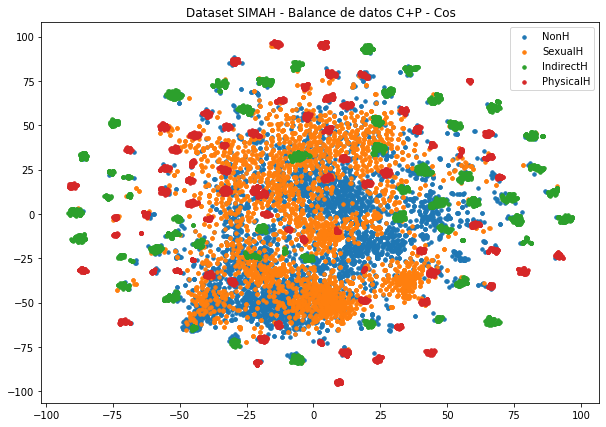

In [35]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_cp)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset SIMAH - Balance de datos C+P - Cos")
plt.show()

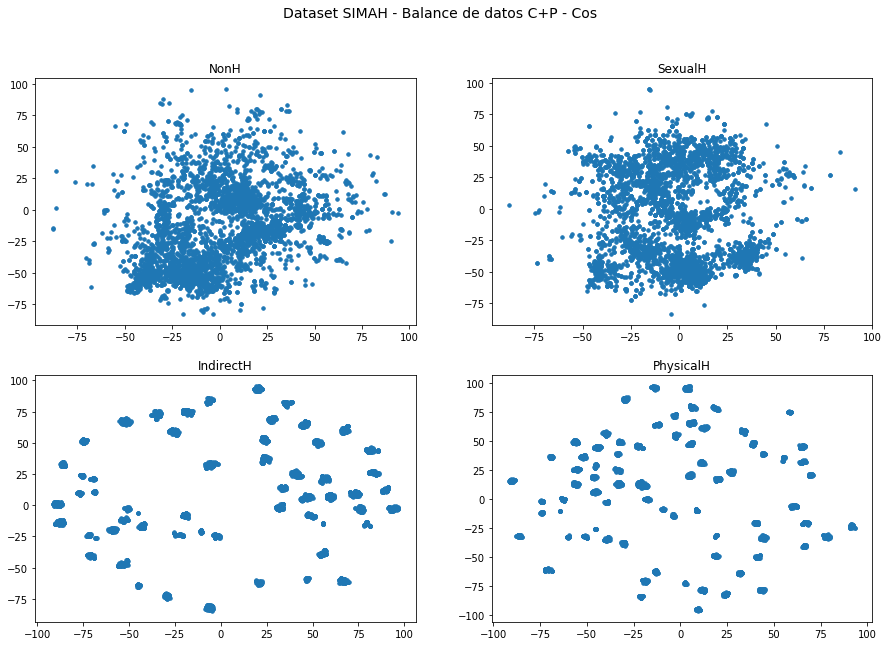

In [36]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))
        

fig.suptitle("Dataset SIMAH - Balance de datos C+P - Cos", fontsize=14)
plt.show()


In [37]:
np.random.shuffle(macro_augmented)
np.save('../Datasets/CSV_Harassment/balance_clase_Pon.npy', macro_augmented)
    

### Sujeto a Embedding BERT sin ponderación target

In [38]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, BERT=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 1079 ejemplos para SexualH
Consultando por la clase SexualH
Entrega label 3
Original: mexican  	Reemplazo:  [('french', 0.791303277015686)]
Original: star  	Reemplazo:  [('gilmore', 0.5528282523155212)]
Sentencia original:
['pic' 'mexican' 'school' 'girl' 'naked' 'melanie' 'safka' 'fake' 'nude'
 'photos' 'hardcore' 'slut' 'movies' 'alicia' 'moore' 'porn' 'star' 'toon'
 'love']
Sentencia final: 3
['pic', 'french', 'school', 'girl', 'naked', 'melanie', 'safka', 'fake', 'nude', 'photos', 'hardcore', 'slut', 'movies', 'alicia', 'moore', 'porn', 'gilmore', 'toon', 'love']


Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Sentencia original:
['girl' 'dirty' 'quarterback' 'latino' 'pokemon' 'young' 'handjob'
 'kissing' 'gangbang' 'w' 'x89' 't' 'co' 'wrm4xo00vj']
Sentencia final: 3
['girl', 'dirty', 'quarterback', 'latino', 'pokemon', 'young', 'handjob', 'kissing', 'gangbang', 'w', 'x89', 't', 'ko', 'wrm4xo00vj']


Original: museum  	Reemplazo:  [('lumpur', 2.00354433059692

Original: ll  	Reemplazo:  [('ii', 0.45271679759025574)]
Sentencia original:
['rt' 'ilovechronicbud' 'do' 'you' 'ever' 'get' 'mad' 'at' 'the'
 'munchies' 'i' 'll' 'be' 'overstuffed' 'and' 'bitch' 'that' 'slut'
 'little' 'debbie' 'is' 'always' 'seducing' 'me']
Sentencia final: 3
['rt', 'ilovechronicbud', 'do', 'you', 'ever', 'get', 'mad', 'at', 'the', 'munchies', 'i', 'ii', 'be', 'overstuffed', 'and', 'bitch', 'that', 'slut', 'little', 'debbie', 'is', 'always', 'seducing', 'me']


Original: chopped  	Reemplazo:  [('present', 1.910130262374878)]
Sentencia original:
['baddknews' 'nigga' 'can' 'x89' 't' 'nomo' 'gettin' 'chopped']
Sentencia final: 3
['baddknews', 'nigga', 'can', 'x89', 't', 'nomo', 'gettin', 'present']


Original: ass  	Reemplazo:  [('asshole', 0.8971388339996338)]
Original: mob  	Reemplazo:  [('multimedia', 0.6136137843132019)]
Sentencia original:
['rt' 'tany' 'vander' 'fucking' 'my' 'wife' 'fuck' 'my' 'ass' 'xxx'
 'forced' 'sex' 'videos' 'xnxx' 'com' 'anulingus' 'xxx' 'p'

Original: tony  	Reemplazo:  [('spawn', 0.43475690484046936)]
Original: born  	Reemplazo:  [('kidnapping', 0.4964964985847473)]
Sentencia original:
['number' 'i' 'got' 'thanos' 'die' 'bitch' 'number' 'whoever' 'made'
 'this' 'is' 'a' 'monster' 'tony' 'is' 'born' 'in' 'may' 'and' 'peter'
 'is' 'born' 'in' 'august' 'y']
Sentencia final: 3
['number', 'i', 'got', 'thanos', 'fifteenth', 'bitch', 'number', 'whoever', 'made', 'this', 'is', 'a', 'monster', 'spawn', 'is', 'kidnapping', 'in', 'may', 'and', 'peter', 'is', 'born', 'in', 'august', 'y']


Original: singles  	Reemplazo:  [('numbers', 2.1973156929016113)]
Sentencia original:
['nostalgiashe' 'number' 'singles' 'and' 'slut' 'bitch' 'is' 'my' 'shit']
Sentencia final: 3
['nostalgiashe', 'number', 'numbers', 'and', 'slut', 'bitch', 'is', 'my', 'shit']


Original: s  	Reemplazo:  [('grimace', 0.40087130665779114)]
Original: been  	Reemplazo:  [('outraged', 0.36391589045524597)]
Sentencia original:
['kayl' 'donald' 'ava' 's' 'been' 'coughing

Original: bitch  	Reemplazo:  [('neuroscience', 0.6286385655403137)]
Sentencia original:
['luna' 'yumizuki' 'gotta' 'focus' 'study' 'thinking' 'useless' 'shit' 'n'
 'nme' 'n' 'nme' 'n' 'nmi' 'brain' 'bitch' 'flo' 'x89']
Sentencia final: 3
['luna', 'yumizuki', 'gotta', 'focus', 'study', 'thinking', 'useless', 'shit', 'n', 'nme', 'n', 'nme', 'n', 'nmi', 'brain', 'neuroscience', 'flo', 'x89']


Original: n  	Reemplazo:  [('right', 3.3739523887634277)]
Sentencia original:
['snapchat' 'xfoxygirl' 'n' 'n' 'nparis' 'unwanted' 'creampie' 'russian'
 'threesome' 'indian' 'porno' 'cumshot' 'nake' 'x89' 't' 'co' 'pxckzy763z']
Sentencia final: 3
['snapchat', 'xfoxygirl', 'right', 'n', 'nparis', 'unwanted', 'creampie', 'russian', 'threesome', 'indian', 'porno', 'cumshot', 'nake', 'x89', 't', 'co', 'pxckzy763z']


Original: dirty  	Reemplazo:  [('shitty', 1.1029514074325562)]
Original: co  	Reemplazo:  [('re', 0.6603502035140991)]
Sentencia original:
['give' 'coochie' 'homeless' 'dirty' 'bitch' 'x89'

Original: amp  	Reemplazo:  [('nedra', 2.395893096923828)]
Sentencia original:
['rt' 'oldabzuka62' 'do' 'you' 'deserve' 'my' 'ass' 'retweet' 'amp' 'like'
 'to' 'see' 'more' 'full' 'videos' 'contact' 'me']
Sentencia final: 3
['rt', 'oldabzuka62', 'do', 'you', 'deserve', 'my', 'ass', 'retweet', 'nedra', 'like', 'to', 'see', 'more', 'full', 'videos', 'contact', 'me']


Original: alice  	Reemplazo:  [('leonid', 0.5068475604057312)]
Original: t  	Reemplazo:  [('company', 0.9294105768203735)]
Original: co  	Reemplazo:  [('re', 1.1914666891098022)]
Sentencia original:
['mad' 'penelope' 'alice' 'dyke' 'serpent' 'slut' 'i' 'x89' 'm' 'going'
 'co' 'x89' 't' 'co' 'wdpailmmbk']
Sentencia final: 3
['mad', 'penelope', 'leonid', 'dyke', 'serpent', 'slut', 'i', 'x89', 'm', 'going', 'co', 'x89', 'company', 're', 'wdpailmmbk']


Original: bitch  	Reemplazo:  [('ass', 1.8169718980789185)]
Sentencia original:
['sceeterrr' 'behind' 'every' 'sassy' 'bitch' 'there' 'x89' 's' 'whose'
 'repeatedly' 'with']
Sen

Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Sentencia original:
['spider' 'slut' 'private' 'doesn' 't' 'going' 'effect' 'grades' 'the'
 'x89' 't' 'co' 'irlk8twwz7']
Sentencia final: 3
['spider', 'slut', 'private', 'doesn', 't', 'going', 'effect', 'grades', 'the', 'x89', 't', 'ko', 'irlk8twwz7']


Original: movies  	Reemplazo:  [('olympics', 2.1765029430389404)]
Sentencia original:
['menis' 'porn' 'black' 'man' 'sex' 'white' 'woman' 'chinese' 'slut'
 'mture' 'porn' 'movies' 'rachel' 'roxx' 'sex' 'videos' 'hot' 'amateurs'
 'rassains' 'fr']
Sentencia final: 3
['menis', 'porn', 'black', 'man', 'sex', 'white', 'woman', 'chinese', 'slut', 'mture', 'porn', 'olympics', 'rachel', 'roxx', 'sex', 'videos', 'hot', 'amateurs', 'rassains', 'fr']


Original: shit  	Reemplazo:  [('work', 3.0306286811828613)]
Sentencia original:
['why' 'are' 'you' 'a' 'darwin' 'partner' 'when' 'you' 'are' 'shit'
 'mechanically' 'and' 'can' 'only' 'kill' 'people' 'by' 'cheesing' 'them'
 'who' 's' 'dick']
Sen

Original: rough  	Reemplazo:  [('nursing', 0.9710006713867188)]
Sentencia original:
['massive' 'cumshot' 'lesbian' 'massage' 'squirt' 'hands' 'extreme'
 'nurse' 'rough' 'lesbian' 'x89' 't' 'co' '0icfacxyxz']
Sentencia final: 3
['massive', 'cumshot', 'lesbian', 'massage', 'squirt', 'hands', 'extreme', 'nurse', 'nursing', 'lesbian', 'x89', 't', 'co', '0icfacxyxz']


Original: jokes  	Reemplazo:  [('stories', 2.085210084915161)]
Sentencia original:
['sm00chess' 'y' 'x89' 'all' 'better' 'x89' 'slut' 'x89' 'x9d' 'jokes'
 'homophobic' 'jokes' 'downey' 'warren' 'beef' 'childish']
Sentencia final: 3
['sm00chess', 'y', 'x89', 'all', 'better', 'x89', 'slut', 'x89', 'x9d', 'stories', 'homophobic', 'jokes', 'downey', 'warren', 'beef', 'childish']


Original: dad  	Reemplazo:  [('insurrection', 0.5197784900665283)]
Sentencia original:
['oooo' 'lots' 'of' 'slut' 'shame' 'in' 'his' 'dad' 'sermon' 'i' 'm'
 'uncomfortable']
Sentencia final: 3
['oooo', 'lots', 'of', 'slut', 'shame', 'in', 'his', 'insurr

Original: t  	Reemplazo:  [('peshawar', 0.7762654423713684)]
Sentencia original:
['hewitt' 'naked' 'gorgeus' 'movie' 'exploited' 'michelle' 'williams'
 'elisha' 'cuthbert' 't' 'co' '4azfmhu0ph']
Sentencia final: 3
['hewitt', 'naked', 'gorgeus', 'movie', 'exploited', 'exploit', 'williams', 'elisha', 'cuthbert', 'peshawar', 'co', '4azfmhu0ph']


Original: orgasm  	Reemplazo:  [('mp3', 0.819277822971344)]
Sentencia original:
['bubble' 'butt' 'rides' 'creampie' 'porn' 'in' 'xxx' 'sex' 'video' 'nsfw'
 'orgasm' 'wet' 'horny' 'pussy' 'sex' 'porn' 'video' 'xxx' 'rt']
Sentencia final: 3
['bubble', 'butt', 'rides', 'creampie', 'porn', 'in', 'xxx', 'sex', 'video', 'nsfw', 'mp3', 'wet', 'horny', 'pussy', 'sex', 'porn', 'video', 'xxx', 'rt']


Original: single  	Reemplazo:  [('catastrophic', 0.38106417655944824)]
Original: t  	Reemplazo:  [('anything', 1.2666152715682983)]
Sentencia original:
['slim' 'don' 'x89' 't' 'single' 'fuck' 'worry' 'about' 'stress' 'don'
 'x89' 't' 'ain' 'x89' 't' 'nothing'

Original: s  	Reemplazo:  [('head', 1.2154064178466797)]
Sentencia original:
['rgay' 'and' 'slut' 'shame' 'bc' 'of' 'melania' 'it' 's' 'rampant'
 'among' 'the' 'lefties']
Sentencia final: 3
['rgay', 'and', 'slut', 'shame', 'bc', 'of', 'melania', 'it', 'head', 'rampant', 'among', 'the', 'lefties']


Original: bitch  	Reemplazo:  [('aback', 1.8297101259231567)]
Sentencia original:
['literally' 'started' 'because' 'belial' 'thirsty' 'horny' 'bitch' 'lrt']
Sentencia final: 3
['literally', 'started', 'because', 'belial', 'thirsty', 'horny', 'aback', 'lrt']


Original: rt  	Reemplazo:  [('brien', 1.2898542881011963)]
Original: easy  	Reemplazo:  [('difficult', 0.7293207049369812)]
Sentencia original:
['rt' 'eo' 'chic' 'of' 'course' 'life' 'is' 'a' 'bitch' 'if' 'it' 'was'
 'a' 'slut' 'it' 'would' 'be' 'easy']
Sentencia final: 3
['brien', 'eo', 'chic', 'of', 'course', 'life', 'is', 'a', 'bitch', 'if', 'it', 'was', 'a', 'slut', 'it', 'would', 'be', 'difficult']


Original: drunk  	Reemplazo:  [

Original: cute  	Reemplazo:  [('boy', 0.937771737575531)]
Original: ava  	Reemplazo:  [('waistband', 0.6160663366317749)]
Original: gets  	Reemplazo:  [('intends', 0.9452124238014221)]
Original: asian  	Reemplazo:  [('eclectic', 0.5434527397155762)]
Original: street  	Reemplazo:  [('gangster', 0.3386339545249939)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: wet  	Reemplazo:  [('bafta', 1.5885505676269531)]
Original: posted  	Reemplazo:  [('stationed', 1.3596384525299072)]
Original: i  	Reemplazo:  [('ii', 1.1427216529846191)]
Original: i  	Reemplazo:  [('year', 0.546310305595398)]
Original: u  	Reemplazo:  [('asshole', 0.3445030748844147)]
Original: rt  	Reemplazo:  [('ii', 0.8497616648674011)]
Original: i  	Reemplazo:  [('parma', 0.5080741047859192)]
Original: be  	Reemplazo:  [('acquire', 0.7952128052711487)]
Original: bitch  	Reemplazo:  [('bastard', 2.6156845092773438)]
Original: nude  	Reemplazo:  [('photographs', 1.3909363746643066)]
Original: photos  	Reemp

Original: describe  	Reemplazo:  [('described', 1.5817135572433472)]
Original: yours  	Reemplazo:  [('ours', 1.1151866912841797)]
Original: yours  	Reemplazo:  [('accomplishments', 0.6254242658615112)]
Original: co  	Reemplazo:  [('company', 1.2077727317810059)]
Original: ability  	Reemplazo:  [('inability', 0.9144707322120667)]
Original: someone  	Reemplazo:  [('call', 3.737717866897583)]
Original: shut  	Reemplazo:  [('edict', 0.4782102704048157)]
Original: anime  	Reemplazo:  [('oricon', 0.9872006773948669)]
Original: bitch  	Reemplazo:  [('lot', 1.9795886278152466)]
Original: remember  	Reemplazo:  [('believe', 1.2636165618896484)]
Original: amp  	Reemplazo:  [('part', 5.358621120452881)]
Original: louis  	Reemplazo:  [('mommy', 1.4709599018096924)]
Original: bitch  	Reemplazo:  [('shitty', 1.036712646484375)]
Original: trying  	Reemplazo:  [('bothering', 1.1342811584472656)]
Original: number  	Reemplazo:  [('torino', 0.5458407402038574)]
Original: n  	Reemplazo:  [('modify', 0.562

Original: bitch  	Reemplazo:  [('shitty', 0.8309832811355591)]
Original: t  	Reemplazo:  [('re', 1.4394575357437134)]
Original: rt  	Reemplazo:  [('bt', 1.2754396200180054)]
Original: dude  	Reemplazo:  [('filippo', 0.5438365340232849)]
Original: s  	Reemplazo:  [('boy', 1.9984452724456787)]
Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Original: u  	Reemplazo:  [('break', 0.8932934999465942)]
Original: broke  	Reemplazo:  [('uc', 0.808671236038208)]
Original: i  	Reemplazo:  [('ii', 2.0711705684661865)]
Original: party  	Reemplazo:  [('liberalism', 0.8167862296104431)]
Original: amp  	Reemplazo:  [('saw', 1.2245763540267944)]
Original: old  	Reemplazo:  [('courageous', 0.5112354159355164)]
Original: kings  	Reemplazo:  [('classrooms', 1.2192788124084473)]
Original: rt  	Reemplazo:  [('mt', 1.1852666139602661)]
Original: n  	Reemplazo:  [('non', 0.7248676419258118)]
Original: t  	Reemplazo:  [('pornography', 0.7758066058158875)]
Original: co  	Reemplazo:  [('company', 1.258508

Original: makes  	Reemplazo:  [('expects', 0.26775068044662476)]
Original: naked  	Reemplazo:  [('good', 1.999581217765808)]
Original: pictures  	Reemplazo:  [('photos', 0.5416967868804932)]
Original: women  	Reemplazo:  [('pictures', 1.312689185142517)]
Original: ear  	Reemplazo:  [('eye', 0.7054654955863953)]
Original: t  	Reemplazo:  [('tn', 0.509250819683075)]
Original: i  	Reemplazo:  [('spot', 1.4837677478790283)]
Original: open  	Reemplazo:  [('direct', 0.7250274419784546)]
Original: human  	Reemplazo:  [('inhuman', 0.7151135802268982)]
Original: amazon  	Reemplazo:  [('girl', 0.34138137102127075)]
Original: do  	Reemplazo:  [('say', 0.526197075843811)]
Original: have  	Reemplazo:  [('be', 1.4041903018951416)]
Original: t  	Reemplazo:  [('eat', 1.10588800907135)]
Original: co  	Reemplazo:  [('company', 1.1512033939361572)]
Original: sharing  	Reemplazo:  [('keeping', 0.8910292983055115)]
Original: video  	Reemplazo:  [('humiliation', 0.5406210422515869)]
Original: t  	Reemplazo:

Original: girlfriend  	Reemplazo:  [('job', 0.8090664148330688)]
Original: bitch  	Reemplazo:  [('bastard', 1.2184427976608276)]
Original: porn  	Reemplazo:  [('boy', 1.0044667720794678)]
Original: bb  	Reemplazo:  [('prostitute', 0.44292396306991577)]
Original: nude  	Reemplazo:  [('japan', 0.5247508883476257)]
Original: teen  	Reemplazo:  [('adolescent', 0.6335468888282776)]
Original: nude  	Reemplazo:  [('doesn', 1.8253037929534912)]
Original: bitch  	Reemplazo:  [('goddamn', 0.5092800855636597)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: bitch  	Reemplazo:  [('heck', 0.6041180491447449)]
Original: big  	Reemplazo:  [('small', 0.8976231217384338)]
Original: year  	Reemplazo:  [('decade', 0.5818718671798706)]
Original: bitch  	Reemplazo:  [('shitty', 0.7159011363983154)]
Original: yeah  	Reemplazo:  [('qaeda', 2.514662265777588)]
Original: have  	Reemplazo:  [('say', 0.5532536506652832)]
Original: kylie  	Reemplazo:  [('della', 0.7913370728492737)]
Original: he

Original: t  	Reemplazo:  [('th', 0.7183132171630859)]
Original: college  	Reemplazo:  [('school', 1.4726271629333496)]
Original: happy  	Reemplazo:  [('pleased', 0.9836336374282837)]
Original: whore  	Reemplazo:  [('brunette', 0.4173942804336548)]
Original: couple  	Reemplazo:  [('handful', 0.8835435509681702)]
Original: peas  	Reemplazo:  [('programmers', 0.8103234171867371)]
Original: uk  	Reemplazo:  [('taxpayer', 0.8591379523277283)]
Original: nipples  	Reemplazo:  [('moans', 0.567907452583313)]
Original: trump  	Reemplazo:  [('rally', 1.253743052482605)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: taylor  	Reemplazo:  [('msc', 0.5519202947616577)]
Original: logan  	Reemplazo:  [('gage', 0.9923631548881531)]
Original: o  	Reemplazo:  [('ml', 0.5802534222602844)]
Original: dirty  	Reemplazo:  [('filthy', 1.3658113479614258)]
Original: m  	Reemplazo:  [('joking', 0.8627204298973083)]
Original: re  	Reemplazo:  [('mommy', 0.9630169868469238)]
Original: available

Original: nylon  	Reemplazo:  [('denim', 0.8229245543479919)]
Original: colombian  	Reemplazo:  [('peruvian', 0.8751764297485352)]
Original: site  	Reemplazo:  [('asteroid', 0.9099347591400146)]
Original: king  	Reemplazo:  [('rabbis', 0.8364040851593018)]
Original: wet  	Reemplazo:  [('hotter', 0.45578065514564514)]
Original: playing  	Reemplazo:  [('licking', 0.9167273640632629)]
Original: smash  	Reemplazo:  [('tease', 0.8379154801368713)]
Original: selling  	Reemplazo:  [('earning', 1.3146625757217407)]
Original: testing  	Reemplazo:  [('inspecting', 1.2896969318389893)]
Original: vi  	Reemplazo:  [('work', 1.1821779012680054)]
Original: bitch  	Reemplazo:  [('princess', 1.4201252460479736)]
Original: knows  	Reemplazo:  [('knew', 1.773506999015808)]
Original: sign  	Reemplazo:  [('game', 0.7987983822822571)]
Original: i  	Reemplazo:  [('ii', 0.8008379340171814)]
Original: people  	Reemplazo:  [('newcomers', 0.37466514110565186)]
Original: co  	Reemplazo:  [('ko', 0.717856466770172

Original: opinion  	Reemplazo:  [('iii', 0.467715859413147)]
Original: sorry  	Reemplazo:  [('glad', 1.1496670246124268)]
Original: ain  	Reemplazo:  [('depart', 0.5219821929931641)]
Original: man  	Reemplazo:  [('want', 1.315001368522644)]
Original: verify  	Reemplazo:  [('confirm', 1.4655976295471191)]
Original: ass  	Reemplazo:  [('butt', 0.8556196093559265)]
Original: release  	Reemplazo:  [('assistance', 1.1998058557510376)]
Original: rt  	Reemplazo:  [('bt', 1.2754396200180054)]
Original: son  	Reemplazo:  [('daughter', 0.648098349571228)]
Original: si  	Reemplazo:  [('set', 1.9866077899932861)]
Original: teenager  	Reemplazo:  [('colossal', 0.428904265165329)]
Original: cum  	Reemplazo:  [('co', 1.260358214378357)]
Original: being  	Reemplazo:  [('becoming', 0.7997865080833435)]
Original: bad  	Reemplazo:  [('good', 0.5851858854293823)]
Original: know  	Reemplazo:  [('realize', 1.536499261856079)]
Original: girls  	Reemplazo:  [('boys', 1.4460328817367554)]
Original: rude  	Reem

Original: nylon  	Reemplazo:  [('korean', 1.3409007787704468)]
Original: amazing  	Reemplazo:  [('astonishing', 0.7494634389877319)]
Original: tits  	Reemplazo:  [('annoyed', 0.4260249137878418)]
Original: cum  	Reemplazo:  [('warmth', 1.2631497383117676)]
Original: nude  	Reemplazo:  [('pmid', 3.1549277305603027)]
Original: y  	Reemplazo:  [('doubt', 1.253334403038025)]
Original: t  	Reemplazo:  [('company', 1.2792677879333496)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: surprise  	Reemplazo:  [('surprising', 0.5769556164741516)]
Original: young  	Reemplazo:  [('new', 0.49360036849975586)]
Original: i  	Reemplazo:  [('want', 1.8620837926864624)]
Original: need  	Reemplazo:  [('want', 1.2380348443984985)]
Original: ll  	Reemplazo:  [('dryly', 0.786949872970581)]
Original: water  	Reemplazo:  [('filippo', 0.25260621309280396)]
Original: amp  	Reemplazo:  [('grandma', 0.7917092442512512)]
Original: uncle  	Reemplazo:  [('grandmother', 0.4505126476287842)]
Original:

Original: western  	Reemplazo:  [('conceptual', 0.6723361015319824)]
Original: tits  	Reemplazo:  [('eighties', 0.38096901774406433)]
Original: group  	Reemplazo:  [('grupo', 0.44636431336402893)]
Original: summers  	Reemplazo:  [('winters', 0.590514600276947)]
Original: fucked  	Reemplazo:  [('furrowed', 2.663278341293335)]
Original: bitch  	Reemplazo:  [('aback', 4.208042621612549)]
Original: need  	Reemplazo:  [('aback', 2.380445718765259)]
Original: movies  	Reemplazo:  [('dolphins', 0.9098021388053894)]
Original: t  	Reemplazo:  [('right', 1.841860294342041)]
Original: naked  	Reemplazo:  [('live', 1.4651650190353394)]
Original: hot  	Reemplazo:  [('lesbian', 0.7840078473091125)]
Original: called  	Reemplazo:  [('named', 0.8932462334632874)]
Original: calling  	Reemplazo:  [('hiring', 0.7841386198997498)]
Original: tragedy  	Reemplazo:  [('tragic', 1.4207127094268799)]
Original: making  	Reemplazo:  [('selecting', 0.5149876475334167)]
Original: bitch  	Reemplazo:  [('asshole', 0.9

Original: whore  	Reemplazo:  [('asshole', 0.9519659876823425)]
Original: i  	Reemplazo:  [('fifteenth', 0.30166786909103394)]
Original: bitch  	Reemplazo:  [('kept', 0.8720911145210266)]
Original: calling  	Reemplazo:  [('thanking', 0.9667977094650269)]
Original: everyone  	Reemplazo:  [('everybody', 0.5873283743858337)]
Original: bad  	Reemplazo:  [('good', 0.45370373129844666)]
Original: rt  	Reemplazo:  [('rr', 1.1534112691879272)]
Original: mode  	Reemplazo:  [('asleep', 1.337607979774475)]
Original: coming  	Reemplazo:  [('looming', 0.4777325391769409)]
Original: bitch  	Reemplazo:  [('bring', 1.377510666847229)]
Original: m  	Reemplazo:  [('m2', 0.7273045182228088)]
Original: joke  	Reemplazo:  [('joking', 1.310413122177124)]
Original: s  	Reemplazo:  [('direction', 0.4679366648197174)]
Original: cum  	Reemplazo:  [('case', 1.7788612842559814)]
Original: world  	Reemplazo:  [('city', 0.8209090232849121)]
Original: country  	Reemplazo:  [('time', 1.6062581539154053)]
Original: li

# terms modificados promedio 1.7126969416126043 términos por sentencia
Largo de sentencia promedio 17.85542168674699 términos por sentencia
No se generan ejemplos
new_sample shpe (3661, 3)
Resumen de modificaciones: {'JJ': 152, 'NN': 1266, 'VB': 73, 'NNS': 137, 'VBG': 89, 'VBD': 25, 'VBZ': 38, 'VBN': 43, 'JJS': 8, 'VBP': 17}
Este proceso tomó 34.41431260108948 seg


Generando 0 ejemplos para NonH
Consultando por la clase NonH
Entrega label 0
No se generan ejemplos
new_sample shpe (3661, 3)
Resumen de modificaciones: {}
Este proceso tomó 0.4346497058868408 seg


Generando 3585 ejemplos para PhysicalH
Consultando por la clase PhysicalH
Entrega label 2
Original: indian  	Reemplazo:  [('african', 1.4114446640014648)]
Sentencia original:
['deepthroat' 'cumshot' 'perfect' 'boobs' 'jewish' 'indian' 'pussy'
 'naked' 'lesbian' 'japanese' 'beaut' 'x89' 't' 'co' 'gfwxstn2fk']
Sentencia final: 2
['deepthroat', 'cumshot', 'perfect', 'boobs', 'jewish', 'african', 'pussy', 'naked', 'lesbian', 'japane

Original: school  	Reemplazo:  [('today', 0.7705385088920593)]
Sentencia original:
['i' 'know' 'you' 're' 'ready' 'this' 'dumb' 'ass' 'slut' 'go' 'do' 'your'
 'homework' 'bitch' 'you' 'got' 'school' 'tomorrow']
Sentencia final: 2
['i', 'know', 'you', 're', 'ready', 'this', 'dumb', 'ass', 'slut', 'go', 'do', 'your', 'homework', 'bitch', 'you', 'got', 'today', 'tomorrow']


Original: m  	Reemplazo:  [('time', 1.912871241569519)]
Original: bitch  	Reemplazo:  [('shit', 1.086834192276001)]
Sentencia original:
['rt' 'quinnceylon' 'i' 'm' 'not' 'about' 'to' 'do' 'this' 'on' 'amp'
 'off' 'shit' 'with' 'niggas' 'or' 'bitch' 'either' 'we' 'fuck' 'with'
 'eachother' 'or' 'we' 'don' 't' 'we' 'cool' 'or' 'we' 'no']
Sentencia final: 2
['rt', 'quinnceylon', 'i', 'time', 'not', 'about', 'to', 'do', 'this', 'on', 'amp', 'off', 'shit', 'with', 'niggas', 'or', 'shit', 'either', 'we', 'fuck', 'with', 'eachother', 'or', 'we', 'don', 't', 'we', 'cool', 'or', 'we', 'no']


Original: amateur  	Reemplazo:  [(

Original: crap  	Reemplazo:  [('shit', 2.3074049949645996)]
Sentencia original:
['briannawu' 'everybody' 'gets' 'death' 'threats' 'are' 'you' 'still'
 'bitch' 'about' 'that' 'no' 'one' 'cares' 'most' 'of' 'that' 'crap' 'you'
 'mad']
Sentencia final: 2
['briannawu', 'everybody', 'gets', 'death', 'deaths', 'are', 'you', 'still', 'bitch', 'about', 'that', 'no', 'one', 'cares', 'least', 'of', 'that', 'shit', 'you', 'mad']


Original: be  	Reemplazo:  [('get', 1.206167459487915)]
Sentencia original:
['all' 'this' 'is' 'meant' 'to' 'destabilize' 'a' 'less' 'aware' 'person'
 'and' 'sicken' 'or' 'even' 'kill' 'her' 'which' 'can' 'never' 'be' 'the'
 'case' 'with']
Sentencia final: 2
['all', 'this', 'is', 'meant', 'to', 'destabilize', 'a', 'less', 'aware', 'person', 'and', 'sicken', 'or', 'even', 'kill', 'her', 'which', 'can', 'never', 'get', 'the', 'case', 'with']


Original: repeat  	Reemplazo:  [('repetition', 1.1619384288787842)]
Original: doesn  	Reemplazo:  [('humiliation', 0.3725613355636

Original: s  	Reemplazo:  [('put', 0.7283769845962524)]
Sentencia original:
['emilysuess' 'let' 's' 'add' 'slut' 'shame' 'melania' 'to' 'this' 'she'
 's' 'horrible' 'in' 'about' 'number' 'ways' 'we' 'shouldn' 't' 'have'
 'to' 'fixate' 'on' 'her' 'modeling' 'past']
Sentencia final: 2
['emilysuess', 'let', 'put', 'add', 'slut', 'shame', 'melania', 'to', 'this', 'she', 's', 'horrible', 'in', 'about', 'number', 'ways', 'we', 'shouldn', 't', 'have', 'to', 'fixate', 'on', 'her', 'modeling', 'past']


Original: suicidal  	Reemplazo:  [('set', 1.169223427772522)]
Sentencia original:
['rt' 'its' 'khries' 'me' 'sometimes' 'i' 'want' 'to' 'punch' 'you' 'in'
 'the' 'face' 'ava' 'i' 'wish' 'you' 'would' 'i' 'm' 'a' 'kinky' 'bitch'
 'nah' 'bitch' 'you' 'suicidal' 'there' 'is']
Sentencia final: 2
['rt', 'its', 'khries', 'me', 'sometimes', 'i', 'want', 'to', 'punch', 'you', 'in', 'the', 'face', 'ava', 'i', 'wish', 'you', 'would', 'i', 'm', 'a', 'kinky', 'bitch', 'nah', 'bitch', 'you', 'set', 'there', 

Original: black  	Reemplazo:  [('other', 0.6858872771263123)]
Sentencia original:
['free' 'teen' 'porn' 'first' 'time' 'hot' 'sexey' 'woman' 'downloadfree'
 'porn' 'movies' 'creampire' 'girl' 'guys' 'with' 'abs' 'having' 'sex'
 'black' 'se']
Sentencia final: 2
['free', 'teen', 'porn', 'first', 'time', 'hot', 'sexey', 'woman', 'downloadfree', 'porn', 'girls', 'creampire', 'girl', 'guys', 'with', 'bananas', 'having', 'sex', 'other', 'se']


Original: innocent  	Reemplazo:  [('brunette', 0.699449896812439)]
Sentencia original:
['rt' '69hot4' 'anna' 'kendrick' 'seems' 'like' 'that' 'cute' 'innocent'
 'girl' 'who' 's' 'secretly' 'a' 'dirty' 'little' 'slut' 'in' 'bed']
Sentencia final: 2
['rt', '69hot4', 'anna', 'kendrick', 'seems', 'like', 'that', 'cute', 'brunette', 'girl', 'who', 's', 'secretly', 'a', 'dirty', 'little', 'slut', 'in', 'bed']


Original: i  	Reemplazo:  [('found', 1.2192199230194092)]
Sentencia original:
['rt' 'saltzmcn' 'idk' 'which' 'fugly' 'slut' 'told' 'shay' 'to' 'kill

Original: wall  	Reemplazo:  [('building', 1.0023618936538696)]
Sentencia original:
['rt' 'krassenstein' 'you' 'can' 't' 'make' 'this' 'stuff' 'up' 'the'
 'build' 'the' 'wall' 'gofundme' 'has' 'failed' 'after' 'gofundme'
 'canceled' 'the' 'campaign' 'for' 'violati']
Sentencia final: 2
['rt', 'krassenstein', 'you', 'can', 't', 'make', 'this', 'stuff', 'up', 'the', 'build', 'the', 'building', 'gofundme', 'has', 'failed', 'after', 'gofundme', 'canceled', 'the', 'campaign', 'for', 'violati']


Original: amp  	Reemplazo:  [('tuba', 0.7900078296661377)]
Original: fat  	Reemplazo:  [('tak', 1.462386131286621)]
Sentencia original:
['me' 'amp' 'ava' 'just' 'took' 'a' 'fat' 'ass' 'nap']
Sentencia final: 2
['me', 'tuba', 'ava', 'just', 'took', 'a', 'tak', 'ass', 'nap']


Original: f  	Reemplazo:  [('st', 1.1146873235702515)]
Sentencia original:
['between' 'her' 'son' 'telling' 'people' 'on' 'the' 'internet' 'to'
 'kill' 'themselves' 'and' 'her' 'husband' 'calling' 'kamala' 'harris' 'a'
 'slut' 'o

Original: t  	Reemplazo:  [('rouen', 0.29968902468681335)]
Original: do  	Reemplazo:  [('disclose', 0.21679911017417908)]
Original: comment  	Reemplazo:  [('tell', 1.194893479347229)]
Sentencia original:
['ok' 'so' 'what' 'you' 'shouldn' 't' 'do' 'is' 'comment' 'on' 'jordyn'
 's' 'pic' 'telling' 'her' 'to' 'kill' 'her' 'self' 'and' 'slut' 'shame'
 'her' 'that' 's' 'just' 'messy']
Sentencia final: 2
['ok', 'so', 'what', 'you', 'shouldn', 'rouen', 'disclose', 'is', 'tell', 'on', 'jordyn', 's', 'pic', 'telling', 'her', 'to', 'kill', 'her', 'self', 'and', 'slut', 'shame', 'her', 'that', 's', 'just', 'messy']


Original: bitch  	Reemplazo:  [('protege', 0.7595729827880859)]
Sentencia original:
['i' 'know' 'you' 're' 'ready' 'this' 'dumb' 'ass' 'slut' 'go' 'do' 'your'
 'homework' 'bitch' 'you' 'got' 'school' 'tomorrow']
Sentencia final: 2
['i', 'know', 'you', 're', 'ready', 'this', 'dumb', 'ass', 'slut', 'go', 'do', 'your', 'homework', 'protege', 'you', 'got', 'school', 'tomorrow']


Origina

Original: m  	Reemplazo:  [('metre', 1.983080267906189)]
Sentencia original:
['i' 'remember' 'when' 'i' 'was' 'in' '6th' 'grade' 'all' 'the' 'girls'
 'in' '8th' 'grade' 'bullied' 'me' 'for' 'having' 'red' 'hair' 'they'
 'would' 'call' 'm']
Sentencia final: 2
['i', 'remember', 'when', 'i', 'was', 'in', '6th', 'grade', 'all', 'the', 'boys', 'in', '8th', 'grade', 'bullied', 'me', 'for', 'having', 'red', 'hair', 'they', 'would', 'call', 'metre']


Original: fat  	Reemplazo:  [('subcommittee', 1.0200210809707642)]
Sentencia original:
['personal' 'trainer' 'so' 'tell' 'me' 'a' 'bit' 'about' 'yourself'
 'neenel' 'my' 'life' 'motto' 'is' 'nobody' 'likes' 'a' 'fat' 'bitch']
Sentencia final: 2
['personal', 'trainer', 'so', 'tell', 'me', 'a', 'bit', 'about', 'yourself', 'neenel', 'my', 'life', 'motto', 'is', 'nobody', 'likes', 'a', 'subcommittee', 'bitch']


Original: ll  	Reemplazo:  [('king', 1.143593192100525)]
Original: kill  	Reemplazo:  [('ii', 0.6829630136489868)]
Sentencia original:
['rt'

Original: don  	Reemplazo:  [('rouen', 0.23728187382221222)]
Original: t  	Reemplazo:  [('misunderstood', 0.3070405125617981)]
Original: know  	Reemplazo:  [('do', 0.3212408125400543)]
Sentencia original:
['sassy' 'wants' 'signing' 'first' 'prepare' 'good' 'don' 't' 'know' 'x89'
 't' 'co' 'qiqgib17ik']
Sentencia final: 2
['sassy', 'wants', 'signing', 'first', 'prepare', 'good', 'rouen', 'misunderstood', 'do', 'x89', 't', 'co', 'qiqgib17ik']


Original: calling  	Reemplazo:  [('moaning', 0.872592568397522)]
Sentencia original:
['bbadicali' 'sarcasticfem23' 'msvanillarose' 'facebook' 'habitually'
 'harass' 'calling' 'addicted' 'druggy' 'hooker' 'for' 'x89']
Sentencia final: 2
['bbadicali', 'sarcasticfem23', 'msvanillarose', 'facebook', 'habitually', 'harass', 'moaning', 'addicted', 'druggy', 'hooker', 'for', 'x89']


Original: tight  	Reemplazo:  [('mommy', 0.9154031872749329)]
Original: little  	Reemplazo:  [('expansive', 0.4538785219192505)]
Sentencia original:
['p0rnsfw' 'daddy' 'beha

Original: girl  	Reemplazo:  [('dude', 0.6923455595970154)]
Original: abs  	Reemplazo:  [('bananas', 0.5901508927345276)]
Original: sex  	Reemplazo:  [('tan', 0.48615792393684387)]
Sentencia original:
['free' 'teen' 'porn' 'first' 'time' 'hot' 'sexey' 'woman' 'downloadfree'
 'porn' 'movies' 'creampire' 'girl' 'guys' 'with' 'abs' 'having' 'sex'
 'black' 'se']
Sentencia final: 2
['free', 'teen', 'porn', 'first', 'time', 'hot', 'sexey', 'woman', 'downloadfree', 'porn', 'movies', 'creampire', 'dude', 'guys', 'with', 'bananas', 'having', 'tan', 'black', 'se']


Original: seems  	Reemplazo:  [('appears', 0.9670163989067078)]
Sentencia original:
['rt' '69hot4' 'anna' 'kendrick' 'seems' 'like' 'that' 'cute' 'innocent'
 'girl' 'who' 's' 'secretly' 'a' 'dirty' 'little' 'slut' 'in' 'bed']
Sentencia final: 2
['rt', '69hot4', 'anna', 'kendrick', 'appears', 'like', 'that', 'cute', 'innocent', 'girl', 'who', 's', 'secretly', 'a', 'dirty', 'little', 'slut', 'in', 'bed']


Original: told  	Reemplazo:  

Original: i  	Reemplazo:  [('ii', 1.4396874904632568)]
Original: self  	Reemplazo:  [('eh', 0.5726678371429443)]
Original: daughters  	Reemplazo:  [('smashwords', 3.6742756366729736)]
Original: have  	Reemplazo:  [('do', 2.1067521572113037)]
Original: see  	Reemplazo:  [('find', 1.2046388387680054)]
Original: snap  	Reemplazo:  [('map', 0.5881862044334412)]
Original: is  	Reemplazo:  [('goes', 0.775989830493927)]
Original: porn  	Reemplazo:  [('freed', 0.482852041721344)]
Original: porn  	Reemplazo:  [('pornography', 0.6162540316581726)]
Original: se  	Reemplazo:  [('brown', 0.4973604083061218)]
Original: kendrick  	Reemplazo:  [('congressman', 0.7862545847892761)]
Original: dirty  	Reemplazo:  [('bit', 1.2345598936080933)]
Original: herself  	Reemplazo:  [('oneself', 0.7072619795799255)]
Original: find  	Reemplazo:  [('go', 1.2398463487625122)]
Original: boy  	Reemplazo:  [('lankan', 2.7053797245025635)]
Original: y  	Reemplazo:  [('le', 0.7258784770965576)]
Original: t  	Reemplazo:  

Original: wants  	Reemplazo:  [('has', 1.1606253385543823)]
Original: t  	Reemplazo:  [('understand', 0.7917193174362183)]
Original: tight  	Reemplazo:  [('mommy', 0.48344120383262634)]
Original: don  	Reemplazo:  [('parma', 0.3018757402896881)]
Original: x  	Reemplazo:  [('lumpur', 3.619704008102417)]
Original: much  	Reemplazo:  [('considerable', 1.1971851587295532)]
Original: dream  	Reemplazo:  [('chop', 0.6129453778266907)]
Original: jax  	Reemplazo:  [('slightest', 1.4104599952697754)]
Original: rt  	Reemplazo:  [('doesn', 0.8925934433937073)]
Original: ass  	Reemplazo:  [('cover', 0.8205423951148987)]
Original: rt  	Reemplazo:  [('lankan', 1.3743622303009033)]
Original: jealous  	Reemplazo:  [('black', 1.8598488569259644)]
Original: bitch  	Reemplazo:  [('cerambycidae', 2.6177380084991455)]
Original: minor  	Reemplazo:  [('slight', 0.7313359379768372)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: co  	Reemplazo:  [('company', 1.205069899559021)]
Orig

Original: comment  	Reemplazo:  [('ba', 0.4792817234992981)]
Original: amp  	Reemplazo:  [('shoot', 0.8835577368736267)]
Original: killed  	Reemplazo:  [('filmed', 2.008206605911255)]
Original: white  	Reemplazo:  [('black', 3.5723366737365723)]
Original: murderer  	Reemplazo:  [('pull', 2.1427440643310547)]
Original: know  	Reemplazo:  [('be', 0.4929136633872986)]
Original: dumb  	Reemplazo:  [('doorbell', 1.383729338645935)]
Original: go  	Reemplazo:  [('be', 0.5029217004776001)]
Original: bitch  	Reemplazo:  [('gotta', 1.4371330738067627)]
Original: i  	Reemplazo:  [('ii', 1.528463363647461)]
Original: m  	Reemplazo:  [('re', 1.1301510334014893)]
Original: don  	Reemplazo:  [('doesn', 2.505390167236328)]
Original: single  	Reemplazo:  [('professional', 1.2177515029907227)]
Original: cock  	Reemplazo:  [('pmid', 1.2476202249526978)]
Original: wrong  	Reemplazo:  [('palestinian', 0.7564951181411743)]
Original: family  	Reemplazo:  [('beat', 0.9474095702171326)]
Original: ava  	Reempla

Original: stern  	Reemplazo:  [('seaman', 1.1088699102401733)]
Original: needs  	Reemplazo:  [('rights', 4.6569671630859375)]
Original: i  	Reemplazo:  [('recall', 1.3026288747787476)]
Original: i  	Reemplazo:  [('penultimate', 0.430806040763855)]
Original: hair  	Reemplazo:  [('crimson', 0.8520023822784424)]
Original: call  	Reemplazo:  [('ft', 2.0106208324432373)]
Original: i  	Reemplazo:  [('recommend', 0.8238592743873596)]
Original: are  	Reemplazo:  [('am', 1.0795615911483765)]
Original: cares  	Reemplazo:  [('cooks', 0.6845898032188416)]
Original: be  	Reemplazo:  [('get', 0.7241060733795166)]
Original: cast  	Reemplazo:  [('wrought', 0.7209782004356384)]
Original: rape  	Reemplazo:  [('kidnapping', 0.8002351522445679)]
Original: matter  	Reemplazo:  [('didn', 0.9469343423843384)]
Original: name  	Reemplazo:  [('form', 0.7188467383384705)]
Original: is  	Reemplazo:  [('has', 0.5295039415359497)]
Original: likely  	Reemplazo:  [('probable', 0.7119733691215515)]
Original: be  	Reem

Original: makes  	Reemplazo:  [('has', 0.889149010181427)]
Original: hall  	Reemplazo:  [('day', 2.093695878982544)]
Original: committed  	Reemplazo:  [('sentenced', 1.269374966621399)]
Original: few  	Reemplazo:  [('oblivious', 0.5354945063591003)]
Original: called  	Reemplazo:  [('termed', 0.8516601324081421)]
Original: t  	Reemplazo:  [('bar', 1.9711813926696777)]
Original: nothing  	Reemplazo:  [('everything', 1.176876425743103)]
Original: s  	Reemplazo:  [('told', 1.3929921388626099)]
Original: telling  	Reemplazo:  [('informing', 0.8813256025314331)]
Original: white  	Reemplazo:  [('black', 2.0837109088897705)]
Original: i  	Reemplazo:  [('pull', 2.441305160522461)]
Original: ready  	Reemplazo:  [('unwilling', 0.6045308709144592)]
Original: do  	Reemplazo:  [('be', 2.1354892253875732)]
Original: tomorrow  	Reemplazo:  [('yesterday', 0.7944307327270508)]
Original: single  	Reemplazo:  [('solitary', 0.7265488505363464)]
Original: amateur  	Reemplazo:  [('girl', 0.744934618473053)]


Original: dirty  	Reemplazo:  [('bit', 1.1592477560043335)]
Original: rt  	Reemplazo:  [('briefing', 0.6320301294326782)]
Original: is  	Reemplazo:  [('has', 1.2588975429534912)]
Original: fuck  	Reemplazo:  [('screw', 0.6785600781440735)]
Original: gonna  	Reemplazo:  [('ll', 0.46215519309043884)]
Original: destroy  	Reemplazo:  [('destroyed', 0.8850175738334656)]
Original: pussy  	Reemplazo:  [('suppress', 1.2556886672973633)]
Original: kitten  	Reemplazo:  [('have', 2.8629159927368164)]
Original: don  	Reemplazo:  [('didn', 0.8077331185340881)]
Original: try  	Reemplazo:  [('roi', 0.8278248906135559)]
Original: body  	Reemplazo:  [('torso', 0.5556802749633789)]
Original: defend  	Reemplazo:  [('oppose', 0.5953084230422974)]
Original: okay  	Reemplazo:  [('alright', 0.5298231244087219)]
Original: glasgow  	Reemplazo:  [('concept', 1.2749654054641724)]
Original: stern  	Reemplazo:  [('seaman', 1.1088699102401733)]
Original: head  	Reemplazo:  [('face', 2.2394187450408936)]
Original: l

Original: ll  	Reemplazo:  [('gonna', 2.126140594482422)]
Original: t  	Reemplazo:  [('inhibit', 0.6290759444236755)]
Original: number  	Reemplazo:  [('amount', 1.3099757432937622)]
Original: fat  	Reemplazo:  [('part', 5.083679676055908)]
Original: type  	Reemplazo:  [('chick', 0.8036121129989624)]
Original: let  	Reemplazo:  [('allow', 0.511199951171875)]
Original: ways  	Reemplazo:  [('revolves', 1.749145269393921)]
Original: shouldn  	Reemplazo:  [('possess', 0.343318372964859)]
Original: i  	Reemplazo:  [('need', 1.3225295543670654)]
Original: punch  	Reemplazo:  [('need', 1.3505587577819824)]
Original: face  	Reemplazo:  [('head', 0.5024132132530212)]
Original: bitch  	Reemplazo:  [('bastard', 0.8343329429626465)]
Original: oh  	Reemplazo:  [('stop', 1.1419072151184082)]
Original: get  	Reemplazo:  [('do', 1.27733314037323)]
Original: minutes  	Reemplazo:  [('seconds', 0.8795652389526367)]
Original: t  	Reemplazo:  [('documentation', 0.401591420173645)]
Original: loses  	Reemplaz

Original: grave  	Reemplazo:  [('deserve', 1.373231053352356)]
Original: divine  	Reemplazo:  [('crambidae', 1.29379141330719)]
Original: pete  	Reemplazo:  [('aback', 4.631592750549316)]
Original: day  	Reemplazo:  [('night', 0.8094854354858398)]
Original: fl  	Reemplazo:  [('youthful', 0.32976773381233215)]
Original: daddy  	Reemplazo:  [('teenage', 1.2328673601150513)]
Original: gaping  	Reemplazo:  [('missing', 1.0648082494735718)]
Original: i  	Reemplazo:  [('left', 1.2309057712554932)]
Original: fucking  	Reemplazo:  [('freaking', 0.7922903895378113)]
Original: i  	Reemplazo:  [('ll', 2.120692014694214)]
Original: kill  	Reemplazo:  [('destroy', 0.5040978193283081)]
Original: whore  	Reemplazo:  [('assassinate', 0.886812150478363)]
Original: s  	Reemplazo:  [('ii', 0.7124670743942261)]
Original: sucks  	Reemplazo:  [('remains', 0.7165122628211975)]
Original: have  	Reemplazo:  [('run', 1.2311502695083618)]
Original: devil  	Reemplazo:  [('satan', 0.8433319330215454)]
Original: is

Original: crap  	Reemplazo:  [('shit', 2.3074049949645996)]
Original: meant  	Reemplazo:  [('mean', 0.8194206357002258)]
Original: name  	Reemplazo:  [('title', 1.1801053285598755)]
Original: ass  	Reemplazo:  [('head', 1.2382264137268066)]
Original: thing  	Reemplazo:  [('isbn', 3.3661892414093018)]
Original: happened  	Reemplazo:  [('occurred', 1.9413620233535767)]
Original: bedroom  	Reemplazo:  [('wasn', 1.3253288269042969)]
Original: non  	Reemplazo:  [('islamist', 0.4582362174987793)]
Original: white  	Reemplazo:  [('black', 1.5124459266662598)]
Original: agree  	Reemplazo:  [('aback', 1.8355909585952759)]
Original: t  	Reemplazo:  [('cassie', 1.9813673496246338)]
Original: videos  	Reemplazo:  [('films', 1.201535701751709)]
Original: teen  	Reemplazo:  [('cookie', 0.7981308698654175)]
Original: been  	Reemplazo:  [('laughed', 2.149301767349243)]
Original: rt  	Reemplazo:  [('goddamn', 0.8153200745582581)]
Original: perfect  	Reemplazo:  [('judaism', 1.5770658254623413)]
Original

Original: girl  	Reemplazo:  [('boy', 1.3167150020599365)]
Original: same  	Reemplazo:  [('utilized', 0.4851166605949402)]
Original: shame  	Reemplazo:  [('trail', 1.9398906230926514)]
Original: t  	Reemplazo:  [('hadn', 0.5108636617660522)]
Original: have  	Reemplazo:  [('do', 0.7271146774291992)]
Original: bitch  	Reemplazo:  [('bastard', 1.603534460067749)]
Original: shame  	Reemplazo:  [('isn', 1.1618131399154663)]
Original: gay  	Reemplazo:  [('perceive', 0.5215599536895752)]
Original: few  	Reemplazo:  [('solitary', 0.5076624155044556)]
Original: consulate  	Reemplazo:  [('something', 0.83912193775177)]
Original: loses  	Reemplazo:  [('charities', 1.02889883518219)]
Original: everything  	Reemplazo:  [('devastation', 0.6396204829216003)]
Original: trial  	Reemplazo:  [('tb', 0.6369903683662415)]
Original: please  	Reemplazo:  [('lumpur', 3.153285264968872)]
Original: i  	Reemplazo:  [('death', 0.7763552665710449)]
Original: s  	Reemplazo:  [('day', 1.1506739854812622)]
Original: 

Original: didn  	Reemplazo:  [('doesn', 1.4389393329620361)]
Original: t  	Reemplazo:  [('couldn', 0.5372937321662903)]
Original: trying  	Reemplazo:  [('attempting', 1.0662548542022705)]
Original: stop  	Reemplazo:  [('northampton', 0.5464077591896057)]
Original: saying  	Reemplazo:  [('stating', 0.47317326068878174)]
Original: is  	Reemplazo:  [('has', 2.055473804473877)]
Original: needs  	Reemplazo:  [('people', 4.3194499015808105)]
Original: call  	Reemplazo:  [('summon', 0.7245654463768005)]
Original: bitch  	Reemplazo:  [('asteroid', 1.4791178703308105)]
Original: rt  	Reemplazo:  [('quantity', 0.8652055263519287)]
Original: kill  	Reemplazo:  [('destroy', 0.498433917760849)]
Original: i  	Reemplazo:  [('recommend', 0.7427497506141663)]
Original: are  	Reemplazo:  [('am', 0.6361103653907776)]
Original: crap  	Reemplazo:  [('shit', 2.3074049949645996)]
Original: person  	Reemplazo:  [('aback', 1.6764894723892212)]
Original: case  	Reemplazo:  [('stay', 0.7151269912719727)]
Origina

Original: t  	Reemplazo:  [('re', 1.2231330871582031)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: i  	Reemplazo:  [('ii', 1.2971667051315308)]
Original: type  	Reemplazo:  [('kind', 1.3895478248596191)]
Original: guy  	Reemplazo:  [('man', 1.3280936479568481)]
Original: used  	Reemplazo:  [('reused', 0.7613984942436218)]
Original: same  	Reemplazo:  [('utilized', 0.494491308927536)]
Original: have  	Reemplazo:  [('allow', 0.7684069275856018)]
Original: face  	Reemplazo:  [('parma', 0.5225507616996765)]
Original: bitch  	Reemplazo:  [('scowl', 0.7823647856712341)]
Original: oh  	Reemplazo:  [('ah', 0.7753345966339111)]
Original: makes  	Reemplazo:  [('has', 1.2658888101577759)]
Original: ok  	Reemplazo:  [('aback', 1.637843370437622)]
Original: punched  	Reemplazo:  [('been', 2.9095029830932617)]
Original: called  	Reemplazo:  [('titled', 1.386452078819275)]
Original: twist  	Reemplazo:  [('wentworth', 0.5554977059364319)]
Original: girls  	Reemplazo:  [('boys

Original: rt  	Reemplazo:  [('briefing', 0.6466646790504456)]
Original: be  	Reemplazo:  [('save', 1.2781648635864258)]
Original: rt  	Reemplazo:  [('rr', 0.8526442050933838)]
Original: violent  	Reemplazo:  [('ufc', 1.3832532167434692)]
Original: slapped  	Reemplazo:  [('wondered', 1.8816922903060913)]
Original: calling  	Reemplazo:  [('yearning', 0.49472135305404663)]
Original: girl  	Reemplazo:  [('call', 0.8626397848129272)]
Original: drag  	Reemplazo:  [('attempt', 0.9415554404258728)]
Original: has  	Reemplazo:  [('is', 0.7246004343032837)]
Original: being  	Reemplazo:  [('stopping', 0.8537916541099548)]
Original: powerful  	Reemplazo:  [('formidable', 0.8130852580070496)]
Original: bet  	Reemplazo:  [('potent', 0.8342928290367126)]
Original: head  	Reemplazo:  [('skull', 0.8028947710990906)]
Original: call  	Reemplazo:  [('ad', 1.1586582660675049)]
Original: bitch  	Reemplazo:  [('queen', 2.0452685356140137)]
Original: i  	Reemplazo:  [('gottingen', 0.3098212778568268)]
Original

Original: rt  	Reemplazo:  [('screw', 0.8470898866653442)]
Original: indian  	Reemplazo:  [('moroccan', 0.6490769386291504)]
Original: pussy  	Reemplazo:  [('jew', 0.6837027072906494)]
Original: naked  	Reemplazo:  [('peruvian', 0.2994135916233063)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: manchester  	Reemplazo:  [('kill', 2.508524179458618)]
Original: co  	Reemplazo:  [('company', 1.258508324623108)]
Original: servant  	Reemplazo:  [('housekeeper', 0.8006992340087891)]
Original: major  	Reemplazo:  [('significant', 0.7472026348114014)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: baby  	Reemplazo:  [('mommy', 0.36110809445381165)]
Original: daddy  	Reemplazo:  [('tighter', 1.0380700826644897)]
Original: t  	Reemplazo:  [('man', 0.28249576687812805)]
Original: fan  	Reemplazo:  [('ph', 1.210538387298584)]
Original: th  	Reemplazo:  [('ts', 1.2592339515686035)]
Original: shit  	Reemplazo:  [('crap', 0.5103762745857239)]
Original: don  	Reem

Original: kill  	Reemplazo:  [('destroy', 0.8258498907089233)]
Original: throat  	Reemplazo:  [('groin', 0.7337276339530945)]
Original: i  	Reemplazo:  [('ii', 0.46157822012901306)]
Original: daughters  	Reemplazo:  [('smashwords', 3.6742756366729736)]
Original: is  	Reemplazo:  [('has', 2.12740159034729)]
Original: muslim  	Reemplazo:  [('lumpur', 2.3759865760803223)]
Original: sucks  	Reemplazo:  [('remains', 2.873591423034668)]
Original: looking  	Reemplazo:  [('snapping', 0.9074766039848328)]
Original: guys  	Reemplazo:  [('girls', 1.2142183780670166)]
Original: se  	Reemplazo:  [('brown', 0.5160555243492126)]
Original: dirty  	Reemplazo:  [('bit', 1.2345598936080933)]
Original: little  	Reemplazo:  [('much', 3.45757794380188)]
Original: had  	Reemplazo:  [('was', 1.479230284690857)]
Original: gonna  	Reemplazo:  [('gotta', 1.0492709875106812)]
Original: hu  	Reemplazo:  [('pi', 1.180103063583374)]
Original: girl  	Reemplazo:  [('boy', 0.8185479044914246)]
Original: husband  	Reemp

Original: japanese  	Reemplazo:  [('homosexual', 0.9159247279167175)]
Original: devil  	Reemplazo:  [('state', 1.4477828741073608)]
Original: british  	Reemplazo:  [('belgian', 1.3228591680526733)]
Original: major  	Reemplazo:  [('noteworthy', 0.5450799465179443)]
Original: t  	Reemplazo:  [('re', 0.7929618954658508)]
Original: baby  	Reemplazo:  [('mommy', 0.3896621763706207)]
Original: tight  	Reemplazo:  [('mommy', 0.9154031872749329)]
Original: open  	Reemplazo:  [('loose', 0.501967191696167)]
Original: get  	Reemplazo:  [('be', 0.3263082802295685)]
Original: th  	Reemplazo:  [('va', 0.747785210609436)]
Original: tied  	Reemplazo:  [('chained', 0.5842999815940857)]
Original: mouth  	Reemplazo:  [('nasal', 0.9768029451370239)]
Original: u  	Reemplazo:  [('bruise', 0.5824041366577148)]
Original: rt  	Reemplazo:  [('bt', 1.2754396200180054)]
Original: tortured  	Reemplazo:  [('tormented', 0.8855463862419128)]
Original: m  	Reemplazo:  [('ma', 0.5126320123672485)]
Original: co  	Reempl

Original: bed  	Reemplazo:  [('room', 1.1878857612609863)]
Original: fat  	Reemplazo:  [('pmid', 2.1534764766693115)]
Original: y  	Reemplazo:  [('yoo', 0.5236573219299316)]
Original: violent  	Reemplazo:  [('brawl', 0.520160436630249)]
Original: slapped  	Reemplazo:  [('wiped', 2.455761194229126)]
Original: boy  	Reemplazo:  [('slap', 0.9119921326637268)]
Original: is  	Reemplazo:  [('gets', 0.3494545519351959)]
Original: y  	Reemplazo:  [('parma', 0.468750923871994)]
Original: trying  	Reemplazo:  [('attempting', 1.5287258625030518)]
Original: defend  	Reemplazo:  [('strive', 0.6037492156028748)]
Original: rape  	Reemplazo:  [('wife', 1.0207273960113525)]
Original: has  	Reemplazo:  [('is', 1.2551393508911133)]
Original: glasgow  	Reemplazo:  [('concept', 1.2749654054641724)]
Original: re  	Reemplazo:  [('assertion', 0.5373135209083557)]
Original: stern  	Reemplazo:  [('seaman', 1.1088699102401733)]
Original: bet  	Reemplazo:  [('greedy', 0.5390540957450867)]
Original: call  	Reempla

Original: beat  	Reemplazo:  [('beating', 1.3313738107681274)]
Original: way  	Reemplazo:  [('time', 1.231123447418213)]
Original: honest  	Reemplazo:  [('anybody', 0.8406677842140198)]
Original: don  	Reemplazo:  [('excellent', 0.8805937170982361)]
Original: t  	Reemplazo:  [('didn', 0.4756194055080414)]
Original: wet  	Reemplazo:  [('vision', 1.2708535194396973)]
Original: dream  	Reemplazo:  [('life', 2.260162115097046)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: baby  	Reemplazo:  [('mommy', 0.3549630343914032)]
Original: daddy  	Reemplazo:  [('opaque', 0.28341302275657654)]
Original: open  	Reemplazo:  [('ferocious', 0.2562362849712372)]
Original: i  	Reemplazo:  [('ii', 1.2619320154190063)]
Original: don  	Reemplazo:  [('didn', 0.8077331185340881)]
Original: get  	Reemplazo:  [('be', 0.7554981708526611)]
Original: t  	Reemplazo:  [('wouldn', 1.4362211227416992)]
Original: girls  	Reemplazo:  [('furlongs', 1.0549479722976685)]
Original: re  	Reemplaz

Original: shot  	Reemplazo:  [('shoot', 0.7519797086715698)]
Original: murderer  	Reemplazo:  [('pull', 2.1427440643310547)]
Original: ass  	Reemplazo:  [('bob', 1.2713350057601929)]
Original: do  	Reemplazo:  [('say', 1.8156429529190063)]
Original: amp  	Reemplazo:  [('part', 2.171481132507324)]
Original: date  	Reemplazo:  [('dad', 0.8082637190818787)]
Original: fucking  	Reemplazo:  [('murdering', 0.7191252708435059)]
Original: divine  	Reemplazo:  [('sublime', 0.7692396640777588)]
Original: young  	Reemplazo:  [('large', 0.7073262929916382)]
Original: daddy  	Reemplazo:  [('youth', 2.690363645553589)]
Original: choking  	Reemplazo:  [('gasping', 0.829852819442749)]
Original: legal  	Reemplazo:  [('lawful', 0.6075153350830078)]
Original: t  	Reemplazo:  [('opaque', 0.5322790741920471)]
Original: hear  	Reemplazo:  [('noisy', 0.33650335669517517)]
Original: fucking  	Reemplazo:  [('freaking', 0.799824595451355)]
Original: stupid  	Reemplazo:  [('defective', 0.5252420902252197)]
Origi

Original: threats  	Reemplazo:  [('threaten', 0.8526914119720459)]
Original: is  	Reemplazo:  [('has', 0.48827654123306274)]
Original: most  	Reemplazo:  [('best', 0.41865649819374084)]
Original: be  	Reemplazo:  [('disclose', 0.9257504940032959)]
Original: rape  	Reemplazo:  [('woman', 3.4772884845733643)]
Original: white  	Reemplazo:  [('black', 0.914752185344696)]
Original: racist  	Reemplazo:  [('menace', 0.7465231418609619)]
Original: panties  	Reemplazo:  [('teens', 0.6443786025047302)]
Original: son  	Reemplazo:  [('man', 1.302600383758545)]
Original: f  	Reemplazo:  [('part', 3.189054489135742)]
Original: beat  	Reemplazo:  [('beating', 0.7496802806854248)]
Original: perfect  	Reemplazo:  [('hebrew', 1.2364485263824463)]
Original: lesbian  	Reemplazo:  [('homosexual', 0.6548195481300354)]
Original: prepare  	Reemplazo:  [('preparation', 0.8646369576454163)]
Original: t  	Reemplazo:  [('tb', 0.41709694266319275)]
Original: facebook  	Reemplazo:  [('noah', 1.9448164701461792)]
Or

Original: s  	Reemplazo:  [('awful', 0.6858248114585876)]
Original: past  	Reemplazo:  [('childhood', 1.239292860031128)]
Original: is  	Reemplazo:  [('has', 1.2818878889083862)]
Original: someone  	Reemplazo:  [('commence', 0.3117890954017639)]
Original: starts  	Reemplazo:  [('entities', 0.39840006828308105)]
Original: thing  	Reemplazo:  [('crap', 0.6364582180976868)]
Original: twist  	Reemplazo:  [('wentworth', 0.5554977059364319)]
Original: shot  	Reemplazo:  [('kill', 0.5089796781539917)]
Original: re  	Reemplazo:  [('want', 0.7767573595046997)]
Original: homework  	Reemplazo:  [('endelle', 1.6369688510894775)]
Original: family  	Reemplazo:  [('beat', 0.9474095702171326)]
Original: gets  	Reemplazo:  [('expects', 0.35801905393600464)]
Original: ass  	Reemplazo:  [('porn', 0.4847467839717865)]
Original: pete  	Reemplazo:  [('aback', 4.631592750549316)]
Original: daddy  	Reemplazo:  [('teenage', 1.7833034992218018)]
Original: amount  	Reemplazo:  [('immature', 0.46456947922706604)]

Original: teen  	Reemplazo:  [('blond', 0.9935657978057861)]
Original: hear  	Reemplazo:  [('noisy', 0.33650335669517517)]
Original: re  	Reemplazo:  [('dumb', 0.7492758631706238)]
Original: chopped  	Reemplazo:  [('chest', 1.4716296195983887)]
Original: kill  	Reemplazo:  [('assassinate', 0.7421782612800598)]
Original: go  	Reemplazo:  [('replace', 1.3087424039840698)]
Original: o  	Reemplazo:  [('och', 0.5452191829681396)]
Original: daughters  	Reemplazo:  [('smashwords', 3.6742756366729736)]
Original: being  	Reemplazo:  [('having', 0.7691299915313721)]
Original: sex  	Reemplazo:  [('brown', 0.4892733693122864)]
Original: kendrick  	Reemplazo:  [('congressman', 0.7862545847892761)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: find  	Reemplazo:  [('go', 0.7238743901252747)]
Original: wanna  	Reemplazo:  [('lumpur', 2.2342982292175293)]
Original: eyes  	Reemplazo:  [('eyebrows', 2.018406867980957)]
Original: anybody  	Reemplazo:  [('anyone', 0.8885179162025452

Original: love  	Reemplazo:  [('heart', 1.2865291833877563)]
Original: is  	Reemplazo:  [('has', 0.45942461490631104)]
Original: major  	Reemplazo:  [('noteworthy', 0.5450799465179443)]
Original: girl  	Reemplazo:  [('girlfriend', 0.5263180732727051)]
Original: call  	Reemplazo:  [('caller', 0.8980014324188232)]
Original: line  	Reemplazo:  [('didn', 0.784409761428833)]
Original: did  	Reemplazo:  [('showed', 1.220640778541565)]
Original: let  	Reemplazo:  [('take', 0.7531130909919739)]
Original: s  	Reemplazo:  [('delight', 0.4657542407512665)]
Original: shouldn  	Reemplazo:  [('hadn', 0.7454556822776794)]
Original: i  	Reemplazo:  [('head', 0.4838729798793793)]
Original: nah  	Reemplazo:  [('bastard', 1.0789408683776855)]
Original: get  	Reemplazo:  [('have', 1.127947449684143)]
Original: shame  	Reemplazo:  [('sorry', 2.318965435028076)]
Original: makes  	Reemplazo:  [('has', 0.8656887412071228)]
Original: gay  	Reemplazo:  [('girl', 0.8018034100532532)]
Original: don  	Reemplazo:  

Original: y  	Reemplazo:  [('parma', 0.468750923871994)]
Original: try  	Reemplazo:  [('ya', 0.8262988328933716)]
Original: trying  	Reemplazo:  [('attempting', 1.5287258625030518)]
Original: shit  	Reemplazo:  [('crap', 0.9299291372299194)]
Original: father  	Reemplazo:  [('boyfriend', 1.4319779872894287)]
Original: stop  	Reemplazo:  [('simeon', 0.4829922020435333)]
Original: disgusting  	Reemplazo:  [('stripping', 1.3938955068588257)]
Original: sl  	Reemplazo:  [('filthy', 0.6950413584709167)]
Original: bitch  	Reemplazo:  [('awful', 1.3222038745880127)]
Original: looking  	Reemplazo:  [('staring', 1.0969542264938354)]
Original: girls  	Reemplazo:  [('women', 2.157660722732544)]
Original: having  	Reemplazo:  [('being', 0.4323798418045044)]
Original: life  	Reemplazo:  [('vibrant', 0.4908130168914795)]
Original: number  	Reemplazo:  [('ii', 0.7626833915710449)]
Original: gets  	Reemplazo:  [('sells', 0.8710840940475464)]
Original: aware  	Reemplazo:  [('conscious', 1.258329153060913

Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: dare  	Reemplazo:  [('chance', 3.0777790546417236)]
Original: d  	Reemplazo:  [('ii', 0.5118901133537292)]
Original: woman  	Reemplazo:  [('prostitute', 0.9392351508140564)]
Original: tortured  	Reemplazo:  [('tormented', 0.8855462074279785)]
Original: baby  	Reemplazo:  [('mommy', 0.43738770484924316)]
Original: yeah  	Reemplazo:  [('shut', 0.49524861574172974)]
Original: is  	Reemplazo:  [('has', 0.46898898482322693)]
Original: t  	Reemplazo:  [('wouldn', 0.8115975856781006)]
Original: co  	Reemplazo:  [('facebook', 0.792966902256012)]
Original: getting  	Reemplazo:  [('being', 2.060908794403076)]
Original: girls  	Reemplazo:  [('daughters', 2.351583242416382)]
Original: re  	Reemplazo:  [('bar', 1.3023958206176758)]
Original: tied  	Reemplazo:  [('chained', 0.5842999815940857)]
Original: is  	Reemplazo:  [('goes', 0.562476396560669)]
Original: tortured  	Reemplazo:  [('mohammed', 0.7867387533187866)]
Original: kill  	

Original: i  	Reemplazo:  [('base', 0.5030882954597473)]
Original: whore  	Reemplazo:  [('aback', 4.135216236114502)]
Original: oh  	Reemplazo:  [('ah', 0.2994160056114197)]
Original: guess  	Reemplazo:  [('ii', 0.3338027596473694)]
Original: sucks  	Reemplazo:  [('people', 1.8184199333190918)]
Original: was  	Reemplazo:  [('talked', 0.8149973154067993)]
Original: abs  	Reemplazo:  [('bananas', 0.5901508927345276)]
Original: se  	Reemplazo:  [('dark', 0.8034388422966003)]
Original: girl  	Reemplazo:  [('girlfriend', 1.0460000038146973)]
Original: little  	Reemplazo:  [('big', 1.3133604526519775)]
Original: bed  	Reemplazo:  [('mattress', 1.2595758438110352)]
Original: ll  	Reemplazo:  [('gonna', 1.0031499862670898)]
Original: be  	Reemplazo:  [('save', 1.3663249015808105)]
Original: fuck  	Reemplazo:  [('shit', 1.2155014276504517)]
Original: y  	Reemplazo:  [('re', 0.8097134828567505)]
Original: kitten  	Reemplazo:  [('say', 1.6933866739273071)]
Original: girl  	Reemplazo:  [('woman', 

Original: terrorism  	Reemplazo:  [('terrorist', 0.8822625279426575)]
Original: non  	Reemplazo:  [('hindu', 0.9050185680389404)]
Original: agree  	Reemplazo:  [('aback', 2.0356605052948)]
Original: t  	Reemplazo:  [('time', 1.2658382654190063)]
Original: sex  	Reemplazo:  [('shit', 2.1575663089752197)]
Original: ex  	Reemplazo:  [('aback', 2.596553325653076)]
Original: indian  	Reemplazo:  [('black', 1.1907830238342285)]
Original: pussy  	Reemplazo:  [('sikh', 0.83979332447052)]
Original: lesbian  	Reemplazo:  [('homosexual', 0.8893840909004211)]
Original: t  	Reemplazo:  [('company', 0.7508358359336853)]
Original: t  	Reemplazo:  [('understand', 0.7585452795028687)]
Original: hot  	Reemplazo:  [('american', 2.0977370738983154)]
Original: wet  	Reemplazo:  [('business', 1.2112122774124146)]
Original: tortured  	Reemplazo:  [('tormented', 0.8203790783882141)]
Original: co  	Reemplazo:  [('part', 2.1458659172058105)]
Original: baby  	Reemplazo:  [('mommy', 0.4444006383419037)]
Original:

Original: deserves  	Reemplazo:  [('graves', 0.6588380932807922)]
Original: victim  	Reemplazo:  [('mahmud', 0.790711522102356)]
Original: porn  	Reemplazo:  [('pmid', 1.7888529300689697)]
Original: chopped  	Reemplazo:  [('aback', 2.280439615249634)]
Original: throat  	Reemplazo:  [('groin', 0.7322165369987488)]
Original: i  	Reemplazo:  [('ii', 0.4990922212600708)]
Original: muslim  	Reemplazo:  [('lumpur', 2.3759865760803223)]
Original: sucks  	Reemplazo:  [('remains', 0.6494045257568359)]
Original: porn  	Reemplazo:  [('day', 0.7713578939437866)]
Original: guys  	Reemplazo:  [('girls', 1.2142183780670166)]
Original: abs  	Reemplazo:  [('bananas', 0.5901508927345276)]
Original: having  	Reemplazo:  [('making', 0.8041954040527344)]
Original: girl  	Reemplazo:  [('adolescent', 0.36295387148857117)]
Original: i  	Reemplazo:  [('found', 0.860075056552887)]
Original: had  	Reemplazo:  [('was', 0.7494696378707886)]
Original: be  	Reemplazo:  [('save', 0.8151606321334839)]
Original: dog  	

Original: amp  	Reemplazo:  [('worthless', 1.2863625288009644)]
Original: gag  	Reemplazo:  [('nasal', 0.9004355072975159)]
Original: look  	Reemplazo:  [('bruise', 0.5948601961135864)]
Original: rt  	Reemplazo:  [('bt', 1.2754396200180054)]
Original: tortured  	Reemplazo:  [('tormented', 0.5469180941581726)]
Original: minor  	Reemplazo:  [('slave', 1.0599652528762817)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: ll  	Reemplazo:  [('gonna', 2.7855465412139893)]
Original: wanna  	Reemplazo:  [('gonna', 2.5532705783843994)]
Original: girl  	Reemplazo:  [('fiancee', 0.5159584879875183)]
Original: responded  	Reemplazo:  [('replied', 1.143289566040039)]
Original: number  	Reemplazo:  [('pmid', 6.122190952301025)]
Original: s  	Reemplazo:  [('felt', 2.1116838455200195)]
Original: shame  	Reemplazo:  [('seat', 1.9035664796829224)]
Original: girl  	Reemplazo:  [('guy', 2.201728582382202)]
Original: number  	Reemplazo:  [('way', 0.7926376461982727)]
Original: ways  	Reemp

Original: i  	Reemplazo:  [('thing', 0.4661741256713867)]
Original: d  	Reemplazo:  [('ll', 1.2789745330810547)]
Original: gonna  	Reemplazo:  [('gotta', 0.5270888209342957)]
Original: guess  	Reemplazo:  [('ii', 0.3281613886356354)]
Original: i  	Reemplazo:  [('ii', 0.5548906922340393)]
Original: deserve  	Reemplazo:  [('become', 1.2447198629379272)]
Original: be  	Reemplazo:  [('maximize', 0.5775648355484009)]
Original: porn  	Reemplazo:  [('space', 0.4916955530643463)]
Original: hot  	Reemplazo:  [('continual', 0.44278931617736816)]
Original: movies  	Reemplazo:  [('girls', 1.4570780992507935)]
Original: black  	Reemplazo:  [('expansive', 0.3262755274772644)]
Original: eyes  	Reemplazo:  [('gazes', 1.2150535583496094)]
Original: fat  	Reemplazo:  [('part', 1.9155727624893188)]
Original: y  	Reemplazo:  [('re', 0.8097134828567505)]
Original: slapped  	Reemplazo:  [('leaped', 0.7964139580726624)]
Original: husband  	Reemplazo:  [('mother', 2.9270830154418945)]
Original: do  	Reemplazo

Original: failed  	Reemplazo:  [('had', 2.6937265396118164)]
Original: ava  	Reemplazo:  [('amplifier', 0.5926604270935059)]
Original: son  	Reemplazo:  [('daughter', 0.5130560994148254)]
Original: husband  	Reemplazo:  [('wife', 0.8118865489959717)]
Original: harris  	Reemplazo:  [('doorbell', 0.9197947382926941)]
Original: indian  	Reemplazo:  [('chinese', 1.2762484550476074)]
Original: pussy  	Reemplazo:  [('jew', 0.6837027072906494)]
Original: were  	Reemplazo:  [('was', 1.443001627922058)]
Original: t  	Reemplazo:  [('company', 1.255794882774353)]
Original: hooker  	Reemplazo:  [('addiction', 1.3283143043518066)]
Original: wet  	Reemplazo:  [('business', 1.2112122774124146)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: chopped  	Reemplazo:  [('crept', 1.0398753881454468)]
Original: getting  	Reemplazo:  [('grabbing', 1.422450304031372)]
Original: shame  	Reemplazo:  [('girl', 0.8912733793258667)]
Original: girls  	Reemplazo:  [('bathrooms', 0.5616559982299805)

Original: don  	Reemplazo:  [('thing', 0.46639177203178406)]
Original: word  	Reemplazo:  [('use', 2.266120195388794)]
Original: be  	Reemplazo:  [('ensure', 0.8591533303260803)]
Original: sucks  	Reemplazo:  [('remains', 0.6494045257568359)]
Original: didn  	Reemplazo:  [('hadn', 2.1714389324188232)]
Original: porn  	Reemplazo:  [('pornography', 1.7204749584197998)]
Original: guys  	Reemplazo:  [('girls', 1.1640000343322754)]
Original: black  	Reemplazo:  [('sexual', 0.47818583250045776)]
Original: find  	Reemplazo:  [('go', 1.2398463487625122)]
Original: disease  	Reemplazo:  [('hurry', 1.2739337682724)]
Original: violent  	Reemplazo:  [('ufc', 1.3832532167434692)]
Original: bout  	Reemplazo:  [('rematch', 0.7663596868515015)]
Original: hu  	Reemplazo:  [('pi', 1.180103063583374)]
Original: boy  	Reemplazo:  [('girl', 0.8582376837730408)]
Original: try  	Reemplazo:  [('fabio', 0.5359968543052673)]
Original: body  	Reemplazo:  [('torso', 0.9727370142936707)]
Original: fan  	Reemplazo:

Original: minor  	Reemplazo:  [('starvation', 0.6192249655723572)]
Original: servant  	Reemplazo:  [('housekeeper', 0.8006992340087891)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: m  	Reemplazo:  [('minor', 1.2634652853012085)]
Original: behave  	Reemplazo:  [('mommy', 0.6159819960594177)]
Original: baby  	Reemplazo:  [('mommy', 0.8238188028335571)]
Original: daddy  	Reemplazo:  [('responsive', 0.35776668787002563)]
Original: yeah  	Reemplazo:  [('shut', 0.9301016926765442)]
Original: don  	Reemplazo:  [('man', 0.48982301354408264)]
Original: being  	Reemplazo:  [('having', 2.042081594467163)]
Original: shame  	Reemplazo:  [('girl', 0.8885458707809448)]
Original: u  	Reemplazo:  [('time', 2.2137656211853027)]
Original: mouth  	Reemplazo:  [('sar', 0.8090841174125671)]
Original: bruises  	Reemplazo:  [('northwards', 0.3479861617088318)]
Original: bitch  	Reemplazo:  [('whore', 0.9434096217155457)]
Original: m  	Reemplazo:  [('minor', 0.7451764941215515)]
O

Original: thing  	Reemplazo:  [('start', 2.1325769424438477)]
Original: t  	Reemplazo:  [('didn', 0.6581710577011108)]
Original: girls  	Reemplazo:  [('women', 3.3817179203033447)]
Original: t  	Reemplazo:  [('work', 0.844996988773346)]
Original: s  	Reemplazo:  [('family', 1.2154589891433716)]
Original: rt  	Reemplazo:  [('rat', 1.1548250913619995)]
Original: old  	Reemplazo:  [('new', 0.7334099411964417)]
Original: murderer  	Reemplazo:  [('pull', 2.1427440643310547)]
Original: ass  	Reemplazo:  [('butt', 1.3365366458892822)]
Original: amp  	Reemplazo:  [('hell', 3.330207109451294)]
Original: lying  	Reemplazo:  [('putting', 0.4289983808994293)]
Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Original: good  	Reemplazo:  [('high', 0.4707469046115875)]
Original: young  	Reemplazo:  [('big', 1.8910235166549683)]
Original: daddy  	Reemplazo:  [('youth', 2.690363645553589)]
Original: kill  	Reemplazo:  [('shoot', 1.3366687297821045)]
Original: i  	Reemplazo:  [('ll', 0.84394961595

Original: cast  	Reemplazo:  [('set', 2.0426487922668457)]
Original: is  	Reemplazo:  [('has', 0.3046152889728546)]
Original: most  	Reemplazo:  [('best', 0.43064093589782715)]
Original: butter  	Reemplazo:  [('prove', 0.8852917551994324)]
Original: girl  	Reemplazo:  [('woman', 0.5271124243736267)]
Original: flying  	Reemplazo:  [('giving', 0.585995078086853)]
Original: has  	Reemplazo:  [('is', 1.4222482442855835)]
Original: videos  	Reemplazo:  [('films', 1.9264907836914062)]
Original: been  	Reemplazo:  [('smelled', 2.112677574157715)]
Original: amp  	Reemplazo:  [('noelle', 1.234994649887085)]
Original: son  	Reemplazo:  [('tell', 0.8149942755699158)]
Original: kill  	Reemplazo:  [('online', 1.239928960800171)]
Original: beat  	Reemplazo:  [('beating', 0.8410748243331909)]
Original: ex  	Reemplazo:  [('influx', 0.8001144528388977)]
Original: lesbian  	Reemplazo:  [('homosexual', 0.42878252267837524)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: people  	Reempl

Original: kitten  	Reemplazo:  [('koppen', 2.488799810409546)]
Original: useless  	Reemplazo:  [('worthless', 0.995624840259552)]
Original: ur  	Reemplazo:  [('draped', 0.6536543965339661)]
Original: jealous  	Reemplazo:  [('black', 1.8598488569259644)]
Original: girl  	Reemplazo:  [('woman', 0.5393670201301575)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: find  	Reemplazo:  [('see', 0.7092092037200928)]
Original: number  	Reemplazo:  [('name', 1.1648993492126465)]
Original: fat  	Reemplazo:  [('oil', 1.1719510555267334)]
Original: s  	Reemplazo:  [('feel', 0.7762318253517151)]
Original: shame  	Reemplazo:  [('boy', 1.3900887966156006)]
Original: used  	Reemplazo:  [('employed', 0.7559553384780884)]
Original: s  	Reemplazo:  [('put', 1.3540806770324707)]
Original: number  	Reemplazo:  [('way', 0.7926381826400757)]
Original: ways  	Reemplazo:  [('revolves', 1.0403467416763306)]
Original: t  	Reemplazo:  [('hadn', 0.5423182845115662)]
Original: have  	Reemplazo:  [(

Original: t  	Reemplazo:  [('chuckle', 0.7584048509597778)]
Original: father  	Reemplazo:  [('boyfriend', 1.7433586120605469)]
Original: anything  	Reemplazo:  [('something', 2.2400553226470947)]
Original: chop  	Reemplazo:  [('chin', 1.305417537689209)]
Original: bitch  	Reemplazo:  [('bastard', 1.2360340356826782)]
Original: get  	Reemplazo:  [('obtain', 0.3614177703857422)]
Original: everybody  	Reemplazo:  [('everyone', 2.3711178302764893)]
Original: most  	Reemplazo:  [('least', 1.2293602228164673)]
Original: person  	Reemplazo:  [('unaware', 0.9044390916824341)]
Original: kill  	Reemplazo:  [('murder', 1.1875064373016357)]
Original: s  	Reemplazo:  [('woman', 0.3081202208995819)]
Original: name  	Reemplazo:  [('house', 0.8380836248397827)]
Original: said  	Reemplazo:  [('was', 1.1708576679229736)]
Original: terrorism  	Reemplazo:  [('terrorist', 0.8822625279426575)]
Original: t  	Reemplazo:  [('man', 0.47570928931236267)]
Original: sex  	Reemplazo:  [('body', 1.8778802156448364)]

Original: daughter  	Reemplazo:  [('work', 2.182844877243042)]
Original: amp  	Reemplazo:  [('kia', 0.3230881989002228)]
Original: ass  	Reemplazo:  [('fuck', 0.7220773696899414)]
Original: good  	Reemplazo:  [('great', 0.4529149532318115)]
Original: nude  	Reemplazo:  [('adolescent', 0.46560975909233093)]
Original: choking  	Reemplazo:  [('gasping', 0.829852819442749)]
Original: legal  	Reemplazo:  [('lawful', 0.6075153350830078)]
Original: gaping  	Reemplazo:  [('providing', 1.1112689971923828)]
Original: t  	Reemplazo:  [('distraught', 0.7579110860824585)]
Original: is  	Reemplazo:  [('has', 0.46534860134124756)]
Original: fucking  	Reemplazo:  [('being', 1.156258463859558)]
Original: don  	Reemplazo:  [('parma', 0.30028674006462097)]
Original: chopped  	Reemplazo:  [('aback', 2.280439615249634)]
Original: d  	Reemplazo:  [('lumpur', 3.2372097969055176)]
Original: whore  	Reemplazo:  [('destroy', 1.251253366470337)]
Original: muslim  	Reemplazo:  [('lumpur', 2.3759865760803223)]
Ori

Original: took  	Reemplazo:  [('secluded', 0.4570794105529785)]
Original: manchester  	Reemplazo:  [('kill', 1.431397557258606)]
Original: t  	Reemplazo:  [('re', 0.7427957653999329)]
Original: don  	Reemplazo:  [('rouen', 0.23728187382221222)]
Original: calling  	Reemplazo:  [('relying', 1.258882761001587)]
Original: british  	Reemplazo:  [('american', 1.980425477027893)]
Original: tortured  	Reemplazo:  [('tormented', 0.8203790783882141)]
Original: major  	Reemplazo:  [('significant', 0.7472026348114014)]
Original: i  	Reemplazo:  [('didn', 0.7873687744140625)]
Original: don  	Reemplazo:  [('parma', 0.3018757402896881)]
Original: th  	Reemplazo:  [('set', 2.2139158248901367)]
Original: james  	Reemplazo:  [('gotten', 1.1960813999176025)]
Original: girls  	Reemplazo:  [('females', 1.2805519104003906)]
Original: rt  	Reemplazo:  [('didn', 0.8721073865890503)]
Original: re  	Reemplazo:  [('em', 0.7769771218299866)]
Original: ur  	Reemplazo:  [('worthless', 1.114458680152893)]
Original: 

Original: grave  	Reemplazo:  [('deserve', 1.373231053352356)]
Original: t  	Reemplazo:  [('didn', 1.214253544807434)]
Original: ava  	Reemplazo:  [('agra', 0.5126054883003235)]
Original: eve  	Reemplazo:  [('time', 1.2886346578598022)]
Original: talking  	Reemplazo:  [('being', 0.8883799910545349)]
Original: hot  	Reemplazo:  [('second', 0.7732693552970886)]
Original: woman  	Reemplazo:  [('hotter', 1.0195623636245728)]
Original: guys  	Reemplazo:  [('girls', 1.2142183780670166)]
Original: se  	Reemplazo:  [('brown', 0.8701574802398682)]
Original: kendrick  	Reemplazo:  [('congressman', 0.7862545847892761)]
Original: innocent  	Reemplazo:  [('boy', 1.4619375467300415)]
Original: bed  	Reemplazo:  [('beside', 2.1506333351135254)]
Original: i  	Reemplazo:  [('found', 1.3156101703643799)]
Original: dog  	Reemplazo:  [('rat', 1.3182779550552368)]
Original: fat  	Reemplazo:  [('pmid', 2.1534764766693115)]
Original: i  	Reemplazo:  [('gotta', 1.6942466497421265)]
Original: gonna  	Reemplazo

Original: harris  	Reemplazo:  [('doorbell', 0.9197947382926941)]
Original: lesbian  	Reemplazo:  [('homosexual', 1.1939713954925537)]
Original: japanese  	Reemplazo:  [('homosexual', 0.6684371829032898)]
Original: world  	Reemplazo:  [('diablo', 0.3308858573436737)]
Original: t  	Reemplazo:  [('relay', 1.0858510732650757)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: wants  	Reemplazo:  [('intends', 1.2399598360061646)]
Original: t  	Reemplazo:  [('need', 0.45872950553894043)]
Original: calling  	Reemplazo:  [('moaning', 0.872592568397522)]
Original: woman  	Reemplazo:  [('girl', 0.9140742421150208)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: major  	Reemplazo:  [('significant', 0.7472026348114014)]
Original: t  	Reemplazo:  [('re', 0.7898715734481812)]
Original: baby  	Reemplazo:  [('mommy', 0.43738770484924316)]
Original: y  	Reemplazo:  [('es', 0.4642634689807892)]
Original: drag  	Reemplazo:  [('attempt', 0.8626982569694519)]
Ori

Original: girls  	Reemplazo:  [('amateurs', 0.4164634048938751)]
Original: lying  	Reemplazo:  [('putting', 0.28640493750572205)]
Original: grave  	Reemplazo:  [('deserve', 1.373231053352356)]
Original: amp  	Reemplazo:  [('beating', 1.4550210237503052)]
Original: ava  	Reemplazo:  [('sovereign', 1.4120571613311768)]
Original: divine  	Reemplazo:  [('crambidae', 1.29379141330719)]
Original: gets  	Reemplazo:  [('expects', 0.5395340323448181)]
Original: ass  	Reemplazo:  [('porn', 0.5510738492012024)]
Original: sex  	Reemplazo:  [('fuck', 1.102089524269104)]
Original: day  	Reemplazo:  [('night', 0.8337953686714172)]
Original: daddy  	Reemplazo:  [('teenage', 0.638923168182373)]
Original: teen  	Reemplazo:  [('teenage', 0.5763910412788391)]
Original: hear  	Reemplazo:  [('man', 0.7339907288551331)]
Original: kill  	Reemplazo:  [('pass', 1.4130369424819946)]
Original: i  	Reemplazo:  [('ii', 0.5676583647727966)]
Original: yo  	Reemplazo:  [('assassinate', 0.8729658722877502)]
Original: p

Original: dare  	Reemplazo:  [('tease', 0.7310486435890198)]
Original: children  	Reemplazo:  [('women', 0.9311410188674927)]
Original: devil  	Reemplazo:  [('state', 1.4477828741073608)]
Original: baby  	Reemplazo:  [('mommy', 0.663101077079773)]
Original: t  	Reemplazo:  [('man', 0.3120821714401245)]
Original: y  	Reemplazo:  [('work', 0.6896884441375732)]
Original: body  	Reemplazo:  [('chest', 1.2310118675231934)]
Original: didn  	Reemplazo:  [('doesn', 2.3507914543151855)]
Original: girls  	Reemplazo:  [('others', 1.0275588035583496)]
Original: u  	Reemplazo:  [('disdain', 0.32419553399086)]
Original: love  	Reemplazo:  [('ua', 0.5422992706298828)]
Original: re  	Reemplazo:  [('co', 1.1910709142684937)]
Original: amp  	Reemplazo:  [('stimulate', 0.7642830014228821)]
Original: ur  	Reemplazo:  [('grimace', 0.42711055278778076)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: find  	Reemplazo:  [('see', 2.035632848739624)]
Original: wanna  	Reemplazo:  [('gonna', 1

Original: white  	Reemplazo:  [('postdoctoral', 0.8733294010162354)]
Original: wine  	Reemplazo:  [('vodka', 0.601340115070343)]
Sentencia original:
['rt' 'maxipenalty' 'when' 'will' 'the' 'phenomenon' 'of' 'white' 'women'
 'with' 'no' 'personality' 'who' 'can' 't' 'do' 'literally' 'anything'
 'without' 'wine' 'just' 'fucking' 'die']
Sentencia final: 1
['rt', 'maxipenalty', 'when', 'will', 'the', 'phenomenon', 'of', 'postdoctoral', 'women', 'with', 'no', 'personality', 'who', 'can', 't', 'do', 'literally', 'anything', 'without', 'vodka', 'just', 'fucking', 'die']


Original: is  	Reemplazo:  [('has', 2.225661039352417)]
Sentencia original:
['dj' 'niner' 'fundamentals345' 'she' 'shouldn' 't' 'even' 'be' 'where'
 'she' 'is' 'that' 's' 'fucking' 'dumb' 'as' 'hell' 'she' 'has' 'got' 'to'
 'grow' 'up']
Sentencia final: 1
['dj', 'niner', 'fundamentals345', 'she', 'shouldn', 't', 'even', 'be', 'where', 'she', 'has', 'that', 's', 'fucking', 'dumb', 'as', 'hell', 'she', 'has', 'got', 'to', 'gro

Original: rt  	Reemplazo:  [('dr', 1.1863020658493042)]
Original: t  	Reemplazo:  [('man', 1.3080977201461792)]
Original: have  	Reemplazo:  [('get', 2.536069631576538)]
Original: girlfriends  	Reemplazo:  [('friends', 1.1953989267349243)]
Sentencia original:
['rt' 'pay6ton' 'look' 'i' 'don' 't' 'slut' 'shame' 'or' 'anything' 'but'
 'y' 'all' 'females' 'have' 'got' 'to' 'stop' 'messing' 'around' 'with'
 'boys' 'who' 'have' 'girlfriends' 'that' 's' 'w']
Sentencia final: 1
['dr', 'pay6ton', 'look', 'i', 'don', 'man', 'slut', 'shame', 'or', 'anything', 'but', 'y', 'all', 'females', 'get', 'got', 'to', 'stop', 'messing', 'around', 'with', 'boys', 'who', 'have', 'friends', 'that', 's', 'w']


Original: ms  	Reemplazo:  [('ml', 0.5697630047798157)]
Original: r  	Reemplazo:  [('mr', 1.392527461051941)]
Original: women  	Reemplazo:  [('men', 2.4553637504577637)]
Original: women  	Reemplazo:  [('females', 0.8527447581291199)]
Original: yo  	Reemplazo:  [('understand', 0.7546311020851135)]
Sente

Original: girl  	Reemplazo:  [('woman', 0.8462609052658081)]
Sentencia original:
['as' 'a' 'girl' 'named' 'jane' 'in' 'the' 'late' '70s' 'my' 'fam' 'had'
 'a' 'lot' 'of' 'nickname' 'for' 'me' 'that' 'all' 'stemmed' 'from' 'the'
 'snl' 'phrase' 'j']
Sentencia final: 1
['as', 'a', 'woman', 'named', 'jane', 'in', 'the', 'late', '70s', 'my', 'fam', 'had', 'a', 'lot', 'of', 'nickname', 'for', 'me', 'that', 'all', 'stemmed', 'from', 'the', 'snl', 'phrase', 'j']


Original: number  	Reemplazo:  [('multitude', 0.5216532349586487)]
Original: old  	Reemplazo:  [('new', 1.350201964378357)]
Sentencia original:
['stop' 'slut' 'shame' 'women' 'when' 'bad' 'behavior' 'on' 'a' 'mans'
 'part' 'is' 'unacceptable' 'the' 'logic' 'is' 'so' 'faulty' 'a' 'number'
 'yr' 'old' 'girl']
Sentencia final: 1
['stop', 'slut', 'shame', 'women', 'when', 'bad', 'behavior', 'on', 'a', 'mans', 'part', 'is', 'unacceptable', 'the', 'logic', 'is', 'so', 'faulty', 'a', 'multitude', 'yr', 'new', 'girl']


Original: t  	Reempl

Original: think  	Reemplazo:  [('thought', 0.7705537676811218)]
Sentencia original:
['i' 'feel' 'like' 'a' 'slut' 'but' 'i' 'think' 'it' 's' 'fine' 'some'
 'girl' 'in' 'the' 'bathroom']
Sentencia final: 1
['felt', 'feel', 'like', 'a', 'slut', 'but', 'i', 'thought', 'it', 's', 'fine', 'some', 'girl', 'in', 'the', 'bathroom']


Original: culture  	Reemplazo:  [('end', 0.7677283883094788)]
Original: women  	Reemplazo:  [('freedoms', 0.31845900416374207)]
Sentencia original:
['x89' 'i' 'committed' 'ending' 'culture' 'shame' 'empowering' 'women'
 'freedom' 't' 'x89' 't' 'co' 'olx7t28b4a']
Sentencia final: 1
['x89', 'i', 'committed', 'ending', 'end', 'shame', 'empowering', 'freedoms', 'freedom', 't', 'x89', 't', 'co', 'olx7t28b4a']


Original: i  	Reemplazo:  [('ii', 2.0710268020629883)]
Original: other  	Reemplazo:  [('mischievous', 1.288271427154541)]
Sentencia original:
['i' 'will' 'never' 'understand' 'how' 'girls' 'can' 'slut' 'shame'
 'other' 'girls' 'for' 'having' 'male' 'friends']
Se

Original: amp  	Reemplazo:  [('amplifier', 0.4065660536289215)]
Original: amp  	Reemplazo:  [('amplifier', 0.46338871121406555)]
Sentencia original:
['shessoken' 'rushing' 'morning' 'slipped' 'amp' 'amp' 'change' 'pocket'
 'bitch' 'x89' 'damn' 'sonic' 'good' 'x89']
Sentencia final: 1
['shessoken', 'rushing', 'morning', 'slipped', 'amplifier', 'amplifier', 'change', 'pocket', 'bitch', 'x89', 'damn', 'sonic', 'good', 'x89']


Original: t  	Reemplazo:  [('time', 3.174564838409424)]
Original: co  	Reemplazo:  [('asshole', 0.5169435143470764)]
Sentencia original:
['can' 't' 'anymore' 'sassy' 'bitch' 't' 'co' 'dpmnseotrp']
Sentencia final: 1
['can', 'time', 'anymore', 'sassy', 'bitch', 't', 'asshole', 'dpmnseotrp']


Original: t  	Reemplazo:  [('spoken', 0.8108035922050476)]
Sentencia original:
['don' 'x89' 't' 'about' 'feminism' 'don' 'x89' 't' 'speak' 'about' 'your'
 'woman' 'believe' 'individual' 'r' 'x89' 't' 'co' 'no2rqxmdcj']
Sentencia final: 1
['don', 'x89', 't', 'about', 'feminism', 

Original: t  	Reemplazo:  [('derive', 1.45762300491333)]
Original: weekend  	Reemplazo:  [('time', 1.423465371131897)]
Sentencia original:
['shylerlittlee' 'honestly' 'can' 'x89' 't' 'relate' 'girls' 'shame'
 'different' 'every' 'weekend' 'fuckin' 'number' 'x89']
Sentencia final: 1
['shylerlittlee', 'honestly', 'can', 'x89', 'derive', 'relate', 'girls', 'shame', 'different', 'every', 'time', 'fuckin', 'number', 'x89']


Original: feminist  	Reemplazo:  [('didn', 0.7999798655509949)]
Sentencia original:
['just' 'inn7' 'kaitmarieox' 'slut' 'armpits' 'hairy' 'surely' 'don' 't'
 'feminist' 'so' 'x89' 't' 'co' 'cayz13cu3e']
Sentencia final: 1
['just', 'inn7', 'kaitmarieox', 'slut', 'armpits', 'hairy', 'surely', 'don', 't', 'didn', 'so', 'x89', 't', 'co', 'cayz13cu3e']


Original: lets  	Reemplazo:  [('watches', 0.7605822086334229)]
Sentencia original:
['number' 't' 'you' 'should' 'do' 'to' 'him' 'all' 'by' 'now' 'you' 'will'
 'need' 'to' 'make' 'him' 'a' 'few' 'times' 'until' 'she' 'is' 're

Original: shit  	Reemplazo:  [('crap', 0.8351925015449524)]
Original: is  	Reemplazo:  [('has', 0.7098413109779358)]
Sentencia original:
['what' 'a' 'real' 'piece' 'of' 'shit' 'realtristan13' 'is' 'i' 'mean'
 'we' 'already' 'new' 'he' 'was' 'after' 'cheating' 'on' 'his' 'pregnant'
 'girlfriend']
Sentencia final: 1
['what', 'a', 'real', 'piece', 'of', 'crap', 'realtristan13', 'has', 'i', 'mean', 'we', 'already', 'new', 'he', 'was', 'after', 'cheating', 'on', 'his', 'pregnant', 'girlfriend']


Original: touch  	Reemplazo:  [('caress', 0.6456620097160339)]
Original: t  	Reemplazo:  [('aback', 6.038076400756836)]
Sentencia original:
['cupcakke' 'rapper' 'braid' 'tighter' 'pussy' 'would' 'touch' 'pubic'
 'hairs' 't' 'x89']
Sentencia final: 1
['cupcakke', 'rapper', 'braid', 'tighter', 'pussy', 'would', 'caress', 'pubic', 'hairs', 'aback', 'x89']


Original: daddy  	Reemplazo:  [('goddamn', 0.7503678202629089)]
Sentencia original:
['cumnmin' 'x89' 'x9dam' 'doing' 'right' 'daddy' 'fucking' 'da

Original: shame  	Reemplazo:  [('disgrace', 0.34604889154434204)]
Sentencia original:
['matter' 'they' 'x89' 've' 'right' 'shame' 'girl']
Sentencia final: 1
['point', 'they', 'x89', 've', 'right', 'disgrace', 'girl']


Original: women  	Reemplazo:  [('females', 0.9088524580001831)]
Sentencia original:
['women' 'shame' 'didn' 'x89' 't' 'spooky' 'baskets' 'thing' 't' 'co'
 'nxkgfpxzxb']
Sentencia final: 1
['females', 'shame', 'didn', 'x89', 't', 'spooky', 'baskets', 'thing', 't', 'co', 'nxkgfpxzxb']


Original: good  	Reemplazo:  [('stylistic', 1.4349207878112793)]
Sentencia original:
['shessoken' 'rushing' 'morning' 'slipped' 'amp' 'amp' 'change' 'pocket'
 'bitch' 'x89' 'damn' 'sonic' 'good' 'x89']
Sentencia final: 1
['shessoken', 'rushing', 'morning', 'slipped', 'amp', 'amp', 'change', 'pocket', 'bitch', 'x89', 'damn', 'sonic', 'stylistic', 'x89']


Original: women  	Reemplazo:  [('men', 1.3638052940368652)]
Sentencia original:
['rextestarossa' 'she' 'x89' 's' 'reversing' 'shame' 'beca

Original: t  	Reemplazo:  [('aback', 1.9752696752548218)]
Original: drives  	Reemplazo:  [('pushes', 0.8046320080757141)]
Sentencia original:
['ugh' 'i' 'fucking' 'hate' 'ava' 'doesn' 't' 'she' 'see' 'that' 'cheryl'
 'drives' 'easton' 'crazy']
Sentencia final: 1
['ugh', 'i', 'fucking', 'hate', 'ava', 'doesn', 'aback', 'she', 'see', 'that', 'cheryl', 'pushes', 'easton', 'crazy']


Original: minor  	Reemplazo:  [('slave', 0.8624838590621948)]
Sentencia original:
['drsaqlainsh' 'bitch' 'brutally' 'tortured' 'minor' 'servant' 'starved'
 'major' 'ammara' 'media' 'is' 'x89']
Sentencia final: 1
['drsaqlainsh', 'bitch', 'brutally', 'tortured', 'slave', 'servant', 'starved', 'major', 'ammara', 'media', 'is', 'x89']


Original: i  	Reemplazo:  [('ii', 1.401881456375122)]
Sentencia original:
['iam' 'davido' 'is' 'problematic' 'but' 'i' 'm' 'really' 'disappointed'
 'he' 'apologized' 'to' 'that' 'girl' 'this' 'thing' 'where' 'we' 'expect'
 'famo']
Sentencia final: 1
['iam', 'davido', 'is', 'problem

Original: s  	Reemplazo:  [('sp', 0.7260829210281372)]
Original: i  	Reemplazo:  [('thought', 2.145787239074707)]
Original: girl  	Reemplazo:  [('woman', 0.8219830393791199)]
Original: women  	Reemplazo:  [('freedoms', 0.31845900416374207)]
Original: wonder  	Reemplazo:  [('girl', 0.9203543663024902)]
Original: girls  	Reemplazo:  [('ladies', 1.275766372680664)]
Original: hairy  	Reemplazo:  [('didn', 3.425382137298584)]
Original: mrs  	Reemplazo:  [('mr', 2.079141855239868)]
Original: fucking  	Reemplazo:  [('working', 1.8072364330291748)]
Original: hate  	Reemplazo:  [('didn', 0.5700873732566833)]
Original: easton  	Reemplazo:  [('gottingen', 0.7938140630722046)]
Original: major  	Reemplazo:  [('main', 0.7850620150566101)]
Original: media  	Reemplazo:  [('works', 0.42130109667778015)]
Original: part  	Reemplazo:  [('sub', 0.7313393950462341)]
Original: unacceptable  	Reemplazo:  [('exemplary', 0.5601555109024048)]
Original: girl  	Reemplazo:  [('boy', 1.4826828241348267)]
Original: a

Original: i  	Reemplazo:  [('ii', 1.405482292175293)]
Original: thing  	Reemplazo:  [('woman', 0.9086874127388)]
Original: n  	Reemplazo:  [('time', 2.1764163970947266)]
Original: ana  	Reemplazo:  [('thought', 1.9147056341171265)]
Original: lil  	Reemplazo:  [('backside', 0.5718364119529724)]
Original: such  	Reemplazo:  [('similar', 1.9982854127883911)]
Original: didn  	Reemplazo:  [('feminist', 0.8151406049728394)]
Original: leftist  	Reemplazo:  [('marxist', 2.1730892658233643)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: bitch  	Reemplazo:  [('alteration', 0.3601682484149933)]
Original: don  	Reemplazo:  [('didn', 2.418349266052246)]
Original: individual  	Reemplazo:  [('other', 1.2228672504425049)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: anna  	Reemplazo:  [('wife', 1.3275202512741089)]
Original: owned  	Reemplazo:  [('enslaved', 1.0552724599838257)]
Original: enjoying  	Reemplazo:  [('sipping', 1.6664283275604248)]
Original: online

Original: right  	Reemplazo:  [('adolescent', 0.5631133913993835)]
Original: shame  	Reemplazo:  [('onslaught', 0.3566961884498596)]
Original: morning  	Reemplazo:  [('afternoon', 0.403516560792923)]
Original: good  	Reemplazo:  [('bad', 1.3708772659301758)]
Original: bitch  	Reemplazo:  [('re', 0.6958798766136169)]
Original: t  	Reemplazo:  [('tx', 0.5344195365905762)]
Original: believe  	Reemplazo:  [('recognize', 0.5478073954582214)]
Original: n  	Reemplazo:  [('th', 1.3438602685928345)]
Original: t  	Reemplazo:  [('qaeda', 2.7253310680389404)]
Original: grown  	Reemplazo:  [('grow', 0.6520976424217224)]
Original: gamer  	Reemplazo:  [('game', 0.9255203604698181)]
Original: i  	Reemplazo:  [('time', 2.2810511589050293)]
Original: excited  	Reemplazo:  [('thrilled', 0.8572167754173279)]
Original: school  	Reemplazo:  [('oskar', 0.34373003244400024)]
Original: ve  	Reemplazo:  [('disappearance', 0.3867243826389313)]
Original: get  	Reemplazo:  [('take', 0.3101397454738617)]
Original: 

Original: online  	Reemplazo:  [('aback', 3.0580859184265137)]
Original: community  	Reemplazo:  [('cringed', 0.8062517046928406)]
Original: england  	Reemplazo:  [('world', 1.9201273918151855)]
Original: black  	Reemplazo:  [('competitive', 1.4530973434448242)]
Original: excited  	Reemplazo:  [('thrilled', 0.8572167754173279)]
Original: having  	Reemplazo:  [('being', 0.3391934335231781)]
Original: get  	Reemplazo:  [('develop', 0.35242363810539246)]
Original: ah  	Reemplazo:  [('oh', 1.295318841934204)]
Original: real  	Reemplazo:  [('actual', 1.259985327720642)]
Original: shit  	Reemplazo:  [('crap', 0.8579033613204956)]
Original: is  	Reemplazo:  [('has', 1.2033358812332153)]
Original: girlfriend  	Reemplazo:  [('boyfriend', 0.8746439218521118)]
Original: y  	Reemplazo:  [('time', 1.097307801246643)]
Original: say  	Reemplazo:  [('know', 0.7264488935470581)]
Original: y  	Reemplazo:  [('begin', 0.7741897702217102)]
Original: rapper  	Reemplazo:  [('thicker', 0.9390740394592285)]
Or

Original: ah  	Reemplazo:  [('bingo', 0.8693309426307678)]
Original: girl  	Reemplazo:  [('woman', 0.9747802019119263)]
Original: shit  	Reemplazo:  [('crap', 0.49877381324768066)]
Original: i  	Reemplazo:  [('ii', 0.6937593221664429)]
Original: y  	Reemplazo:  [('domesday', 1.2412971258163452)]
Original: start  	Reemplazo:  [('begin', 1.0231895446777344)]
Original: y  	Reemplazo:  [('begin', 0.8257447481155396)]
Original: human  	Reemplazo:  [('female', 0.87285977602005)]
Original: pakistani  	Reemplazo:  [('lankan', 3.113478422164917)]
Original: y  	Reemplazo:  [('pmid', 1.4856616258621216)]
Original: females  	Reemplazo:  [('gotten', 0.32564154267311096)]
Original: girlfriends  	Reemplazo:  [('times', 1.856692910194397)]
Original: s  	Reemplazo:  [('sw', 0.776780366897583)]
Original: fact  	Reemplazo:  [('part', 0.693575918674469)]
Original: texted  	Reemplazo:  [('nudged', 1.1904196739196777)]
Original: ask  	Reemplazo:  [('stand', 1.8185675144195557)]
Original: been  	Reemplazo:  

Original: england  	Reemplazo:  [('world', 1.9201273918151855)]
Original: chopped  	Reemplazo:  [('day', 0.8079423904418945)]
Original: time  	Reemplazo:  [('brentford', 0.6230787038803101)]
Original: school  	Reemplazo:  [('college', 0.49752330780029297)]
Original: twitter  	Reemplazo:  [('myspace', 0.9468900561332703)]
Original: judgement  	Reemplazo:  [('judgment', 0.5846872329711914)]
Original: trained  	Reemplazo:  [('sculpted', 0.5865044593811035)]
Original: mrs  	Reemplazo:  [('noelle', 0.9595507979393005)]
Original: new  	Reemplazo:  [('second', 2.148174285888672)]
Original: cheating  	Reemplazo:  [('administering', 0.7645861506462097)]
Original: say  	Reemplazo:  [('do', 1.167825698852539)]
Original: start  	Reemplazo:  [('commence', 1.1194814443588257)]
Original: start  	Reemplazo:  [('begin', 1.021235466003418)]
Original: girls  	Reemplazo:  [('rodents', 0.24957385659217834)]
Original: fucking  	Reemplazo:  [('freaking', 0.5831283926963806)]
Original: stop  	Reemplazo:  [('h

Original: slave  	Reemplazo:  [('boy', 0.8784565925598145)]
Original: is  	Reemplazo:  [('has', 0.8983686566352844)]
Original: fun  	Reemplazo:  [('light', 1.1750407218933105)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: texted  	Reemplazo:  [('nudged', 1.1904196739196777)]
Original: women  	Reemplazo:  [('people', 0.3095144033432007)]
Original: i  	Reemplazo:  [('thought', 1.4340444803237915)]
Original: work  	Reemplazo:  [('group', 1.2763254642486572)]
Original: shit  	Reemplazo:  [('crap', 1.2977166175842285)]
Original: i  	Reemplazo:  [('ii', 2.060711622238159)]
Original: having  	Reemplazo:  [('knitting', 0.8335055112838745)]
Original: wonder  	Reemplazo:  [('girl', 0.8193477988243103)]
Original: ladies  	Reemplazo:  [('women', 1.1620925664901733)]
Original: girl  	Reemplazo:  [('boy', 1.453337550163269)]
Original: need  	Reemplazo:  [('want', 0.8055355548858643)]
Original: resource  	Reemplazo:  [('include', 0.5284640192985535)]
Original: wife  	Reemplazo:  

Original: i  	Reemplazo:  [('ka', 0.5305320620536804)]
Original: hate  	Reemplazo:  [('condemn', 0.40065452456474304)]
Original: easton  	Reemplazo:  [('gottingen', 0.7938140630722046)]
Original: crazy  	Reemplazo:  [('drove', 1.6895523071289062)]
Original: minor  	Reemplazo:  [('starvation', 0.6192249655723572)]
Original: servant  	Reemplazo:  [('housekeeper', 0.8006992340087891)]
Original: girl  	Reemplazo:  [('boy', 1.2594295740127563)]
Original: jane  	Reemplazo:  [('magdalena', 0.7357944846153259)]
Original: stop  	Reemplazo:  [('prevent', 2.0074853897094727)]
Original: problematic  	Reemplazo:  [('unconventional', 0.8229536414146423)]
Original: t  	Reemplazo:  [('company', 2.353398084640503)]
Original: uploaded  	Reemplazo:  [('cretaceous', 2.907944679260254)]
Original: is  	Reemplazo:  [('has', 1.937219262123108)]
Original: know  	Reemplazo:  [('remember', 1.1146808862686157)]
Original: conversation  	Reemplazo:  [('lumpur', 3.9296932220458984)]
Original: right  	Reemplazo:  [('

Original: shame  	Reemplazo:  [('halt', 1.2559386491775513)]
Original: unacceptable  	Reemplazo:  [('exemplary', 0.5601555109024048)]
Original: m  	Reemplazo:  [('set', 1.156746506690979)]
Original: disappointed  	Reemplazo:  [('dissatisfied', 0.7757518291473389)]
Original: n  	Reemplazo:  [('solomon', 1.4413877725601196)]
Original: bitch  	Reemplazo:  [('bastard', 1.165907621383667)]
Original: t  	Reemplazo:  [('re', 1.8563053607940674)]
Original: nude  	Reemplazo:  [('depiction', 0.8774956464767456)]
Original: part  	Reemplazo:  [('nedra', 3.420356273651123)]
Original: dude  	Reemplazo:  [('sincerity', 0.9976544976234436)]
Original: call  	Reemplazo:  [('woman', 2.1830573081970215)]
Original: women  	Reemplazo:  [('widows', 0.5460610389709473)]
Original: morning  	Reemplazo:  [('afternoon', 0.6924277544021606)]
Original: amp  	Reemplazo:  [('slip', 0.8989211916923523)]
Original: s  	Reemplazo:  [('time', 1.937609076499939)]
Original: r  	Reemplazo:  [('believer', 0.6055483818054199)]

Original: co  	Reemplazo:  [('asshole', 0.5169435143470764)]
Original: women  	Reemplazo:  [('men', 0.5085881948471069)]
Original: don  	Reemplazo:  [('didn', 1.2635070085525513)]
Original: t  	Reemplazo:  [('didn', 1.198621153831482)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: co  	Reemplazo:  [('tn', 0.514604926109314)]
Original: anna  	Reemplazo:  [('servant', 0.8389701843261719)]
Original: england  	Reemplazo:  [('world', 1.9201273918151855)]
Original: chopped  	Reemplazo:  [('fifteenth', 0.3665003180503845)]
Original: i  	Reemplazo:  [('ii', 0.794886589050293)]
Original: having  	Reemplazo:  [('being', 0.34594565629959106)]
Original: code  	Reemplazo:  [('meet', 0.9883560538291931)]
Original: t  	Reemplazo:  [('think', 1.2262895107269287)]
Original: go  	Reemplazo:  [('be', 0.49367085099220276)]
Original: amp  	Reemplazo:  [('house', 2.36384654045105)]
Original: are  	Reemplazo:  [('am', 0.72874915599823)]
Original: norma  	Reemplazo:  [('sandra', 0.78908604

Original: bitch  	Reemplazo:  [('blogger', 0.5779889822006226)]
Original: t  	Reemplazo:  [('comprehend', 0.7813010215759277)]
Original: chinese  	Reemplazo:  [('japanese', 0.8473402261734009)]
Original: girls  	Reemplazo:  [('boys', 0.8922877311706543)]
Original: gorgeous  	Reemplazo:  [('inexperienced', 0.9493618607521057)]
Original: miss  	Reemplazo:  [('mrs', 0.7394003868103027)]
Original: family  	Reemplazo:  [('group', 0.7059580683708191)]
Original: is  	Reemplazo:  [('intends', 0.5416544675827026)]
Original: lie  	Reemplazo:  [('set', 3.4298696517944336)]
Original: real  	Reemplazo:  [('actual', 1.2525383234024048)]
Original: new  	Reemplazo:  [('other', 1.3048264980316162)]
Original: was  	Reemplazo:  [('were', 0.8362096548080444)]
Original: girls  	Reemplazo:  [('starts', 0.5972242951393127)]
Original: shame  	Reemplazo:  [('begin', 0.8565048575401306)]
Original: y  	Reemplazo:  [('anyone', 1.3040879964828491)]
Original: messing  	Reemplazo:  [('bothering', 1.7051352262496948)

Original: piece  	Reemplazo:  [('genuine', 0.7726383805274963)]
Original: shit  	Reemplazo:  [('crap', 0.8125132918357849)]
Original: braid  	Reemplazo:  [('bwv', 2.5978405475616455)]
Original: t  	Reemplazo:  [('hair', 1.3216036558151245)]
Original: human  	Reemplazo:  [('girl', 1.476232886314392)]
Original: fucking  	Reemplazo:  [('freaking', 1.076965093612671)]
Original: boys  	Reemplazo:  [('girls', 1.3472990989685059)]
Original: look  	Reemplazo:  [('glance', 2.3461270332336426)]
Original: fact  	Reemplazo:  [('part', 1.1472012996673584)]
Original: much  	Reemplazo:  [('enjoyable', 0.5331801176071167)]
Original: i  	Reemplazo:  [('sat', 0.7711150646209717)]
Original: i  	Reemplazo:  [('delightful', 0.46599748730659485)]
Original: have  	Reemplazo:  [('be', 0.5276744961738586)]
Original: culture  	Reemplazo:  [('commit', 0.7670734524726868)]
Original: freedom  	Reemplazo:  [('woman', 0.8163356184959412)]
Original: people  	Reemplazo:  [('works', 0.9378860592842102)]
Original: work 

Original: asleep  	Reemplazo:  [('slept', 0.8123942613601685)]
Original: ok  	Reemplazo:  [('okay', 0.596165657043457)]
Original: been  	Reemplazo:  [('jailed', 0.5376031994819641)]
Original: feel  	Reemplazo:  [('felt', 1.3830331563949585)]
Original: i  	Reemplazo:  [('iii', 0.5215976238250732)]
Original: sitting  	Reemplazo:  [('standing', 1.331653118133545)]
Original: i  	Reemplazo:  [('school', 3.2183282375335693)]
Original: understand  	Reemplazo:  [('understood', 1.5645920038223267)]
Original: friends  	Reemplazo:  [('males', 0.9087847471237183)]
Original: girls  	Reemplazo:  [('gotten', 1.177064061164856)]
Original: wa  	Reemplazo:  [('wi', 1.1575907468795776)]
Original: go  	Reemplazo:  [('rave', 0.45564642548561096)]
Original: lets  	Reemplazo:  [('enables', 0.8158124685287476)]
Original: white  	Reemplazo:  [('seminal', 0.5667418837547302)]
Original: women  	Reemplazo:  [('men', 0.8691814541816711)]
Original: personality  	Reemplazo:  [('time', 3.3464510440826416)]
Original: 

Original: women  	Reemplazo:  [('italians', 0.5294154286384583)]
Original: society  	Reemplazo:  [('technology', 0.7833407521247864)]
Original: want  	Reemplazo:  [('need', 2.1755573749542236)]
Original: i  	Reemplazo:  [('felt', 1.2719244956970215)]
Original: work  	Reemplazo:  [('man', 1.3134829998016357)]
Original: shit  	Reemplazo:  [('crap', 0.8841122388839722)]
Original: different  	Reemplazo:  [('seasonal', 0.8948750495910645)]
Original: katie  	Reemplazo:  [('become', 1.087552785873413)]
Original: forget  	Reemplazo:  [('marry', 1.0203801393508911)]
Original: go  	Reemplazo:  [('come', 1.149092197418213)]
Original: ladies  	Reemplazo:  [('de', 1.123698353767395)]
Original: i  	Reemplazo:  [('woman', 0.7665530443191528)]
Original: girl  	Reemplazo:  [('woman', 1.460707426071167)]
Original: co  	Reemplazo:  [('company', 1.1547709703445435)]
Original: few  	Reemplazo:  [('many', 1.4080382585525513)]
Original: is  	Reemplazo:  [('has', 1.226396083831787)]
Original: guys  	Reemplazo

Original: t  	Reemplazo:  [('re', 1.125504493713379)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: t  	Reemplazo:  [('quantity', 0.7269615530967712)]
Original: need  	Reemplazo:  [('want', 0.7931517362594604)]
Original: make  	Reemplazo:  [('have', 0.8852572441101074)]
Original: resource  	Reemplazo:  [('include', 0.5284640192985535)]
Original: good  	Reemplazo:  [('great', 2.003932476043701)]
Original: women  	Reemplazo:  [('people', 2.176596164703369)]
Original: do  	Reemplazo:  [('make', 0.6545655131340027)]
Original: fucking  	Reemplazo:  [('dying', 0.7750067114830017)]
Original: t  	Reemplazo:  [('wasn', 0.7819952964782715)]
Original: fucking  	Reemplazo:  [('freaking', 1.19634211063385)]
Original: got  	Reemplazo:  [('grew', 0.6649830341339111)]
Original: grow  	Reemplazo:  [('grown', 1.656069278717041)]
Original: girl  	Reemplazo:  [('aback', 1.4633513689041138)]
Original: has  	Reemplazo:  [('is', 1.2218329906463623)]
Original: s  	Reemplazo:  [('ap', 0.763

Original: are  	Reemplazo:  [('am', 0.6372265219688416)]
Original: cough  	Reemplazo:  [('set', 3.21254825592041)]
Original: m  	Reemplazo:  [('melancholy', 0.5145275592803955)]
Original: sad  	Reemplazo:  [('sm', 0.515173077583313)]
Original: s  	Reemplazo:  [('melancholy', 0.3600732088088989)]
Original: feeling  	Reemplazo:  [('shimmering', 0.5111534595489502)]
Original: t  	Reemplazo:  [('didn', 0.5278078317642212)]
Original: had  	Reemplazo:  [('was', 1.4041181802749634)]
Original: shame  	Reemplazo:  [('woman', 0.7544760704040527)]
Original: number  	Reemplazo:  [('time', 1.3514964580535889)]
Original: problematic  	Reemplazo:  [('new', 0.46623677015304565)]
Original: n  	Reemplazo:  [('ns', 1.4066647291183472)]
Original: trained  	Reemplazo:  [('educated', 0.7888516187667847)]
Original: t  	Reemplazo:  [('doesn', 1.0071461200714111)]
Original: pregnant  	Reemplazo:  [('pregnancy', 0.9001880884170532)]
Original: morning  	Reemplazo:  [('afternoon', 0.403516560792923)]
Original: po

Original: change  	Reemplazo:  [('amplifier', 0.5174832940101624)]
Original: damn  	Reemplazo:  [('goddamn', 0.7045140862464905)]
Original: t  	Reemplazo:  [('asshole', 0.7785431146621704)]
Original: shame  	Reemplazo:  [('female', 0.8373874425888062)]
Original: co  	Reemplazo:  [('part', 1.8979259729385376)]
Original: anna  	Reemplazo:  [('servant', 0.5692316889762878)]
Original: enjoying  	Reemplazo:  [('hating', 0.8758290410041809)]
Original: community  	Reemplazo:  [('programmer', 0.5108391642570496)]
Original: went  	Reemplazo:  [('came', 0.4767092168331146)]
Original: racist  	Reemplazo:  [('co', 1.8511219024658203)]
Original: competitor  	Reemplazo:  [('rival', 0.8230491876602173)]
Original: excited  	Reemplazo:  [('thrilled', 0.8572167754173279)]
Original: missing  	Reemplazo:  [('ruining', 0.8991713523864746)]
Original: bitch  	Reemplazo:  [('myspace', 0.7657169103622437)]
Original: chinese  	Reemplazo:  [('japanese', 0.8294665813446045)]
Original: is  	Reemplazo:  [('has', 0.

Original: pakistani  	Reemplazo:  [('couple', 1.1843687295913696)]
Original: human  	Reemplazo:  [('girl', 0.529816746711731)]
Original: shame  	Reemplazo:  [('nothing', 0.8479897379875183)]
Original: y  	Reemplazo:  [('anyone', 0.516830325126648)]
Original: messing  	Reemplazo:  [('bothering', 1.7051352262496948)]
Original: look  	Reemplazo:  [('sound', 1.180937647819519)]
Original: isis  	Reemplazo:  [('mosque', 0.9343052506446838)]
Original: is  	Reemplazo:  [('has', 0.5951744914054871)]
Original: asleep  	Reemplazo:  [('slept', 0.8123942613601685)]
Original: women  	Reemplazo:  [('people', 0.3095144033432007)]
Original: s  	Reemplazo:  [('tn', 0.47156229615211487)]
Original: t  	Reemplazo:  [('ts', 0.7370036840438843)]
Original: work  	Reemplazo:  [('man', 0.866974413394928)]
Original: came  	Reemplazo:  [('was', 2.390597105026245)]
Original: thing  	Reemplazo:  [('set', 3.573928117752075)]
Original: male  	Reemplazo:  [('female', 0.8039228320121765)]
Original: friends  	Reemplazo:

Original: i  	Reemplazo:  [('end', 0.7854000926017761)]
Original: ending  	Reemplazo:  [('committing', 0.47200876474380493)]
Original: are  	Reemplazo:  [('am', 0.39257222414016724)]
Original: having  	Reemplazo:  [('knitting', 0.8335055112838745)]
Original: married  	Reemplazo:  [('unmarried', 0.7880361080169678)]
Original: wa  	Reemplazo:  [('wi', 1.1575907468795776)]
Original: trained  	Reemplazo:  [('educated', 0.7880275249481201)]
Original: eggs  	Reemplazo:  [('people', 1.6075013875961304)]
Original: good  	Reemplazo:  [('great', 2.070570230484009)]
Original: white  	Reemplazo:  [('postdoctoral', 0.8733294010162354)]
Original: do  	Reemplazo:  [('disclose', 0.4271431863307953)]
Original: wine  	Reemplazo:  [('vodka', 0.601340115070343)]
Original: shouldn  	Reemplazo:  [('wasn', 2.4950387477874756)]
Original: t  	Reemplazo:  [('st', 1.1779483556747437)]
Original: is  	Reemplazo:  [('has', 2.1240124702453613)]
Original: fucking  	Reemplazo:  [('including', 1.781815528869629)]
Origi

Original: few  	Reemplazo:  [('many', 0.7459160089492798)]
Original: white  	Reemplazo:  [('unnoticed', 2.1397361755371094)]
Original: women  	Reemplazo:  [('whites', 0.8493527770042419)]
Original: anything  	Reemplazo:  [('something', 1.2833739519119263)]
Original: die  	Reemplazo:  [('goddamn', 0.8988224864006042)]
Original: s  	Reemplazo:  [('goddamn', 0.786484956741333)]
Original: hell  	Reemplazo:  [('hasn', 0.6951163411140442)]
Original: amp  	Reemplazo:  [('magdalena', 0.5245420932769775)]
Original: i  	Reemplazo:  [('ii', 0.8511125445365906)]
Original: doesn  	Reemplazo:  [('dislike', 0.5398983955383301)]
Original: t  	Reemplazo:  [('didn', 0.549812376499176)]
Original: drives  	Reemplazo:  [('pushes', 0.8046320080757141)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: is  	Reemplazo:  [('has', 1.6937941312789917)]
Original: had  	Reemplazo:  [('were', 2.2131333351135254)]
Original: nickname  	Reemplazo:  [('moniker', 0.874195396900177)]
Original: una

Original: married  	Reemplazo:  [('unmarried', 0.5367009043693542)]
Original: t  	Reemplazo:  [('company', 2.39001202583313)]
Original: do  	Reemplazo:  [('say', 1.0861151218414307)]
Original: wine  	Reemplazo:  [('vodka', 0.601340115070343)]
Original: fucking  	Reemplazo:  [('freaking', 1.6005895137786865)]
Original: has  	Reemplazo:  [('is', 1.3711129426956177)]
Original: grow  	Reemplazo:  [('found', 2.028169631958008)]
Original: s  	Reemplazo:  [('re', 1.8645381927490234)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Original: love  	Reemplazo:  [('life', 1.2992345094680786)]
Original: comfort  	Reemplazo:  [('life', 3.157595157623291)]
Original: bitch  	Reemplazo:  [('shit', 2.0103020668029785)]
Original: stop  	Reemplazo:  [('spot', 1.252833604812622)]
Original: bad  	Reemplazo:  [('common', 0.7736800909042358)]
Original: is  	Reemplazo:  [('has', 1.2653937339782715)]
Original: logic  	Reemplazo:  [('arrogance', 0.7792215943336487)]
Original: apologized  	Reemplaz

Original: right  	Reemplazo:  [('left', 0.482204794883728)]
Original: t  	Reemplazo:  [('couldn', 0.9256411194801331)]
Original: leftist  	Reemplazo:  [('marxist', 2.1730892658233643)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: pocket  	Reemplazo:  [('alteration', 0.4991925358772278)]
Original: woman  	Reemplazo:  [('teenager', 0.9761422872543335)]
Original: co  	Reemplazo:  [('tn', 0.514604926109314)]
Original: white  	Reemplazo:  [('black', 0.5130226612091064)]
Original: i  	Reemplazo:  [('ii', 1.110361933708191)]
Original: mrs  	Reemplazo:  [('noelle', 0.9595507979393005)]
Original: is  	Reemplazo:  [('provides', 1.347263216972351)]
Original: sticking  	Reemplazo:  [('poking', 0.8281847834587097)]
Original: mean  	Reemplazo:  [('ii', 1.239824652671814)]
Original: damn  	Reemplazo:  [('goddamn', 0.791607677936554)]
Original: got  	Reemplazo:  [('stopped', 0.9750811457633972)]
Original: w  	Reemplazo:  [('sc', 1.0927882194519043)]
Original: ms  	Reemplazo:  [('m

Original: human  	Reemplazo:  [('man', 1.3604768514633179)]
Original: enjoy  	Reemplazo:  [('chuckle', 1.6166245937347412)]
Original: daddy  	Reemplazo:  [('goddamn', 0.43898510932922363)]
Original: messing  	Reemplazo:  [('stopping', 2.27154803276062)]
Original: women  	Reemplazo:  [('men', 3.6528515815734863)]
Original: yo  	Reemplazo:  [('love', 1.175041913986206)]
Original: reason  	Reemplazo:  [('move', 0.8824700713157654)]
Original: fact  	Reemplazo:  [('part', 0.693575918674469)]
Original: t  	Reemplazo:  [('company', 1.1888482570648193)]
Original: i  	Reemplazo:  [('sat', 0.45802411437034607)]
Original: asleep  	Reemplazo:  [('slept', 0.8123942613601685)]
Original: have  	Reemplazo:  [('be', 0.5830509066581726)]
Original: amp  	Reemplazo:  [('re', 0.7013130187988281)]
Original: s  	Reemplazo:  [('kn', 0.7695419192314148)]
Original: bathroom  	Reemplazo:  [('room', 2.8830480575561523)]
Original: talking  	Reemplazo:  [('kidding', 1.5985175371170044)]
Original: thing  	Reemplazo:

Original: wa  	Reemplazo:  [('work', 1.877220630645752)]
Original: t  	Reemplazo:  [('wouldn', 1.222937822341919)]
Original: wife  	Reemplazo:  [('husband', 3.5444741249084473)]
Original: t  	Reemplazo:  [('work', 1.1521142721176147)]
Original: fucking  	Reemplazo:  [('screwing', 0.6022762060165405)]
Original: shouldn  	Reemplazo:  [('couldn', 1.3016947507858276)]
Original: be  	Reemplazo:  [('go', 0.7336437106132507)]
Original: hell  	Reemplazo:  [('hasn', 0.6951163411140442)]
Original: got  	Reemplazo:  [('had', 1.9497087001800537)]
Original: has  	Reemplazo:  [('is', 2.357774496078491)]
Original: drives  	Reemplazo:  [('pushes', 0.8046320080757141)]
Original: jane  	Reemplazo:  [('magdalena', 0.7357944846153259)]
Original: mans  	Reemplazo:  [('parts', 0.8163425922393799)]
Original: part  	Reemplazo:  [('isn', 1.4207980632781982)]
Original: logic  	Reemplazo:  [('arrogance', 0.7792215943336487)]
Original: number  	Reemplazo:  [('ancient', 0.9007659554481506)]
Original: girl  	Reempl

Original: love  	Reemplazo:  [('look', 1.206654667854309)]
Original: fucking  	Reemplazo:  [('hating', 0.4063163995742798)]
Original: drives  	Reemplazo:  [('pushes', 0.8046320080757141)]
Original: crazy  	Reemplazo:  [('aback', 2.0367019176483154)]
Original: jane  	Reemplazo:  [('magdalena', 0.7357944846153259)]
Original: phrase  	Reemplazo:  [('bay', 1.1809477806091309)]
Original: j  	Reemplazo:  [('jj', 0.8316764831542969)]
Original: shame  	Reemplazo:  [('disgrace', 0.5350596308708191)]
Original: women  	Reemplazo:  [('men', 1.5133076906204224)]
Original: is  	Reemplazo:  [('has', 0.8824214935302734)]
Original: n  	Reemplazo:  [('ns', 1.3147599697113037)]
Original: uploaded  	Reemplazo:  [('cretaceous', 2.907944679260254)]
Original: is  	Reemplazo:  [('goes', 0.8241215348243713)]
Original: know  	Reemplazo:  [('koppen', 2.205479621887207)]
Original: feels  	Reemplazo:  [('feelings', 1.3939918279647827)]
Original: pink  	Reemplazo:  [('half', 1.218636155128479)]
Original: such  	Ree

Original: pakistani  	Reemplazo:  [('bangladeshi', 0.6657679080963135)]
Original: right  	Reemplazo:  [('mommy', 0.5367066860198975)]
Original: females  	Reemplazo:  [('gotten', 0.32564154267311096)]
Original: women  	Reemplazo:  [('men', 0.8233293294906616)]
Original: reason  	Reemplazo:  [('move', 0.8631295561790466)]
Original: woman  	Reemplazo:  [('female', 1.2762950658798218)]
Original: fun  	Reemplazo:  [('lot', 0.7039602398872375)]
Original: co  	Reemplazo:  [('re', 1.1058261394500732)]
Original: said  	Reemplazo:  [('added', 1.1155529022216797)]
Original: weird  	Reemplazo:  [('bizarre', 0.5657190680503845)]
Original: committed  	Reemplazo:  [('ended', 0.5231226682662964)]
Original: culture  	Reemplazo:  [('commit', 0.7670734524726868)]
Original: sitting  	Reemplazo:  [('chatting', 0.5852989554405212)]
Original: i  	Reemplazo:  [('group', 5.901386737823486)]
Original: having  	Reemplazo:  [('being', 0.8034034967422485)]
Original: years  	Reemplazo:  [('months', 1.37212371826171

Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: lets  	Reemplazo:  [('watches', 0.7605822086334229)]
Original: shouldn  	Reemplazo:  [('hadn', 3.3013570308685303)]
Original: be  	Reemplazo:  [('have', 1.2824798822402954)]
Original: dumb  	Reemplazo:  [('fuck', 0.6049291491508484)]
Original: cough  	Reemplazo:  [('set', 3.21254825592041)]
Original: s  	Reemplazo:  [('re', 1.187664270401001)]
Original: sad  	Reemplazo:  [('ve', 0.5256972908973694)]
Original: feeling  	Reemplazo:  [('grossing', 0.9317554831504822)]
Original: hate  	Reemplazo:  [('asshole', 0.6316598057746887)]
Original: see  	Reemplazo:  [('do', 0.4416016936302185)]
Original: easton  	Reemplazo:  [('gottingen', 0.7938140630722046)]
Original: major  	Reemplazo:  [('main', 0.7850620150566101)]
Original: had  	Reemplazo:  [('got', 1.3707311153411865)]
Original: phrase  	Reemplazo:  [('term', 1.2791727781295776)]
Original: shame  	Reemplazo:  [('woman', 0.5273276567459106)]
Original: mans  	Reemplazo:  [('pa

Original: resource  	Reemplazo:  [('include', 0.3580554127693176)]
Original: guys  	Reemplazo:  [('lads', 0.5152270793914795)]
Original: good  	Reemplazo:  [('nice', 1.174140214920044)]
Original: white  	Reemplazo:  [('black', 0.5265407562255859)]
Original: die  	Reemplazo:  [('goddamn', 0.8988224864006042)]
Original: shouldn  	Reemplazo:  [('wasn', 2.4950387477874756)]
Original: grow  	Reemplazo:  [('grown', 1.3064926862716675)]
Original: s  	Reemplazo:  [('sc', 1.1363943815231323)]
Original: amp  	Reemplazo:  [('grimace', 0.5441758036613464)]
Original: servant  	Reemplazo:  [('seventeenth', 0.42019471526145935)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: unacceptable  	Reemplazo:  [('exemplary', 0.5601555109024048)]
Original: logic  	Reemplazo:  [('arrogance', 0.7792215943336487)]
Original: expect  	Reemplazo:  [('koppen', 1.2771036624908447)]
Original: conversation  	Reemplazo:  [('whoa', 0.8919828534126282)]
Original: such  	Reemplazo:  [('analogous',

Original: t  	Reemplazo:  [('re', 1.248132586479187)]
Original: co  	Reemplazo:  [('asshole', 0.5169435143470764)]
Original: women  	Reemplazo:  [('men', 0.9163728952407837)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: t  	Reemplazo:  [('form', 1.1844478845596313)]
Original: t  	Reemplazo:  [('nt', 0.7526206970214844)]
Original: co  	Reemplazo:  [('tn', 0.514604926109314)]
Original: rt  	Reemplazo:  [('lankan', 1.3743622303009033)]
Original: online  	Reemplazo:  [('jogging', 0.559080183506012)]
Original: women  	Reemplazo:  [('men', 1.3634190559387207)]
Original: rt  	Reemplazo:  [('ct', 1.1983026266098022)]
Original: i  	Reemplazo:  [('ii', 2.0515036582946777)]
Original: m  	Reemplazo:  [('distraught', 0.5248977541923523)]
Original: code  	Reemplazo:  [('meet', 0.9883560538291931)]
Original: i  	Reemplazo:  [('fifteenth', 0.32830557227134705)]
Original: missing  	Reemplazo:  [('relocating', 0.3678828775882721)]
Original: imagine  	Reemplazo:  [('judgment', 0.9932

Original: girl  	Reemplazo:  [('woman', 0.8971595168113708)]
Original: love  	Reemplazo:  [('light', 1.956864833831787)]
Original: embarrassment  	Reemplazo:  [('communal', 0.773898184299469)]
Original: l  	Reemplazo:  [('woman', 2.267763137817383)]
Original: amp  	Reemplazo:  [('racism', 0.9377883076667786)]
Original: s  	Reemplazo:  [('ss', 0.7555498480796814)]
Original: school  	Reemplazo:  [('house', 0.4939959645271301)]
Original: judgement  	Reemplazo:  [('nepali', 0.47862517833709717)]
Original: is  	Reemplazo:  [('has', 0.7209340333938599)]
Original: i  	Reemplazo:  [('ii', 0.4525613486766815)]
Original: was  	Reemplazo:  [('were', 0.4848177433013916)]
Original: pregnant  	Reemplazo:  [('boyfriend', 2.9357950687408447)]
Original: start  	Reemplazo:  [('begin', 0.8917401432991028)]
Original: girls  	Reemplazo:  [('humans', 0.40624308586120605)]
Original: laugh  	Reemplazo:  [('right', 1.8217856884002686)]
Original: ms  	Reemplazo:  [('mr', 0.9221075773239136)]
Original: yo  	Reem

Original: women  	Reemplazo:  [('witches', 0.830447793006897)]
Original: racist  	Reemplazo:  [('socialist', 2.305985689163208)]
Original: bitch  	Reemplazo:  [('ts', 0.7329287528991699)]
Original: women  	Reemplazo:  [('men', 0.5085881948471069)]
Original: t  	Reemplazo:  [('didn', 0.8071394562721252)]
Original: individual  	Reemplazo:  [('other', 1.2228672504425049)]
Original: videos  	Reemplazo:  [('grows', 0.853437602519989)]
Original: anna  	Reemplazo:  [('servant', 0.8389701843261719)]
Original: online  	Reemplazo:  [('school', 1.172574520111084)]
Original: training  	Reemplazo:  [('instruction', 0.7558047771453857)]
Original: makes  	Reemplazo:  [('is', 2.9684462547302246)]
Original: man  	Reemplazo:  [('woman', 1.2677841186523438)]
Original: chopped  	Reemplazo:  [('ebony', 0.5785784125328064)]
Original: having  	Reemplazo:  [('schooling', 0.46520188450813293)]
Original: meeting  	Reemplazo:  [('meet', 0.6095952987670898)]
Original: imagine  	Reemplazo:  [('judgment', 0.5851787

Original: l  	Reemplazo:  [('home', 1.9824204444885254)]
Original: rt  	Reemplazo:  [('kaitlyn', 1.2394911050796509)]
Original: went  	Reemplazo:  [('came', 1.326724648475647)]
Original: amp  	Reemplazo:  [('icao', 2.2323174476623535)]
Original: proud  	Reemplazo:  [('class', 1.8644276857376099)]
Original: chopped  	Reemplazo:  [('brown', 0.5254550576210022)]
Original: i  	Reemplazo:  [('ii', 1.4566981792449951)]
Original: excited  	Reemplazo:  [('impoverished', 0.473494291305542)]
Original: judgement  	Reemplazo:  [('judgment', 0.5846872329711914)]
Original: girls  	Reemplazo:  [('prostitutes', 0.7182950973510742)]
Original: amp  	Reemplazo:  [('state', 1.9924782514572144)]
Original: norma  	Reemplazo:  [('sandra', 0.7890860438346863)]
Original: sticking  	Reemplazo:  [('poking', 0.8281847834587097)]
Original: shit  	Reemplazo:  [('crap', 0.5733937621116638)]
Original: is  	Reemplazo:  [('has', 0.28578513860702515)]
Original: mean  	Reemplazo:  [('head', 1.2367327213287354)]
Original:

Original: y  	Reemplazo:  [('nothin', 1.5522582530975342)]
Original: look  	Reemplazo:  [('sound', 1.9800397157669067)]
Original: moving  	Reemplazo:  [('reasoning', 0.8790908455848694)]
Original: isis  	Reemplazo:  [('mosque', 0.9343052506446838)]
Original: lucky  	Reemplazo:  [('rebellious', 0.6070561408996582)]
Original: slave  	Reemplazo:  [('boy', 0.8784565925598145)]
Original: bitch  	Reemplazo:  [('shit', 1.1019915342330933)]
Original: t  	Reemplazo:  [('qaeda', 4.590604782104492)]
Original: asked  	Reemplazo:  [('made', 1.1223987340927124)]
Original: was  	Reemplazo:  [('seemed', 1.337828278541565)]
Original: said  	Reemplazo:  [('was', 1.3211281299591064)]
Original: bathroom  	Reemplazo:  [('joyah', 5.386796951293945)]
Original: sitting  	Reemplazo:  [('standing', 1.331653118133545)]
Original: understand  	Reemplazo:  [('understood', 1.4586825370788574)]
Original: shame  	Reemplazo:  [('disadvantage', 0.9302087426185608)]
Original: girls  	Reemplazo:  [('others', 0.96668744087

Original: bitch  	Reemplazo:  [('shit', 1.086834192276001)]
Original: asleep  	Reemplazo:  [('slept', 0.8123942613601685)]
Original: weird  	Reemplazo:  [('okay', 2.47436785697937)]
Original: women  	Reemplazo:  [('people', 0.3095144033432007)]
Original: been  	Reemplazo:  [('disciplined', 0.34891173243522644)]
Original: ask  	Reemplazo:  [('societe', 1.7102091312408447)]
Original: t  	Reemplazo:  [('tb', 0.5140110850334167)]
Original: male  	Reemplazo:  [('female', 0.9021921753883362)]
Original: go  	Reemplazo:  [('do', 0.7624130249023438)]
Original: wonder  	Reemplazo:  [('wander', 0.48845773935317993)]
Original: t  	Reemplazo:  [('time', 2.186955690383911)]
Original: is  	Reemplazo:  [('has', 0.7664401531219482)]
Original: lets  	Reemplazo:  [('watches', 0.7605822086334229)]
Original: are  	Reemplazo:  [('am', 0.7508423924446106)]
Original: good  	Reemplazo:  [('bad', 2.135197877883911)]
Original: fucking  	Reemplazo:  [('freaking', 0.8952770829200745)]
Original: s  	Reemplazo:  [('

Original: easton  	Reemplazo:  [('gottingen', 0.7938140630722046)]
Original: tortured  	Reemplazo:  [('tormented', 0.5469180941581726)]
Original: minor  	Reemplazo:  [('slight', 0.7313359379768372)]
Original: girl  	Reemplazo:  [('woman', 0.585312008857727)]
Original: jane  	Reemplazo:  [('magdalena', 0.7357944846153259)]
Original: nickname  	Reemplazo:  [('moniker', 0.874195396900177)]
Original: bad  	Reemplazo:  [('behavioral', 0.9519790410995483)]
Original: expect  	Reemplazo:  [('assume', 1.230242133140564)]
Original: t  	Reemplazo:  [('isn', 1.2449477910995483)]
Original: girl  	Reemplazo:  [('accuse', 0.905261754989624)]
Original: online  	Reemplazo:  [('internet', 2.8687310218811035)]
Original: butt  	Reemplazo:  [('isn', 1.2082479000091553)]
Original: racist  	Reemplazo:  [('marxist', 1.4284067153930664)]
Original: leftist  	Reemplazo:  [('marxist', 2.1730892658233643)]
Original: amp  	Reemplazo:  [('amplifier', 0.4820976257324219)]
Original: speak  	Reemplazo:  [('spoke', 2.28

Original: lil  	Reemplazo:  [('philipp', 0.5994244813919067)]
Original: trained  	Reemplazo:  [('educated', 0.7365458607673645)]
Original: women  	Reemplazo:  [('females', 0.9489983916282654)]
Original: t  	Reemplazo:  [('hadn', 1.0103601217269897)]
Original: leftist  	Reemplazo:  [('marxist', 1.2052894830703735)]
Original: co  	Reemplazo:  [('re', 1.2190371751785278)]
Original: damn  	Reemplazo:  [('goddamn', 0.4615776538848877)]
Original: t  	Reemplazo:  [('work', 1.4468998908996582)]
Original: speak  	Reemplazo:  [('spoke', 2.28352689743042)]
Original: grown  	Reemplazo:  [('grow', 0.6520976424217224)]
Original: girl  	Reemplazo:  [('woman', 0.8971595168113708)]
Original: embarrassment  	Reemplazo:  [('communal', 0.773898184299469)]
Original: women  	Reemplazo:  [('men', 0.802389919757843)]
Original: l  	Reemplazo:  [('woman', 1.3658013343811035)]
Original: white  	Reemplazo:  [('black', 0.8243871927261353)]
Original: girls  	Reemplazo:  [('boys', 0.8878951668739319)]
Original: miss

Original: happened  	Reemplazo:  [('occurred', 1.1682544946670532)]
Original: mean  	Reemplazo:  [('meant', 1.2758089303970337)]
Original: start  	Reemplazo:  [('begin', 0.976230800151825)]
Original: enjoy  	Reemplazo:  [('laughter', 1.5115618705749512)]
Original: w  	Reemplazo:  [('sw', 0.7763015031814575)]
Original: yo  	Reemplazo:  [('understand', 1.3167921304702759)]
Original: having  	Reemplazo:  [('being', 0.5482566356658936)]
Original: said  	Reemplazo:  [('explained', 0.6039007306098938)]
Original: weird  	Reemplazo:  [('strange', 0.8319636583328247)]
Original: trained  	Reemplazo:  [('drilled', 0.48900482058525085)]
Original: amp  	Reemplazo:  [('rc', 0.8578490018844604)]
Original: i  	Reemplazo:  [('thought', 2.0181055068969727)]
Original: think  	Reemplazo:  [('thought', 0.8144630789756775)]
Original: committed  	Reemplazo:  [('ended', 0.5231226682662964)]
Original: t  	Reemplazo:  [('woman', 0.49859416484832764)]
Original: is  	Reemplazo:  [('continues', 0.4688035547733307)

Original: hall  	Reemplazo:  [('hallway', 0.80878746509552)]
Original: talking  	Reemplazo:  [('bothering', 1.192598819732666)]
Original: shame  	Reemplazo:  [('resentment', 0.4124568998813629)]
Original: katie  	Reemplazo:  [('isn', 0.7182172536849976)]
Original: ladies  	Reemplazo:  [('girls', 1.2903203964233398)]
Original: don  	Reemplazo:  [('feminism', 0.43107742071151733)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: ready  	Reemplazo:  [('free', 3.562622547149658)]
Original: mrs  	Reemplazo:  [('mr', 5.874179840087891)]
Original: rt  	Reemplazo:  [('bt', 1.1771522760391235)]
Original: personality  	Reemplazo:  [('time', 3.3464510440826416)]
Original: dj  	Reemplazo:  [('time', 3.064321517944336)]
Original: got  	Reemplazo:  [('had', 1.9497087001800537)]
Original: grow  	Reemplazo:  [('found', 2.028169631958008)]
Original: trained  	Reemplazo:  [('skilled', 0.7760616540908813)]
Original: ava  	Reemplazo:  [('ve', 1.1500074863433838)]
Original: cough  	Reempla

Original: bad  	Reemplazo:  [('behavioral', 0.7901259660720825)]
Original: n  	Reemplazo:  [('ns', 0.9667646884918213)]
Original: assault  	Reemplazo:  [('internet', 2.431093454360962)]
Original: thinks  	Reemplazo:  [('scents', 0.6991654634475708)]
Original: ana  	Reemplazo:  [('thought', 1.9147056341171265)]
Original: ll  	Reemplazo:  [('infantry', 1.9416013956069946)]
Original: part  	Reemplazo:  [('blue', 1.2488270998001099)]
Original: dude  	Reemplazo:  [('dryly', 0.9560850858688354)]
Original: ve  	Reemplazo:  [('disgrace', 0.882554292678833)]
Original: women  	Reemplazo:  [('widows', 0.4905815124511719)]
Original: t  	Reemplazo:  [('aback', 1.7032567262649536)]
Original: t  	Reemplazo:  [('chairperson', 0.6093183755874634)]
Original: amp  	Reemplazo:  [('amplifier', 0.2760440707206726)]
Original: good  	Reemplazo:  [('stylistic', 1.4349207878112793)]
Original: woman  	Reemplazo:  [('female', 0.8689476847648621)]
Original: individual  	Reemplazo:  [('other', 1.2228672504425049)]


Original: t  	Reemplazo:  [('home', 3.6116278171539307)]
Original: bitch  	Reemplazo:  [('asshole', 0.823681652545929)]
Original: women  	Reemplazo:  [('men', 0.5085881948471069)]
Original: t  	Reemplazo:  [('talk', 0.7767060995101929)]
Original: believe  	Reemplazo:  [('utilize', 0.27620407938957214)]
Original: t  	Reemplazo:  [('rt', 1.1528105735778809)]
Original: rt  	Reemplazo:  [('amiga', 1.2512403726577759)]
Original: man  	Reemplazo:  [('boy', 1.3313716650009155)]
Original: went  	Reemplazo:  [('came', 0.4905051589012146)]
Original: proud  	Reemplazo:  [('aback', 3.2782602310180664)]
Original: school  	Reemplazo:  [('work', 0.7220129370689392)]
Original: prom  	Reemplazo:  [('proctor', 0.7772943377494812)]
Original: judgement  	Reemplazo:  [('zhejiang', 0.37637364864349365)]
Original: mean  	Reemplazo:  [('meant', 0.6744735240936279)]
Original: was  	Reemplazo:  [('were', 0.8362096548080444)]
Original: y  	Reemplazo:  [('commence', 0.5466651320457458)]
Original: touch  	Reemplaz

Original: man  	Reemplazo:  [('hand', 2.1746063232421875)]
Original: i  	Reemplazo:  [('time', 2.102593421936035)]
Original: school  	Reemplazo:  [('esa', 0.474371075630188)]
Original: dress  	Reemplazo:  [('meet', 1.5059747695922852)]
Original: week  	Reemplazo:  [('month', 0.8555881381034851)]
Original: been  	Reemplazo:  [('missed', 0.4931137263774872)]
Original: twitter  	Reemplazo:  [('tortricidae', 2.136086940765381)]
Original: bitch  	Reemplazo:  [('myspace', 0.9938233494758606)]
Original: judgement  	Reemplazo:  [('judgment', 0.5846872329711914)]
Original: girls  	Reemplazo:  [('spaniards', 0.5675936341285706)]
Original: go  	Reemplazo:  [('be', 0.49367085099220276)]
Original: mrs  	Reemplazo:  [('noelle', 0.9595507979393005)]
Original: norma  	Reemplazo:  [('sandra', 0.7890860438346863)]
Original: lie  	Reemplazo:  [('time', 2.1796693801879883)]
Original: rapper  	Reemplazo:  [('thicker', 0.9390740394592285)]
Original: t  	Reemplazo:  [('disgrace', 0.4730833172798157)]
Origina

Original: shame  	Reemplazo:  [('myspace', 0.641440212726593)]
Original: club  	Reemplazo:  [('team', 0.7787225842475891)]
Original: ah  	Reemplazo:  [('ko', 0.8567798733711243)]
Original: piece  	Reemplazo:  [('work', 0.7445278763771057)]
Original: mean  	Reemplazo:  [('meant', 1.310499668121338)]
Original: smashing  	Reemplazo:  [('starting', 0.843961775302887)]
Original: doing  	Reemplazo:  [('yelling', 0.8035857081413269)]
Original: right  	Reemplazo:  [('goddamn', 0.35536614060401917)]
Original: i  	Reemplazo:  [('didn', 0.45162513852119446)]
Original: shame  	Reemplazo:  [('anyone', 1.372137427330017)]
Original: females  	Reemplazo:  [('males', 0.8702723979949951)]
Original: got  	Reemplazo:  [('had', 0.5693109631538391)]
Original: messing  	Reemplazo:  [('stopping', 2.27154803276062)]
Original: boys  	Reemplazo:  [('girls', 1.3911610841751099)]
Original: w  	Reemplazo:  [('wc', 0.7727470993995667)]
Original: r  	Reemplazo:  [('mrs', 1.360677719116211)]
Original: yo  	Reemplazo: 

In [39]:
data_bas_b=[]
macro_augmented=np.asarray(macro_augmented)
#macro_augmented= np.load('../Datasets/CSV_Harassment/balance_bert_noPon.npy', allow_pickle=True)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_b.append(vector)

/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=34" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


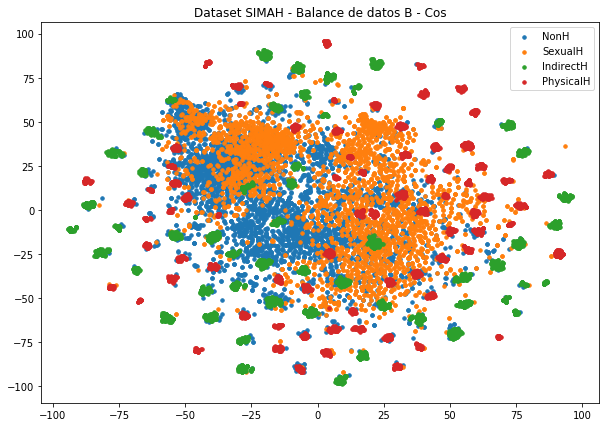

In [40]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_b)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset SIMAH - Balance de datos B - Cos")
plt.show()

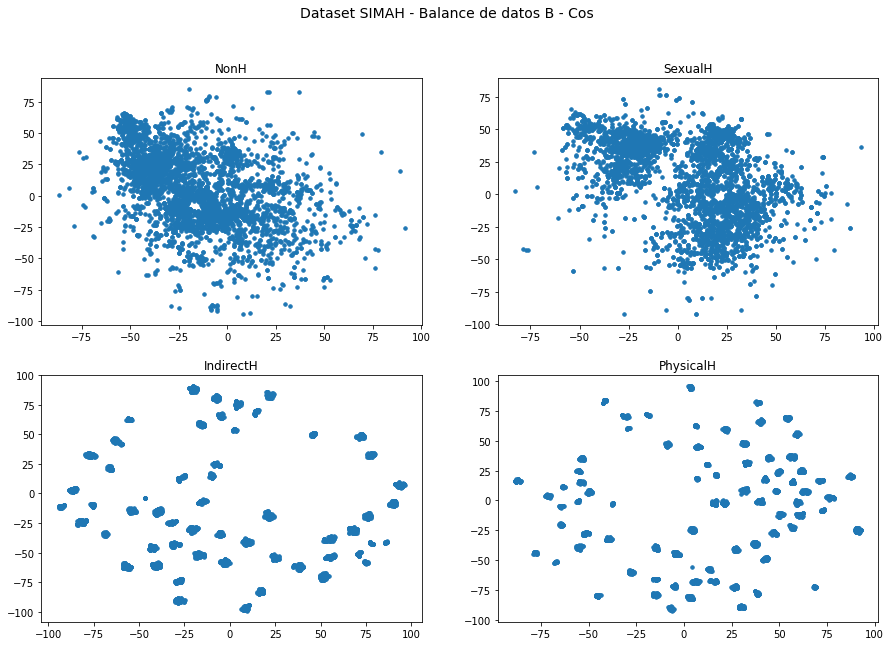

In [41]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))
        

fig.suptitle("Dataset SIMAH - Balance de datos B - Cos", fontsize=14)
plt.show()

In [42]:
np.random.shuffle(macro_augmented)
np.save('../Datasets/CSV_Harassment/balance_bert_noPon.npy', macro_augmented)
    

### Sujeto a Embedding BERT ponderando target

In [43]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, BERT=True, pond=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 1079 ejemplos para SexualH
Consultando por la clase SexualH
Entrega label 3
Original: naked  	Reemplazo:  [('live', 1.203498363494873)]
Original: fake  	Reemplazo:  [('photographs', 0.7989700436592102)]
Original: hardcore  	Reemplazo:  [('photographs', 0.906010091304779)]
Original: star  	Reemplazo:  [('rock', 0.8265438079833984)]
Sentencia original:
['pic' 'mexican' 'school' 'girl' 'naked' 'melanie' 'safka' 'fake' 'nude'
 'photos' 'hardcore' 'slut' 'movies' 'alicia' 'moore' 'porn' 'star' 'toon'
 'love']
Sentencia final: 3
['pic', 'mexican', 'school', 'girl', 'live', 'melanie', 'safka', 'photographs', 'nude', 'photos', 'photographs', 'slut', 'movies', 'alicia', 'moore', 'porn', 'rock', 'toon', 'love']


Original: i  	Reemplazo:  [('spot', 0.5455414652824402)]
Original: open  	Reemplazo:  [('free', 2.130692958831787)]
Original: do  	Reemplazo:  [('utilize', 0.3098134994506836)]
Original: have  	Reemplazo:  [('be', 2.18860125541687)]
Sentencia original:
['rt' 'sp00kybitchhhh'

Original: video  	Reemplazo:  [('youtube', 1.3260515928268433)]
Sentencia original:
['rt' 'tany' 'vander' 'fucking' 'my' 'wife' 'fuck' 'my' 'ass' 'xxx'
 'forced' 'sex' 'videos' 'xnxx' 'com' 'anulingus' 'xxx' 'p' 'xxx' 'porn'
 'anulingus' 'xxx' 'porno' 'video' 'hd' 'mob']
Sentencia final: 3
['rt', 'tany', 'vander', 'fucking', 'my', 'wife', 'fuck', 'my', 'shove', 'xxx', 'forced', 'sex', 'videos', 'xnxx', 'com', 'anulingus', 'xxx', 'figure', 'xxx', 'pornography', 'anulingus', 'xxx', 'porno', 'youtube', 'hd', 'mob']


Original: u  	Reemplazo:  [('asshole', 0.2831447720527649)]
Original: da  	Reemplazo:  [('malibu', 0.4939038157463074)]
Original: money  	Reemplazo:  [('man', 1.324948787689209)]
Sentencia original:
['ava' 'devin' 'u' 'bitch' 'ass' 'slut' 'where' 'da' 'fuck' 'is' 'my'
 'fuckin' 'money' 'u' 'god' 'damn' 'fuckin' 'bitch']
Sentencia final: 3
['ava', 'devin', 'asshole', 'bitch', 'ass', 'slut', 'where', 'malibu', 'fuck', 'is', 'my', 'fuckin', 'man', 'u', 'god', 'damn', 'fuckin', '

Original: hours  	Reemplazo:  [('minutes', 1.4851573705673218)]
Sentencia original:
['british' 'pussy' 'cumshot' 'indian' 'stars' 'uncircumcised' 'hours'
 'ago' 'x89' 't' 'co' 'c6yybtpomv']
Sentencia final: 3
['british', 'pussy', 'cumshot', 'indian', 'stars', 'uncircumcised', 'minutes', 'ago', 'x89', 't', 'co', 'c6yybtpomv']


Original: saying  	Reemplazo:  [('commenting', 0.9165252447128296)]
Original: nice  	Reemplazo:  [('pleased', 1.1601507663726807)]
Sentencia original:
['i' 'can' 't' 'post' 'a' 'comment' 'saying' 'must' 'be' 'nice' 'to' 'be'
 'a' 'slut' 'on' 'a' 'picture' 'of' 'a' 'almost' 'fully' 'nude' 'girl'
 'showing' 'her' 'as']
Sentencia final: 3
['i', 'can', 't', 'post', 'a', 'comment', 'commenting', 'must', 'be', 'pleased', 'to', 'be', 'a', 'slut', 'on', 'a', 'picture', 'of', 'a', 'almost', 'fully', 'nude', 'girl', 'showing', 'her', 'as']


Original: amateur  	Reemplazo:  [('damp', 0.8140140175819397)]
Sentencia original:
['rt' 'and' 'like' 'for' 'more' 'anal' 'wanktribut

Original: quote  	Reemplazo:  [('prostitute', 0.5663202404975891)]
Original: co  	Reemplazo:  [('re', 1.1914666891098022)]
Sentencia original:
['lindsey' 'graham' 's' 'slut' 'whore' 'drunk' 'quote' 'about' 'victims'
 'haunt' 'his' 'x89' 't' 'co' 'klbyjbugqs']
Sentencia final: 3
['lindsey', 'graham', 's', 'slut', 'whore', 'drunk', 'prostitute', 'about', 'victims', 'haunt', 'his', 'x89', 't', 're', 'klbyjbugqs']


Original: right  	Reemplazo:  [('asshole', 0.3283998370170593)]
Original: love  	Reemplazo:  [('ii', 1.1391308307647705)]
Sentencia original:
['me' 'jam' 'to' 'break' 'up' 'w' 'your' 'girlfriend' 'chris' 'honestly'
 'this' 'is' 'the' 'slut' 'anthem' 'me' 'i' 'know' 'right' 'i' 'fucking'
 'love' 'it']
Sentencia final: 3
['me', 'jam', 'to', 'break', 'up', 'w', 'your', 'girlfriend', 'chris', 'honestly', 'this', 'is', 'the', 'slut', 'anthem', 'me', 'i', 'know', 'asshole', 'i', 'fucking', 'ii', 'it']


Original: russian  	Reemplazo:  [('japanese', 2.7403903007507324)]
Sentencia orig

Original: serena  	Reemplazo:  [('ordinance', 0.5754517316818237)]
Sentencia original:
['velourhood' 'masonschreinerr' 'just' 'watch' 'gossip' 'girl' 'amp' 'act'
 'like' 'serena' 'amp' 'you' 'll' 'be' 'a' 'slut']
Sentencia final: 3
['velourhood', 'masonschreinerr', 'just', 'watch', 'gossip', 'girl', 'amp', 'act', 'like', 'ordinance', 'amp', 'you', 'll', 'be', 'a', 'slut']


Original: female  	Reemplazo:  [('male', 1.318487524986267)]
Original: team  	Reemplazo:  [('work', 0.8958960771560669)]
Original: didn  	Reemplazo:  [('don', 0.5387633442878723)]
Sentencia original:
['female' 'overwatch' 'player' 'h' 'every' 'other' 'team' 'member'
 'fucking' 'slut' 'get' 'on' 'mercy' 'you' 'bitch' 'c' 'nt' 'didn' 't'
 'know' 'they' 'coul']
Sentencia final: 3
['male', 'overwatch', 'player', 'h', 'every', 'other', 'work', 'member', 'fucking', 'slut', 'get', 'on', 'mercy', 'you', 'bitch', 'c', 'nt', 'don', 't', 'know', 'they', 'coul']


Original: co  	Reemplazo:  [('tn', 0.5165238380432129)]
Sentenci

Original: porn  	Reemplazo:  [('pornography', 0.8512604236602783)]
Sentencia original:
['ava' 'divine' 'gets' 'her' 'big' 'ass' 'fucked' 'sex' 'sexvideo' 'porn'
 'pornvideo' 'brazzers' 'pornhub' 'pornstar']
Sentencia final: 3
['ava', 'divine', 'gets', 'her', 'big', 'ass', 'fucked', 'sex', 'sexvideo', 'pornography', 'pornvideo', 'brazzers', 'pornhub', 'pornstar']


Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Sentencia original:
['sister' 'bitch' 'thought' 'robber' 'something' 'house' 'selfie' 'stick'
 'a' 'x89' 't' 'co' 'rziic8bce1']
Sentencia final: 3
['sister', 'bitch', 'thought', 'robber', 'something', 'house', 'selfie', 'stick', 'a', 'x89', 'tc', 'ko', 'rziic8bce1']


Original: i  	Reemplazo:  [('ii', 1.2915209531784058)]
Original: listen  	Reemplazo:  [('chesterfield', 0.2412150651216507)]
Sentencia original:
['skinnyhealy' 'i' 'x89' 'm' 'having' 'listen' 'people' 'fat' 'shame'
 'slut' 'shame' 'round' 'about' 'peopl

Original: simple  	Reemplazo:  [('gogh', 1.3735777139663696)]
Original: restaurant  	Reemplazo:  [('bar', 3.514643430709839)]
Original: am  	Reemplazo:  [('are', 0.6963967680931091)]
Sentencia original:
['i' 'm' 'just' 'a' 'simple' 'girl' 'who' 'wants' 'to' 'be' 'wine' 'and'
 'dined' 'and' 'felt' 'up' 'under' 'the' 'table' 'in' 'a' 'nice'
 'restaurant' 'like' 'the' 'slut' 'i' 'am']
Sentencia final: 3
['i', 'm', 'just', 'a', 'gogh', 'girl', 'who', 'wants', 'to', 'be', 'wine', 'and', 'dined', 'and', 'felt', 'up', 'under', 'the', 'table', 'in', 'a', 'nice', 'bar', 'like', 'the', 'slut', 'i', 'are']


Original: was  	Reemplazo:  [('were', 0.8464971780776978)]
Sentencia original:
['rt' 'vampmoney4ever' 'when' 'rocky' 'fingered' 'my' 'asshole' 'i' 'was'
 'like' 'hmm' 'di' 'some' 'gay' 'shit' 'but' 'he' 'was' 'doin' 'his'
 'thang' 'an' 'so' 'was' 'i' 'so' 'i']
Sentencia final: 3
['rt', 'vampmoney4ever', 'when', 'rocky', 'fingered', 'my', 'asshole', 'i', 'was', 'like', 'hmm', 'di', 'some', 'ga

Original: idea  	Reemplazo:  [('side', 0.447347491979599)]
Original: good  	Reemplazo:  [('bad', 3.5505173206329346)]
Sentencia original:
['i' 'loved' 'ludociel' 'when' 'he' 'debuted' 'but' 'i' 'had' 'no' 'idea'
 'hed' 'end' 'up' 'being' 'a' 'bitchy' 'slut' 'he' 'so' 'good']
Sentencia final: 3
['i', 'loved', 'ludociel', 'when', 'he', 'debuted', 'but', 'i', 'had', 'no', 'side', 'hed', 'end', 'up', 'being', 'a', 'bitchy', 'slut', 'he', 'so', 'bad']


Original: people  	Reemplazo:  [('men', 3.0725979804992676)]
Original: look  	Reemplazo:  [('peek', 0.3811899721622467)]
Original: i  	Reemplazo:  [('didn', 0.7654944062232971)]
Original: t  	Reemplazo:  [('ii', 0.4167686700820923)]
Original: care  	Reemplazo:  [('didn', 1.4047794342041016)]
Sentencia original:
['people' 'what' 'a' 'great' 'model' 'she' 'is' 'for' 'her' 'kids' 'look'
 'mommy' 'goes' 'out' 'in' 'public' 'dressed' 'like' 'a' 'slut' 'amp' 'i'
 'don' 't' 'care']
Sentencia final: 3
['men', 'what', 'a', 'great', 'model', 'she', 'i

Original: co  	Reemplazo:  [('pornography', 0.8070645928382874)]
Sentencia original:
['hot' 'naked' 'girls' 'melanystar' 'prety' 'comunicate' 't' 'co'
 'nu97kquvqh' 'porn' 'x89' 't' 'co' 'irilx6pj3l']
Sentencia final: 3
['gorgeous', 'naked', 'girls', 'melanystar', 'prety', 'comunicate', 'company', 'pornography', 'nu97kquvqh', 'porn', 'x89', 't', 'co', 'irilx6pj3l']


Original: rt  	Reemplazo:  [('ct', 1.2166494131088257)]
Original: rt  	Reemplazo:  [('provocative', 0.6002439856529236)]
Original: selling  	Reemplazo:  [('grossing', 1.9375067949295044)]
Sentencia original:
['rt' 'chimaekin' 'love' 'you' 'bby' 'like' 'and' 'rt' 'for' 'more'
 'videos' 'booty' 'camgirl' 'cocktribute' 'kik' 'lingerie' 'nude' 'rt'
 'selling' 'slut' 'ti']
Sentencia final: 3
['rt', 'chimaekin', 'love', 'you', 'bby', 'like', 'and', 'ct', 'for', 'more', 'videos', 'booty', 'camgirl', 'cocktribute', 'kik', 'lingerie', 'nude', 'provocative', 'grossing', 'slut', 'ti']


Original: facebook  	Reemplazo:  [('youtube', 0

Original: amp  	Reemplazo:  [('king', 0.5629799365997314)]
Original: abuse  	Reemplazo:  [('need', 0.7323264479637146)]
Sentencia original:
['rt' 'xsweetreginax' 'just' 'sold' 'a' 'clip' 'poisoned' 'by' 'queen'
 'amp' 'amp' 'little' 'slut' 'abuse' 'latex' 'get' 'yours' 'on'
 'iwantclips' 'htt']
Sentencia final: 3
['rt', 'xsweetreginax', 'just', 'sold', 'a', 'clip', 'poisoned', 'by', 'queen', 'king', 'amp', 'little', 'slut', 'need', 'latex', 'get', 'yours', 'on', 'iwantclips', 'htt']


Original: kids  	Reemplazo:  [('children', 1.4398540258407593)]
Sentencia original:
['rt' 'todayyearsoldig' 'today' 'kids' 'will' 'never' 'know' 'how' 'good'
 'these' 'bitch' 'was']
Sentencia final: 3
['rt', 'todayyearsoldig', 'today', 'children', 'will', 'never', 'know', 'how', 'good', 'these', 'bitch', 'was']


Original: i  	Reemplazo:  [('ii', 1.2901883125305176)]
Sentencia original:
['i' 'x89' 'm' 'watching' 'halloween' 'whatever' 'bitch' 'chopped'
 'micheal' 'off' 'nigga' 'still' 'alive']
Sentencia f

Original: verify  	Reemplazo:  [('publish', 1.0720947980880737)]
Original: amp  	Reemplazo:  [('hell', 2.1213178634643555)]
Original: see  	Reemplazo:  [('find', 1.9454106092453003)]
Original: videos  	Reemplazo:  [('vans', 0.744357168674469)]
Original: cum  	Reemplazo:  [('lumpur', 1.2523707151412964)]
Original: friends  	Reemplazo:  [('buddies', 0.5707317590713501)]
Original: point  	Reemplazo:  [('ignore', 0.9663156867027283)]
Original: love  	Reemplazo:  [('living', 2.0425026416778564)]
Original: is  	Reemplazo:  [('has', 1.3072993755340576)]
Original: call  	Reemplazo:  [('woman', 1.3797987699508667)]
Original: anyone  	Reemplazo:  [('anybody', 1.4215562343597412)]
Original: hot  	Reemplazo:  [('ochreous', 1.226035475730896)]
Original: dripping  	Reemplazo:  [('soaking', 0.9107084274291992)]
Original: texted  	Reemplazo:  [('smirked', 0.4846576452255249)]
Original: didn  	Reemplazo:  [('distract', 0.45384594798088074)]
Original: lynn  	Reemplazo:  [('tara', 1.5571540594100952)]
Or

Original: m  	Reemplazo:  [('m3', 0.31411388516426086)]
Original: bitch  	Reemplazo:  [('told', 1.2470903396606445)]
Original: s  	Reemplazo:  [('st', 1.167785406112671)]
Original: break  	Reemplazo:  [('shatter', 0.5949081778526306)]
Original: be  	Reemplazo:  [('go', 0.5113445520401001)]
Original: office  	Reemplazo:  [('asia', 0.8503093719482422)]
Original: facial  	Reemplazo:  [('abdominal', 0.5649676322937012)]
Original: t  	Reemplazo:  [('pornography', 0.5284777879714966)]
Original: i  	Reemplazo:  [('ii', 1.3271865844726562)]
Original: i  	Reemplazo:  [('crap', 0.4848267138004303)]
Original: bangs  	Reemplazo:  [('revolves', 1.888954997062683)]
Original: t  	Reemplazo:  [('tn', 0.5075575709342957)]
Original: feet  	Reemplazo:  [('legs', 1.219560980796814)]
Original: xander  	Reemplazo:  [('dhabi', 2.285550594329834)]
Original: shame  	Reemplazo:  [('humiliation', 1.5063127279281616)]
Original: yesterday  	Reemplazo:  [('eleventh', 0.41181573271751404)]
Original: promo  	Reemplaz

Original: t  	Reemplazo:  [('jr', 1.9959940910339355)]
Original: be  	Reemplazo:  [('go', 1.2447859048843384)]
Original: be  	Reemplazo:  [('disclose', 0.2257431596517563)]
Original: big  	Reemplazo:  [('large', 0.5626850128173828)]
Original: total  	Reemplazo:  [('full', 2.210482597351074)]
Original: virgin  	Reemplazo:  [('bachelor', 1.3590401411056519)]
Original: anal  	Reemplazo:  [('young', 1.2548472881317139)]
Original: free  	Reemplazo:  [('independent', 0.32252195477485657)]
Original: hot  	Reemplazo:  [('pornographic', 0.3995928466320038)]
Original: porn  	Reemplazo:  [('girl', 1.4671411514282227)]
Original: miss  	Reemplazo:  [('ms', 0.77702796459198)]
Original: number  	Reemplazo:  [('multitude', 0.36310428380966187)]
Original: porn  	Reemplazo:  [('breakout', 0.5945833325386047)]
Original: amp  	Reemplazo:  [('pass', 0.829332172870636)]
Original: passing  	Reemplazo:  [('pass', 0.5132525563240051)]
Original: sexy  	Reemplazo:  [('hello', 0.7980896234512329)]
Original: bitch

Original: hey  	Reemplazo:  [('hello', 0.47724345326423645)]
Original: hey  	Reemplazo:  [('whoa', 0.35441160202026367)]
Original: rights  	Reemplazo:  [('media', 1.6286594867706299)]
Original: hit  	Reemplazo:  [('redeveloped', 0.906762421131134)]
Original: quiet  	Reemplazo:  [('new', 1.163167119026184)]
Original: jessica  	Reemplazo:  [('fuck', 0.9752963781356812)]
Original: t  	Reemplazo:  [('qaeda', 4.590604782104492)]
Original: ll  	Reemplazo:  [('aggregator', 1.355411171913147)]
Original: shame  	Reemplazo:  [('aback', 1.5125612020492554)]
Original: guy  	Reemplazo:  [('redhead', 0.6387842893600464)]
Original: looks  	Reemplazo:  [('glances', 0.8946910500526428)]
Original: is  	Reemplazo:  [('comes', 0.4340580701828003)]
Original: s  	Reemplazo:  [('time', 2.03180193901062)]
Original: freak  	Reemplazo:  [('bizarre', 0.7711904644966125)]
Original: girl  	Reemplazo:  [('boy', 0.9393712282180786)]
Original: day  	Reemplazo:  [('night', 1.4763778448104858)]
Original: week  	Reempla

Original: bitch  	Reemplazo:  [('asshole', 0.7963333129882812)]
Original: indian  	Reemplazo:  [('american', 3.074824571609497)]
Original: nude  	Reemplazo:  [('woman', 0.34061524271965027)]
Original: i  	Reemplazo:  [('ran', 1.0833327770233154)]
Original: went  	Reemplazo:  [('seemed', 1.2974390983581543)]
Original: school  	Reemplazo:  [('boy', 1.5966731309890747)]
Original: outfit  	Reemplazo:  [('set', 5.4385786056518555)]
Original: year  	Reemplazo:  [('time', 0.9016250967979431)]
Original: photos  	Reemplazo:  [('images', 0.7933799028396606)]
Original: video  	Reemplazo:  [('brunette', 0.5847169756889343)]
Original: mom  	Reemplazo:  [('porn', 1.6235411167144775)]
Original: give  	Reemplazo:  [('allow', 1.9541841745376587)]
Original: i  	Reemplazo:  [('iii', 0.49870187044143677)]
Original: village  	Reemplazo:  [('name', 0.5370360016822815)]
Original: skinny  	Reemplazo:  [('lumpur', 3.508389711380005)]
Original: co  	Reemplazo:  [('tn', 0.514604926109314)]
Original: is  	Reempla

Original: bitch  	Reemplazo:  [('witch', 1.5465301275253296)]
Original: s  	Reemplazo:  [('time', 1.9362123012542725)]
Original: hardcore  	Reemplazo:  [('nj', 1.3405851125717163)]
Original: someone  	Reemplazo:  [('something', 2.3225901126861572)]
Original: text  	Reemplazo:  [('crambidae', 2.321227550506592)]
Original: isn  	Reemplazo:  [('wasn', 2.7031092643737793)]
Original: be  	Reemplazo:  [('maximize', 0.49253013730049133)]
Original: boo  	Reemplazo:  [('damn', 0.9741353392601013)]
Original: porn  	Reemplazo:  [('qaeda', 3.123706340789795)]
Original: girlfriend  	Reemplazo:  [('adolescent', 0.46558481454849243)]
Original: cousin  	Reemplazo:  [('newer', 0.5192969441413879)]
Original: sis  	Reemplazo:  [('bridget', 0.9011251926422119)]
Original: pussy  	Reemplazo:  [('shit', 1.3496787548065186)]
Original: amp  	Reemplazo:  [('daryl', 0.8349574208259583)]
Original: today  	Reemplazo:  [('tonight', 0.5037624835968018)]
Original: dumb  	Reemplazo:  [('mutation', 0.6195518970489502)]

Original: is  	Reemplazo:  [('has', 1.1327637434005737)]
Original: being  	Reemplazo:  [('becoming', 2.275700092315674)]
Original: mid  	Reemplazo:  [('middle', 2.310868740081787)]
Original: ll  	Reemplazo:  [('softness', 0.5480078458786011)]
Original: i  	Reemplazo:  [('ii', 1.2517491579055786)]
Original: t  	Reemplazo:  [('ll', 1.0900808572769165)]
Original: pussy  	Reemplazo:  [('romance', 0.7763952612876892)]
Original: butt  	Reemplazo:  [('backside', 0.659779965877533)]
Original: tits  	Reemplazo:  [('times', 1.806609034538269)]
Original: girls  	Reemplazo:  [('boys', 0.8661108016967773)]
Original: feet  	Reemplazo:  [('sneakers', 0.529499351978302)]
Original: singing  	Reemplazo:  [('running', 1.7739752531051636)]
Original: videos  	Reemplazo:  [('phones', 0.678802490234375)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: night  	Reemplazo:  [('day', 3.5807418823242188)]
Original: i  	Reemplazo:  [('ii', 1.3926619291305542)]
Original: am  	Reemplazo:  [('are', 

Original: i  	Reemplazo:  [('ii', 0.46782299876213074)]
Original: i  	Reemplazo:  [('saw', 0.810431182384491)]
Original: bitch  	Reemplazo:  [('giggle', 0.49565744400024414)]
Original: bald  	Reemplazo:  [('aback', 3.0212764739990234)]
Original: shove  	Reemplazo:  [('blonde', 1.0312519073486328)]
Original: t  	Reemplazo:  [('th', 1.1817668676376343)]
Original: t  	Reemplazo:  [('re', 0.738298773765564)]
Original: t  	Reemplazo:  [('ghent', 0.7194080948829651)]
Original: register  	Reemplazo:  [('freed', 0.7496901154518127)]
Original: porn  	Reemplazo:  [('clit', 2.263936758041382)]
Original: bitch  	Reemplazo:  [('asteroid', 2.3589065074920654)]
Original: nobody  	Reemplazo:  [('nothing', 2.289738893508911)]
Original: be  	Reemplazo:  [('go', 1.8487125635147095)]
Original: devin  	Reemplazo:  [('asshole', 0.620854914188385)]
Original: u  	Reemplazo:  [('asshole', 0.3445030748844147)]
Original: lesbian  	Reemplazo:  [('enjoyable', 0.5700741410255432)]
Original: issue  	Reemplazo:  [('p

Original: t  	Reemplazo:  [('sp', 1.2892223596572876)]
Original: private  	Reemplazo:  [('free', 1.9313920736312866)]
Original: fun  	Reemplazo:  [('enjoyment', 0.8106314539909363)]
Original: shame  	Reemplazo:  [('feminine', 0.5491929054260254)]
Original: rose  	Reemplazo:  [('erupted', 1.3932288885116577)]
Original: wanna  	Reemplazo:  [('gonna', 1.695106863975525)]
Original: kinda  	Reemplazo:  [('threw', 0.7393984794616699)]
Original: b  	Reemplazo:  [('tb', 0.4705077111721039)]
Original: number  	Reemplazo:  [('amount', 0.31687334179878235)]
Original: part  	Reemplazo:  [('fifteenth', 0.3163888156414032)]
Original: worst  	Reemplazo:  [('lowest', 0.7046549320220947)]
Original: pussy  	Reemplazo:  [('left', 3.125749349594116)]
Original: see  	Reemplazo:  [('have', 1.231583833694458)]
Original: don  	Reemplazo:  [('chopped', 0.47348713874816895)]
Original: t  	Reemplazo:  [('chopped', 0.5505843162536621)]
Original: casting  	Reemplazo:  [('adapting', 0.49634411931037903)]
Original: 

Original: man  	Reemplazo:  [('woman', 1.251991868019104)]
Original: cute  	Reemplazo:  [('wore', 1.187635898590088)]
Original: co  	Reemplazo:  [('asshole', 0.5169435143470764)]
Original: need  	Reemplazo:  [('want', 5.819362163543701)]
Original: eat  	Reemplazo:  [('atletico', 1.6540743112564087)]
Original: t  	Reemplazo:  [('wasn', 1.1956160068511963)]
Original: lost  	Reemplazo:  [('faltered', 0.4782412052154541)]
Original: mom  	Reemplazo:  [('grandma', 0.5518749952316284)]
Original: n  	Reemplazo:  [('validation', 0.43888652324676514)]
Original: photos  	Reemplazo:  [('pictures', 0.636378824710846)]
Original: p  	Reemplazo:  [('home', 1.1668610572814941)]
Original: girl  	Reemplazo:  [('woman', 0.5222873091697693)]
Original: calling  	Reemplazo:  [('hiring', 0.7841386198997498)]
Original: is  	Reemplazo:  [('has', 1.2963895797729492)]
Original: young  	Reemplazo:  [('credible', 0.5168920159339905)]
Original: say  	Reemplazo:  [('disclose', 0.2671017050743103)]
Original: being  	R

Original: everyone  	Reemplazo:  [('everybody', 0.9543160796165466)]
Original: nude  	Reemplazo:  [('female', 1.260738730430603)]
Original: mode  	Reemplazo:  [('asleep', 1.337607979774475)]
Original: ava  	Reemplazo:  [('fifteenth', 0.30010151863098145)]
Original: hairy  	Reemplazo:  [('boiler', 1.3103508949279785)]
Original: world  	Reemplazo:  [('family', 2.2501046657562256)]
Original: bad  	Reemplazo:  [('problematic', 0.4705834686756134)]
Original: cry  	Reemplazo:  [('fuck', 0.992032527923584)]
Original: bbc  	Reemplazo:  [('rte', 0.6576290130615234)]
Original: bitch  	Reemplazo:  [('janeiro', 4.64209508895874)]
Original: d  	Reemplazo:  [('hadn', 2.646188259124756)]
Original: apple  	Reemplazo:  [('time', 0.8177713751792908)]
Original: screwed  	Reemplazo:  [('configured', 0.5010390877723694)]
Original: brutal  	Reemplazo:  [('astonishment', 0.9824238419532776)]
Original: whore  	Reemplazo:  [('nedra', 1.224880337715149)]
Original: tight  	Reemplazo:  [('aback', 3.82907128334045

Original: face  	Reemplazo:  [('ii', 1.263210415840149)]
Sentencia original:
['rt' 'its' 'khries' 'me' 'sometimes' 'i' 'want' 'to' 'punch' 'you' 'in'
 'the' 'face' 'ava' 'i' 'wish' 'you' 'would' 'i' 'm' 'a' 'kinky' 'bitch'
 'nah' 'bitch' 'you' 'suicidal' 'there' 'is']
Sentencia final: 2
['rt', 'its', 'khries', 'me', 'sometimes', 'i', 'want', 'to', 'punch', 'you', 'in', 'the', 'ii', 'ava', 'i', 'wish', 'you', 'would', 'i', 'm', 'a', 'kinky', 'bitch', 'nah', 'bitch', 'you', 'suicidal', 'there', 'is']


Original: gay  	Reemplazo:  [('girl', 0.8825513124465942)]
Original: hall  	Reemplazo:  [('tonight', 1.320288896560669)]
Original: called  	Reemplazo:  [('named', 0.8181747794151306)]
Sentencia original:
['you' 'know' 'the' 'gay' 'boy' 'you' 'punched' 'in' 'the' 'hall' 'today'
 'he' 'committed' 'suicide' 'a' 'few' 'minutes' 'ago' 'that' 'girl' 'you'
 'called']
Sentencia final: 2
['you', 'know', 'the', 'girl', 'boy', 'you', 'punched', 'in', 'the', 'tonight', 'today', 'he', 'committed', 'sui

Original: get  	Reemplazo:  [('be', 0.3264385163784027)]
Sentencia original:
['rt' 'charlynch' 'bella' 'what' 'i' 'don' 't' 'get' 'is' 'how' 'y' 'all'
 'try' 'to' 'drag' 'becky' 'for' 'body' 'shame' 'charlotte' 'when' 'she'
 'didn' 't' 'but' 'laugh' 'at' 'a' 'fan' 'that']
Sentencia final: 2
['rt', 'charlynch', 'bella', 'what', 'i', 'don', 't', 'be', 'is', 'how', 'y', 'all', 'try', 'to', 'drag', 'becky', 'for', 'body', 'shame', 'charlotte', 'when', 'she', 'didn', 't', 'but', 'laugh', 'at', 'a', 'fan', 'that']


Original: stern  	Reemplazo:  [('seaman', 1.1088699102401733)]
Original: strap  	Reemplazo:  [('way', 5.216646671295166)]
Sentencia original:
['willbang4' 'lolaruin' 'so' 'stern' 'strict' 'and' 'powerful' 'i' 'bet'
 'she' 'is' 'deadly' 'with' 'a' 'strap' 'on']
Sentencia final: 2
['willbang4', 'lolaruin', 'so', 'seaman', 'strict', 'and', 'powerful', 'i', 'bet', 'she', 'is', 'deadly', 'with', 'a', 'way', 'on']


Original: head  	Reemplazo:  [('skull', 0.8028947710990906)]
Sentencia

Original: yeah  	Reemplazo:  [('taut', 0.33177649974823)]
Sentencia original:
['p0rnsfw' 'daddy' 'behave' 'baby' 'daddy' 'tight' 'open' 'yeah' 'little'
 'x89']
Sentencia final: 2
['p0rnsfw', 'daddy', 'behave', 'baby', 'daddy', 'tight', 'open', 'taut', 'little', 'x89']


Original: i  	Reemplazo:  [('man', 1.218756914138794)]
Original: shame  	Reemplazo:  [('hand', 2.0054214000701904)]
Sentencia original:
['what' 'i' 'don' 't' 'get' 'is' 'how' 'y' 'all' 'try' 'to' 'drag' 'becky'
 'for' 'body' 'shame' 'charlotte' 'when' 'she' 'didn' 't' 'but' 'laugh'
 'at' 'a' 'fan' 'th']
Sentencia final: 2
['what', 'man', 'don', 't', 'get', 'is', 'how', 'y', 'all', 'try', 'to', 'drag', 'becky', 'for', 'body', 'hand', 'charlotte', 'when', 'she', 'didn', 't', 'but', 'laugh', 'at', 'a', 'fan', 'th']


Original: co  	Reemplazo:  [('company', 0.6912029981613159)]
Sentencia original:
['x' 'wildestdreams' 'really' 'being' 'sassy' 'twitter' 't' 'co'
 'btblszxbw0']
Sentencia final: 2
['x', 'wildestdreams', 'reall

Original: adult  	Reemplazo:  [('attorney', 0.9355322122573853)]
Sentencia original:
['h4gb4rdceline' 'legal' 'adult' 'amount' 'gaping' 'x89' 't' 'co'
 'wsh2lkgt9l']
Sentencia final: 2
['h4gb4rdceline', 'legal', 'attorney', 'amount', 'gaping', 'x89', 't', 'co', 'wsh2lkgt9l']


Original: is  	Reemplazo:  [('has', 0.4804862439632416)]
Original: don  	Reemplazo:  [('didn', 0.8409282565116882)]
Sentencia original:
['all' 'i' 'hear' 'is' 'fucking' 'moron' 'you' 're' 'so' 'stupid' 'you'
 're' 'an' 'ugly' 'slut' 'go' 'kill' 'yourself' 'and' 'other' 'things' 'i'
 'don' 't']
Sentencia final: 2
['all', 'i', 'hear', 'has', 'fucking', 'moron', 'you', 're', 'so', 'stupid', 'you', 're', 'an', 'ugly', 'slut', 'go', 'kill', 'yourself', 'and', 'other', 'things', 'i', 'didn', 't']


Original: muslim  	Reemplazo:  [('lumpur', 2.3759865760803223)]
Original: deserve  	Reemplazo:  [('lankan', 2.615023612976074)]
Original: be  	Reemplazo:  [('minimize', 0.5247943997383118)]
Sentencia original:
['unjust' 'is'


Original: make  	Reemplazo:  [('do', 0.7524386048316956)]
Original: campaign  	Reemplazo:  [('season', 2.04239821434021)]
Sentencia original:
['rt' 'krassenstein' 'you' 'can' 't' 'make' 'this' 'stuff' 'up' 'the'
 'build' 'the' 'wall' 'gofundme' 'has' 'failed' 'after' 'gofundme'
 'canceled' 'the' 'campaign' 'for' 'violati']
Sentencia final: 2
['rt', 'krassenstein', 'you', 'can', 't', 'do', 'this', 'stuff', 'up', 'the', 'build', 'the', 'wall', 'gofundme', 'has', 'failed', 'after', 'gofundme', 'canceled', 'the', 'season', 'for', 'violati']


Original: videos  	Reemplazo:  [('towards', 2.8689732551574707)]
Sentencia original:
['rt' 'for' 'more' 'videos' 'like' 'this' 'amateurporn' 'panties' 'cock'
 'teen' 'nsfw' 'webcam' 'snapchat' 'camgirl' 'slut' 'paypalwhore' 'fuck'
 'me']
Sentencia final: 2
['rt', 'for', 'more', 'towards', 'like', 'this', 'amateurporn', 'panties', 'cock', 'teen', 'nsfw', 'webcam', 'snapchat', 'camgirl', 'slut', 'paypalwhore', 'fuck', 'me']


Original: am  	Reemplazo: 

Original: pulled  	Reemplazo:  [('took', 0.7782180905342102)]
Sentencia original:
['rt' 'talbertswan' 'the' 'mother' 'of' 'jazminebarnes' 'her' 'number'
 'yr' 'old' 'daughter' 'who' 'was' 'shot' 'amp' 'killed' 'by' 'a' 'white'
 'supremacist' 'the' 'murderer' 'pulled' 'up' 'i']
Sentencia final: 2
['rt', 'talbertswan', 'the', 'mother', 'of', 'jazminebarnes', 'her', 'number', 'yr', 'old', 'daughter', 'who', 'was', 'shoot', 'amp', 'killed', 'by', 'a', 'white', 'supremacist', 'the', 'murderer', 'took', 'up', 'i']


Original: ready  	Reemplazo:  [('prepared', 1.3087153434753418)]
Sentencia original:
['i' 'know' 'you' 're' 'ready' 'this' 'dumb' 'ass' 'slut' 'go' 'do' 'your'
 'homework' 'bitch' 'you' 'got' 'school' 'tomorrow']
Sentencia final: 2
['i', 'know', 'you', 're', 'prepared', 'this', 'dumb', 'ass', 'slut', 'go', 'do', 'your', 'homework', 'bitch', 'you', 'got', 'school', 'tomorrow']


Original: amp  	Reemplazo:  [('pmid', 4.011507987976074)]
Original: bitch  	Reemplazo:  [('jaenelle', 1

Original: i  	Reemplazo:  [('http', 3.9357426166534424)]
Original: call  	Reemplazo:  [('ll', 1.2594443559646606)]
Sentencia original:
['i' 'remember' 'when' 'i' 'was' 'in' '6th' 'grade' 'all' 'the' 'girls'
 'in' '8th' 'grade' 'bullied' 'me' 'for' 'having' 'red' 'hair' 'they'
 'would' 'call' 'm']
Sentencia final: 2
['http', 'remember', 'when', 'i', 'was', 'in', '6th', 'grade', 'all', 'the', 'girls', 'in', '8th', 'grade', 'bullied', 'me', 'for', 'having', 'red', 'hair', 'they', 'would', 'll', 'm']


Original: ll  	Reemplazo:  [('destroy', 1.1331008672714233)]
Sentencia original:
['rt' 'ballizlife' 'number' 'takeoffwilly' 'i' 'll' 'kill' 'you' 'slut']
Sentencia final: 2
['rt', 'ballizlife', 'number', 'takeoffwilly', 'i', 'destroy', 'kill', 'you', 'slut']


Original: gets  	Reemplazo:  [('intends', 1.0686553716659546)]
Original: crap  	Reemplazo:  [('shit', 2.3074049949645996)]
Sentencia original:
['briannawu' 'everybody' 'gets' 'death' 'threats' 'are' 'you' 'still'
 'bitch' 'about' 'that

Original: amp  	Reemplazo:  [('meaningless', 1.0431145429611206)]
Original: ur  	Reemplazo:  [('grimace', 0.42711055278778076)]
Original: gag  	Reemplazo:  [('lip', 0.7985045313835144)]
Original: bruises  	Reemplazo:  [('northwards', 0.3479861617088318)]
Sentencia original:
['rt' 'kthfuckz' 'don' 't' 'u' 'love' 'when' 'u' 're' 'like' 'this'
 'kitten' 'all' 'tied' 'up' 'amp' 'useless' 'ur' 'pretty' 'mouth' 'gag'
 'and' 'ur' 'ass' 'covered' 'in' 'bruises' 'u' 'look']
Sentencia final: 2
['rt', 'kthfuckz', 'don', 'gangster', 'u', 'love', 'when', 'amore', 're', 'like', 'this', 'kitten', 'all', 'tied', 'up', 'meaningless', 'useless', 'grimace', 'pretty', 'mouth', 'lip', 'and', 'ur', 'ass', 'covered', 'in', 'northwards', 'u', 'look']


Original: minor  	Reemplazo:  [('slave', 0.8624838590621948)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Sentencia original:
['the' 'bitch' 'brutally' 'tortured' 'minor' 'servant' 'starved' 'major'
 'ammara' 'm' 'x89' 't' 'co' 'mgknu7zzjm']
Sentenc

Original: daughters  	Reemplazo:  [('grandchildren', 1.5288100242614746)]
Sentencia original:
['really' 'wanting' 'smack' 'y' 'x89' 'all' 'daughters' 'disrespectful'
 'sons']
Sentencia final: 2
['really', 'wanting', 'smack', 'magdalena', 'x89', 'all', 'grandchildren', 'disrespectful', 'sons']


Original: see  	Reemplazo:  [('find', 1.2046388387680054)]
Sentencia original:
['rt' 'evilbart24' 'being' 'ugly' 'sucks' 'because' 'you' 'can' 'have'
 'the' 'time' 'of' 'your' 'life' 'and' 'then' 'you' 'see' 'a' 'glimpse'
 'of' 'your' 'reflection' 'and' 'it' 'kills' 'yo']
Sentencia final: 2
['rt', 'evilbart24', 'being', 'ugly', 'sucks', 'because', 'you', 'can', 'have', 'the', 'time', 'of', 'your', 'life', 'and', 'then', 'you', 'find', 'a', 'glimpse', 'of', 'your', 'reflection', 'and', 'it', 'kills', 'yo']


Original: looking  	Reemplazo:  [('snapping', 1.3848026990890503)]
Sentencia original:
['rt' 'brookeharlandxo' 'eve' 'is' 'actually' 'a' 'spawn' 'of' 'the'
 'devil' 'psycho' 'looking' 'on' 's

Original: s  	Reemplazo:  [('house', 1.1255136728286743)]
Original: ways  	Reemplazo:  [('revolves', 1.0403467416763306)]
Original: i  	Reemplazo:  [('set', 1.8986010551452637)]
Original: is  	Reemplazo:  [('has', 2.088085174560547)]
Original: is  	Reemplazo:  [('has', 1.5453356504440308)]
Original: today  	Reemplazo:  [('commit', 0.8116933107376099)]
Original: t  	Reemplazo:  [('mo', 1.250807762145996)]
Original: trial  	Reemplazo:  [('fourteenth', 0.5240710973739624)]
Original: t  	Reemplazo:  [('funky', 0.34279972314834595)]
Original: s  	Reemplazo:  [('assertion', 0.5396649241447449)]
Original: s  	Reemplazo:  [('day', 1.1506739854812622)]
Original: bitch  	Reemplazo:  [('snuck', 0.6723871827125549)]
Original: bitch  	Reemplazo:  [('lumpur', 2.566854476928711)]
Original: cool  	Reemplazo:  [('cooler', 0.7809983491897583)]
Original: love  	Reemplazo:  [('fire', 1.8814133405685425)]
Original: fucking  	Reemplazo:  [('murdering', 0.7123047113418579)]
Original: t  	Reemplazo:  [('tc', 

Original: body  	Reemplazo:  [('chest', 1.2310118675231934)]
Original: shame  	Reemplazo:  [('sorry', 1.2976008653640747)]
Original: defend  	Reemplazo:  [('strive', 0.6037492156028748)]
Original: calling  	Reemplazo:  [('telling', 1.1863598823547363)]
Original: amp  	Reemplazo:  [('line', 1.1649960279464722)]
Original: disgusting  	Reemplazo:  [('stealing', 1.3295660018920898)]
Original: strap  	Reemplazo:  [('way', 5.216646671295166)]
Original: head  	Reemplazo:  [('neck', 0.7300403714179993)]
Original: was  	Reemplazo:  [('were', 1.5468027591705322)]
Original: grade  	Reemplazo:  [('class', 1.1307603120803833)]
Original: hair  	Reemplazo:  [('head', 2.070704460144043)]
Original: tell  	Reemplazo:  [('told', 1.4547423124313354)]
Original: blood  	Reemplazo:  [('crimson', 1.29282808303833)]
Original: are  	Reemplazo:  [('am', 0.3963017463684082)]
Original: meant  	Reemplazo:  [('mean', 1.128454327583313)]
Original: be  	Reemplazo:  [('get', 0.7241060733795166)]
Original: threats  	Ree

Original: prepare  	Reemplazo:  [('preparation', 0.8646369576454163)]
Original: good  	Reemplazo:  [('prepared', 0.5536475777626038)]
Original: dream  	Reemplazo:  [('nightmare', 0.8008162975311279)]
Original: woman  	Reemplazo:  [('girl', 0.9140742421150208)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: little  	Reemplazo:  [('small', 0.8101599812507629)]
Original: chopped  	Reemplazo:  [('crept', 1.0398753881454468)]
Original: least  	Reemplazo:  [('lowest', 0.8335206508636475)]
Original: t  	Reemplazo:  [('gangster', 0.3132631182670593)]
Original: hasn  	Reemplazo:  [('dissatisfaction', 0.4076136648654938)]
Original: t  	Reemplazo:  [('aback', 1.2673664093017578)]
Original: call  	Reemplazo:  [('summon', 0.8417191505432129)]
Original: fat  	Reemplazo:  [('skinny', 1.1488027572631836)]
Original: shame  	Reemplazo:  [('embarrassment', 0.8715004920959473)]
Original: shouldn  	Reemplazo:  [('possess', 0

Original: rt  	Reemplazo:  [('seventeenth', 0.6164015531539917)]
Original: eyes  	Reemplazo:  [('hands', 1.213326096534729)]
Original: fuck  	Reemplazo:  [('hell', 1.1292216777801514)]
Original: let  	Reemplazo:  [('allow', 0.903472363948822)]
Original: kitten  	Reemplazo:  [('kindergarten', 1.1089539527893066)]
Original: girl  	Reemplazo:  [('boy', 0.8851456046104431)]
Original: t  	Reemplazo:  [('man', 0.2664356529712677)]
Original: shame  	Reemplazo:  [('dominique', 1.4317200183868408)]
Original: didn  	Reemplazo:  [('hadn', 2.1714389324188232)]
Original: husband  	Reemplazo:  [('pmid', 3.1100234985351562)]
Original: woman  	Reemplazo:  [('man', 1.4467251300811768)]
Original: s  	Reemplazo:  [('sc', 1.2602063417434692)]
Original: girls  	Reemplazo:  [('women', 2.086097002029419)]
Original: is  	Reemplazo:  [('expects', 0.30034923553466797)]
Original: fat  	Reemplazo:  [('subcommittee', 1.0200210809707642)]
Original: bitch  	Reemplazo:  [('man', 1.2050745487213135)]
Original: is  	Re

Original: th  	Reemplazo:  [('supporter', 0.8060566782951355)]
Original: bullshit  	Reemplazo:  [('bastard', 0.8344802856445312)]
Original: chopped  	Reemplazo:  [('crept', 1.0398753881454468)]
Original: fuck  	Reemplazo:  [('skyla', 0.8552917838096619)]
Original: u  	Reemplazo:  [('tn', 0.30072644352912903)]
Original: gag  	Reemplazo:  [('lip', 0.7985045313835144)]
Original: u  	Reemplazo:  [('bruise', 0.5250544548034668)]
Original: bitch  	Reemplazo:  [('torture', 1.2722063064575195)]
Original: major  	Reemplazo:  [('significant', 0.7472026348114014)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: guy  	Reemplazo:  [('sort', 1.3966792821884155)]
Original: shame  	Reemplazo:  [('boy', 1.3900887966156006)]
Original: shame  	Reemplazo:  [('lumpur', 1.4629298448562622)]
Original: horrible  	Reemplazo:  [('terrible', 0.769343912601471)]
Original: ways  	Reemplazo:  [('numbers', 0.4899822175502777)]
Original: i  	Reemplazo:  [('ii', 0.7708119750022888)]
Original: bitch  

Original: fl  	Reemplazo:  [('youthful', 0.32976773381233215)]
Original: amount  	Reemplazo:  [('immature', 0.46456947922706604)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: i  	Reemplazo:  [('heard', 1.1821174621582031)]
Original: hear  	Reemplazo:  [('ii', 0.46595513820648193)]
Original: is  	Reemplazo:  [('has', 1.38212251663208)]
Original: don  	Reemplazo:  [('didn', 1.4972131252288818)]
Original: i  	Reemplazo:  [('ma', 0.4626382291316986)]
Original: o  	Reemplazo:  [('och', 0.3000101149082184)]
Original: wanting  	Reemplazo:  [('needing', 1.36949622631073)]
Original: life  	Reemplazo:  [('living', 2.02898907661438)]
Original: is  	Reemplazo:  [('has', 0.7232765555381775)]
Original: abs  	Reemplazo:  [('bananas', 0.5901508927345276)]
Original: cute  	Reemplazo:  [('boy', 0.8766109943389893)]
Original: i  	Reemplazo:  [('found', 0.8338742256164551)]
Original: picture  	Reemplazo:  [('rr', 0.5214219689369202)]
Original: be  	Reemplazo:  [('save', 1.436977744102

Original: way  	Reemplazo:  [('lumpur', 2.4811902046203613)]
Original: lesbian  	Reemplazo:  [('homosexual', 0.8395616412162781)]
Original: says  	Reemplazo:  [('is', 1.2768335342407227)]
Original: wants  	Reemplazo:  [('owns', 1.618371844291687)]
Original: good  	Reemplazo:  [('durable', 0.5608869791030884)]
Original: don  	Reemplazo:  [('rouen', 0.23728187382221222)]
Original: know  	Reemplazo:  [('do', 0.5039892196655273)]
Original: tortured  	Reemplazo:  [('refined', 0.7467108368873596)]
Original: co  	Reemplazo:  [('re', 1.1914666891098022)]
Original: t  	Reemplazo:  [('man', 0.3120821714401245)]
Original: is  	Reemplazo:  [('gets', 0.3762900233268738)]
Original: th  	Reemplazo:  [('supporter', 0.7995690107345581)]
Original: being  	Reemplazo:  [('having', 1.1636338233947754)]
Original: getting  	Reemplazo:  [('being', 2.060908794403076)]
Original: jax  	Reemplazo:  [('slightest', 1.4104599952697754)]
Original: james  	Reemplazo:  [('brothers', 2.001587152481079)]
Original: u  	Re

Original: picture  	Reemplazo:  [('corpse', 0.37788116931915283)]
Original: fucking  	Reemplazo:  [('murdering', 0.5398449301719666)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: raped  	Reemplazo:  [('worshipped', 1.0237680673599243)]
Original: threatened  	Reemplazo:  [('humiliated', 0.6477815508842468)]
Original: good  	Reemplazo:  [('great', 0.8185024857521057)]
Original: virgin  	Reemplazo:  [('madonna', 0.7686903476715088)]
Original: gaping  	Reemplazo:  [('providing', 1.1112689971923828)]
Original: fucking  	Reemplazo:  [('freaking', 0.7362624406814575)]
Original: re  	Reemplazo:  [('dumb', 1.2146437168121338)]
Original: re  	Reemplazo:  [('post', 1.9164198637008667)]
Original: i  	Reemplazo:  [('base', 0.8596189022064209)]
Original: fucking  	Reemplazo:  [('going', 1.357725739479065)]
Original: guess  	Reemplazo:  [('ah', 0.5066230297088623)]
Original: i  	Reemplazo:  [('ii', 0.5514782071113586)]
Original: rt  	Reemplazo:  [('gerhard', 0.7421429753303528)]


Original: i  	Reemplazo:  [('ii', 1.2815858125686646)]
Original: am  	Reemplazo:  [('are', 1.0999579429626465)]
Original: treated  	Reemplazo:  [('made', 1.1314667463302612)]
Original: perfect  	Reemplazo:  [('right', 3.176525831222534)]
Original: jewish  	Reemplazo:  [('pakistani', 1.0123791694641113)]
Original: lesbian  	Reemplazo:  [('heterosexual', 0.8602005243301392)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: killed  	Reemplazo:  [('started', 1.210937261581421)]
Original: says  	Reemplazo:  [('believes', 2.424988031387329)]
Original: d  	Reemplazo:  [('ii', 0.5017603635787964)]
Original: signing  	Reemplazo:  [('sign', 0.7861589193344116)]
Original: servant  	Reemplazo:  [('housekeeper', 0.8006992340087891)]
Original: t  	Reemplazo:  [('re', 0.7519171833992004)]
Original: baby  	Reemplazo:  [('mommy', 1.1265900135040283)]
Original: shame  	Reemplazo:  [('girl', 1.9784293174743652)]
Original: james  	Reemplazo:  [('brothers', 2.001587152481079)]
Original: lo

Original: s  	Reemplazo:  [('feel', 0.7633747458457947)]
Original: line  	Reemplazo:  [('didn', 0.784409761428833)]
Original: horrible  	Reemplazo:  [('terrible', 0.769343912601471)]
Original: shouldn  	Reemplazo:  [('possess', 0.343318372964859)]
Original: face  	Reemplazo:  [('head', 0.7463992238044739)]
Original: nah  	Reemplazo:  [('bastard', 1.0789408683776855)]
Original: suicidal  	Reemplazo:  [('shitty', 0.8700898885726929)]
Original: oh  	Reemplazo:  [('ah', 0.4693956673145294)]
Original: i  	Reemplazo:  [('mine', 1.1719521284103394)]
Original: makes  	Reemplazo:  [('has', 1.326202392578125)]
Original: ok  	Reemplazo:  [('alright', 1.2371500730514526)]
Original: today  	Reemplazo:  [('commit', 0.8919311761856079)]
Original: t  	Reemplazo:  [('documentation', 0.5213598012924194)]
Original: shit  	Reemplazo:  [('somebody', 0.426270991563797)]
Original: ain  	Reemplazo:  [('nobody', 0.8120238780975342)]
Original: shouldn  	Reemplazo:  [('accomplish', 0.4984494149684906)]
Original:

Original: get  	Reemplazo:  [('be', 0.3156611919403076)]
Original: try  	Reemplazo:  [('galerie', 0.899231493473053)]
Original: drag  	Reemplazo:  [('attempt', 0.9415554404258728)]
Original: t  	Reemplazo:  [('chuckle', 0.9086548089981079)]
Original: fan  	Reemplazo:  [('star', 1.0891010761260986)]
Original: anything  	Reemplazo:  [('anyone', 1.3381489515304565)]
Original: stop  	Reemplazo:  [('bernhard', 0.475506454706192)]
Original: woman  	Reemplazo:  [('man', 0.5824857950210571)]
Original: is  	Reemplazo:  [('has', 3.5784878730773926)]
Original: was  	Reemplazo:  [('were', 2.9500577449798584)]
Original: red  	Reemplazo:  [('black', 0.7362724542617798)]
Original: tell  	Reemplazo:  [('told', 1.6501294374465942)]
Original: kill  	Reemplazo:  [('destroy', 0.7904441356658936)]
Original: blood  	Reemplazo:  [('side', 1.9243574142456055)]
Original: threats  	Reemplazo:  [('deaths', 0.4689391553401947)]
Original: are  	Reemplazo:  [('am', 1.108474850654602)]
Original: is  	Reemplazo:  [('

Original: don  	Reemplazo:  [('man', 0.4721338748931885)]
Original: y  	Reemplazo:  [('parma', 0.468750923871994)]
Original: being  	Reemplazo:  [('having', 2.0667672157287598)]
Original: co  	Reemplazo:  [('blogger', 0.5279220938682556)]
Original: bitch  	Reemplazo:  [('asshole', 1.392743468284607)]
Original: girls  	Reemplazo:  [('centuries', 1.1029736995697021)]
Original: amp  	Reemplazo:  [('worthless', 1.0147874355316162)]
Original: mouth  	Reemplazo:  [('grimace', 0.5517138242721558)]
Original: m  	Reemplazo:  [('brigadier', 0.49928298592567444)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: find  	Reemplazo:  [('see', 1.2162754535675049)]
Original: wanna  	Reemplazo:  [('gonna', 1.386858582496643)]
Original: hasn  	Reemplazo:  [('response', 1.560575246810913)]
Original: responded  	Reemplazo:  [('replied', 0.6671591401100159)]
Original: number  	Reemplazo:  [('qaeda', 1.9278299808502197)]
Original: hours  	Reemplazo:  [('months', 0.8121492862701416)]
Original

Original: self  	Reemplazo:  [('el', 0.7735303640365601)]
Original: oh  	Reemplazo:  [('ah', 0.3179892897605896)]
Original: deserve  	Reemplazo:  [('become', 2.1861302852630615)]
Original: have  	Reemplazo:  [('take', 0.7758069634437561)]
Original: was  	Reemplazo:  [('were', 0.8485510349273682)]
Original: is  	Reemplazo:  [('has', 0.7019044160842896)]
Original: girl  	Reemplazo:  [('movie', 0.9913533329963684)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: had  	Reemplazo:  [('lauded', 0.5147372484207153)]
Original: disease  	Reemplazo:  [('hurry', 1.2739337682724)]
Original: be  	Reemplazo:  [('save', 2.0497753620147705)]
Original: i  	Reemplazo:  [('gotta', 0.9062504172325134)]
Original: destroy  	Reemplazo:  [('wanna', 0.5890219807624817)]
Original: kitten  	Reemplazo:  [('koppen', 2.0120556354522705)]
Original: try  	Reemplazo:  [('roi', 0.5252233147621155)]
Original: trying  	Reemplazo:  [('attempting', 1.9794548749923706)]
Original: piece  	Reemplazo:  [(

Original: doesn  	Reemplazo:  [('didn', 0.8625545501708984)]
Original: happened  	Reemplazo:  [('occurred', 1.9413620233535767)]
Original: ask  	Reemplazo:  [('boy', 1.3743644952774048)]
Original: muslim  	Reemplazo:  [('islam', 0.818192720413208)]
Original: men  	Reemplazo:  [('whites', 1.8578494787216187)]
Original: katie  	Reemplazo:  [('convince', 0.8177750110626221)]
Original: make  	Reemplazo:  [('establish', 0.44452887773513794)]
Original: videos  	Reemplazo:  [('movies', 1.2197848558425903)]
Original: kill  	Reemplazo:  [('fuck', 0.9133857488632202)]
Original: been  	Reemplazo:  [('known', 1.2728084325790405)]
Original: amp  	Reemplazo:  [('airspace', 0.9065366983413696)]
Original: ex  	Reemplazo:  [('influx', 0.7480437755584717)]
Original: way  	Reemplazo:  [('treat', 0.859532356262207)]
Original: t  	Reemplazo:  [('company', 1.1678920984268188)]
Original: black  	Reemplazo:  [('marvelous', 0.3269301652908325)]
Original: calling  	Reemplazo:  [('begging', 1.281301498413086)]
O

Original: bitch  	Reemplazo:  [('witch', 0.8190323710441589)]
Original: t  	Reemplazo:  [('tn', 0.29512766003608704)]
Original: self  	Reemplazo:  [('death', 2.037320375442505)]
Original: killed  	Reemplazo:  [('murdered', 0.6343194842338562)]
Original: go  	Reemplazo:  [('be', 0.8394549489021301)]
Original: bitch  	Reemplazo:  [('asshole', 0.791426956653595)]
Original: do  	Reemplazo:  [('say', 2.0204432010650635)]
Original: t  	Reemplazo:  [('cold', 0.6944161057472229)]
Original: amateur  	Reemplazo:  [('radio', 0.7594790458679199)]
Original: bbc  	Reemplazo:  [('cbc', 0.5406576991081238)]
Original: date  	Reemplazo:  [('dad', 0.8082637190818787)]
Original: raped  	Reemplazo:  [('whispered', 1.241589069366455)]
Original: big  	Reemplazo:  [('huge', 0.5968585014343262)]
Original: choking  	Reemplazo:  [('gasping', 0.829852819442749)]
Original: legal  	Reemplazo:  [('lawful', 0.6075153350830078)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: hear  	Reemplazo:  [('go

Original: hu  	Reemplazo:  [('ha', 2.065845251083374)]
Original: shame  	Reemplazo:  [('disgrace', 0.953801155090332)]
Original: shit  	Reemplazo:  [('mother', 0.5309956073760986)]
Original: father  	Reemplazo:  [('mother', 0.9544335603713989)]
Original: child  	Reemplazo:  [('childhood', 0.815401017665863)]
Original: do  	Reemplazo:  [('say', 1.4299347400665283)]
Original: nails  	Reemplazo:  [('smashwords', 3.5422372817993164)]
Original: glasgow  	Reemplazo:  [('concept', 1.2749654054641724)]
Original: is  	Reemplazo:  [('has', 0.7274601459503174)]
Original: chop  	Reemplazo:  [('body', 1.2521854639053345)]
Original: i  	Reemplazo:  [('penultimate', 0.430806040763855)]
Original: red  	Reemplazo:  [('rebellious', 0.512959897518158)]
Original: personal  	Reemplazo:  [('ventral', 0.9240959882736206)]
Original: nobody  	Reemplazo:  [('seldom', 0.5336028337478638)]
Original: likes  	Reemplazo:  [('looks', 1.4121123552322388)]
Original: number  	Reemplazo:  [('ii', 0.8457990884780884)]
Ori

Original: prepare  	Reemplazo:  [('preparation', 0.8646369576454163)]
Original: t  	Reemplazo:  [('tn', 0.2941696345806122)]
Original: t  	Reemplazo:  [('understand', 0.7585452795028687)]
Original: minor  	Reemplazo:  [('slight', 0.7313359379768372)]
Original: major  	Reemplazo:  [('significant', 0.7472026348114014)]
Original: t  	Reemplazo:  [('re', 1.384242057800293)]
Original: daddy  	Reemplazo:  [('mommy', 0.6435639262199402)]
Original: tight  	Reemplazo:  [('mommy', 0.4162660241127014)]
Original: little  	Reemplazo:  [('big', 0.7692766785621643)]
Original: try  	Reemplazo:  [('roi', 0.5252233147621155)]
Original: body  	Reemplazo:  [('torso', 0.5201430320739746)]
Original: twitter  	Reemplazo:  [('re', 0.46191105246543884)]
Original: t  	Reemplazo:  [('didn', 0.4675622284412384)]
Original: tied  	Reemplazo:  [('chained', 0.5842999815940857)]
Original: ur  	Reemplazo:  [('worthless', 1.114458680152893)]
Original: look  	Reemplazo:  [('glance', 0.9100619554519653)]
Original: i  	Ree

Original: i  	Reemplazo:  [('ii', 0.8634384274482727)]
Original: daddy  	Reemplazo:  [('committee', 2.3203845024108887)]
Original: date  	Reemplazo:  [('lankan', 2.3142805099487305)]
Original: lying  	Reemplazo:  [('putting', 0.6000946164131165)]
Original: grave  	Reemplazo:  [('deserve', 1.373231053352356)]
Original: t  	Reemplazo:  [('company', 1.2792677879333496)]
Original: victim  	Reemplazo:  [('mahmud', 0.790711522102356)]
Original: amp  	Reemplazo:  [('beating', 1.0331828594207764)]
Original: family  	Reemplazo:  [('fatima', 0.9300916194915771)]
Original: divine  	Reemplazo:  [('crambidae', 1.29379141330719)]
Original: fl  	Reemplazo:  [('youthful', 0.32976773381233215)]
Original: amount  	Reemplazo:  [('adolescent', 0.688694179058075)]
Original: kill  	Reemplazo:  [('shoot', 1.3366687297821045)]
Original: other  	Reemplazo:  [('many', 0.7970870137214661)]
Original: t  	Reemplazo:  [('man', 0.7750401496887207)]
Original: whore  	Reemplazo:  [('destroy', 0.9716941118240356)]
Orig

Original: destroy  	Reemplazo:  [('whimper', 0.3804466724395752)]
Original: daddy  	Reemplazo:  [('lumpur', 2.307339668273926)]
Original: kitten  	Reemplazo:  [('have', 2.8629159927368164)]
Original: hu  	Reemplazo:  [('pi', 1.180103063583374)]
Original: rt  	Reemplazo:  [('buena', 0.9832419753074646)]
Original: t  	Reemplazo:  [('man', 0.2649347484111786)]
Original: is  	Reemplazo:  [('gets', 0.32811981439590454)]
Original: try  	Reemplazo:  [('roi', 0.8278248906135559)]
Original: didn  	Reemplazo:  [('doesn', 2.0150227546691895)]
Original: call  	Reemplazo:  [('man', 1.332358479499817)]
Original: woman  	Reemplazo:  [('girl', 0.9135342836380005)]
Original: s  	Reemplazo:  [('filthy', 0.5268352031707764)]
Original: sl  	Reemplazo:  [('filthy', 0.9978156089782715)]
Original: chop  	Reemplazo:  [('chin', 1.305417537689209)]
Original: bit  	Reemplazo:  [('biting', 1.2951087951660156)]
Original: life  	Reemplazo:  [('lay', 1.2405940294265747)]
Original: kill  	Reemplazo:  [('destroy', 0.7

Original: u  	Reemplazo:  [('bruise', 0.5950753688812256)]
Original: herself  	Reemplazo:  [('destroy', 1.1606484651565552)]
Original: ll  	Reemplazo:  [('gonna', 1.0031499862670898)]
Original: re  	Reemplazo:  [('compelling', 0.551149845123291)]
Original: feeling  	Reemplazo:  [('having', 0.4570557475090027)]
Original: s  	Reemplazo:  [('felt', 0.7753559350967407)]
Original: shame  	Reemplazo:  [('sorry', 2.1856284141540527)]
Original: s  	Reemplazo:  [('resultant', 0.4438575804233551)]
Original: shouldn  	Reemplazo:  [('possess', 0.343318372964859)]
Original: i  	Reemplazo:  [('ii', 1.9561935663223267)]
Original: m  	Reemplazo:  [('time', 1.8537510633468628)]
Original: is  	Reemplazo:  [('has', 2.1996259689331055)]
Original: few  	Reemplazo:  [('psychotic', 0.5561425089836121)]
Original: minutes  	Reemplazo:  [('seconds', 1.3769861459732056)]
Original: shit  	Reemplazo:  [('something', 0.6031337380409241)]
Original: everything  	Reemplazo:  [('devastation', 0.6396204829216003)]
Origi

Original: have  	Reemplazo:  [('get', 0.6980070471763611)]
Original: time  	Reemplazo:  [('need', 1.2134816646575928)]
Original: devil  	Reemplazo:  [('satan', 0.8433319330215454)]
Original: lad  	Reemplazo:  [('task', 1.9853087663650513)]
Original: t  	Reemplazo:  [('wouldn', 0.8932068347930908)]
Original: teen  	Reemplazo:  [('freed', 1.289381980895996)]
Original: rt  	Reemplazo:  [('ct', 0.7990023493766785)]
Original: seems  	Reemplazo:  [('appears', 1.0503363609313965)]
Original: i  	Reemplazo:  [('found', 1.3764512538909912)]
Original: wanna  	Reemplazo:  [('gonna', 1.0829181671142578)]
Original: had  	Reemplazo:  [('lauded', 0.5147372484207153)]
Original: disease  	Reemplazo:  [('hurry', 1.2739337682724)]
Original: violent  	Reemplazo:  [('horrific', 0.5603495240211487)]
Original: laugh  	Reemplazo:  [('work', 1.8404369354248047)]
Original: defend  	Reemplazo:  [('try', 1.3444806337356567)]
Original: piece  	Reemplazo:  [('protect', 0.8992813229560852)]
Original: calling  	Reempl

Original: t  	Reemplazo:  [('home', 1.0480576753616333)]
Original: good  	Reemplazo:  [('noteworthy', 0.3082219958305359)]
Original: hot  	Reemplazo:  [('belgian', 0.8842964768409729)]
Original: british  	Reemplazo:  [('french', 0.7830612659454346)]
Original: major  	Reemplazo:  [('significant', 0.7472026348114014)]
Original: little  	Reemplazo:  [('big', 2.088157892227173)]
Original: t  	Reemplazo:  [('man', 0.3120821714401245)]
Original: drag  	Reemplazo:  [('attempt', 0.9415554404258728)]
Original: much  	Reemplazo:  [('considerable', 1.1971851587295532)]
Original: chopped  	Reemplazo:  [('pisa', 0.4909982979297638)]
Original: least  	Reemplazo:  [('lowest', 1.1236542463302612)]
Original: t  	Reemplazo:  [('hate', 0.46131351590156555)]
Original: tied  	Reemplazo:  [('chained', 0.5842999815940857)]
Original: rt  	Reemplazo:  [('grammy', 1.3272396326065063)]
Original: m  	Reemplazo:  [('minor', 0.7205451726913452)]
Original: kill  	Reemplazo:  [('control', 1.2526401281356812)]
Origina

Original: nude  	Reemplazo:  [('adolescent', 0.650985062122345)]
Original: adult  	Reemplazo:  [('attorney', 0.5284852981567383)]
Original: things  	Reemplazo:  [('others', 0.9095180630683899)]
Original: throat  	Reemplazo:  [('base', 1.6147613525390625)]
Original: d  	Reemplazo:  [('ii', 1.2730846405029297)]
Original: m  	Reemplazo:  [('assassinate', 0.48791682720184326)]
Original: whore  	Reemplazo:  [('cut', 2.023212194442749)]
Original: muslim  	Reemplazo:  [('lumpur', 2.3759865760803223)]
Original: stripped  	Reemplazo:  [('strapped', 1.028590440750122)]
Original: rt  	Reemplazo:  [('bt', 0.8047099709510803)]
Original: psycho  	Reemplazo:  [('aback', 1.7638810873031616)]
Original: is  	Reemplazo:  [('has', 2.141087532043457)]
Original: porn  	Reemplazo:  [('freed', 0.33581870794296265)]
Original: hot  	Reemplazo:  [('second', 0.7732693552970886)]
Original: woman  	Reemplazo:  [('hotter', 0.8885135650634766)]
Original: porn  	Reemplazo:  [('man', 1.5236531496047974)]
Original: inno

Original: i  	Reemplazo:  [('ii', 0.8207064867019653)]
Original: is  	Reemplazo:  [('appears', 1.7406238317489624)]
Original: red  	Reemplazo:  [('many', 1.0565943717956543)]
Original: call  	Reemplazo:  [('work', 0.707144021987915)]
Original: i  	Reemplazo:  [('john', 0.4635939300060272)]
Original: ass  	Reemplazo:  [('lankan', 3.777498722076416)]
Original: death  	Reemplazo:  [('astonishment', 0.38709789514541626)]
Original: most  	Reemplazo:  [('least', 0.7727368474006653)]
Original: crap  	Reemplazo:  [('shit', 2.3074049949645996)]
Original: aware  	Reemplazo:  [('conscious', 1.258329153060913)]
Original: kill  	Reemplazo:  [('set', 3.6777195930480957)]
Original: be  	Reemplazo:  [('go', 1.1230562925338745)]
Original: girl  	Reemplazo:  [('boy', 1.33274245262146)]
Original: rape  	Reemplazo:  [('growls', 0.44241568446159363)]
Original: doesn  	Reemplazo:  [('didn', 0.8625545501708984)]
Original: t  	Reemplazo:  [('wouldn', 0.6808717846870422)]
Original: is  	Reemplazo:  [('has', 0.

Original: trial  	Reemplazo:  [('tb', 0.7579026818275452)]
Original: co  	Reemplazo:  [('privileged', 0.5459386706352234)]
Original: wanna  	Reemplazo:  [('gonna', 0.6648414731025696)]
Original: comment  	Reemplazo:  [('la', 0.7526717782020569)]
Original: kill  	Reemplazo:  [('destroy', 0.7386472225189209)]
Original: old  	Reemplazo:  [('new', 0.8174219727516174)]
Original: i  	Reemplazo:  [('pull', 1.3570339679718018)]
Original: ass  	Reemplazo:  [('backside', 0.533424437046051)]
Original: homework  	Reemplazo:  [('bwv', 1.0874360799789429)]
Original: i  	Reemplazo:  [('ii', 0.8537802696228027)]
Original: amp  	Reemplazo:  [('crap', 1.2475560903549194)]
Original: cool  	Reemplazo:  [('cold', 0.7120763063430786)]
Original: single  	Reemplazo:  [('unsigned', 0.5704795122146606)]
Original: t  	Reemplazo:  [('re', 2.1468276977539062)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: raped  	Reemplazo:  [('whimpered', 0.9506443738937378)]
Original: amp  	Reemplazo:  [('det

Original: kill  	Reemplazo:  [('set', 2.3301663398742676)]
Original: don  	Reemplazo:  [('parma', 0.30028674006462097)]
Original: t  	Reemplazo:  [('man', 0.7750401496887207)]
Original: throat  	Reemplazo:  [('groin', 1.0588176250457764)]
Original: d  	Reemplazo:  [('ii', 0.8234072923660278)]
Original: kill  	Reemplazo:  [('assassinate', 0.7421782612800598)]
Original: whore  	Reemplazo:  [('target', 2.1059725284576416)]
Original: fucking  	Reemplazo:  [('going', 1.368032693862915)]
Original: oh  	Reemplazo:  [('ah', 0.45112353563308716)]
Original: stripped  	Reemplazo:  [('strapped', 1.028590440750122)]
Original: rt  	Reemplazo:  [('rv', 0.780849039554596)]
Original: sucks  	Reemplazo:  [('remains', 1.1045749187469482)]
Original: snap  	Reemplazo:  [('rearview', 1.7087074518203735)]
Original: girl  	Reemplazo:  [('guy', 0.9873867034912109)]
Original: sex  	Reemplazo:  [('simeon', 0.325103223323822)]
Original: innocent  	Reemplazo:  [('innocence', 0.8161422610282898)]
Original: s  	Reem

Original: daddy  	Reemplazo:  [('iata', 2.464799404144287)]
Original: tight  	Reemplazo:  [('mommy', 0.48344120383262634)]
Original: don  	Reemplazo:  [('parma', 0.3018757402896881)]
Original: is  	Reemplazo:  [('gets', 0.3581574857234955)]
Original: shame  	Reemplazo:  [('face', 1.3344377279281616)]
Original: being  	Reemplazo:  [('becoming', 1.2813977003097534)]
Original: shame  	Reemplazo:  [('girl', 1.250723958015442)]
Original: girls  	Reemplazo:  [('boys', 1.1936659812927246)]
Original: jax  	Reemplazo:  [('slightest', 0.8314683437347412)]
Original: ass  	Reemplazo:  [('cover', 1.2806289196014404)]
Original: bruises  	Reemplazo:  [('northwards', 0.3479861617088318)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: shay  	Reemplazo:  [('tell', 0.8945752382278442)]
Original: find  	Reemplazo:  [('have', 1.2593812942504883)]
Original: t  	Reemplazo:  [('hesitant', 0.3999696969985962)]
Original: hours  	Reemplazo:  [('numbers', 0.5013743042945862)]
Original: 

Original: having  	Reemplazo:  [('being', 0.7814913988113403)]
Original: seems  	Reemplazo:  [('appears', 0.9791963696479797)]
Original: s  	Reemplazo:  [('boy', 0.8167008757591248)]
Original: kill  	Reemplazo:  [('destroy', 0.8230007290840149)]
Original: are  	Reemplazo:  [('am', 0.7610598206520081)]
Original: violent  	Reemplazo:  [('horrific', 0.5603495240211487)]
Original: girl  	Reemplazo:  [('call', 2.028787136077881)]
Original: y  	Reemplazo:  [('re', 0.7464285492897034)]
Original: didn  	Reemplazo:  [('doesn', 2.3507914543151855)]
Original: father  	Reemplazo:  [('boyfriend', 1.7433586120605469)]
Original: child  	Reemplazo:  [('baby', 0.759739875793457)]
Original: okay  	Reemplazo:  [('sturdy', 0.5049123167991638)]
Original: stop  	Reemplazo:  [('horst', 0.32963770627975464)]
Original: powerful  	Reemplazo:  [('expansive', 0.3485272526741028)]
Original: i  	Reemplazo:  [('ii', 1.2858256101608276)]
Original: remember  	Reemplazo:  [('do', 0.8018338084220886)]
Original: is  	Ree

Original: ex  	Reemplazo:  [('emi', 0.7337602376937866)]
Original: ion  	Reemplazo:  [('end', 1.1981463432312012)]
Original: lesbian  	Reemplazo:  [('heterosexual', 0.6186389923095703)]
Original: killed  	Reemplazo:  [('perished', 0.6321996450424194)]
Original: says  	Reemplazo:  [('does', 0.7387202382087708)]
Original: wants  	Reemplazo:  [('intends', 1.2187776565551758)]
Original: good  	Reemplazo:  [('defective', 0.5508777499198914)]
Original: know  	Reemplazo:  [('recognize', 0.5150212645530701)]
Original: facebook  	Reemplazo:  [('twitter', 1.320493221282959)]
Original: major  	Reemplazo:  [('noteworthy', 0.49870190024375916)]
Original: daddy  	Reemplazo:  [('tighter', 1.0380700826644897)]
Original: i  	Reemplazo:  [('ii', 1.256913661956787)]
Original: getting  	Reemplazo:  [('being', 1.1973329782485962)]
Original: girls  	Reemplazo:  [('boys', 2.0894651412963867)]
Original: least  	Reemplazo:  [('lowest', 0.8119550347328186)]
Original: re  	Reemplazo:  [('co', 0.7199862599372864)

Original: guess  	Reemplazo:  [('ii', 0.5508869290351868)]
Original: daughters  	Reemplazo:  [('grandchildren', 1.544226884841919)]
Original: is  	Reemplazo:  [('has', 1.1888198852539062)]
Original: have  	Reemplazo:  [('run', 1.2311502695083618)]
Original: life  	Reemplazo:  [('living', 3.3836281299591064)]
Original: see  	Reemplazo:  [('find', 1.2046388387680054)]
Original: rt  	Reemplazo:  [('cain', 0.8556666970252991)]
Original: psycho  	Reemplazo:  [('look', 1.3275628089904785)]
Original: was  	Reemplazo:  [('were', 0.8485510349273682)]
Original: is  	Reemplazo:  [('has', 1.250414252281189)]
Original: sex  	Reemplazo:  [('constantin', 0.24814102053642273)]
Original: dirty  	Reemplazo:  [('bit', 1.2345598936080933)]
Original: told  	Reemplazo:  [('taught', 2.4636521339416504)]
Original: i  	Reemplazo:  [('found', 0.7855516672134399)]
Original: be  	Reemplazo:  [('save', 1.2699315547943115)]
Original: fat  	Reemplazo:  [('canine', 0.8767176866531372)]
Original: dog  	Reemplazo:  [('

Original: everybody  	Reemplazo:  [('everyone', 0.9539554119110107)]
Original: death  	Reemplazo:  [('astonishment', 0.38709789514541626)]
Original: mad  	Reemplazo:  [('shit', 1.3960583209991455)]
Original: is  	Reemplazo:  [('has', 1.9565424919128418)]
Original: meant  	Reemplazo:  [('mean', 2.3517003059387207)]
Original: girl  	Reemplazo:  [('boy', 1.4156450033187866)]
Original: was  	Reemplazo:  [('were', 0.7699838876724243)]
Original: terrorism  	Reemplazo:  [('terrorist', 0.8822625279426575)]
Original: men  	Reemplazo:  [('women', 2.212000846862793)]
Original: fuck  	Reemplazo:  [('flew', 1.4535826444625854)]
Original: s  	Reemplazo:  [('point', 1.2001121044158936)]
Original: rt  	Reemplazo:  [('rc', 1.2555110454559326)]
Original: huge  	Reemplazo:  [('large', 2.199042320251465)]
Original: rt  	Reemplazo:  [('bt', 1.2754396200180054)]
Original: campaign  	Reemplazo:  [('project', 3.307866096496582)]
Original: amp  	Reemplazo:  [('ang', 0.7355542778968811)]
Original: ava  	Reempla

Original: guy  	Reemplazo:  [('man', 1.3788762092590332)]
Original: used  	Reemplazo:  [('reused', 0.7613984942436218)]
Original: shame  	Reemplazo:  [('contribute', 0.9805751442909241)]
Original: past  	Reemplazo:  [('future', 1.9303436279296875)]
Original: m  	Reemplazo:  [('m2', 0.7273045182228088)]
Original: oh  	Reemplazo:  [('ii', 0.7430301904678345)]
Original: get  	Reemplazo:  [('obtain', 0.7798812389373779)]
Original: boy  	Reemplazo:  [('homosexuality', 0.6623753309249878)]
Original: hall  	Reemplazo:  [('hallway', 1.928099274635315)]
Original: few  	Reemplazo:  [('oblivious', 0.5354945063591003)]
Original: girl  	Reemplazo:  [('boy', 1.3154044151306152)]
Original: consulate  	Reemplazo:  [('something', 0.83912193775177)]
Original: trial  	Reemplazo:  [('tb', 0.7579026818275452)]
Original: co  	Reemplazo:  [('privileged', 0.7664191722869873)]
Original: fuck  	Reemplazo:  [('gonna', 0.5401279926300049)]
Original: bitch  	Reemplazo:  [('woman', 1.261489987373352)]
Original: ok 

Original: destroy  	Reemplazo:  [('wanna', 0.5890219807624817)]
Original: pussy  	Reemplazo:  [('destroyed', 1.2790842056274414)]
Original: t  	Reemplazo:  [('man', 0.28226718306541443)]
Original: try  	Reemplazo:  [('lumpur', 1.6131281852722168)]
Original: drag  	Reemplazo:  [('attempt', 0.9415554404258728)]
Original: nails  	Reemplazo:  [('fingernails', 1.7938439846038818)]
Original: s  	Reemplazo:  [('alright', 0.8415927290916443)]
Original: nails  	Reemplazo:  [('fingernails', 1.2314661741256714)]
Original: glasgow  	Reemplazo:  [('concept', 1.2749654054641724)]
Original: woman  	Reemplazo:  [('girl', 0.9135342836380005)]
Original: saying  	Reemplazo:  [('stating', 2.6227753162384033)]
Original: stern  	Reemplazo:  [('seaman', 1.1088699102401733)]
Original: i  	Reemplazo:  [('clermont', 0.511104941368103)]
Original: needs  	Reemplazo:  [('rebounds', 3.64103102684021)]
Original: chop  	Reemplazo:  [('chin', 1.305417537689209)]
Original: having  	Reemplazo:  [('protruding', 0.4583786

Original: don  	Reemplazo:  [('man', 0.7613866925239563)]
Original: is  	Reemplazo:  [('has', 0.4762103259563446)]
Original: didn  	Reemplazo:  [('doesn', 2.3507914543151855)]
Original: james  	Reemplazo:  [('gotten', 1.4488117694854736)]
Original: shame  	Reemplazo:  [('aback', 2.661465644836426)]
Original: jax  	Reemplazo:  [('slightest', 0.8314683437347412)]
Original: don  	Reemplazo:  [('tn', 0.3701227307319641)]
Original: re  	Reemplazo:  [('bar', 1.3023958206176758)]
Original: bruises  	Reemplazo:  [('northwards', 0.3479861617088318)]
Original: jealous  	Reemplazo:  [('black', 1.8598488569259644)]
Original: major  	Reemplazo:  [('significant', 0.7472026348114014)]
Original: herself  	Reemplazo:  [('time', 1.930385947227478)]
Original: ll  	Reemplazo:  [('gonna', 1.0031499862670898)]
Original: wanna  	Reemplazo:  [('gonna', 2.3870162963867188)]
Original: number  	Reemplazo:  [('amount', 0.7357097864151001)]
Original: fat  	Reemplazo:  [('pmid', 1.8965487480163574)]
Original: guy  

Original: t  	Reemplazo:  [('documentation', 0.5221217274665833)]
Original: consulate  	Reemplazo:  [('something', 0.83912193775177)]
Original: someone  	Reemplazo:  [('somebody', 0.7022120952606201)]
Original: t  	Reemplazo:  [('screw', 0.8928550481796265)]
Original: t  	Reemplazo:  [('everything', 0.848451554775238)]
Original: ok  	Reemplazo:  [('okay', 2.229100465774536)]
Original: shouldn  	Reemplazo:  [('accomplish', 0.4984494149684906)]
Original: s  	Reemplazo:  [('love', 1.923843264579773)]
Original: amateur  	Reemplazo:  [('middlesbrough', 0.554214596748352)]
Original: deserves  	Reemplazo:  [('marries', 0.5023740530014038)]
Original: victim  	Reemplazo:  [('hussein', 1.2333709001541138)]
Original: family  	Reemplazo:  [('clan', 1.585602879524231)]
Original: gets  	Reemplazo:  [('expects', 0.5395340323448181)]
Original: big  	Reemplazo:  [('psychotic', 0.7038729190826416)]
Original: sex  	Reemplazo:  [('fuck', 1.5318020582199097)]
Original: fl  	Reemplazo:  [('youthful', 0.3297

Original: stop  	Reemplazo:  [('bernhard', 0.33424127101898193)]
Original: call  	Reemplazo:  [('man', 1.3494523763656616)]
Original: saying  	Reemplazo:  [('stating', 0.7347548007965088)]
Original: i  	Reemplazo:  [('ii', 1.2858256101608276)]
Original: girls  	Reemplazo:  [('boys', 1.434218168258667)]
Original: life  	Reemplazo:  [('time', 1.291066288948059)]
Original: number  	Reemplazo:  [('set', 2.148475408554077)]
Original: bitch  	Reemplazo:  [('qaeda', 1.4290305376052856)]
Original: cast  	Reemplazo:  [('wrought', 0.7209782004356384)]
Original: community  	Reemplazo:  [('city', 1.5061345100402832)]
Original: name  	Reemplazo:  [('house', 0.8380836248397827)]
Original: thing  	Reemplazo:  [('way', 3.0376296043395996)]
Original: non  	Reemplazo:  [('islam', 1.2974879741668701)]
Original: muslim  	Reemplazo:  [('islam', 0.818192720413208)]
Original: white  	Reemplazo:  [('black', 0.8708142042160034)]
Original: flying  	Reemplazo:  [('giving', 1.4858405590057373)]
Original: piece  	

Original: try  	Reemplazo:  [('roi', 0.8278248906135559)]
Original: laugh  	Reemplazo:  [('air', 1.9947288036346436)]
Original: twitter  	Reemplazo:  [('peacock', 0.46306493878364563)]
Original: chopped  	Reemplazo:  [('ignorant', 0.6272718906402588)]
Original: james  	Reemplazo:  [('gotten', 1.1960813999176025)]
Original: shame  	Reemplazo:  [('aback', 2.1936891078948975)]
Original: don  	Reemplazo:  [('rv', 0.5720629096031189)]
Original: u  	Reemplazo:  [('left', 1.1922544240951538)]
Original: rt  	Reemplazo:  [('picnic', 1.2344270944595337)]
Original: girl  	Reemplazo:  [('woman', 0.8020302057266235)]
Original: minor  	Reemplazo:  [('slight', 0.7313359379768372)]
Original: starved  	Reemplazo:  [('crazed', 0.823039174079895)]
Original: m  	Reemplazo:  [('minor', 0.7616998553276062)]
Original: kill  	Reemplazo:  [('destroy', 0.5700469613075256)]
Original: wanna  	Reemplazo:  [('gonna', 1.8552299737930298)]
Original: number  	Reemplazo:  [('time', 2.1270649433135986)]
Original: line  

Original: i  	Reemplazo:  [('ma', 0.4828741252422333)]
Original: gonna  	Reemplazo:  [('ll', 1.7256001234054565)]
Original: oh  	Reemplazo:  [('och', 0.5534384250640869)]
Original: guess  	Reemplazo:  [('ii', 0.3042062222957611)]
Original: i  	Reemplazo:  [('ii', 0.5715230107307434)]
Original: s  	Reemplazo:  [('ll', 0.735267162322998)]
Original: daughters  	Reemplazo:  [('descendants', 0.9396403431892395)]
Original: deserve  	Reemplazo:  [('become', 2.1861302852630615)]
Original: psycho  	Reemplazo:  [('aback', 1.7638810873031616)]
Original: snap  	Reemplazo:  [('map', 0.5881862044334412)]
Original: guys  	Reemplazo:  [('girls', 0.7058401703834534)]
Original: wanna  	Reemplazo:  [('lumpur', 2.7366878986358643)]
Original: pussy  	Reemplazo:  [('destroyed', 1.2790842056274414)]
Original: let  	Reemplazo:  [('allow', 2.323485851287842)]
Original: is  	Reemplazo:  [('gets', 0.32811981439590454)]
Original: husband  	Reemplazo:  [('mother', 2.9270830154418945)]
Original: calling  	Reemplazo

Original: ll  	Reemplazo:  [('iii', 0.4773220419883728)]
Original: kill  	Reemplazo:  [('tx', 0.515873908996582)]
Original: get  	Reemplazo:  [('obtain', 0.3951755464076996)]
Original: fake  	Reemplazo:  [('cover', 1.3436381816864014)]
Original: cares  	Reemplazo:  [('cooks', 0.6845898032188416)]
Original: community  	Reemplazo:  [('village', 1.4864064455032349)]
Original: is  	Reemplazo:  [('has', 0.3009611666202545)]
Original: most  	Reemplazo:  [('best', 0.43675994873046875)]
Original: ass  	Reemplazo:  [('backside', 0.5824943780899048)]
Original: thing  	Reemplazo:  [('everything', 1.9158656597137451)]
Original: state  	Reemplazo:  [('brown', 0.4937848448753357)]
Original: ava  	Reemplazo:  [('drew', 1.2173842191696167)]
Original: ass  	Reemplazo:  [('cot', 0.8492690920829773)]
Original: internet  	Reemplazo:  [('assassinate', 0.8527707457542419)]
Original: beat  	Reemplazo:  [('beating', 1.325698733329773)]
Original: way  	Reemplazo:  [('treat', 0.8282309770584106)]
Original: nake

Original: thing  	Reemplazo:  [('crap', 0.6818657517433167)]
Original: everything  	Reemplazo:  [('philanthropy', 1.088693618774414)]
Original: nothing  	Reemplazo:  [('nothin', 1.0037555694580078)]
Original: i  	Reemplazo:  [('tx', 0.5695264339447021)]
Original: telling  	Reemplazo:  [('warning', 0.7143345475196838)]
Original: number  	Reemplazo:  [('name', 1.0808322429656982)]
Original: go  	Reemplazo:  [('be', 0.7987740635871887)]
Original: do  	Reemplazo:  [('take', 0.8518235087394714)]
Original: bitch  	Reemplazo:  [('asshole', 0.9211975932121277)]
Original: tomorrow  	Reemplazo:  [('college', 0.7811208963394165)]
Original: do  	Reemplazo:  [('see', 1.171813726425171)]
Original: love  	Reemplazo:  [('aback', 2.3178725242614746)]
Original: put  	Reemplazo:  [('photograph', 0.5309832096099854)]
Original: deserves  	Reemplazo:  [('graves', 0.709298312664032)]
Original: minor  	Reemplazo:  [('class', 1.230348825454712)]
Original: raped  	Reemplazo:  [('whispered', 1.241589069366455)]


Original: put  	Reemplazo:  [('lie', 0.5284756422042847)]
Original: grave  	Reemplazo:  [('deserve', 1.373231053352356)]
Original: amp  	Reemplazo:  [('beating', 1.5254251956939697)]
Original: ava  	Reemplazo:  [('immune', 0.8636255264282227)]
Original: fl  	Reemplazo:  [('time', 0.7992866635322571)]
Original: virgin  	Reemplazo:  [('adolescent', 0.7777636051177979)]
Original: choking  	Reemplazo:  [('writhing', 0.8790794610977173)]
Original: legal  	Reemplazo:  [('illegal', 1.1907691955566406)]
Original: re  	Reemplazo:  [('dumb', 0.7928292751312256)]
Original: chopped  	Reemplazo:  [('groin', 1.0113009214401245)]
Original: d  	Reemplazo:  [('ii', 1.3323402404785156)]
Original: o  	Reemplazo:  [('ah', 0.9489160180091858)]
Original: oh  	Reemplazo:  [('ah', 0.3179892897605896)]
Original: i  	Reemplazo:  [('ah', 0.22188426554203033)]
Original: guess  	Reemplazo:  [('ii', 0.3281613886356354)]
Original: daughters  	Reemplazo:  [('grandchildren', 1.544226884841919)]
Original: see  	Reempla

Original: bitch  	Reemplazo:  [('bastard', 1.394993782043457)]
Original: i  	Reemplazo:  [('dd', 0.31258872151374817)]
Original: fake  	Reemplazo:  [('faux', 0.5662633180618286)]
Original: kill  	Reemplazo:  [('pmid', 1.9579343795776367)]
Original: case  	Reemplazo:  [('lankan', 2.3453621864318848)]
Original: likely  	Reemplazo:  [('probable', 0.7119733691215515)]
Original: said  	Reemplazo:  [('whispered', 1.9762768745422363)]
Original: be  	Reemplazo:  [('disclose', 0.6349640488624573)]
Original: women  	Reemplazo:  [('men', 2.303277015686035)]
Original: give  	Reemplazo:  [('ken', 0.4793402850627899)]
Original: fuck  	Reemplazo:  [('service', 2.0417354106903076)]
Original: juicy  	Reemplazo:  [('crunch', 0.855461597442627)]
Original: sex  	Reemplazo:  [('house', 1.9393465518951416)]
Original: failed  	Reemplazo:  [('had', 2.6937265396118164)]
Original: videos  	Reemplazo:  [('movies', 1.2197848558425903)]
Original: amp  	Reemplazo:  [('ang', 0.7251387238502502)]
Original: husband  	

Original: family  	Reemplazo:  [('kashmir', 0.9152591228485107)]
Original: big  	Reemplazo:  [('gigantic', 0.589212954044342)]
Original: day  	Reemplazo:  [('night', 0.4760991930961609)]
Original: re  	Reemplazo:  [('idiot', 0.8917393088340759)]
Original: other  	Reemplazo:  [('many', 0.8532441258430481)]
Original: m  	Reemplazo:  [('assassinate', 0.48791682720184326)]
Original: self  	Reemplazo:  [('eh', 0.7397167086601257)]
Original: muslim  	Reemplazo:  [('lumpur', 6.130710124969482)]
Original: psycho  	Reemplazo:  [('estadio', 0.9753044843673706)]
Original: talking  	Reemplazo:  [('being', 1.4947017431259155)]
Original: didn  	Reemplazo:  [('doesn', 2.3507914543151855)]
Original: t  	Reemplazo:  [('don', 1.3218556642532349)]
Original: free  	Reemplazo:  [('safe', 1.1606760025024414)]
Original: hot  	Reemplazo:  [('second', 0.7732693552970886)]
Original: girl  	Reemplazo:  [('boy', 1.0534461736679077)]
Original: girl  	Reemplazo:  [('thirteenth', 0.3612697124481201)]
Original: bed  

Original: people  	Reemplazo:  [('tells', 1.4402492046356201)]
Original: says  	Reemplazo:  [('is', 2.3341660499572754)]
Original: i  	Reemplazo:  [('ll', 2.2533657550811768)]
Original: d  	Reemplazo:  [('ii', 0.8213474154472351)]
Original: pussy  	Reemplazo:  [('left', 3.125749349594116)]
Original: woman  	Reemplazo:  [('girl', 0.9020026326179504)]
Original: tortured  	Reemplazo:  [('tormented', 0.8203790783882141)]
Original: t  	Reemplazo:  [('m3', 0.4765753746032715)]
Original: daddy  	Reemplazo:  [('mommy', 1.713915228843689)]
Original: daddy  	Reemplazo:  [('tighter', 0.7616848945617676)]
Original: didn  	Reemplazo:  [('doesn', 2.8067874908447266)]
Original: bitch  	Reemplazo:  [('nonsense', 2.1430933475494385)]
Original: whole  	Reemplazo:  [('unbelievable', 0.411067932844162)]
Original: dream  	Reemplazo:  [('horrific', 0.38490626215934753)]
Original: james  	Reemplazo:  [('media', 1.8130356073379517)]
Original: shame  	Reemplazo:  [('disgrace', 0.8982359170913696)]
Original: fu

Original: lil  	Reemplazo:  [('ponder', 0.903211772441864)]
Sentencia original:
['grownish' 'zoey' 'thinks' 'ana' 'lil' 'slut' 'butt' 'is' 'her' 'girl'
 'well' 'at' 'least' 'when' 'she' 'finds' 'out' 'she' 'll' 'know' 'how'
 'it' 'feels' 'to']
Sentencia final: 1
['grownish', 'zoey', 'thinks', 'ana', 'ponder', 'slut', 'butt', 'is', 'her', 'girl', 'well', 'at', 'least', 'when', 'she', 'finds', 'out', 'she', 'll', 'know', 'how', 'it', 'feels', 'to']


Original: such  	Reemplazo:  [('other', 1.9365590810775757)]
Sentencia original:
['kenziemadisonxx' 'such' 'a' 'well' 'trained' 'girl']
Sentencia final: 1
['kenziemadisonxx', 'other', 'a', 'well', 'trained', 'girl']


Original: co  	Reemplazo:  [('man', 0.8027478456497192)]
Sentencia original:
['women' 'shame' 'didn' 'x89' 't' 'spooky' 'baskets' 'thing' 't' 'co'
 'nxkgfpxzxb']
Sentencia final: 1
['women', 'shame', 'didn', 'x89', 't', 'spooky', 'baskets', 'thing', 't', 'man', 'nxkgfpxzxb']


Original: leftist  	Reemplazo:  [('marxist', 2.1730

Original: dj  	Reemplazo:  [('time', 3.064321517944336)]
Original: dumb  	Reemplazo:  [('fuck', 0.6049291491508484)]
Sentencia original:
['dj' 'niner' 'fundamentals345' 'she' 'shouldn' 't' 'even' 'be' 'where'
 'she' 'is' 'that' 's' 'fucking' 'dumb' 'as' 'hell' 'she' 'has' 'got' 'to'
 'grow' 'up']
Sentencia final: 1
['time', 'niner', 'fundamentals345', 'she', 'shouldn', 't', 'even', 'be', 'where', 'she', 'is', 'that', 's', 'fucking', 'fuck', 'as', 'hell', 'she', 'has', 'got', 'to', 'grow', 'up']


Original: cough  	Reemplazo:  [('set', 3.21254825592041)]
Original: i  	Reemplazo:  [('pisa', 0.3296531140804291)]
Sentencia original:
['ava' 'has' 'the' 'sniffles' 'and' 'a' 'cough' 'amp' 'she' 's' 'just'
 'wants' 'to' 'be' 'cuddled' 'i' 'm' 'sad' 'she' 's' 'feeling' 'blah'
 'but' 'i' 'love' 'being' 'her' 'comfort']
Sentencia final: 1
['ava', 'has', 'the', 'sniffles', 'and', 'a', 'set', 'amp', 'she', 's', 'just', 'wants', 'to', 'be', 'cuddled', 'pisa', 'm', 'sad', 'she', 's', 'feeling', 'blah

Original: shame  	Reemplazo:  [('nothing', 0.5426905155181885)]
Original: females  	Reemplazo:  [('gotten', 0.32564154267311096)]
Original: messing  	Reemplazo:  [('stopping', 2.27154803276062)]
Sentencia original:
['rt' 'pay6ton' 'look' 'i' 'don' 't' 'slut' 'shame' 'or' 'anything' 'but'
 'y' 'all' 'females' 'have' 'got' 'to' 'stop' 'messing' 'around' 'with'
 'boys' 'who' 'have' 'girlfriends' 'that' 's' 'w']
Sentencia final: 1
['rt', 'pay6ton', 'look', 'i', 'don', 't', 'slut', 'nothing', 'or', 'anything', 'but', 'y', 'all', 'gotten', 'have', 'got', 'to', 'stop', 'stopping', 'around', 'with', 'boys', 'who', 'have', 'girlfriends', 'that', 's', 'w']


Original: ms  	Reemplazo:  [('ml', 0.5697630047798157)]
Original: know  	Reemplazo:  [('disclose', 0.5687482357025146)]
Original: yo  	Reemplazo:  [('understand', 0.9210143685340881)]
Sentencia original:
['elitecircledu' 'geruptions' 'ms' 'r' 'sable' 'teniecka' 'ywdaniels'
 'not' 'only' 'black' 'women' 'but' 'all' 'women' 'should' 'know' 'th

Original: pink  	Reemplazo:  [('half', 1.218636155128479)]
Original: humble  	Reemplazo:  [('nice', 2.0234458446502686)]
Sentencia original:
['peril' 'in' 'pink' 'mattmcneilshow' 'part' 'of' 'the' 'conversation'
 'dude' 'actually' 'humble' 'bragging' 'that' 'he' 'can' 'call' 'women'
 'slut']
Sentencia final: 1
['peril', 'in', 'half', 'mattmcneilshow', 'part', 'of', 'the', 'conversation', 'dude', 'actually', 'nice', 'bragging', 'that', 'he', 'can', 'call', 'women', 'slut']


Original: matter  	Reemplazo:  [('point', 2.1523826122283936)]
Original: ve  	Reemplazo:  [('correct', 0.8855113387107849)]
Original: shame  	Reemplazo:  [('man', 0.47925418615341187)]
Sentencia original:
['matter' 'they' 'x89' 've' 'right' 'shame' 'girl']
Sentencia final: 1
['point', 'they', 'x89', 'correct', 'right', 'man', 'girl']


Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Sentencia original:
['racist' 'leftist' 'demoncrats' 'intolerance' 't' 'co' '90agtlstof']
Sentencia final: 1
['racist', 'leftist

Original: i  	Reemplazo:  [('felt', 1.3289462327957153)]
Original: think  	Reemplazo:  [('thought', 1.3266265392303467)]
Original: bathroom  	Reemplazo:  [('kylie', 2.089557647705078)]
Sentencia original:
['i' 'feel' 'like' 'a' 'slut' 'but' 'i' 'think' 'it' 's' 'fine' 'some'
 'girl' 'in' 'the' 'bathroom']
Sentencia final: 1
['felt', 'feel', 'like', 'a', 'slut', 'but', 'i', 'thought', 'it', 's', 'fine', 'some', 'girl', 'in', 'the', 'kylie']


Original: i  	Reemplazo:  [('ii', 0.7930828928947449)]
Sentencia original:
['x89' 'i' 'committed' 'ending' 'culture' 'shame' 'empowering' 'women'
 'freedom' 't' 'x89' 't' 'co' 'olx7t28b4a']
Sentencia final: 1
['x89', 'ii', 'committed', 'ending', 'culture', 'shame', 'empowering', 'women', 'freedom', 't', 'x89', 't', 'co', 'olx7t28b4a']


Original: girls  	Reemplazo:  [('scandals', 0.5345946550369263)]
Sentencia original:
['i' 'will' 'never' 'understand' 'how' 'girls' 'can' 'slut' 'shame'
 'other' 'girls' 'for' 'having' 'male' 'friends']
Sentencia fi

Original: t  	Reemplazo:  [('aback', 2.8944053649902344)]
Original: r  	Reemplazo:  [('sturdy', 0.4707207977771759)]
Sentencia original:
['don' 'x89' 't' 'about' 'feminism' 'don' 'x89' 't' 'speak' 'about' 'your'
 'woman' 'believe' 'individual' 'r' 'x89' 't' 'co' 'no2rqxmdcj']
Sentencia final: 1
['don', 'x89', 't', 'about', 'feminism', 'don', 'x89', 'aback', 'speak', 'about', 'your', 'woman', 'believe', 'individual', 'sturdy', 'x89', 't', 'co', 'no2rqxmdcj']


Original: slave  	Reemplazo:  [('man', 0.757290244102478)]
Original: enjoying  	Reemplazo:  [('admiring', 0.6060857176780701)]
Original: training  	Reemplazo:  [('instruction', 0.7558047771453857)]
Sentencia original:
['rt' 'daniell51788701' 'kinkybootsanna' 'mistress' 'anna' 'owned' 'slave'
 'here' 'i' 'love' 'and' 'enjoying' 'my' 'online' 'training' 'with'
 'mistressanna' 'she' 'makes' 'me']
Sentencia final: 1
['rt', 'daniell51788701', 'kinkybootsanna', 'mistress', 'anna', 'owned', 'man', 'here', 'i', 'love', 'and', 'admiring', 

Original: t  	Reemplazo:  [('stop', 1.1310882568359375)]
Sentencia original:
['rt' 'maxipenalty' 'when' 'will' 'the' 'phenomenon' 'of' 'white' 'women'
 'with' 'no' 'personality' 'who' 'can' 't' 'do' 'literally' 'anything'
 'without' 'wine' 'just' 'fucking' 'die']
Sentencia final: 1
['rt', 'maxipenalty', 'when', 'will', 'the', 'phenomenon', 'of', 'white', 'people', 'with', 'no', 'personality', 'who', 'can', 'stop', 'do', 'literally', 'anything', 'without', 'wine', 'just', 'fucking', 'die']


Original: dumb  	Reemplazo:  [('fuck', 0.6049347519874573)]
Original: has  	Reemplazo:  [('gets', 0.9198405742645264)]
Sentencia original:
['dj' 'niner' 'fundamentals345' 'she' 'shouldn' 't' 'even' 'be' 'where'
 'she' 'is' 'that' 's' 'fucking' 'dumb' 'as' 'hell' 'she' 'has' 'got' 'to'
 'grow' 'up']
Sentencia final: 1
['dj', 'niner', 'fundamentals345', 'she', 'shouldn', 't', 'even', 'be', 'where', 'she', 'is', 'that', 's', 'fucking', 'fuck', 'as', 'hell', 'she', 'gets', 'got', 'to', 'grow', 'up']


O

Original: twitter  	Reemplazo:  [('myspace', 0.6766613721847534)]
Sentencia original:
['terryisbetter' 'nigga' 'reactivate' 'twitter' 'shame' 'bitch' 'lmao']
Sentencia final: 1
['terryisbetter', 'nigga', 'reactivate', 'myspace', 'shame', 'bitch', 'lmao']


Original: get  	Reemplazo:  [('develop', 0.8943886160850525)]
Original: ah  	Reemplazo:  [('parma', 0.35061115026474)]
Sentencia original:
['faliqfahmie' 'can' 't' 'imagine' 'the' 'judgement' 'chinese' 'girls'
 'get' 'then' 'go' 'club' 'ah' 'horrr' 'confirm' 'slut']
Sentencia final: 1
['faliqfahmie', 'can', 't', 'imagine', 'the', 'judgement', 'chinese', 'girls', 'develop', 'then', 'go', 'club', 'parma', 'horrr', 'confirm', 'slut']


Original: trained  	Reemplazo:  [('talented', 0.5936199426651001)]
Sentencia original:
['uraswallow' 'what' 'a' 'well' 'trained' 'gorgeous' 'girl']
Sentencia final: 1
['uraswallow', 'what', 'a', 'well', 'talented', 'gorgeous', 'girl']


Original: liar  	Reemplazo:  [('mr', 0.5273969769477844)]
Sentencia o

Original: hate  	Reemplazo:  [('asshole', 0.29184821248054504)]
Sentencia original:
['ugh' 'i' 'fucking' 'hate' 'ava' 'doesn' 't' 'she' 'see' 'that' 'cheryl'
 'drives' 'easton' 'crazy']
Sentencia final: 1
['ugh', 'i', 'fucking', 'asshole', 'ava', 'doesn', 't', 'she', 'see', 'that', 'cheryl', 'drives', 'easton', 'crazy']


Original: tortured  	Reemplazo:  [('tormented', 0.9558901190757751)]
Sentencia original:
['drsaqlainsh' 'bitch' 'brutally' 'tortured' 'minor' 'servant' 'starved'
 'major' 'ammara' 'media' 'is' 'x89']
Sentencia final: 1
['drsaqlainsh', 'bitch', 'brutally', 'tormented', 'minor', 'servant', 'starved', 'major', 'ammara', 'media', 'is', 'x89']


Original: shame  	Reemplazo:  [('disgrace', 0.5350596308708191)]
Original: is  	Reemplazo:  [('continues', 0.4494479298591614)]
Original: unacceptable  	Reemplazo:  [('exemplary', 0.5601555109024048)]
Sentencia original:
['stop' 'slut' 'shame' 'women' 'when' 'bad' 'behavior' 'on' 'a' 'mans'
 'part' 'is' 'unacceptable' 'the' 'logic'

Original: thing  	Reemplazo:  [('place', 1.857161045074463)]
Original: having  	Reemplazo:  [('flushing', 0.5109886527061462)]
Original: shame  	Reemplazo:  [('differ', 0.8301171660423279)]
Original: turning  	Reemplazo:  [('stopping', 1.1772575378417969)]
Original: go  	Reemplazo:  [('utilize', 0.4581374526023865)]
Original: miss  	Reemplazo:  [('aback', 2.721703290939331)]
Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Original: mrs  	Reemplazo:  [('mr', 3.54463791847229)]
Original: resource  	Reemplazo:  [('include', 0.5284640192985535)]
Original: fucking  	Reemplazo:  [('dying', 0.9328730702400208)]
Original: die  	Reemplazo:  [('work', 1.1517670154571533)]
Original: t  	Reemplazo:  [('become', 2.029820442199707)]
Original: fucking  	Reemplazo:  [('freaking', 1.2720308303833008)]
Original: hell  	Reemplazo:  [('heck', 0.5793095231056213)]
Original: got  	Reemplazo:  [('had', 1.09505033493042)]
Original: m  	Reemplazo:  [('mn', 0.8045023083686829)]
Original: hate  	Reemplazo

Original: shouldn  	Reemplazo:  [('wasn', 1.5802336931228638)]
Original: hell  	Reemplazo:  [('heck', 0.4840449094772339)]
Original: s  	Reemplazo:  [('ll', 1.2191452980041504)]
Original: m  	Reemplazo:  [('head', 1.1351571083068848)]
Original: i  	Reemplazo:  [('goddamn', 0.8431545495986938)]
Original: minor  	Reemplazo:  [('dungeon', 0.5468398928642273)]
Original: is  	Reemplazo:  [('expects', 0.3116224408149719)]
Original: problematic  	Reemplazo:  [('new', 0.46623677015304565)]
Original: n  	Reemplazo:  [('right', 1.2648600339889526)]
Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Original: accused  	Reemplazo:  [('reminded', 1.3004026412963867)]
Original: uploaded  	Reemplazo:  [('cretaceous', 2.907944679260254)]
Original: dude  	Reemplazo:  [('dryly', 1.9812941551208496)]
Original: call  	Reemplazo:  [('woman', 2.318953275680542)]
Original: didn  	Reemplazo:  [('doesn', 1.0370146036148071)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: amp  	Reemplazo:

Original: co  	Reemplazo:  [('company', 0.7300373911857605)]
Original: racist  	Reemplazo:  [('marxist', 1.4284067153930664)]
Original: t  	Reemplazo:  [('re', 1.8681347370147705)]
Original: ha  	Reemplazo:  [('woman', 0.5106883645057678)]
Original: don  	Reemplazo:  [('doesn', 1.3040199279785156)]
Original: n  	Reemplazo:  [('ft', 1.9169487953186035)]
Original: t  	Reemplazo:  [('tn', 0.509250819683075)]
Original: videos  	Reemplazo:  [('grows', 1.6781541109085083)]
Original: rt  	Reemplazo:  [('rb', 1.1821386814117432)]
Original: gamer  	Reemplazo:  [('gameplay', 1.5099506378173828)]
Original: rt  	Reemplazo:  [('aggregator', 1.2690900564193726)]
Original: man  	Reemplazo:  [('left', 1.256983995437622)]
Original: competitor  	Reemplazo:  [('rival', 0.8230491876602173)]
Original: is  	Reemplazo:  [('has', 0.8883369565010071)]
Original: girls  	Reemplazo:  [('women', 1.374611496925354)]
Original: i  	Reemplazo:  [('girl', 0.8543696999549866)]
Original: chinese  	Reemplazo:  [('japanese

Original: ha  	Reemplazo:  [('woman', 0.5106883645057678)]
Original: t  	Reemplazo:  [('didn', 1.030793309211731)]
Original: feminism  	Reemplazo:  [('didn', 2.643317222595215)]
Original: co  	Reemplazo:  [('tn', 0.514604926109314)]
Original: community  	Reemplazo:  [('cringed', 0.8062517046928406)]
Original: rt  	Reemplazo:  [('mp', 1.2549959421157837)]
Original: girls  	Reemplazo:  [('men', 1.2990695238113403)]
Original: been  	Reemplazo:  [('fragmented', 0.32053670287132263)]
Original: missing  	Reemplazo:  [('having', 0.7085328102111816)]
Original: twitter  	Reemplazo:  [('myspace', 0.7411475777626038)]
Original: ah  	Reemplazo:  [('ko', 0.8567798733711243)]
Original: sticking  	Reemplazo:  [('poking', 0.8281847834587097)]
Original: real  	Reemplazo:  [('actual', 1.3852348327636719)]
Original: y  	Reemplazo:  [('think', 0.6756414771080017)]
Original: date  	Reemplazo:  [('value', 1.983434796333313)]
Original: girls  	Reemplazo:  [('humans', 0.24318116903305054)]
Original: were  	Re

Original: chinese  	Reemplazo:  [('japanese', 0.8473402261734009)]
Original: ah  	Reemplazo:  [('parma', 0.35061115026474)]
Original: trained  	Reemplazo:  [('talented', 0.5936199426651001)]
Original: norma  	Reemplazo:  [('sandra', 0.7890860438346863)]
Original: i  	Reemplazo:  [('ii', 0.44973838329315186)]
Original: was  	Reemplazo:  [('were', 0.8362096548080444)]
Original: pussy  	Reemplazo:  [('tight', 1.5232220888137817)]
Original: few  	Reemplazo:  [('directorial', 1.6413275003433228)]
Original: enjoy  	Reemplazo:  [('giggle', 1.0068281888961792)]
Original: right  	Reemplazo:  [('mommy', 0.6116893291473389)]
Original: rt  	Reemplazo:  [('glance', 0.780897855758667)]
Original: have  	Reemplazo:  [('get', 1.521269679069519)]
Original: got  	Reemplazo:  [('had', 1.0903849601745605)]
Original: w  	Reemplazo:  [('sw', 0.7680034637451172)]
Original: is  	Reemplazo:  [('has', 0.7828384041786194)]
Original: isis  	Reemplazo:  [('mosque', 0.9343052506446838)]
Original: amp  	Reemplazo:  [

Original: shame  	Reemplazo:  [('myspace', 0.9968295693397522)]
Original: bitch  	Reemplazo:  [('facebook', 0.8696183562278748)]
Original: t  	Reemplazo:  [('suppose', 2.0448524951934814)]
Original: club  	Reemplazo:  [('team', 0.7787225842475891)]
Original: are  	Reemplazo:  [('am', 0.7525444030761719)]
Original: mrs  	Reemplazo:  [('mr', 2.541839361190796)]
Original: is  	Reemplazo:  [('continues', 0.5116578340530396)]
Original: shit  	Reemplazo:  [('work', 0.7905056476593018)]
Original: say  	Reemplazo:  [('do', 0.7273026704788208)]
Original: date  	Reemplazo:  [('time', 0.7206254005432129)]
Original: t  	Reemplazo:  [('aback', 1.582992672920227)]
Original: girls  	Reemplazo:  [('humans', 0.25239163637161255)]
Original: laugh  	Reemplazo:  [('laughter', 1.9109543561935425)]
Original: look  	Reemplazo:  [('man', 0.48230651021003723)]
Original: i  	Reemplazo:  [('tn', 0.2961292862892151)]
Original: anything  	Reemplazo:  [('anybody', 0.5775454044342041)]
Original: black  	Reemplazo:  

Original: human  	Reemplazo:  [('girl', 0.5163734555244446)]
Original: look  	Reemplazo:  [('man', 0.48230651021003723)]
Original: anything  	Reemplazo:  [('anyone', 0.836199939250946)]
Original: females  	Reemplazo:  [('women', 0.45023900270462036)]
Original: have  	Reemplazo:  [('get', 0.9389258027076721)]
Original: have  	Reemplazo:  [('disclose', 0.9100786447525024)]
Original: amp  	Reemplazo:  [('female', 1.433449625968933)]
Original: woman  	Reemplazo:  [('man', 1.4982539415359497)]
Original: ok  	Reemplazo:  [('alright', 1.0188136100769043)]
Original: been  	Reemplazo:  [('modernized', 0.32134708762168884)]
Original: feel  	Reemplazo:  [('felt', 2.270691394805908)]
Original: women  	Reemplazo:  [('freedoms', 0.3143708109855652)]
Original: people  	Reemplazo:  [('works', 1.3280326128005981)]
Original: i  	Reemplazo:  [('time', 2.1506052017211914)]
Original: girls  	Reemplazo:  [('boys', 1.5457048416137695)]
Original: i  	Reemplazo:  [('ii', 0.48155874013900757)]
Original: mrs  	R

Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: ready  	Reemplazo:  [('prepared', 1.1333733797073364)]
Original: h  	Reemplazo:  [('dhabi', 2.545016050338745)]
Original: vs  	Reemplazo:  [('splendid', 0.45384112000465393)]
Original: be  	Reemplazo:  [('do', 0.7439051866531372)]
Original: got  	Reemplazo:  [('had', 1.1200109720230103)]
Original: sad  	Reemplazo:  [('sb', 0.5216916799545288)]
Original: feeling  	Reemplazo:  [('shimmering', 0.5111534595489502)]
Original: i  	Reemplazo:  [('fuck', 0.8573481440544128)]
Original: easton  	Reemplazo:  [('gottingen', 0.7938140630722046)]
Original: major  	Reemplazo:  [('main', 0.7850620150566101)]
Original: jane  	Reemplazo:  [('magdalena', 0.7357944846153259)]
Original: j  	Reemplazo:  [('motto', 1.409794569015503)]
Original: stop  	Reemplazo:  [('prevent', 1.1711986064910889)]
Original: logic  	Reemplazo:  [('arrogance', 0.7792215943336487)]
Original: m  	Reemplazo:  [('disappointment', 0.5425803065299988)]
Original: apolog

Original: j  	Reemplazo:  [('slogan', 1.2112061977386475)]
Original: women  	Reemplazo:  [('daughters', 1.4581612348556519)]
Original: bad  	Reemplazo:  [('behavioral', 0.9519790410995483)]
Original: disappointed  	Reemplazo:  [('dissatisfied', 0.7757518291473389)]
Original: girl  	Reemplazo:  [('woman', 1.4742547273635864)]
Original: n  	Reemplazo:  [('ne', 0.8906445503234863)]
Original: aren  	Reemplazo:  [('weren', 2.1067001819610596)]
Original: butt  	Reemplazo:  [('found', 0.7516221404075623)]
Original: girl  	Reemplazo:  [('boy', 1.2736728191375732)]
Original: feels  	Reemplazo:  [('states', 1.775305986404419)]
Original: pregnant  	Reemplazo:  [('pregnancy', 0.989427387714386)]
Original: pocket  	Reemplazo:  [('alteration', 0.4991925358772278)]
Original: t  	Reemplazo:  [('time', 1.8211010694503784)]
Original: t  	Reemplazo:  [('didn', 0.8950342535972595)]
Original: t  	Reemplazo:  [('talk', 0.49411624670028687)]
Original: grown  	Reemplazo:  [('grow', 0.6520976424217224)]
Origin

Original: y  	Reemplazo:  [('begin', 0.5018922686576843)]
Original: pakistani  	Reemplazo:  [('couple', 1.1843687295913696)]
Original: right  	Reemplazo:  [('goddamn', 0.3825049102306366)]
Original: fucking  	Reemplazo:  [('freaking', 1.0452979803085327)]
Original: s  	Reemplazo:  [('pp', 1.2075992822647095)]
Original: w  	Reemplazo:  [('sw', 2.1302852630615234)]
Original: black  	Reemplazo:  [('white', 1.376501441001892)]
Original: yo  	Reemplazo:  [('understand', 2.1845667362213135)]
Original: look  	Reemplazo:  [('glance', 2.3461270332336426)]
Original: reason  	Reemplazo:  [('move', 0.8631295561790466)]
Original: isis  	Reemplazo:  [('mosque', 0.9343052506446838)]
Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Original: weird  	Reemplazo:  [('home', 2.0157546997070312)]
Original: women  	Reemplazo:  [('people', 0.3095144033432007)]
Original: have  	Reemplazo:  [('be', 0.9679908752441406)]
Original: s  	Reemplazo:  [('langdon', 1.4986884593963623)]
Original: hall  	Reemplazo

Original: asleep  	Reemplazo:  [('slept', 0.8123942613601685)]
Original: ok  	Reemplazo:  [('okay', 0.8211632370948792)]
Original: s  	Reemplazo:  [('re', 0.7668567299842834)]
Original: girls  	Reemplazo:  [('understands', 0.9243019819259644)]
Original: girls  	Reemplazo:  [('girlfriends', 0.3419378399848938)]
Original: different  	Reemplazo:  [('upscale', 0.5842921733856201)]
Original: years  	Reemplazo:  [('months', 0.7882059216499329)]
Original: girls  	Reemplazo:  [('daughters', 1.6375652551651)]
Original: don  	Reemplazo:  [('feminism', 0.43107742071151733)]
Original: do  	Reemplazo:  [('see', 3.2736189365386963)]
Original: mrs  	Reemplazo:  [('mr', 5.874179840087891)]
Original: t  	Reemplazo:  [('tb', 0.7063798308372498)]
Original: fucking  	Reemplazo:  [('freaking', 0.7808151841163635)]
Original: t  	Reemplazo:  [('undermine', 0.4914679527282715)]
Original: dumb  	Reemplazo:  [('heck', 0.5125424861907959)]
Original: feeling  	Reemplazo:  [('grossing', 0.9317554831504822)]
Origin

Original: t  	Reemplazo:  [('aback', 1.9752696752548218)]
Original: shame  	Reemplazo:  [('disgrace', 0.5350596308708191)]
Original: girl  	Reemplazo:  [('boy', 0.8669217824935913)]
Original: problematic  	Reemplazo:  [('unconventional', 0.8229536414146423)]
Original: apologized  	Reemplazo:  [('persisted', 0.8694263696670532)]
Original: thing  	Reemplazo:  [('boy', 2.317415237426758)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: online  	Reemplazo:  [('download', 2.997739315032959)]
Original: ana  	Reemplazo:  [('dhabi', 1.4109716415405273)]
Original: dude  	Reemplazo:  [('man', 2.14357852935791)]
Original: women  	Reemplazo:  [('females', 1.335118055343628)]
Original: didn  	Reemplazo:  [('woman', 0.7975541353225708)]
Original: t  	Reemplazo:  [('th', 1.1800795793533325)]
Original: co  	Reemplazo:  [('woman', 0.7021326422691345)]
Original: shame  	Reemplazo:  [('woman', 0.5059207677841187)]
Original: don  	Reemplazo:  [('doesn', 2.300769329071045)]
Original: femi

Original: women  	Reemplazo:  [('calls', 1.5544342994689941)]
Original: shame  	Reemplazo:  [('left', 0.4869878888130188)]
Original: girl  	Reemplazo:  [('left', 1.3237181901931763)]
Original: thing  	Reemplazo:  [('basket', 0.5113714337348938)]
Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: pregnant  	Reemplazo:  [('allergic', 1.0731724500656128)]
Original: co  	Reemplazo:  [('part', 2.0031371116638184)]
Original: t  	Reemplazo:  [('didn', 0.8827970027923584)]
Original: gamer  	Reemplazo:  [('game', 1.3773926496505737)]
Original: man  	Reemplazo:  [('ran', 0.8021509051322937)]
Original: mcdonald  	Reemplazo:  [('janeiro', 3.437117099761963)]
Original: black  	Reemplazo:  [('iced', 1.4174500703811646)]
Original: time  	Reemplazo:  [('adversary', 0.6209328174591064)]
Original: excited  	Reemplazo:  [('thrilled', 0.8572167754173279)]
Original: week  	Reemplazo:  [('month', 0.8555881381034851)]
Original: shame  	Ree

Original: week  	Reemplazo:  [('month', 2.4611454010009766)]
Original: missing  	Reemplazo:  [('poking', 0.511730968952179)]
Original: da  	Reemplazo:  [('work', 1.9412425756454468)]
Original: club  	Reemplazo:  [('team', 0.8030308485031128)]
Original: is  	Reemplazo:  [('goes', 0.7990607619285583)]
Original: lie  	Reemplazo:  [('lay', 1.83808171749115)]
Original: start  	Reemplazo:  [('begin', 1.5623242855072021)]
Original: few  	Reemplazo:  [('little', 1.2969530820846558)]
Original: doing  	Reemplazo:  [('kidding', 0.7840771079063416)]
Original: fucking  	Reemplazo:  [('freaking', 0.6795562505722046)]
Original: t  	Reemplazo:  [('ko', 0.46358397603034973)]
Original: anything  	Reemplazo:  [('disgrace', 0.571787416934967)]
Original: y  	Reemplazo:  [('anyone', 0.7824230790138245)]
Original: females  	Reemplazo:  [('women', 0.45023900270462036)]
Original: have  	Reemplazo:  [('impose', 0.8303836584091187)]
Original: ms  	Reemplazo:  [('mr', 2.4898927211761475)]
Original: moving  	Reemp

Original: start  	Reemplazo:  [('begin', 0.8065616488456726)]
Original: shame  	Reemplazo:  [('begin', 1.450640320777893)]
Original: few  	Reemplazo:  [('sizable', 0.5527980923652649)]
Original: were  	Reemplazo:  [('shielded', 0.29508620500564575)]
Original: doing  	Reemplazo:  [('going', 1.856395959854126)]
Original: anything  	Reemplazo:  [('nothin', 0.9461567997932434)]
Original: got  	Reemplazo:  [('had', 1.0903849601745605)]
Original: messing  	Reemplazo:  [('screwing', 0.8496415019035339)]
Original: boys  	Reemplazo:  [('girls', 1.3500804901123047)]
Original: r  	Reemplazo:  [('mr', 0.9051015377044678)]
Original: black  	Reemplazo:  [('many', 1.882326364517212)]
Original: girl  	Reemplazo:  [('fortunate', 0.3798559010028839)]
Original: bitch  	Reemplazo:  [('time', 1.7028653621673584)]
Original: texted  	Reemplazo:  [('nudged', 1.1904196739196777)]
Original: taking  	Reemplazo:  [('making', 1.2356102466583252)]
Original: i  	Reemplazo:  [('thought', 1.2583249807357788)]
Original

Original: friends  	Reemplazo:  [('males', 0.8123509883880615)]
Original: t  	Reemplazo:  [('loretta', 0.5728937387466431)]
Original: number  	Reemplazo:  [('week', 0.7753694653511047)]
Original: married  	Reemplazo:  [('unmarried', 1.3328300714492798)]
Original: forget  	Reemplazo:  [('widowed', 0.5249306559562683)]
Original: trained  	Reemplazo:  [('skilled', 0.7760616540908813)]
Original: don  	Reemplazo:  [('doesn', 1.1521140336990356)]
Original: resource  	Reemplazo:  [('include', 0.5284640192985535)]
Original: rt  	Reemplazo:  [('bt', 1.323272705078125)]
Original: personality  	Reemplazo:  [('joyah', 1.4051902294158936)]
Original: anything  	Reemplazo:  [('anyone', 0.5256860852241516)]
Original: fucking  	Reemplazo:  [('dying', 0.8749386668205261)]
Original: t  	Reemplazo:  [('wouldn', 0.824187695980072)]
Original: girl  	Reemplazo:  [('boy', 0.8680176138877869)]
Original: i  	Reemplazo:  [('multitude', 0.32515522837638855)]
Original: love  	Reemplazo:  [('man', 0.766294479370117

Original: girl  	Reemplazo:  [('man', 1.3544529676437378)]
Original: n  	Reemplazo:  [('al', 1.3076684474945068)]
Original: guy  	Reemplazo:  [('man', 1.1952358484268188)]
Original: nude  	Reemplazo:  [('face', 1.831814169883728)]
Original: part  	Reemplazo:  [('nedra', 3.420356273651123)]
Original: humble  	Reemplazo:  [('nice', 2.0234458446502686)]
Original: t  	Reemplazo:  [('company', 0.8971117734909058)]
Original: amp  	Reemplazo:  [('amplifier', 0.7435396313667297)]
Original: don  	Reemplazo:  [('didn', 0.7877156138420105)]
Original: speak  	Reemplazo:  [('spoke', 2.28352689743042)]
Original: t  	Reemplazo:  [('re', 0.8441444039344788)]
Original: anna  	Reemplazo:  [('servant', 0.8389701843261719)]
Original: training  	Reemplazo:  [('school', 2.073850631713867)]
Original: man  	Reemplazo:  [('boy', 0.8113375902175903)]
Original: excited  	Reemplazo:  [('localized', 0.7232897877693176)]
Original: having  	Reemplazo:  [('being', 0.8835088610649109)]
Original: code  	Reemplazo:  [('

Original: number  	Reemplazo:  [('work', 2.151216745376587)]
Original: i  	Reemplazo:  [('ii', 0.862188458442688)]
Original: girl  	Reemplazo:  [('man', 1.4383569955825806)]
Original: online  	Reemplazo:  [('download', 1.1929609775543213)]
Original: humble  	Reemplazo:  [('nice', 2.0234458446502686)]
Original: ve  	Reemplazo:  [('disgrace', 0.8842780590057373)]
Original: right  	Reemplazo:  [('adolescent', 0.38763007521629333)]
Original: shame  	Reemplazo:  [('doesn', 1.7458301782608032)]
Original: t  	Reemplazo:  [('clergyman', 0.5322018265724182)]
Original: co  	Reemplazo:  [('company', 0.7300373911857605)]
Original: damn  	Reemplazo:  [('goddamn', 1.07964026927948)]
Original: t  	Reemplazo:  [('sparhawk', 1.8716284036636353)]
Original: shame  	Reemplazo:  [('disgrace', 0.491337388753891)]
Original: t  	Reemplazo:  [('tb', 0.48948127031326294)]
Original: t  	Reemplazo:  [('nedra', 1.4250770807266235)]
Original: don  	Reemplazo:  [('doesn', 1.3040199279785156)]
Original: online  	Reem

Original: damn  	Reemplazo:  [('goddamn', 0.8297913074493408)]
Original: t  	Reemplazo:  [('didn', 1.2007924318313599)]
Original: n  	Reemplazo:  [('re', 0.71901535987854)]
Original: grown  	Reemplazo:  [('grow', 0.6520976424217224)]
Original: owned  	Reemplazo:  [('enslaved', 0.879335880279541)]
Original: gaming  	Reemplazo:  [('taunting', 0.6874325275421143)]
Original: community  	Reemplazo:  [('gameplay', 0.7007587552070618)]
Original: women  	Reemplazo:  [('females', 1.4827418327331543)]
Original: l  	Reemplazo:  [('woman', 0.8465714454650879)]
Original: white  	Reemplazo:  [('red', 2.1352450847625732)]
Original: s  	Reemplazo:  [('ss', 1.2407963275909424)]
Original: competitor  	Reemplazo:  [('rival', 0.8230491876602173)]
Original: i  	Reemplazo:  [('ii', 1.1990805864334106)]
Original: excited  	Reemplazo:  [('localized', 0.6703916192054749)]
Original: ah  	Reemplazo:  [('ko', 0.8567798733711243)]
Original: norma  	Reemplazo:  [('sandra', 0.7890860438346863)]
Original: y  	Reempla

Original: club  	Reemplazo:  [('oh', 1.3466960191726685)]
Original: amp  	Reemplazo:  [('group', 1.2312473058700562)]
Original: family  	Reemplazo:  [('group', 0.7059580683708191)]
Original: mrs  	Reemplazo:  [('housekeeper', 0.6312785148620605)]
Original: is  	Reemplazo:  [('intends', 0.5172733068466187)]
Original: lie  	Reemplazo:  [('time', 2.1796693801879883)]
Original: piece  	Reemplazo:  [('crap', 0.5204994678497314)]
Original: girlfriend  	Reemplazo:  [('boyfriend', 0.914948582649231)]
Original: t  	Reemplazo:  [('half', 2.204092264175415)]
Original: damn  	Reemplazo:  [('goddamn', 2.0505568981170654)]
Original: girlfriends  	Reemplazo:  [('times', 1.856692910194397)]
Original: black  	Reemplazo:  [('young', 1.126956582069397)]
Original: girl  	Reemplazo:  [('durga', 0.2400120049715042)]
Original: t  	Reemplazo:  [('tc', 0.7046384811401367)]
Original: co  	Reemplazo:  [('ko', 0.7178564667701721)]
Original: texted  	Reemplazo:  [('nudged', 1.1904196739196777)]
Original: rt  	Reem

Original: laugh  	Reemplazo:  [('issn', 2.106693744659424)]
Original: doing  	Reemplazo:  [('saying', 1.87211275100708)]
Original: look  	Reemplazo:  [('man', 0.48230651021003723)]
Original: black  	Reemplazo:  [('white', 1.4352028369903564)]
Original: know  	Reemplazo:  [('recognize', 1.358376145362854)]
Original: is  	Reemplazo:  [('appears', 1.2509692907333374)]
Original: having  	Reemplazo:  [('being', 0.5829445719718933)]
Original: ok  	Reemplazo:  [('bizarre', 0.6533801555633545)]
Original: culture  	Reemplazo:  [('state', 2.0087413787841797)]
Original: want  	Reemplazo:  [('need', 2.1755573749542236)]
Original: u  	Reemplazo:  [('se', 0.7231264710426331)]
Original: i  	Reemplazo:  [('felt', 0.8359981775283813)]
Original: think  	Reemplazo:  [('thought', 1.3388856649398804)]
Original: shame  	Reemplazo:  [('disgrace', 0.3692231774330139)]
Original: i  	Reemplazo:  [('ii', 1.3005616664886475)]
Original: other  	Reemplazo:  [('same', 2.033536672592163)]
Original: t  	Reemplazo:  [(

Original: shame  	Reemplazo:  [('halt', 1.1981314420700073)]
Original: mans  	Reemplazo:  [('parts', 1.3676029443740845)]
Original: apologized  	Reemplazo:  [('persisted', 0.8694263696670532)]
Original: co  	Reemplazo:  [('company', 1.216517686843872)]
Original: uploaded  	Reemplazo:  [('cretaceous', 2.907944679260254)]
Original: lil  	Reemplazo:  [('blushing', 0.7416743040084839)]
Original: ll  	Reemplazo:  [('understand', 0.7259385585784912)]
Original: know  	Reemplazo:  [('koppen', 2.2929282188415527)]
Original: feels  	Reemplazo:  [('weighs', 1.4747949838638306)]
Original: dude  	Reemplazo:  [('sincerity', 0.6736360788345337)]
Original: such  	Reemplazo:  [('analogous', 1.1329768896102905)]
Original: co  	Reemplazo:  [('stuff', 0.7492130398750305)]
Original: t  	Reemplazo:  [('st', 1.2111989259719849)]
Original: pocket  	Reemplazo:  [('alteration', 0.4991925358772278)]
Original: s  	Reemplazo:  [('side', 1.8797613382339478)]
Original: t  	Reemplazo:  [('le', 1.3298734426498413)]
Or

Original: twitter  	Reemplazo:  [('myspace', 0.6251237988471985)]
Original: family  	Reemplazo:  [('gang', 0.8274518251419067)]
Original: smashing  	Reemplazo:  [('starting', 2.1330947875976562)]
Original: y  	Reemplazo:  [('begin', 0.8110328912734985)]
Original: touch  	Reemplazo:  [('caress', 0.9300782084465027)]
Original: pakistani  	Reemplazo:  [('couple', 1.1843687295913696)]
Original: were  	Reemplazo:  [('swapped', 0.4799981117248535)]
Original: human  	Reemplazo:  [('girl', 2.2165558338165283)]
Original: enjoy  	Reemplazo:  [('chuckle', 1.5780659914016724)]
Original: doing  	Reemplazo:  [('reforming', 0.5019453763961792)]
Original: fucking  	Reemplazo:  [('freaking', 0.7139754295349121)]
Original: look  	Reemplazo:  [('man', 0.48230651021003723)]
Original: shame  	Reemplazo:  [('nothin', 0.5725436210632324)]
Original: s  	Reemplazo:  [('nw', 0.55753493309021)]
Original: women  	Reemplazo:  [('men', 1.3445947170257568)]
Original: know  	Reemplazo:  [('remember', 1.18045616149902

Original: committed  	Reemplazo:  [('ended', 0.8383826017379761)]
Original: culture  	Reemplazo:  [('commit', 0.7670734524726868)]
Original: understand  	Reemplazo:  [('dhabi', 2.6759605407714844)]
Original: other  	Reemplazo:  [('illustrious', 0.5150739550590515)]
Original: make  	Reemplazo:  [('have', 1.371809959411621)]
Original: few  	Reemplazo:  [('many', 0.816786527633667)]
Original: lets  	Reemplazo:  [('enables', 0.8822774887084961)]
Original: rt  	Reemplazo:  [('lankan', 1.3743622303009033)]
Original: shouldn  	Reemplazo:  [('wasn', 2.4950387477874756)]
Original: ava  	Reemplazo:  [('hasn', 2.26906156539917)]
Original: blah  	Reemplazo:  [('feel', 0.46603626012802124)]
Original: cheryl  	Reemplazo:  [('robyn', 0.8078885674476624)]
Original: crazy  	Reemplazo:  [('drove', 1.6895523071289062)]
Original: bitch  	Reemplazo:  [('torture', 0.9428680539131165)]
Original: tortured  	Reemplazo:  [('tormented', 0.5469180941581726)]
Original: major  	Reemplazo:  [('significant', 0.755662

Original: amp  	Reemplazo:  [('amplifier', 0.8534937500953674)]
Original: amp  	Reemplazo:  [('amplifier', 0.9680179357528687)]
Original: bitch  	Reemplazo:  [('goddamn', 1.521799921989441)]
Original: shame  	Reemplazo:  [('woman', 0.5059207677841187)]
Original: t  	Reemplazo:  [('marker', 1.2795246839523315)]
Original: don  	Reemplazo:  [('didn', 0.9333062171936035)]
Original: t  	Reemplazo:  [('didn', 0.5191603302955627)]
Original: t  	Reemplazo:  [('rt', 1.3324239253997803)]
Original: went  	Reemplazo:  [('rose', 0.7523937225341797)]
Original: s  	Reemplazo:  [('ss', 1.171630859375)]
Original: proud  	Reemplazo:  [('pride', 1.1635432243347168)]
Original: excited  	Reemplazo:  [('impoverished', 0.473494291305542)]
Original: school  	Reemplazo:  [('jaipur', 0.5349706411361694)]
Original: i  	Reemplazo:  [('girl', 1.3291410207748413)]
Original: been  	Reemplazo:  [('reworked', 0.47487854957580566)]
Original: chinese  	Reemplazo:  [('japanese', 0.8294665813446045)]
Original: miss  	Reem

Original: t  	Reemplazo:  [('company', 2.3821818828582764)]
Original: asleep  	Reemplazo:  [('slept', 0.8123942613601685)]
Original: culture  	Reemplazo:  [('company', 1.9632185697555542)]
Original: society  	Reemplazo:  [('societal', 0.6112886071205139)]
Original: taking  	Reemplazo:  [('making', 1.1735259294509888)]
Original: bathroom  	Reemplazo:  [('bedroom', 1.9963696002960205)]
Original: ending  	Reemplazo:  [('committing', 0.47200876474380493)]
Original: culture  	Reemplazo:  [('end', 0.7677283883094788)]
Original: women  	Reemplazo:  [('men', 0.48022565245628357)]
Original: talking  	Reemplazo:  [('lying', 1.4357296228408813)]
Original: i  	Reemplazo:  [('ii', 1.148277997970581)]
Original: shame  	Reemplazo:  [('girl', 0.5395470261573792)]
Original: shame  	Reemplazo:  [('faulty', 0.3993605971336365)]
Original: gets  	Reemplazo:  [('goes', 1.320902943611145)]
Original: feminist  	Reemplazo:  [('didn', 0.9258633852005005)]
Original: ready  	Reemplazo:  [('prepared', 1.1143109798

Original: girls  	Reemplazo:  [('women', 0.8060009479522705)]
Original: t  	Reemplazo:  [('aback', 3.9042205810546875)]
Original: t  	Reemplazo:  [('didn', 0.8276095390319824)]
Original: times  	Reemplazo:  [('vimes', 1.9150581359863281)]
Original: ready  	Reemplazo:  [('prepared', 1.2472707033157349)]
Original: guys  	Reemplazo:  [('idiots', 0.5881905555725098)]
Original: vs  	Reemplazo:  [('splendid', 0.45384112000465393)]
Original: wife  	Reemplazo:  [('husband', 1.2704797983169556)]
Original: shouldn  	Reemplazo:  [('wasn', 2.4950387477874756)]
Original: trained  	Reemplazo:  [('educated', 0.7888516187667847)]
Original: be  	Reemplazo:  [('have', 0.4891211986541748)]
Original: i  	Reemplazo:  [('pisa', 0.33386412262916565)]
Original: m  	Reemplazo:  [('part', 1.957901954650879)]
Original: being  	Reemplazo:  [('embracing', 0.5239142179489136)]
Original: easton  	Reemplazo:  [('gottingen', 0.7938140630722046)]
Original: servant  	Reemplazo:  [('housekeeper', 0.8006992340087891)]
Ori

Original: t  	Reemplazo:  [('perceive', 0.3533691167831421)]
Original: stop  	Reemplazo:  [('prevent', 0.7712775468826294)]
Original: i  	Reemplazo:  [('ii', 1.4354676008224487)]
Original: girl  	Reemplazo:  [('woman', 0.9032822847366333)]
Original: online  	Reemplazo:  [('download', 0.8843199610710144)]
Original: girl  	Reemplazo:  [('boy', 0.839813768863678)]
Original: least  	Reemplazo:  [('worst', 1.206557035446167)]
Original: dude  	Reemplazo:  [('dryly', 0.9625656604766846)]
Original: trained  	Reemplazo:  [('skilled', 0.7760616540908813)]
Original: right  	Reemplazo:  [('beige', 0.5368431806564331)]
Original: shame  	Reemplazo:  [('disgrace', 0.34604889154434204)]
Original: co  	Reemplazo:  [('company', 1.2154988050460815)]
Original: pregnant  	Reemplazo:  [('aback', 1.730197548866272)]
Original: amp  	Reemplazo:  [('amplifier', 0.7108176946640015)]
Original: change  	Reemplazo:  [('amplifier', 0.4101003408432007)]
Original: don  	Reemplazo:  [('didn', 0.8154501914978027)]
Origi

Original: women  	Reemplazo:  [('widows', 0.4879108667373657)]
Original: shame  	Reemplazo:  [('doesn', 0.6432582139968872)]
Original: amp  	Reemplazo:  [('afternoon', 0.5569356083869934)]
Original: women  	Reemplazo:  [('men', 0.5085881948471069)]
Original: r  	Reemplazo:  [('rb', 0.3264329433441162)]
Original: owned  	Reemplazo:  [('purchased', 0.7966189980506897)]
Original: l  	Reemplazo:  [('woman', 1.4065628051757812)]
Original: amp  	Reemplazo:  [('racism', 1.6747585535049438)]
Original: s  	Reemplazo:  [('mclean', 0.7025318741798401)]
Original: i  	Reemplazo:  [('ii', 3.6061248779296875)]
Original: having  	Reemplazo:  [('being', 0.34594565629959106)]
Original: girls  	Reemplazo:  [('women', 0.792180597782135)]
Original: missing  	Reemplazo:  [('labeling', 0.4828540086746216)]
Original: judgement  	Reemplazo:  [('nepali', 0.47862517833709717)]
Original: go  	Reemplazo:  [('come', 0.4969618320465088)]
Original: real  	Reemplazo:  [('actual', 1.259985327720642)]
Original: pussy  	

Original: girl  	Reemplazo:  [('fortunate', 0.3798559010028839)]
Original: t  	Reemplazo:  [('ve', 0.741421103477478)]
Original: texted  	Reemplazo:  [('nudged', 1.1904196739196777)]
Original: i  	Reemplazo:  [('felt', 2.229297637939453)]
Original: i  	Reemplazo:  [('thought', 0.7779572606086731)]
Original: think  	Reemplazo:  [('thought', 0.800524890422821)]
Original: girl  	Reemplazo:  [('boy', 1.324729323387146)]
Original: shame  	Reemplazo:  [('feminine', 0.3714337646961212)]
Original: women  	Reemplazo:  [('freedoms', 0.31845900416374207)]
Original: girl  	Reemplazo:  [('brought', 1.975735068321228)]
Original: understand  	Reemplazo:  [('understood', 0.9762364029884338)]
Original: having  	Reemplazo:  [('attaining', 0.35493481159210205)]
Original: forget  	Reemplazo:  [('marry', 0.6288443803787231)]
Original: girls  	Reemplazo:  [('misses', 0.5996758341789246)]
Original: trained  	Reemplazo:  [('educated', 0.7888516187667847)]
Original: t  	Reemplazo:  [('time', 1.8799026012420654

Original: mrs  	Reemplazo:  [('mr', 1.4081953763961792)]
Original: t  	Reemplazo:  [('tb', 0.725806474685669)]
Original: s  	Reemplazo:  [('star', 1.1181708574295044)]
Original: i  	Reemplazo:  [('pisa', 0.3296531140804291)]
Original: m  	Reemplazo:  [('melancholy', 0.5145275592803955)]
Original: feeling  	Reemplazo:  [('inducing', 0.6837866902351379)]
Original: hate  	Reemplazo:  [('shitty', 0.278216689825058)]
Original: easton  	Reemplazo:  [('gottingen', 0.7938140630722046)]
Original: servant  	Reemplazo:  [('seventeenth', 0.42019471526145935)]
Original: girl  	Reemplazo:  [('woman', 0.9572275876998901)]
Original: lot  	Reemplazo:  [('moniker', 0.5579246282577515)]
Original: problematic  	Reemplazo:  [('new', 0.46623677015304565)]
Original: thinks  	Reemplazo:  [('economists', 0.6710000038146973)]
Original: butt  	Reemplazo:  [('ass', 1.2250443696975708)]
Original: such  	Reemplazo:  [('rican', 3.774916172027588)]
Original: t  	Reemplazo:  [('doesn', 1.4839943647384644)]
Original: w

Original: dress  	Reemplazo:  [('meet', 0.9276803731918335)]
Original: meeting  	Reemplazo:  [('meet', 0.6095952987670898)]
Original: been  	Reemplazo:  [('done', 0.7088397145271301)]
Original: shame  	Reemplazo:  [('myspace', 0.6628293991088867)]
Original: chinese  	Reemplazo:  [('japanese', 0.8725592494010925)]
Original: girls  	Reemplazo:  [('boys', 0.6535842418670654)]
Original: miss  	Reemplazo:  [('pmid', 2.3419134616851807)]
Original: family  	Reemplazo:  [('group', 0.7059580683708191)]
Original: i  	Reemplazo:  [('left', 1.208140254020691)]
Original: were  	Reemplazo:  [('spearheaded', 0.3286529779434204)]
Original: pakistani  	Reemplazo:  [('lankan', 3.113478422164917)]
Original: fucking  	Reemplazo:  [('freaking', 0.4162013530731201)]
Original: rt  	Reemplazo:  [('glance', 0.9014307260513306)]
Original: messing  	Reemplazo:  [('bothering', 1.7051352262496948)]
Original: isis  	Reemplazo:  [('mosque', 0.9343052506446838)]
Original: having  	Reemplazo:  [('being', 0.58294457197

Original: y  	Reemplazo:  [('anyone', 0.5412072539329529)]
Original: have  	Reemplazo:  [('get', 0.622509777545929)]
Original: messing  	Reemplazo:  [('screwing', 0.8496415019035339)]
Original: have  	Reemplazo:  [('get', 0.8681803345680237)]
Original: moving  	Reemplazo:  [('positioning', 0.8066604733467102)]
Original: isis  	Reemplazo:  [('organist', 1.1704782247543335)]
Original: ok  	Reemplazo:  [('okay', 0.8709661960601807)]
Original: women  	Reemplazo:  [('people', 0.8597473502159119)]
Original: taking  	Reemplazo:  [('following', 1.295543909072876)]
Original: amp  	Reemplazo:  [('re', 0.44833606481552124)]
Original: s  	Reemplazo:  [('splendid', 0.46894437074661255)]
Original: girl  	Reemplazo:  [('woman', 1.3596817255020142)]
Original: women  	Reemplazo:  [('children', 0.7113344669342041)]
Original: came  	Reemplazo:  [('was', 1.2992397546768188)]
Original: girls  	Reemplazo:  [('daughters', 2.6048715114593506)]
Original: katie  	Reemplazo:  [('school', 1.7771642208099365)]
Ori

Original: t  	Reemplazo:  [('parma', 0.31479495763778687)]
Original: y  	Reemplazo:  [('nothin', 0.9926465749740601)]
Original: reason  	Reemplazo:  [('move', 0.8631295561790466)]
Original: is  	Reemplazo:  [('has', 0.47856414318084717)]
Original: amp  	Reemplazo:  [('isil', 1.0217787027359009)]
Original: lucky  	Reemplazo:  [('palestinian', 0.992267370223999)]
Original: slave  	Reemplazo:  [('boy', 0.5285313129425049)]
Original: having  	Reemplazo:  [('beaming', 0.7118610739707947)]
Original: was  	Reemplazo:  [('were', 1.2665518522262573)]
Original: ok  	Reemplazo:  [('okay', 0.9161732792854309)]
Original: want  	Reemplazo:  [('need', 2.151554822921753)]
Original: taking  	Reemplazo:  [('making', 0.7708717584609985)]
Original: s  	Reemplazo:  [('si', 0.7221275568008423)]
Original: feel  	Reemplazo:  [('felt', 1.4495502710342407)]
Original: i  	Reemplazo:  [('end', 1.4156408309936523)]
Original: culture  	Reemplazo:  [('disgrace', 0.6292166113853455)]
Original: t  	Reemplazo:  [('tb',

Original: s  	Reemplazo:  [('pisa', 0.3102075159549713)]
Original: fucking  	Reemplazo:  [('freaking', 0.7762577533721924)]
Original: hell  	Reemplazo:  [('heck', 0.4840449094772339)]
Original: s  	Reemplazo:  [('re', 1.1399078369140625)]
Original: ava  	Reemplazo:  [('lumpur', 3.6327593326568604)]
Original: amp  	Reemplazo:  [('campos', 0.5341107249259949)]
Original: i  	Reemplazo:  [('ka', 0.33236438035964966)]
Original: fucking  	Reemplazo:  [('hating', 0.5396288633346558)]
Original: ava  	Reemplazo:  [('fuck', 0.5417071580886841)]
Original: see  	Reemplazo:  [('do', 0.4416016936302185)]
Original: cheryl  	Reemplazo:  [('robyn', 0.8078885674476624)]
Original: servant  	Reemplazo:  [('housekeeper', 0.8006992340087891)]
Original: behavior  	Reemplazo:  [('behaviour', 1.3956164121627808)]
Original: i  	Reemplazo:  [('ii', 0.538421094417572)]
Original: n  	Reemplazo:  [('kan', 1.381037712097168)]
Original: co  	Reemplazo:  [('pre', 1.9148057699203491)]
Original: girl  	Reemplazo:  [('wo

Original: part  	Reemplazo:  [('nedra', 3.420356273651123)]
Original: humble  	Reemplazo:  [('nice', 2.0234458446502686)]
Original: such  	Reemplazo:  [('other', 1.9365590810775757)]
Original: girl  	Reemplazo:  [('qaeda', 1.6846728324890137)]
Original: amp  	Reemplazo:  [('fifteenth', 0.36275023221969604)]
Original: damn  	Reemplazo:  [('goddamn', 0.6276383399963379)]
Original: good  	Reemplazo:  [('bad', 1.3708772659301758)]
Original: shame  	Reemplazo:  [('disgrace', 0.7839919924736023)]
Original: girl  	Reemplazo:  [('woman', 1.2641260623931885)]
Original: anna  	Reemplazo:  [('servant', 0.5692316889762878)]
Original: women  	Reemplazo:  [('ladies', 0.8410108089447021)]
Original: racist  	Reemplazo:  [('racism', 1.0586607456207275)]
Original: time  	Reemplazo:  [('competition', 0.8202967643737793)]
Original: i  	Reemplazo:  [('ii', 2.059896469116211)]
Original: excited  	Reemplazo:  [('thrilled', 0.8572167754173279)]
Original: dress  	Reemplazo:  [('meet', 0.9596856236457825)]
Orig

Original: shame  	Reemplazo:  [('differ', 0.6506462097167969)]
Original: number  	Reemplazo:  [('group', 3.817382574081421)]
Original: katie  	Reemplazo:  [('set', 1.1006613969802856)]
Original: is  	Reemplazo:  [('has', 0.6965271234512329)]
Original: girls  	Reemplazo:  [('boys', 2.474926233291626)]
Original: u  	Reemplazo:  [('camp', 1.9915436506271362)]
Original: ladies  	Reemplazo:  [('people', 1.7287086248397827)]
Original: number  	Reemplazo:  [('quantity', 0.7513083219528198)]
Original: t  	Reemplazo:  [('aback', 5.043750286102295)]
Original: do  	Reemplazo:  [('go', 1.1840962171554565)]
Original: t  	Reemplazo:  [('time', 1.9952296018600464)]
Original: shouldn  	Reemplazo:  [('wasn', 1.5802336931228638)]
Original: s  	Reemplazo:  [('melancholy', 0.38101083040237427)]
Original: hate  	Reemplazo:  [('asshole', 0.23558267951011658)]
Original: t  	Reemplazo:  [('aback', 1.9752696752548218)]
Original: see  	Reemplazo:  [('emphasize', 0.48497816920280457)]
Original: lot  	Reemplazo: 

Original: n  	Reemplazo:  [('family', 1.8676300048828125)]
Original: feels  	Reemplazo:  [('feelings', 1.3939918279647827)]
Original: humble  	Reemplazo:  [('nice', 2.0234458446502686)]
Original: ve  	Reemplazo:  [('rightful', 0.8491079807281494)]
Original: shame  	Reemplazo:  [('feminist', 0.5970162153244019)]
Original: co  	Reemplazo:  [('splendid', 0.4747242033481598)]
Original: racist  	Reemplazo:  [('socialist', 2.305985689163208)]
Original: morning  	Reemplazo:  [('afternoon', 0.6767029166221619)]
Original: change  	Reemplazo:  [('magdalena', 0.5766769051551819)]
Original: damn  	Reemplazo:  [('goddamn', 0.4615776538848877)]
Original: t  	Reemplazo:  [('aback', 3.606436014175415)]
Original: girl  	Reemplazo:  [('lumpur', 2.7002086639404297)]
Original: rt  	Reemplazo:  [('lankan', 1.3743622303009033)]
Original: slave  	Reemplazo:  [('slavery', 0.8149385452270508)]
Original: online  	Reemplazo:  [('trainee', 0.5463665723800659)]
Original: community  	Reemplazo:  [('cringed', 0.8062

Original: shame  	Reemplazo:  [('woman', 0.7851288318634033)]
Original: women  	Reemplazo:  [('girls', 0.86767578125)]
Original: speak  	Reemplazo:  [('spoke', 2.28352689743042)]
Original: r  	Reemplazo:  [('activist', 0.5148205757141113)]
Original: co  	Reemplazo:  [('company', 1.2042067050933838)]
Original: girl  	Reemplazo:  [('woman', 1.2641260623931885)]
Original: slave  	Reemplazo:  [('ii', 0.7191123366355896)]
Original: i  	Reemplazo:  [('lover', 0.506630539894104)]
Original: love  	Reemplazo:  [('enjoy', 1.5099966526031494)]
Original: enjoying  	Reemplazo:  [('hating', 0.8758290410041809)]
Original: rt  	Reemplazo:  [('°f', 1.9523696899414062)]
Original: time  	Reemplazo:  [('performer', 0.9453126192092896)]
Original: having  	Reemplazo:  [('being', 0.33535414934158325)]
Original: week  	Reemplazo:  [('month', 1.428419828414917)]
Original: judgement  	Reemplazo:  [('judgment', 0.5846872329711914)]
Original: get  	Reemplazo:  [('take', 0.9020090103149414)]
Original: touch  	Reem

Original: rapper  	Reemplazo:  [('thicker', 0.9390740394592285)]
Original: human  	Reemplazo:  [('girl', 1.2651759386062622)]
Original: laugh  	Reemplazo:  [('chuckle', 1.051206111907959)]
Original: pakistani  	Reemplazo:  [('lankan', 3.113478422164917)]
Original: have  	Reemplazo:  [('get', 1.0074058771133423)]
Original: have  	Reemplazo:  [('disclose', 0.5780120491981506)]
Original: look  	Reemplazo:  [('sound', 1.9800397157669067)]
Original: having  	Reemplazo:  [('being', 0.5829445719718933)]
Original: women  	Reemplazo:  [('businessmen', 0.3198373317718506)]
Original: s  	Reemplazo:  [('thought', 0.8156171441078186)]
Original: girls  	Reemplazo:  [('relates', 0.4414525628089905)]
Original: katie  	Reemplazo:  [('isn', 0.7182172536849976)]
Original: go  	Reemplazo:  [('do', 0.7624130249023438)]
Original: times  	Reemplazo:  [('days', 1.143387794494629)]
Original: lets  	Reemplazo:  [('watches', 0.7605822086334229)]
Original: are  	Reemplazo:  [('am', 0.39922845363616943)]
Original:

Original: minor  	Reemplazo:  [('slave', 1.0599652528762817)]
Original: is  	Reemplazo:  [('intends', 0.931336522102356)]
Original: bitch  	Reemplazo:  [('qaeda', 1.4290305376052856)]
Original: aren  	Reemplazo:  [('weren', 2.236470937728882)]
Original: t  	Reemplazo:  [('aback', 1.5319674015045166)]
Original: guy  	Reemplazo:  [('kid', 1.2617788314819336)]
Original: uploaded  	Reemplazo:  [('cretaceous', 2.907944679260254)]
Original: least  	Reemplazo:  [('most', 3.391418218612671)]
Original: trained  	Reemplazo:  [('skilled', 0.7760616540908813)]
Original: girl  	Reemplazo:  [('woman', 1.3748829364776611)]
Original: didn  	Reemplazo:  [('forbade', 0.36655673384666443)]
Original: leftist  	Reemplazo:  [('marxist', 1.2052894830703735)]
Original: pregnant  	Reemplazo:  [('pregnancy', 1.0752512216567993)]
Original: shame  	Reemplazo:  [('time', 2.1079390048980713)]
Original: t  	Reemplazo:  [('mo', 0.5293580293655396)]
Original: believe  	Reemplazo:  [('find', 0.4329906105995178)]
Origin

Original: is  	Reemplazo:  [('provides', 1.347263216972351)]
Original: lie  	Reemplazo:  [('lay', 1.83808171749115)]
Original: braid  	Reemplazo:  [('bwv', 2.5978405475616455)]
Original: laugh  	Reemplazo:  [('laughter', 1.9109543561935425)]
Original: right  	Reemplazo:  [('goddamn', 0.592494547367096)]
Original: stop  	Reemplazo:  [('turn', 1.2520655393600464)]
Original: s  	Reemplazo:  [('chesterfield', 0.541193425655365)]
Original: moving  	Reemplazo:  [('reasoning', 0.8790908455848694)]
Original: amp  	Reemplazo:  [('feminism', 0.4650057256221771)]
Original: asleep  	Reemplazo:  [('slept', 0.8123942613601685)]
Original: culture  	Reemplazo:  [('school', 3.4160261154174805)]
Original: s  	Reemplazo:  [('sa', 0.47803059220314026)]
Original: feel  	Reemplazo:  [('felt', 0.8671351075172424)]
Original: committed  	Reemplazo:  [('ended', 0.5231226682662964)]
Original: co  	Reemplazo:  [('non', 1.1520462036132812)]
Original: sitting  	Reemplazo:  [('standing', 0.9061051607131958)]
Origina

In [44]:
data_bas_bp=[]
macro_augmented=np.asarray(macro_augmented)
#macro_augmented= np.load('../Datasets/CSV_Harassment/balance_bert_Pon.npy', allow_pickle=True)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_bp.append(vector)

/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=34" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


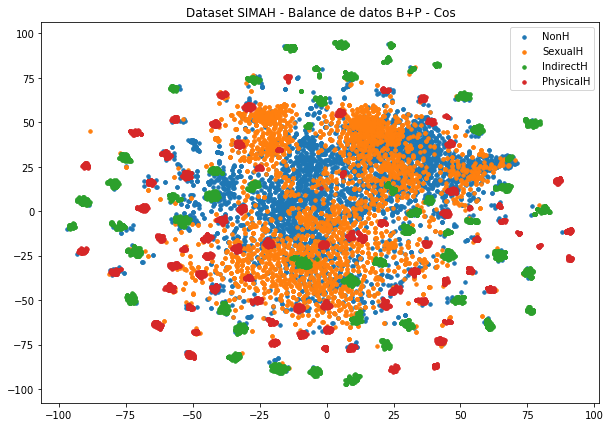

In [45]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_bp)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset SIMAH - Balance de datos B+P - Cos")
plt.show()

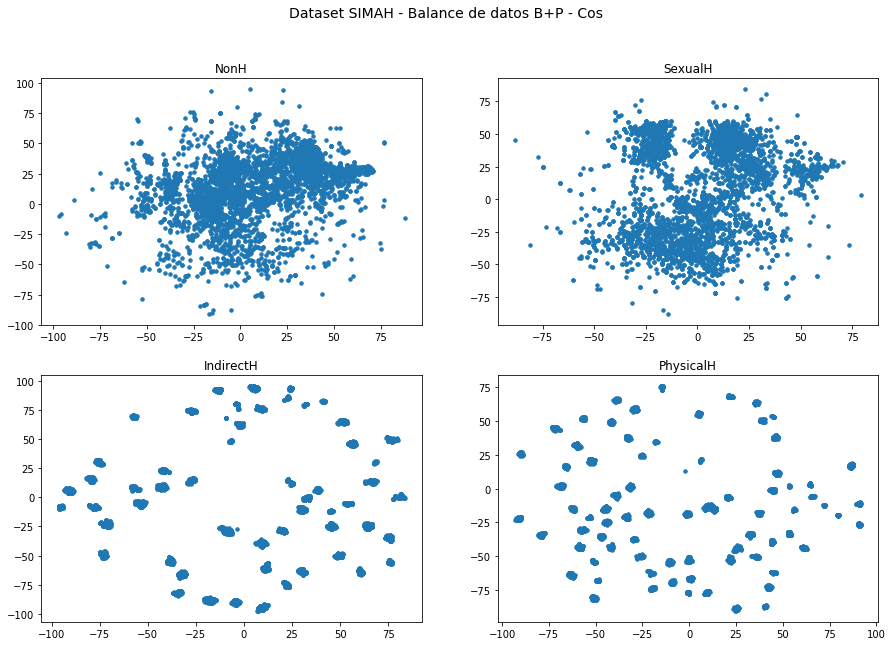

In [46]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))
        

fig.suptitle("Dataset SIMAH - Balance de datos B+P - Cos", fontsize=14)
plt.show()

In [47]:
np.random.shuffle(macro_augmented)
np.save('../Datasets/CSV_Harassment/balance_bert_Pon.npy', macro_augmented)
    

In [48]:
macro_augmented.shape

(14644, 3)